## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np

import random
import os
import pickle
import time
from collections import deque
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv
from runner import Runner

## 하이퍼 파라미터 정의하기

In [2]:
'''PPO Settings'''
TRAJ_LEN = 128
N_OPT_EPOCHS = 10
ENT_COEF = 1e-2
CLIP_RANGE = 0.1
LAMBDA = 0.95

'''RND Settings'''
# RND start step for input normalization
RND_START = int(0)
# Discount rate for intrinsic reward
INT_GAMMA = 0.99

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for A2C
N_ENVS = 4
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  6
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = int(1e+7)
# gamma for MDP
GAMMA = 0.9999
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 128
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1
# log optimization
LOG_OPT = False

'''Save&Load Settings'''
# log frequency
LOG_FREQ = 10
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
NET_PATH = './data/model/ppo_net.pkl'
PRED_PATH = './data/model/pred_net.pkl'

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow')

## 네트워크 구조 정의하기

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
        # extrinsic critic
        self.critic = nn.Linear(256, 1)
        # intrinsic critic
        self.int_critic = nn.Linear(256, 1)
            
        # parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(F.relu(x)), dim=1)
        state_value = self.critic(F.relu(x))
        int_state_value = self.int_critic(F.relu(x))

        return action_log_prob, state_value, int_state_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomPredNet(nn.Module):
    def __init__(self):
        super(RandomPredNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        # one more layer than target network for enough capacity
        self.fc2 = nn.Linear(256, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # if you use feature normalization in RND, remove division by 255.0
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.leaky_relu(x, negative_slope=2e-1))
        x = self.fc2(F.leaky_relu(x, negative_slope=2e-1))
        return x
    
    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomTargetNet(nn.Module):
    def __init__(self):
        super(RandomTargetNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # if you use feature normalization in RND, remove division by 255.0
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        return x

## RND 정의하기

In [4]:
class PPO:
    def __init__(self):
        self.net = ConvNet()
        self.rand_target = RandomTargetNet()
        self.rand_pred = RandomPredNet()
        # use gpu
        if USE_GPU:
            self.net = self.net.cuda()
            self.rand_target = self.rand_target.cuda()
            self.rand_pred = self.rand_pred.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LR)
        # define optimizer for predict network
        self.rand_pred_opt = torch.optim.Adam(self.rand_pred.parameters(), lr=LR)
        
        # ppo clip range
        self.clip_range = CLIP_RANGE
        
        # observation statistics for RND (if you use feature normalization in RND)
        self.s_mu = None
        self.s_sigma = None
        
    def save_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.save(NET_PATH)
        self.rand_pred.save(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
            
    def load_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.load(NET_PATH)
        self.rand_pred.load(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
        
    def choose_action(self, x):
        self.memory_counter += 1
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(x) # (nenvs, N_ACTIONS)
        probs = F.softmax(action_log_probs, dim=1).data.cpu().numpy()
        # sample actions
        actions = np.array([np.random.choice(N_ACTIONS,p=probs[i]) for i in range(len(probs))])
        # convert tensor to np.array
        action_log_probs = action_log_probs.data.cpu().numpy()
        state_values = state_values.squeeze(1).data.cpu().numpy()
        int_state_values = int_state_values.squeeze(1).data.cpu().numpy()
        # calc selected logprob
        selected_log_probs = np.array([action_log_probs[i][actions[i]] for i in range(len(probs))])
        return actions, state_values, int_state_values, selected_log_probs
    
    def r_int(self, s):
        s = torch.FloatTensor(s)
        # feature normalization part in RND
        # get intrinsic reward
#         r_input = list()
#         for i in range(len(s)):
#             r_input.append((s[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_target, r_pred, reduction='none'), dim=1)
        
        return r_int.data.cpu().numpy()
    
    def learn_predict(self, s):
        s = torch.FloatTensor(s)
        # feature normalization part in RND
        # RND pred net optimize
#         r_input = list()
#         for i in range(len(s)):
#             r_input.append((obs[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        s.requires_grad = True
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1)
        # (N_ENVS)
        # zero-centered gradient penalty for vanishing gradient problem. You can remove this part
        # check https://arxiv.org/abs/1801.04406 for more information.
        grad = autograd.grad(r_int, s, create_graph=True,
                        grad_outputs=torch.ones_like(r_int),
                        retain_graph=True, only_inputs=True)[0].view(len(s), -1)
        grad = grad.norm(dim=1)
        loss = r_int.mean() + 100.0 * ((grad)**2).mean()
        
        self.rand_pred_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.rand_pred.parameters(), MAX_GRAD_NORM)
        self.rand_pred_opt.step()
        return r_int.data.cpu().numpy()

    def learn(self, obs, returns, int_returns, masks, actions, values, int_values,  selected_log_probs):
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        returns = torch.FloatTensor(returns) # (m)
        int_returns = torch.FloatTensor(int_returns) # (m)
        actions = torch.LongTensor(actions) # (m)
        selected_log_probs = torch.FloatTensor(selected_log_probs) # (m)
        values = torch.FloatTensor(values) # (m)
        int_values = torch.FloatTensor(int_values) # (m)
        if USE_GPU:
            obs = obs.cuda()
            returns = returns.cuda()
            int_returns = int_returns.cuda()
            actions = actions.cuda()
            selected_log_probs = selected_log_probs.cuda()
            values = values.cuda()
            int_values = int_values.cuda()
        
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(obs)
        # (m, N_ACTIONS), (m, 1)
        
        # calculate the advantages
        # original RND
#         advs = 2 * (returns - values) + (int_returns - int_values)
        # only intrinsic motivation agent's advantage
        advs = (int_returns - int_values)
        advs = (advs - advs.mean())/(advs.std() + 1e-8)
        
        # calc probs
        probs = F.softmax(action_log_probs, dim=1)
        # (m, N_ACTIONS)
        
        # calc entropy loss
        ent_loss = ENT_COEF *((action_log_probs * probs).sum(dim=1)).mean()
        # (1)
        
        # calc log probs
        cur_log_probs = action_log_probs.gather(1,actions.unsqueeze(1))
        # cur : (m, 1)
        ratio = torch.exp(cur_log_probs.squeeze(1)-selected_log_probs)
        # (m)
        
        # actor loss
        surr1 = ratio * advs # (m)
        surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range)*advs # (m)
        actor_loss = -torch.min(surr1, surr2).mean() # (1)
        # critic loss
        critic_loss = F.smooth_l1_loss(state_values.squeeze(1), returns) # (1)
        # int critic loss
        int_critic_loss = F.smooth_l1_loss(int_state_values.squeeze(1), int_returns) # (1)

        loss = actor_loss + critic_loss + ent_loss + int_critic_loss # (1)
        
        actor_loss, critic_loss, ent_loss, total_loss = actor_loss.data.cpu().numpy(), \
        critic_loss.data.cpu().numpy(), ent_loss.data.cpu().numpy(), loss.data.cpu().numpy()

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()
        
        return round(float(actor_loss), 4), round(float(critic_loss), 4),\
    round(float(ent_loss), 4), round(float(total_loss), 4)

## 학습

In [5]:
ppo = PPO()
runner = Runner(env=env, model=ppo, nsteps=TRAJ_LEN, gamma=GAMMA, int_gamma=INT_GAMMA, lam=LAMBDA, rnd_start=RND_START)

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    ppo.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# in PPO, we iterate over optimization step
nbatch = N_ENVS * TRAJ_LEN
nupdates = N_STEP// nbatch
# check learning time
start_time = time.time()

for update in tqdm(range(1, nupdates+1)):
    # get minibatch
    obs, returns, int_rewards, int_returns, masks, actions, values, int_values, neglogpacs, epinfos = runner.run()
    epinfobuf.extend(epinfos)
    
    if ppo.memory_counter > RND_START:
        # calculate loss
        inds = np.arange(nbatch)
        for _ in range(N_OPT_EPOCHS):
            a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
            # shuffle indices for i.i.d.
            np.random.shuffle(inds)
            # 0 to batch_size with batch_train_size step
            for start in range(0, nbatch, BATCH_SIZE):
                end = start + BATCH_SIZE
                mbinds = inds[start:end]
                slices = (arr[mbinds] for arr in (obs, returns, int_returns, masks, actions, values, int_values, neglogpacs))
                actor_loss, critic_loss, ent_loss, total_loss = ppo.learn(*slices)
                if np.random.rand() <= 0.25:
                    ppo.learn_predict(obs[mbinds])
            
        if update % LOG_FREQ == 0:
            # print log and save
            # check time interval
            time_interval = round(time.time() - start_time, 2)
            # calc mean return
            mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
            result.append(mean_100_ep_return)
            # print epi log
            print('N : ',update,
                  '| Return mean: ', mean_100_ep_return,
                  '| R_int_mean : ', round(np.mean(int_rewards),3),
                  '| R_int_std : ', round(np.std(int_rewards),3),
                  '| Values : ', round(np.mean(values), 3),
                  '| Int_values : ', round(np.mean(int_values), 3),
                  '| Time:',time_interval,
                  '| Used Step:',ppo.memory_counter*N_ENVS)
            # save model
            if SAVE:
                ppo.save_model()
env.close()

  0%|          | 0/19531 [00:00<?, ?it/s]

Initialize results!


  0%|          | 10/19531 [00:17<9:06:00,  1.68s/it]

N :  10 | Return mean:  0.02 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.012 | Int_values :  0.003 | Time: 17.4 | Used Step: 5200


  0%|          | 20/19531 [00:34<9:36:24,  1.77s/it]

N :  20 | Return mean:  0.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.045 | Int_values :  0.056 | Time: 34.34 | Used Step: 10400


  0%|          | 30/19531 [00:52<9:36:57,  1.78s/it]

N :  30 | Return mean:  0.18 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  0.157 | Int_values :  0.068 | Time: 52.02 | Used Step: 15600


  0%|          | 40/19531 [01:07<8:28:13,  1.56s/it]

N :  40 | Return mean:  0.49 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.295 | Int_values :  0.149 | Time: 67.09 | Used Step: 20800


  0%|          | 50/19531 [01:23<8:53:17,  1.64s/it]

N :  50 | Return mean:  1.12 | R_int_mean :  0.006 | R_int_std :  0.004 | Values :  0.418 | Int_values :  0.223 | Time: 83.65 | Used Step: 26000


  0%|          | 60/19531 [01:41<9:19:53,  1.73s/it]

N :  60 | Return mean:  2.01 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.446 | Int_values :  0.106 | Time: 101.11 | Used Step: 31200


  0%|          | 70/19531 [01:56<8:56:14,  1.65s/it]

N :  70 | Return mean:  3.09 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.626 | Int_values :  0.094 | Time: 116.73 | Used Step: 36400


  0%|          | 80/19531 [02:14<8:43:42,  1.62s/it] 

N :  80 | Return mean:  4.16 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.638 | Int_values :  0.115 | Time: 134.19 | Used Step: 41600


  0%|          | 90/19531 [02:30<8:30:00,  1.57s/it]

N :  90 | Return mean:  5.38 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.508 | Int_values :  0.089 | Time: 150.59 | Used Step: 46800


  1%|          | 100/19531 [02:45<8:16:28,  1.53s/it]

N :  100 | Return mean:  6.27 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.617 | Int_values :  0.07 | Time: 165.9 | Used Step: 52000


  1%|          | 110/19531 [03:02<8:50:39,  1.64s/it]

N :  110 | Return mean:  6.94 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.741 | Int_values :  0.114 | Time: 182.83 | Used Step: 57200


  1%|          | 120/19531 [03:18<8:13:17,  1.52s/it]

N :  120 | Return mean:  7.67 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.614 | Int_values :  0.069 | Time: 198.53 | Used Step: 62400


  1%|          | 130/19531 [03:33<7:54:22,  1.47s/it]

N :  130 | Return mean:  7.8 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.821 | Int_values :  0.127 | Time: 213.19 | Used Step: 67600


  1%|          | 140/19531 [03:48<8:28:59,  1.57s/it]

N :  140 | Return mean:  8.24 | R_int_mean :  0.006 | R_int_std :  0.004 | Values :  0.637 | Int_values :  0.124 | Time: 228.96 | Used Step: 72800


  1%|          | 150/19531 [04:05<9:06:18,  1.69s/it]

N :  150 | Return mean:  8.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.769 | Int_values :  0.103 | Time: 245.88 | Used Step: 78000


  1%|          | 160/19531 [04:22<8:56:13,  1.66s/it]

N :  160 | Return mean:  8.47 | R_int_mean :  0.007 | R_int_std :  0.004 | Values :  0.59 | Int_values :  0.203 | Time: 262.59 | Used Step: 83200


  1%|          | 170/19531 [04:38<8:39:06,  1.61s/it]

N :  170 | Return mean:  8.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.532 | Int_values :  0.122 | Time: 278.29 | Used Step: 88400


  1%|          | 180/19531 [04:55<9:11:23,  1.71s/it]

N :  180 | Return mean:  8.55 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.209 | Int_values :  0.172 | Time: 295.03 | Used Step: 93600


  1%|          | 190/19531 [05:10<8:30:29,  1.58s/it]

N :  190 | Return mean:  8.52 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.871 | Int_values :  0.107 | Time: 310.87 | Used Step: 98800


  1%|          | 200/19531 [05:27<8:57:05,  1.67s/it]

N :  200 | Return mean:  7.73 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.536 | Int_values :  0.11 | Time: 327.83 | Used Step: 104000


  1%|          | 210/19531 [05:43<8:25:22,  1.57s/it]

N :  210 | Return mean:  7.69 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  0.495 | Int_values :  0.173 | Time: 343.71 | Used Step: 109200


  1%|          | 220/19531 [06:00<8:50:34,  1.65s/it]

N :  220 | Return mean:  7.42 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.067 | Int_values :  0.117 | Time: 360.31 | Used Step: 114400


  1%|          | 230/19531 [06:17<8:53:43,  1.66s/it]

N :  230 | Return mean:  7.35 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.955 | Int_values :  0.11 | Time: 377.02 | Used Step: 119600


  1%|          | 240/19531 [06:32<8:06:50,  1.51s/it]

N :  240 | Return mean:  7.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.011 | Int_values :  0.118 | Time: 392.68 | Used Step: 124800


  1%|▏         | 250/19531 [06:49<9:08:16,  1.71s/it]

N :  250 | Return mean:  7.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.912 | Int_values :  0.135 | Time: 409.28 | Used Step: 130000


  1%|▏         | 260/19531 [07:05<9:08:37,  1.71s/it]

N :  260 | Return mean:  7.36 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.077 | Int_values :  0.103 | Time: 425.85 | Used Step: 135200


  1%|▏         | 270/19531 [07:22<8:54:38,  1.67s/it]

N :  270 | Return mean:  7.58 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.93 | Int_values :  0.146 | Time: 442.13 | Used Step: 140400


  1%|▏         | 280/19531 [07:38<8:41:41,  1.63s/it]

N :  280 | Return mean:  7.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.792 | Int_values :  0.115 | Time: 458.84 | Used Step: 145600


  1%|▏         | 290/19531 [07:54<8:01:28,  1.50s/it]

N :  290 | Return mean:  7.88 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  0.709 | Int_values :  0.101 | Time: 474.11 | Used Step: 150800


  2%|▏         | 300/19531 [08:10<8:39:28,  1.62s/it]

N :  300 | Return mean:  7.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.657 | Int_values :  0.076 | Time: 490.68 | Used Step: 156000


  2%|▏         | 310/19531 [08:27<9:21:24,  1.75s/it]

N :  310 | Return mean:  7.83 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.806 | Int_values :  0.099 | Time: 507.98 | Used Step: 161200


  2%|▏         | 320/19531 [08:44<8:19:53,  1.56s/it]

N :  320 | Return mean:  7.86 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.134 | Int_values :  0.071 | Time: 524.33 | Used Step: 166400


  2%|▏         | 330/19531 [09:00<8:28:34,  1.59s/it]

N :  330 | Return mean:  7.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.785 | Int_values :  0.1 | Time: 540.71 | Used Step: 171600


  2%|▏         | 340/19531 [09:16<8:03:03,  1.51s/it]

N :  340 | Return mean:  7.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.803 | Int_values :  0.139 | Time: 556.55 | Used Step: 176800


  2%|▏         | 350/19531 [09:34<9:00:54,  1.69s/it]

N :  350 | Return mean:  7.6 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.923 | Int_values :  0.113 | Time: 574.34 | Used Step: 182000


  2%|▏         | 360/19531 [09:51<9:01:08,  1.69s/it]

N :  360 | Return mean:  7.81 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.033 | Int_values :  0.137 | Time: 591.01 | Used Step: 187200


  2%|▏         | 370/19531 [10:07<8:44:17,  1.64s/it]

N :  370 | Return mean:  7.59 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.508 | Int_values :  0.083 | Time: 607.62 | Used Step: 192400


  2%|▏         | 380/19531 [10:23<8:19:38,  1.57s/it]

N :  380 | Return mean:  7.79 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.045 | Int_values :  0.107 | Time: 623.5 | Used Step: 197600


  2%|▏         | 390/19531 [10:39<8:34:58,  1.61s/it]

N :  390 | Return mean:  8.03 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.118 | Int_values :  0.091 | Time: 639.74 | Used Step: 202800


  2%|▏         | 400/19531 [10:57<9:38:10,  1.81s/it]

N :  400 | Return mean:  8.2 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  0.837 | Int_values :  0.124 | Time: 657.02 | Used Step: 208000


  2%|▏         | 410/19531 [11:12<8:21:19,  1.57s/it]

N :  410 | Return mean:  8.6 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.947 | Int_values :  0.087 | Time: 672.95 | Used Step: 213200


  2%|▏         | 420/19531 [11:27<8:21:15,  1.57s/it]

N :  420 | Return mean:  8.82 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.01 | Int_values :  0.107 | Time: 687.65 | Used Step: 218400


  2%|▏         | 430/19531 [11:44<8:45:47,  1.65s/it]

N :  430 | Return mean:  8.47 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  0.805 | Int_values :  0.1 | Time: 704.32 | Used Step: 223600


  2%|▏         | 440/19531 [12:00<8:33:35,  1.61s/it]

N :  440 | Return mean:  8.61 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  0.917 | Int_values :  0.152 | Time: 720.68 | Used Step: 228800


  2%|▏         | 450/19531 [12:17<9:16:01,  1.75s/it]

N :  450 | Return mean:  8.85 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.797 | Int_values :  0.068 | Time: 737.88 | Used Step: 234000


  2%|▏         | 460/19531 [12:33<8:43:09,  1.65s/it]

N :  460 | Return mean:  8.53 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.819 | Int_values :  0.11 | Time: 753.88 | Used Step: 239200


  2%|▏         | 470/19531 [12:49<8:32:24,  1.61s/it]

N :  470 | Return mean:  8.4 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.83 | Int_values :  0.11 | Time: 769.87 | Used Step: 244400


  2%|▏         | 480/19531 [13:06<8:28:11,  1.60s/it]

N :  480 | Return mean:  8.64 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.522 | Int_values :  0.152 | Time: 786.3 | Used Step: 249600


  3%|▎         | 490/19531 [13:21<8:30:30,  1.61s/it]

N :  490 | Return mean:  8.66 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.777 | Int_values :  0.142 | Time: 801.56 | Used Step: 254800


  3%|▎         | 500/19531 [13:37<8:29:05,  1.61s/it]

N :  500 | Return mean:  8.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.874 | Int_values :  0.117 | Time: 817.81 | Used Step: 260000


  3%|▎         | 510/19531 [13:53<8:09:08,  1.54s/it]

N :  510 | Return mean:  8.59 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.107 | Int_values :  0.11 | Time: 833.74 | Used Step: 265200


  3%|▎         | 520/19531 [14:10<8:41:12,  1.64s/it]

N :  520 | Return mean:  8.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.257 | Int_values :  0.1 | Time: 850.1 | Used Step: 270400


  3%|▎         | 530/19531 [14:26<8:13:22,  1.56s/it]

N :  530 | Return mean:  8.64 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.872 | Int_values :  0.084 | Time: 866.35 | Used Step: 275600


  3%|▎         | 540/19531 [14:42<8:27:37,  1.60s/it]

N :  540 | Return mean:  8.82 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.019 | Int_values :  0.143 | Time: 882.05 | Used Step: 280800


  3%|▎         | 550/19531 [14:58<8:53:44,  1.69s/it]

N :  550 | Return mean:  8.32 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.001 | Int_values :  0.117 | Time: 898.88 | Used Step: 286000


  3%|▎         | 560/19531 [15:14<8:40:31,  1.65s/it]

N :  560 | Return mean:  8.11 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.064 | Int_values :  0.087 | Time: 914.75 | Used Step: 291200


  3%|▎         | 570/19531 [15:31<8:44:31,  1.66s/it]

N :  570 | Return mean:  7.61 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  0.872 | Int_values :  0.11 | Time: 931.06 | Used Step: 296400


  3%|▎         | 580/19531 [15:47<8:25:14,  1.60s/it]

N :  580 | Return mean:  7.45 | R_int_mean :  0.006 | R_int_std :  0.006 | Values :  1.107 | Int_values :  0.111 | Time: 947.41 | Used Step: 301600


  3%|▎         | 590/19531 [16:03<8:14:11,  1.57s/it]

N :  590 | Return mean:  7.46 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.925 | Int_values :  0.134 | Time: 963.08 | Used Step: 306800


  3%|▎         | 600/19531 [16:20<9:10:44,  1.75s/it]

N :  600 | Return mean:  7.03 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  0.985 | Int_values :  0.076 | Time: 980.26 | Used Step: 312000


  3%|▎         | 610/19531 [16:36<8:21:27,  1.59s/it]

N :  610 | Return mean:  6.73 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.985 | Int_values :  0.12 | Time: 996.42 | Used Step: 317200


  3%|▎         | 620/19531 [16:53<9:26:18,  1.80s/it]

N :  620 | Return mean:  6.99 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.863 | Int_values :  0.137 | Time: 1013.29 | Used Step: 322400


  3%|▎         | 630/19531 [17:09<8:53:11,  1.69s/it]

N :  630 | Return mean:  7.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.914 | Int_values :  0.135 | Time: 1029.96 | Used Step: 327600


  3%|▎         | 640/19531 [17:26<9:11:06,  1.75s/it]

N :  640 | Return mean:  7.42 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.168 | Int_values :  0.15 | Time: 1046.74 | Used Step: 332800


  3%|▎         | 650/19531 [17:42<8:02:33,  1.53s/it]

N :  650 | Return mean:  7.6 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.522 | Int_values :  0.134 | Time: 1062.06 | Used Step: 338000


  3%|▎         | 660/19531 [17:58<8:41:38,  1.66s/it]

N :  660 | Return mean:  7.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.014 | Int_values :  0.075 | Time: 1078.72 | Used Step: 343200


  3%|▎         | 670/19531 [18:14<8:21:27,  1.60s/it]

N :  670 | Return mean:  7.35 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.978 | Int_values :  0.11 | Time: 1094.28 | Used Step: 348400


  3%|▎         | 680/19531 [18:29<8:35:01,  1.64s/it]

N :  680 | Return mean:  7.64 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.399 | Int_values :  0.124 | Time: 1109.77 | Used Step: 353600


  4%|▎         | 690/19531 [18:45<8:18:12,  1.59s/it]

N :  690 | Return mean:  7.83 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.698 | Int_values :  0.123 | Time: 1125.31 | Used Step: 358800


  4%|▎         | 700/19531 [19:01<8:26:44,  1.61s/it]

N :  700 | Return mean:  7.7 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.934 | Int_values :  0.102 | Time: 1141.69 | Used Step: 364000


  4%|▎         | 710/19531 [19:18<9:08:18,  1.75s/it]

N :  710 | Return mean:  7.93 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.399 | Int_values :  0.153 | Time: 1158.64 | Used Step: 369200


  4%|▎         | 720/19531 [19:34<8:16:56,  1.59s/it]

N :  720 | Return mean:  8.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.291 | Int_values :  0.154 | Time: 1174.96 | Used Step: 374400


  4%|▎         | 730/19531 [19:51<8:30:56,  1.63s/it]

N :  730 | Return mean:  8.19 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.897 | Int_values :  0.211 | Time: 1191.21 | Used Step: 379600


  4%|▍         | 740/19531 [20:06<8:29:48,  1.63s/it]

N :  740 | Return mean:  8.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.021 | Int_values :  0.127 | Time: 1206.98 | Used Step: 384800


  4%|▍         | 750/19531 [20:22<7:57:13,  1.52s/it]

N :  750 | Return mean:  8.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.823 | Int_values :  0.122 | Time: 1222.36 | Used Step: 390000


  4%|▍         | 760/19531 [20:39<9:05:50,  1.74s/it]

N :  760 | Return mean:  8.68 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  0.816 | Int_values :  0.101 | Time: 1239.16 | Used Step: 395200


  4%|▍         | 770/19531 [20:55<8:36:05,  1.65s/it]

N :  770 | Return mean:  8.76 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.369 | Int_values :  0.142 | Time: 1255.47 | Used Step: 400400


  4%|▍         | 780/19531 [21:10<8:10:35,  1.57s/it]

N :  780 | Return mean:  9.17 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.282 | Int_values :  0.136 | Time: 1270.99 | Used Step: 405600


  4%|▍         | 790/19531 [21:26<8:11:10,  1.57s/it]

N :  790 | Return mean:  9.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.634 | Int_values :  0.133 | Time: 1286.87 | Used Step: 410800


  4%|▍         | 800/19531 [21:42<7:43:14,  1.48s/it]

N :  800 | Return mean:  9.59 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.226 | Int_values :  0.116 | Time: 1302.44 | Used Step: 416000


  4%|▍         | 810/19531 [21:58<8:07:01,  1.56s/it]

N :  810 | Return mean:  9.94 | R_int_mean :  0.008 | R_int_std :  0.009 | Values :  1.14 | Int_values :  0.188 | Time: 1318.5 | Used Step: 421200


  4%|▍         | 820/19531 [22:14<8:15:10,  1.59s/it]

N :  820 | Return mean:  9.93 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.187 | Int_values :  0.118 | Time: 1334.69 | Used Step: 426400


  4%|▍         | 830/19531 [22:31<8:49:23,  1.70s/it]

N :  830 | Return mean:  10.11 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.281 | Int_values :  0.189 | Time: 1351.56 | Used Step: 431600


  4%|▍         | 840/19531 [22:47<7:45:11,  1.49s/it]

N :  840 | Return mean:  10.45 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.594 | Int_values :  0.142 | Time: 1367.55 | Used Step: 436800


  4%|▍         | 850/19531 [23:03<8:39:52,  1.67s/it]

N :  850 | Return mean:  10.72 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.483 | Int_values :  0.174 | Time: 1383.42 | Used Step: 442000


  4%|▍         | 860/19531 [23:19<8:29:51,  1.64s/it]

N :  860 | Return mean:  10.8 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.321 | Int_values :  0.149 | Time: 1399.78 | Used Step: 447200


  4%|▍         | 870/19531 [23:36<8:40:32,  1.67s/it]

N :  870 | Return mean:  10.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.343 | Int_values :  0.144 | Time: 1416.19 | Used Step: 452400


  5%|▍         | 880/19531 [23:52<8:14:36,  1.59s/it]

N :  880 | Return mean:  10.28 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.577 | Int_values :  0.143 | Time: 1432.04 | Used Step: 457600


  5%|▍         | 890/19531 [24:07<8:02:18,  1.55s/it]

N :  890 | Return mean:  10.38 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.569 | Int_values :  0.159 | Time: 1447.83 | Used Step: 462800


  5%|▍         | 900/19531 [24:23<8:25:13,  1.63s/it]

N :  900 | Return mean:  10.29 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.277 | Int_values :  0.158 | Time: 1463.02 | Used Step: 468000


  5%|▍         | 910/19531 [24:39<8:06:18,  1.57s/it]

N :  910 | Return mean:  10.43 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.48 | Int_values :  0.152 | Time: 1479.08 | Used Step: 473200


  5%|▍         | 920/19531 [24:55<8:28:39,  1.64s/it]

N :  920 | Return mean:  10.57 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.268 | Int_values :  0.169 | Time: 1495.18 | Used Step: 478400


  5%|▍         | 930/19531 [25:11<7:54:11,  1.53s/it]

N :  930 | Return mean:  10.78 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  1.57 | Int_values :  0.155 | Time: 1511.5 | Used Step: 483600


  5%|▍         | 940/19531 [25:27<7:43:52,  1.50s/it]

N :  940 | Return mean:  10.77 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.495 | Int_values :  0.142 | Time: 1527.16 | Used Step: 488800


  5%|▍         | 950/19531 [25:43<8:20:19,  1.62s/it]

N :  950 | Return mean:  10.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.592 | Int_values :  0.135 | Time: 1543.98 | Used Step: 494000


  5%|▍         | 960/19531 [25:59<8:12:25,  1.59s/it]

N :  960 | Return mean:  10.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.399 | Int_values :  0.125 | Time: 1559.72 | Used Step: 499200


  5%|▍         | 970/19531 [26:15<8:19:59,  1.62s/it]

N :  970 | Return mean:  10.87 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.418 | Int_values :  0.168 | Time: 1575.8 | Used Step: 504400


  5%|▌         | 980/19531 [26:31<8:10:36,  1.59s/it]

N :  980 | Return mean:  11.18 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.46 | Int_values :  0.103 | Time: 1591.08 | Used Step: 509600


  5%|▌         | 990/19531 [26:47<8:20:30,  1.62s/it]

N :  990 | Return mean:  10.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.254 | Int_values :  0.132 | Time: 1607.29 | Used Step: 514800


  5%|▌         | 1000/19531 [27:03<8:35:31,  1.67s/it]

N :  1000 | Return mean:  10.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.076 | Int_values :  0.109 | Time: 1623.82 | Used Step: 520000


  5%|▌         | 1010/19531 [27:19<8:05:50,  1.57s/it]

N :  1010 | Return mean:  10.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.499 | Int_values :  0.125 | Time: 1639.61 | Used Step: 525200


  5%|▌         | 1020/19531 [27:35<8:19:18,  1.62s/it]

N :  1020 | Return mean:  10.21 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.202 | Int_values :  0.104 | Time: 1655.52 | Used Step: 530400


  5%|▌         | 1030/19531 [27:51<8:10:28,  1.59s/it]

N :  1030 | Return mean:  9.95 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.046 | Int_values :  0.13 | Time: 1671.54 | Used Step: 535600


  5%|▌         | 1040/19531 [28:06<7:35:49,  1.48s/it]

N :  1040 | Return mean:  10.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.445 | Int_values :  0.127 | Time: 1686.59 | Used Step: 540800


  5%|▌         | 1050/19531 [28:22<8:28:10,  1.65s/it]

N :  1050 | Return mean:  10.24 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.992 | Int_values :  0.109 | Time: 1702.59 | Used Step: 546000


  5%|▌         | 1060/19531 [28:39<8:29:38,  1.66s/it]

N :  1060 | Return mean:  10.17 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.257 | Int_values :  0.164 | Time: 1719.79 | Used Step: 551200


  5%|▌         | 1070/19531 [28:56<8:35:32,  1.68s/it]

N :  1070 | Return mean:  10.36 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  1.173 | Int_values :  0.128 | Time: 1736.72 | Used Step: 556400


  6%|▌         | 1080/19531 [29:12<8:19:43,  1.63s/it]

N :  1080 | Return mean:  10.88 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.659 | Int_values :  0.159 | Time: 1752.56 | Used Step: 561600


  6%|▌         | 1090/19531 [29:28<8:44:06,  1.71s/it]

N :  1090 | Return mean:  10.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.046 | Int_values :  0.122 | Time: 1768.97 | Used Step: 566800


  6%|▌         | 1100/19531 [29:44<8:21:55,  1.63s/it]

N :  1100 | Return mean:  11.07 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.173 | Int_values :  0.146 | Time: 1784.97 | Used Step: 572000


  6%|▌         | 1110/19531 [30:02<8:33:17,  1.67s/it]

N :  1110 | Return mean:  10.97 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.298 | Int_values :  0.143 | Time: 1802.01 | Used Step: 577200


  6%|▌         | 1120/19531 [30:18<8:26:06,  1.65s/it]

N :  1120 | Return mean:  10.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.216 | Int_values :  0.114 | Time: 1818.34 | Used Step: 582400


  6%|▌         | 1130/19531 [30:34<8:15:49,  1.62s/it]

N :  1130 | Return mean:  10.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.763 | Int_values :  0.153 | Time: 1834.27 | Used Step: 587600


  6%|▌         | 1140/19531 [30:50<7:57:17,  1.56s/it]

N :  1140 | Return mean:  10.17 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.828 | Int_values :  0.111 | Time: 1850.12 | Used Step: 592800


  6%|▌         | 1150/19531 [31:07<8:40:43,  1.70s/it]

N :  1150 | Return mean:  10.25 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.084 | Int_values :  0.166 | Time: 1867.15 | Used Step: 598000


  6%|▌         | 1160/19531 [31:22<7:40:56,  1.51s/it]

N :  1160 | Return mean:  10.18 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.25 | Int_values :  0.099 | Time: 1882.45 | Used Step: 603200


  6%|▌         | 1170/19531 [31:37<7:28:27,  1.47s/it]

N :  1170 | Return mean:  10.02 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.192 | Int_values :  0.122 | Time: 1897.75 | Used Step: 608400


  6%|▌         | 1180/19531 [31:53<7:29:29,  1.47s/it]

N :  1180 | Return mean:  10.4 | R_int_mean :  0.004 | R_int_std :  0.001 | Values :  1.662 | Int_values :  0.168 | Time: 1913.69 | Used Step: 613600


  6%|▌         | 1190/19531 [32:09<8:02:13,  1.58s/it]

N :  1190 | Return mean:  10.81 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.688 | Int_values :  0.168 | Time: 1929.44 | Used Step: 618800


  6%|▌         | 1200/19531 [32:25<8:16:00,  1.62s/it]

N :  1200 | Return mean:  10.99 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.399 | Int_values :  0.154 | Time: 1945.95 | Used Step: 624000


  6%|▌         | 1210/19531 [32:41<8:03:20,  1.58s/it]

N :  1210 | Return mean:  11.06 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.154 | Int_values :  0.168 | Time: 1961.86 | Used Step: 629200


  6%|▌         | 1220/19531 [32:58<8:22:56,  1.65s/it]

N :  1220 | Return mean:  11.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.433 | Int_values :  0.154 | Time: 1978.6 | Used Step: 634400


  6%|▋         | 1230/19531 [33:15<9:11:30,  1.81s/it]

N :  1230 | Return mean:  11.39 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.705 | Int_values :  0.178 | Time: 1995.92 | Used Step: 639600


  6%|▋         | 1240/19531 [33:32<8:01:16,  1.58s/it]

N :  1240 | Return mean:  11.31 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.62 | Int_values :  0.127 | Time: 2012.09 | Used Step: 644800


  6%|▋         | 1250/19531 [33:48<7:48:29,  1.54s/it]

N :  1250 | Return mean:  11.25 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.556 | Int_values :  0.158 | Time: 2028.81 | Used Step: 650000


  6%|▋         | 1260/19531 [34:04<7:53:49,  1.56s/it]

N :  1260 | Return mean:  11.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.622 | Int_values :  0.193 | Time: 2044.83 | Used Step: 655200


  7%|▋         | 1270/19531 [34:21<8:50:43,  1.74s/it]

N :  1270 | Return mean:  11.24 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.547 | Int_values :  0.138 | Time: 2061.94 | Used Step: 660400


  7%|▋         | 1280/19531 [34:37<8:21:17,  1.65s/it]

N :  1280 | Return mean:  11.06 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.567 | Int_values :  0.104 | Time: 2077.51 | Used Step: 665600


  7%|▋         | 1290/19531 [34:53<8:01:35,  1.58s/it]

N :  1290 | Return mean:  10.89 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.392 | Int_values :  0.169 | Time: 2093.58 | Used Step: 670800


  7%|▋         | 1300/19531 [35:09<8:00:33,  1.58s/it]

N :  1300 | Return mean:  10.92 | R_int_mean :  0.006 | R_int_std :  0.005 | Values :  1.096 | Int_values :  0.159 | Time: 2109.5 | Used Step: 676000


  7%|▋         | 1310/19531 [35:26<8:30:32,  1.68s/it]

N :  1310 | Return mean:  10.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.357 | Int_values :  0.102 | Time: 2126.42 | Used Step: 681200


  7%|▋         | 1320/19531 [35:43<8:54:33,  1.76s/it]

N :  1320 | Return mean:  11.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.602 | Int_values :  0.166 | Time: 2143.43 | Used Step: 686400


  7%|▋         | 1330/19531 [35:59<8:13:09,  1.63s/it]

N :  1330 | Return mean:  11.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.633 | Int_values :  0.154 | Time: 2159.26 | Used Step: 691600


  7%|▋         | 1340/19531 [36:14<7:52:53,  1.56s/it]

N :  1340 | Return mean:  11.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.554 | Int_values :  0.167 | Time: 2174.66 | Used Step: 696800


  7%|▋         | 1350/19531 [36:30<8:21:41,  1.66s/it]

N :  1350 | Return mean:  11.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.416 | Int_values :  0.138 | Time: 2190.46 | Used Step: 702000


  7%|▋         | 1360/19531 [36:46<7:53:39,  1.56s/it]

N :  1360 | Return mean:  11.25 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.775 | Int_values :  0.162 | Time: 2206.4 | Used Step: 707200


  7%|▋         | 1370/19531 [37:01<7:36:48,  1.51s/it]

N :  1370 | Return mean:  11.25 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.525 | Int_values :  0.147 | Time: 2221.41 | Used Step: 712400


  7%|▋         | 1380/19531 [37:18<8:44:53,  1.74s/it]

N :  1380 | Return mean:  11.38 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.544 | Int_values :  0.127 | Time: 2238.04 | Used Step: 717600


  7%|▋         | 1390/19531 [37:33<8:10:11,  1.62s/it]

N :  1390 | Return mean:  11.21 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.319 | Int_values :  0.146 | Time: 2253.79 | Used Step: 722800


  7%|▋         | 1400/19531 [37:50<8:42:02,  1.73s/it]

N :  1400 | Return mean:  11.43 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.838 | Int_values :  0.156 | Time: 2270.24 | Used Step: 728000


  7%|▋         | 1410/19531 [38:05<7:10:08,  1.42s/it]

N :  1410 | Return mean:  11.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.777 | Int_values :  0.131 | Time: 2285.43 | Used Step: 733200


  7%|▋         | 1420/19531 [38:22<8:32:41,  1.70s/it]

N :  1420 | Return mean:  11.67 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.334 | Int_values :  0.097 | Time: 2302.98 | Used Step: 738400


  7%|▋         | 1430/19531 [38:39<8:23:25,  1.67s/it]

N :  1430 | Return mean:  11.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.432 | Int_values :  0.145 | Time: 2319.34 | Used Step: 743600


  7%|▋         | 1440/19531 [38:55<7:42:56,  1.54s/it]

N :  1440 | Return mean:  11.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.465 | Int_values :  0.146 | Time: 2335.18 | Used Step: 748800


  7%|▋         | 1450/19531 [39:10<8:30:18,  1.69s/it]

N :  1450 | Return mean:  11.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.436 | Int_values :  0.124 | Time: 2350.9 | Used Step: 754000


  7%|▋         | 1460/19531 [39:26<8:00:33,  1.60s/it]

N :  1460 | Return mean:  11.15 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.304 | Int_values :  0.181 | Time: 2366.91 | Used Step: 759200


  8%|▊         | 1470/19531 [39:44<8:29:47,  1.69s/it]

N :  1470 | Return mean:  11.35 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.362 | Int_values :  0.162 | Time: 2384.33 | Used Step: 764400


  8%|▊         | 1480/19531 [40:01<8:08:04,  1.62s/it]

N :  1480 | Return mean:  11.3 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.293 | Int_values :  0.134 | Time: 2401.03 | Used Step: 769600


  8%|▊         | 1490/19531 [40:16<7:19:09,  1.46s/it]

N :  1490 | Return mean:  11.44 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.334 | Int_values :  0.12 | Time: 2416.67 | Used Step: 774800


  8%|▊         | 1500/19531 [40:33<8:10:06,  1.63s/it]

N :  1500 | Return mean:  11.21 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.705 | Int_values :  0.124 | Time: 2433.28 | Used Step: 780000


  8%|▊         | 1510/19531 [40:50<8:35:34,  1.72s/it]

N :  1510 | Return mean:  11.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.907 | Int_values :  0.127 | Time: 2450.26 | Used Step: 785200


  8%|▊         | 1520/19531 [41:06<8:21:32,  1.67s/it]

N :  1520 | Return mean:  11.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.675 | Int_values :  0.155 | Time: 2466.45 | Used Step: 790400


  8%|▊         | 1530/19531 [41:22<7:55:21,  1.58s/it]

N :  1530 | Return mean:  11.73 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.686 | Int_values :  0.175 | Time: 2482.6 | Used Step: 795600


  8%|▊         | 1540/19531 [41:37<7:25:11,  1.48s/it]

N :  1540 | Return mean:  11.57 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.387 | Int_values :  0.199 | Time: 2497.58 | Used Step: 800800


  8%|▊         | 1550/19531 [41:54<8:28:12,  1.70s/it]

N :  1550 | Return mean:  11.78 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.089 | Int_values :  0.153 | Time: 2514.01 | Used Step: 806000


  8%|▊         | 1560/19531 [42:10<8:04:01,  1.62s/it]

N :  1560 | Return mean:  11.54 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.004 | Int_values :  0.117 | Time: 2530.45 | Used Step: 811200


  8%|▊         | 1570/19531 [42:26<8:28:41,  1.70s/it]

N :  1570 | Return mean:  11.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.619 | Int_values :  0.111 | Time: 2546.11 | Used Step: 816400


  8%|▊         | 1580/19531 [42:43<8:25:53,  1.69s/it]

N :  1580 | Return mean:  10.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.235 | Int_values :  0.106 | Time: 2563.44 | Used Step: 821600


  8%|▊         | 1590/19531 [42:58<8:07:23,  1.63s/it]

N :  1590 | Return mean:  10.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.143 | Int_values :  0.114 | Time: 2578.72 | Used Step: 826800


  8%|▊         | 1600/19531 [43:16<8:48:09,  1.77s/it]

N :  1600 | Return mean:  10.16 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.103 | Int_values :  0.121 | Time: 2595.99 | Used Step: 832000


  8%|▊         | 1610/19531 [43:32<8:04:31,  1.62s/it]

N :  1610 | Return mean:  9.47 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.045 | Int_values :  0.118 | Time: 2612.43 | Used Step: 837200


  8%|▊         | 1620/19531 [43:47<7:42:47,  1.55s/it]

N :  1620 | Return mean:  9.03 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.173 | Int_values :  0.082 | Time: 2627.99 | Used Step: 842400


  8%|▊         | 1630/19531 [44:03<7:53:14,  1.59s/it]

N :  1630 | Return mean:  9.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.507 | Int_values :  0.133 | Time: 2643.61 | Used Step: 847600


  8%|▊         | 1640/19531 [44:19<7:38:34,  1.54s/it]

N :  1640 | Return mean:  8.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.457 | Int_values :  0.11 | Time: 2659.8 | Used Step: 852800


  8%|▊         | 1650/19531 [44:35<8:20:15,  1.68s/it]

N :  1650 | Return mean:  9.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.572 | Int_values :  0.128 | Time: 2675.49 | Used Step: 858000


  8%|▊         | 1660/19531 [44:52<8:05:06,  1.63s/it]

N :  1660 | Return mean:  9.31 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.654 | Int_values :  0.152 | Time: 2692.08 | Used Step: 863200


  9%|▊         | 1670/19531 [45:08<7:58:04,  1.61s/it]

N :  1670 | Return mean:  9.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.618 | Int_values :  0.108 | Time: 2708.22 | Used Step: 868400


  9%|▊         | 1680/19531 [45:24<8:22:20,  1.69s/it]

N :  1680 | Return mean:  9.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.619 | Int_values :  0.187 | Time: 2724.52 | Used Step: 873600


  9%|▊         | 1690/19531 [45:39<7:36:04,  1.53s/it]

N :  1690 | Return mean:  9.72 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.343 | Int_values :  0.122 | Time: 2739.73 | Used Step: 878800


  9%|▊         | 1700/19531 [45:57<8:19:17,  1.68s/it]

N :  1700 | Return mean:  10.09 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.148 | Int_values :  0.144 | Time: 2757.22 | Used Step: 884000


  9%|▉         | 1710/19531 [46:13<7:55:08,  1.60s/it]

N :  1710 | Return mean:  9.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.242 | Int_values :  0.09 | Time: 2773.42 | Used Step: 889200


  9%|▉         | 1720/19531 [46:29<7:47:21,  1.57s/it]

N :  1720 | Return mean:  9.66 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.36 | Int_values :  0.141 | Time: 2789.16 | Used Step: 894400


  9%|▉         | 1730/19531 [46:44<7:50:33,  1.59s/it]

N :  1730 | Return mean:  9.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.465 | Int_values :  0.127 | Time: 2804.53 | Used Step: 899600


  9%|▉         | 1740/19531 [47:00<7:50:30,  1.59s/it]

N :  1740 | Return mean:  9.76 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.266 | Int_values :  0.125 | Time: 2820.2 | Used Step: 904800


  9%|▉         | 1750/19531 [47:15<7:13:31,  1.46s/it]

N :  1750 | Return mean:  9.49 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.388 | Int_values :  0.124 | Time: 2835.18 | Used Step: 910000


  9%|▉         | 1760/19531 [47:30<7:31:43,  1.53s/it]

N :  1760 | Return mean:  9.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.463 | Int_values :  0.149 | Time: 2850.45 | Used Step: 915200


  9%|▉         | 1770/19531 [47:46<7:42:13,  1.56s/it]

N :  1770 | Return mean:  9.68 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.295 | Int_values :  0.096 | Time: 2866.69 | Used Step: 920400


  9%|▉         | 1780/19531 [48:02<7:53:36,  1.60s/it]

N :  1780 | Return mean:  9.7 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.313 | Int_values :  0.156 | Time: 2882.61 | Used Step: 925600


  9%|▉         | 1790/19531 [48:18<8:08:19,  1.65s/it]

N :  1790 | Return mean:  10.24 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.223 | Int_values :  0.144 | Time: 2898.86 | Used Step: 930800


  9%|▉         | 1800/19531 [48:35<8:09:15,  1.66s/it]

N :  1800 | Return mean:  10.39 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.178 | Int_values :  0.2 | Time: 2915.1 | Used Step: 936000


  9%|▉         | 1810/19531 [48:50<7:40:55,  1.56s/it]

N :  1810 | Return mean:  11.21 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  1.851 | Int_values :  0.145 | Time: 2930.92 | Used Step: 941200


  9%|▉         | 1820/19531 [49:06<7:45:02,  1.58s/it]

N :  1820 | Return mean:  11.77 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.356 | Int_values :  0.157 | Time: 2946.62 | Used Step: 946400


  9%|▉         | 1830/19531 [49:22<7:33:26,  1.54s/it]

N :  1830 | Return mean:  12.02 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.945 | Int_values :  0.105 | Time: 2962.74 | Used Step: 951600


  9%|▉         | 1840/19531 [49:37<7:21:17,  1.50s/it]

N :  1840 | Return mean:  12.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.293 | Int_values :  0.115 | Time: 2977.57 | Used Step: 956800


  9%|▉         | 1850/19531 [49:54<8:20:32,  1.70s/it]

N :  1850 | Return mean:  12.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.223 | Int_values :  0.161 | Time: 2994.35 | Used Step: 962000


 10%|▉         | 1860/19531 [50:10<8:04:32,  1.65s/it]

N :  1860 | Return mean:  12.64 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.76 | Int_values :  0.147 | Time: 3010.17 | Used Step: 967200


 10%|▉         | 1870/19531 [50:27<7:46:27,  1.58s/it]

N :  1870 | Return mean:  12.79 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.505 | Int_values :  0.136 | Time: 3027.28 | Used Step: 972400


 10%|▉         | 1880/19531 [50:43<7:41:14,  1.57s/it]

N :  1880 | Return mean:  12.98 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.329 | Int_values :  0.104 | Time: 3043.18 | Used Step: 977600


 10%|▉         | 1890/19531 [50:58<7:41:48,  1.57s/it]

N :  1890 | Return mean:  12.58 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.504 | Int_values :  0.132 | Time: 3058.92 | Used Step: 982800


 10%|▉         | 1900/19531 [51:14<7:25:06,  1.51s/it]

N :  1900 | Return mean:  12.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.371 | Int_values :  0.189 | Time: 3074.42 | Used Step: 988000


 10%|▉         | 1910/19531 [51:30<7:33:26,  1.54s/it]

N :  1910 | Return mean:  11.84 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.158 | Int_values :  0.168 | Time: 3090.23 | Used Step: 993200


 10%|▉         | 1920/19531 [51:46<7:59:17,  1.63s/it]

N :  1920 | Return mean:  11.37 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.268 | Int_values :  0.117 | Time: 3106.18 | Used Step: 998400


 10%|▉         | 1930/19531 [52:01<7:31:42,  1.54s/it]

N :  1930 | Return mean:  11.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.184 | Int_values :  0.13 | Time: 3121.7 | Used Step: 1003600


 10%|▉         | 1940/19531 [52:19<8:28:37,  1.73s/it]

N :  1940 | Return mean:  11.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.593 | Int_values :  0.111 | Time: 3139.36 | Used Step: 1008800


 10%|▉         | 1950/19531 [52:35<8:15:44,  1.69s/it]

N :  1950 | Return mean:  11.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.524 | Int_values :  0.127 | Time: 3155.28 | Used Step: 1014000


 10%|█         | 1960/19531 [52:50<7:17:16,  1.49s/it]

N :  1960 | Return mean:  11.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.934 | Int_values :  0.119 | Time: 3170.51 | Used Step: 1019200


 10%|█         | 1970/19531 [53:06<7:37:25,  1.56s/it]

N :  1970 | Return mean:  11.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.461 | Int_values :  0.156 | Time: 3186.08 | Used Step: 1024400


 10%|█         | 1980/19531 [53:22<8:08:58,  1.67s/it]

N :  1980 | Return mean:  11.2 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.36 | Int_values :  0.112 | Time: 3202.37 | Used Step: 1029600


 10%|█         | 1990/19531 [53:39<8:18:52,  1.71s/it]

N :  1990 | Return mean:  11.42 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.392 | Int_values :  0.109 | Time: 3219.0 | Used Step: 1034800


 10%|█         | 2000/19531 [53:55<7:37:08,  1.56s/it]

N :  2000 | Return mean:  11.43 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.288 | Int_values :  0.115 | Time: 3235.44 | Used Step: 1040000


 10%|█         | 2010/19531 [54:12<8:32:15,  1.75s/it]

N :  2010 | Return mean:  11.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.982 | Int_values :  0.079 | Time: 3252.62 | Used Step: 1045200


 10%|█         | 2020/19531 [54:28<7:36:49,  1.57s/it]

N :  2020 | Return mean:  11.22 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.666 | Int_values :  0.159 | Time: 3268.21 | Used Step: 1050400


 10%|█         | 2030/19531 [54:44<7:39:08,  1.57s/it]

N :  2030 | Return mean:  10.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.95 | Int_values :  0.067 | Time: 3284.17 | Used Step: 1055600


 10%|█         | 2040/19531 [55:01<8:12:49,  1.69s/it]

N :  2040 | Return mean:  10.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.58 | Int_values :  0.132 | Time: 3301.33 | Used Step: 1060800


 10%|█         | 2050/19531 [55:16<7:33:41,  1.56s/it]

N :  2050 | Return mean:  10.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.415 | Int_values :  0.139 | Time: 3316.93 | Used Step: 1066000


 11%|█         | 2060/19531 [55:32<7:18:31,  1.51s/it]

N :  2060 | Return mean:  10.67 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.718 | Int_values :  0.141 | Time: 3332.45 | Used Step: 1071200


 11%|█         | 2070/19531 [55:48<8:09:10,  1.68s/it]

N :  2070 | Return mean:  10.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.318 | Int_values :  0.151 | Time: 3348.12 | Used Step: 1076400


 11%|█         | 2080/19531 [56:04<8:09:55,  1.68s/it]

N :  2080 | Return mean:  10.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.495 | Int_values :  0.102 | Time: 3364.65 | Used Step: 1081600


 11%|█         | 2090/19531 [56:20<7:41:20,  1.59s/it]

N :  2090 | Return mean:  10.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.685 | Int_values :  0.16 | Time: 3380.87 | Used Step: 1086800


 11%|█         | 2100/19531 [56:37<7:47:08,  1.61s/it]

N :  2100 | Return mean:  10.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.881 | Int_values :  0.158 | Time: 3397.27 | Used Step: 1092000


 11%|█         | 2110/19531 [56:52<7:30:31,  1.55s/it]

N :  2110 | Return mean:  10.66 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.25 | Int_values :  0.124 | Time: 3412.71 | Used Step: 1097200


 11%|█         | 2120/19531 [57:08<7:11:55,  1.49s/it]

N :  2120 | Return mean:  10.55 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.443 | Int_values :  0.165 | Time: 3428.39 | Used Step: 1102400


 11%|█         | 2130/19531 [57:24<8:05:16,  1.67s/it]

N :  2130 | Return mean:  11.4 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.723 | Int_values :  0.195 | Time: 3444.58 | Used Step: 1107600


 11%|█         | 2140/19531 [57:40<7:41:07,  1.59s/it]

N :  2140 | Return mean:  11.77 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.621 | Int_values :  0.16 | Time: 3460.98 | Used Step: 1112800


 11%|█         | 2150/19531 [57:56<7:38:54,  1.58s/it]

N :  2150 | Return mean:  12.23 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.818 | Int_values :  0.153 | Time: 3476.56 | Used Step: 1118000


 11%|█         | 2160/19531 [58:12<7:49:38,  1.62s/it]

N :  2160 | Return mean:  12.66 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.429 | Int_values :  0.129 | Time: 3492.71 | Used Step: 1123200


 11%|█         | 2170/19531 [58:28<7:41:45,  1.60s/it]

N :  2170 | Return mean:  12.43 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.669 | Int_values :  0.155 | Time: 3508.72 | Used Step: 1128400


 11%|█         | 2180/19531 [58:45<7:33:12,  1.57s/it]

N :  2180 | Return mean:  12.59 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.748 | Int_values :  0.163 | Time: 3525.34 | Used Step: 1133600


 11%|█         | 2190/19531 [59:01<7:47:26,  1.62s/it]

N :  2190 | Return mean:  12.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.896 | Int_values :  0.122 | Time: 3541.37 | Used Step: 1138800


 11%|█▏        | 2200/19531 [59:17<7:24:59,  1.54s/it]

N :  2200 | Return mean:  13.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.347 | Int_values :  0.159 | Time: 3556.99 | Used Step: 1144000


 11%|█▏        | 2210/19531 [59:33<7:56:35,  1.65s/it]

N :  2210 | Return mean:  13.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.682 | Int_values :  0.122 | Time: 3573.69 | Used Step: 1149200


 11%|█▏        | 2220/19531 [59:50<8:16:50,  1.72s/it]

N :  2220 | Return mean:  13.37 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.411 | Int_values :  0.162 | Time: 3590.43 | Used Step: 1154400


 11%|█▏        | 2230/19531 [1:00:06<7:45:03,  1.61s/it]

N :  2230 | Return mean:  13.58 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.138 | Int_values :  0.098 | Time: 3606.79 | Used Step: 1159600


 11%|█▏        | 2240/19531 [1:00:23<7:42:14,  1.60s/it]

N :  2240 | Return mean:  13.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.464 | Int_values :  0.171 | Time: 3623.08 | Used Step: 1164800


 12%|█▏        | 2250/19531 [1:00:38<7:20:08,  1.53s/it]

N :  2250 | Return mean:  13.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.553 | Int_values :  0.113 | Time: 3638.56 | Used Step: 1170000


 12%|█▏        | 2260/19531 [1:00:53<7:11:27,  1.50s/it]

N :  2260 | Return mean:  12.5 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.503 | Int_values :  0.12 | Time: 3653.96 | Used Step: 1175200


 12%|█▏        | 2270/19531 [1:01:10<8:02:03,  1.68s/it]

N :  2270 | Return mean:  12.3 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.61 | Int_values :  0.113 | Time: 3670.55 | Used Step: 1180400


 12%|█▏        | 2280/19531 [1:01:26<7:54:19,  1.65s/it]

N :  2280 | Return mean:  12.48 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.002 | Int_values :  0.129 | Time: 3686.21 | Used Step: 1185600


 12%|█▏        | 2290/19531 [1:01:42<7:27:33,  1.56s/it]

N :  2290 | Return mean:  12.48 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.964 | Int_values :  0.172 | Time: 3702.2 | Used Step: 1190800


 12%|█▏        | 2300/19531 [1:01:59<8:07:22,  1.70s/it]

N :  2300 | Return mean:  12.84 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.567 | Int_values :  0.131 | Time: 3719.34 | Used Step: 1196000


 12%|█▏        | 2310/19531 [1:02:15<7:18:42,  1.53s/it]

N :  2310 | Return mean:  12.72 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.336 | Int_values :  0.128 | Time: 3735.68 | Used Step: 1201200


 12%|█▏        | 2320/19531 [1:02:31<7:30:33,  1.57s/it]

N :  2320 | Return mean:  12.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.272 | Int_values :  0.098 | Time: 3751.53 | Used Step: 1206400


 12%|█▏        | 2330/19531 [1:02:47<7:53:55,  1.65s/it]

N :  2330 | Return mean:  12.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.736 | Int_values :  0.132 | Time: 3767.53 | Used Step: 1211600


 12%|█▏        | 2340/19531 [1:03:03<7:18:43,  1.53s/it]

N :  2340 | Return mean:  12.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.794 | Int_values :  0.144 | Time: 3783.4 | Used Step: 1216800


 12%|█▏        | 2350/19531 [1:03:19<7:10:51,  1.50s/it]

N :  2350 | Return mean:  12.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.426 | Int_values :  0.104 | Time: 3799.46 | Used Step: 1222000


 12%|█▏        | 2360/19531 [1:03:34<7:14:42,  1.52s/it]

N :  2360 | Return mean:  12.63 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.053 | Int_values :  0.137 | Time: 3814.87 | Used Step: 1227200


 12%|█▏        | 2370/19531 [1:03:50<7:22:14,  1.55s/it]

N :  2370 | Return mean:  12.64 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.533 | Int_values :  0.153 | Time: 3830.1 | Used Step: 1232400


 12%|█▏        | 2380/19531 [1:04:06<8:06:05,  1.70s/it]

N :  2380 | Return mean:  12.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.583 | Int_values :  0.134 | Time: 3846.17 | Used Step: 1237600


 12%|█▏        | 2390/19531 [1:04:22<7:31:50,  1.58s/it]

N :  2390 | Return mean:  13.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.713 | Int_values :  0.127 | Time: 3862.09 | Used Step: 1242800


 12%|█▏        | 2400/19531 [1:04:37<6:52:59,  1.45s/it]

N :  2400 | Return mean:  13.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.83 | Int_values :  0.126 | Time: 3877.96 | Used Step: 1248000


 12%|█▏        | 2410/19531 [1:04:54<7:49:43,  1.65s/it]

N :  2410 | Return mean:  12.82 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.548 | Int_values :  0.146 | Time: 3894.48 | Used Step: 1253200


 12%|█▏        | 2420/19531 [1:05:11<8:13:56,  1.73s/it]

N :  2420 | Return mean:  12.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.946 | Int_values :  0.115 | Time: 3911.95 | Used Step: 1258400


 12%|█▏        | 2430/19531 [1:05:28<7:36:59,  1.60s/it]

N :  2430 | Return mean:  13.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.489 | Int_values :  0.147 | Time: 3928.0 | Used Step: 1263600


 12%|█▏        | 2440/19531 [1:05:43<7:07:17,  1.50s/it]

N :  2440 | Return mean:  12.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.506 | Int_values :  0.141 | Time: 3943.05 | Used Step: 1268800


 13%|█▎        | 2450/19531 [1:05:58<7:43:58,  1.63s/it]

N :  2450 | Return mean:  12.79 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.263 | Int_values :  0.1 | Time: 3958.66 | Used Step: 1274000


 13%|█▎        | 2460/19531 [1:06:14<7:14:50,  1.53s/it]

N :  2460 | Return mean:  12.73 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.695 | Int_values :  0.121 | Time: 3974.81 | Used Step: 1279200


 13%|█▎        | 2470/19531 [1:06:30<7:09:29,  1.51s/it]

N :  2470 | Return mean:  12.44 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.116 | Int_values :  0.092 | Time: 3990.32 | Used Step: 1284400


 13%|█▎        | 2480/19531 [1:06:47<8:02:20,  1.70s/it]

N :  2480 | Return mean:  11.82 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.151 | Int_values :  0.1 | Time: 4007.4 | Used Step: 1289600


 13%|█▎        | 2490/19531 [1:07:03<7:26:33,  1.57s/it]

N :  2490 | Return mean:  10.69 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  0.951 | Int_values :  0.103 | Time: 4023.92 | Used Step: 1294800


 13%|█▎        | 2500/19531 [1:07:21<9:04:16,  1.92s/it]

N :  2500 | Return mean:  10.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.082 | Int_values :  0.09 | Time: 4041.36 | Used Step: 1300000


 13%|█▎        | 2510/19531 [1:07:37<7:37:11,  1.61s/it]

N :  2510 | Return mean:  9.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.884 | Int_values :  0.091 | Time: 4057.29 | Used Step: 1305200


 13%|█▎        | 2520/19531 [1:07:52<6:44:22,  1.43s/it]

N :  2520 | Return mean:  8.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.699 | Int_values :  0.159 | Time: 4072.25 | Used Step: 1310400


 13%|█▎        | 2530/19531 [1:08:08<7:27:10,  1.58s/it]

N :  2530 | Return mean:  8.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.244 | Int_values :  0.147 | Time: 4088.21 | Used Step: 1315600


 13%|█▎        | 2540/19531 [1:08:24<8:09:11,  1.73s/it]

N :  2540 | Return mean:  9.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.88 | Int_values :  0.13 | Time: 4104.74 | Used Step: 1320800


 13%|█▎        | 2550/19531 [1:08:41<7:46:28,  1.65s/it]

N :  2550 | Return mean:  9.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.104 | Int_values :  0.149 | Time: 4121.54 | Used Step: 1326000


 13%|█▎        | 2560/19531 [1:08:58<7:39:30,  1.62s/it]

N :  2560 | Return mean:  9.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.12 | Int_values :  0.107 | Time: 4138.11 | Used Step: 1331200


 13%|█▎        | 2570/19531 [1:09:14<7:45:03,  1.65s/it]

N :  2570 | Return mean:  9.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.737 | Int_values :  0.113 | Time: 4154.35 | Used Step: 1336400


 13%|█▎        | 2580/19531 [1:09:30<7:38:03,  1.62s/it]

N :  2580 | Return mean:  9.84 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.279 | Int_values :  0.141 | Time: 4170.76 | Used Step: 1341600


 13%|█▎        | 2590/19531 [1:09:47<8:05:51,  1.72s/it]

N :  2590 | Return mean:  10.31 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.83 | Int_values :  0.178 | Time: 4187.7 | Used Step: 1346800


 13%|█▎        | 2600/19531 [1:10:04<8:02:11,  1.71s/it]

N :  2600 | Return mean:  10.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.855 | Int_values :  0.11 | Time: 4204.45 | Used Step: 1352000


 13%|█▎        | 2610/19531 [1:10:20<7:34:32,  1.61s/it]

N :  2610 | Return mean:  10.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.872 | Int_values :  0.127 | Time: 4220.9 | Used Step: 1357200


 13%|█▎        | 2620/19531 [1:10:36<7:17:47,  1.55s/it]

N :  2620 | Return mean:  10.52 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.302 | Int_values :  0.122 | Time: 4236.62 | Used Step: 1362400


 13%|█▎        | 2630/19531 [1:10:52<7:38:05,  1.63s/it]

N :  2630 | Return mean:  10.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.737 | Int_values :  0.124 | Time: 4252.24 | Used Step: 1367600


 14%|█▎        | 2640/19531 [1:11:07<7:22:41,  1.57s/it]

N :  2640 | Return mean:  10.53 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.489 | Int_values :  0.157 | Time: 4267.63 | Used Step: 1372800


 14%|█▎        | 2650/19531 [1:11:23<7:18:02,  1.56s/it]

N :  2650 | Return mean:  10.56 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.088 | Int_values :  0.206 | Time: 4283.51 | Used Step: 1378000


 14%|█▎        | 2660/19531 [1:11:39<7:31:32,  1.61s/it]

N :  2660 | Return mean:  10.89 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.63 | Int_values :  0.122 | Time: 4299.83 | Used Step: 1383200


 14%|█▎        | 2670/19531 [1:11:55<7:13:22,  1.54s/it]

N :  2670 | Return mean:  11.47 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.927 | Int_values :  0.171 | Time: 4315.01 | Used Step: 1388400


 14%|█▎        | 2680/19531 [1:12:11<7:49:26,  1.67s/it]

N :  2680 | Return mean:  11.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.492 | Int_values :  0.083 | Time: 4331.12 | Used Step: 1393600


 14%|█▍        | 2690/19531 [1:12:27<7:22:53,  1.58s/it]

N :  2690 | Return mean:  12.03 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.717 | Int_values :  0.153 | Time: 4346.98 | Used Step: 1398800


 14%|█▍        | 2700/19531 [1:12:42<6:58:03,  1.49s/it]

N :  2700 | Return mean:  12.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.02 | Int_values :  0.101 | Time: 4362.84 | Used Step: 1404000


 14%|█▍        | 2710/19531 [1:12:58<7:29:20,  1.60s/it]

N :  2710 | Return mean:  11.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.6 | Int_values :  0.101 | Time: 4378.98 | Used Step: 1409200


 14%|█▍        | 2720/19531 [1:13:15<7:22:14,  1.58s/it]

N :  2720 | Return mean:  11.9 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.532 | Int_values :  0.146 | Time: 4395.11 | Used Step: 1414400


 14%|█▍        | 2730/19531 [1:13:31<7:29:30,  1.61s/it]

N :  2730 | Return mean:  11.76 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.273 | Int_values :  0.12 | Time: 4411.3 | Used Step: 1419600


 14%|█▍        | 2740/19531 [1:13:47<7:38:54,  1.64s/it]

N :  2740 | Return mean:  11.96 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.923 | Int_values :  0.177 | Time: 4427.15 | Used Step: 1424800


 14%|█▍        | 2750/19531 [1:14:03<7:39:50,  1.64s/it]

N :  2750 | Return mean:  12.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.373 | Int_values :  0.126 | Time: 4443.47 | Used Step: 1430000


 14%|█▍        | 2760/19531 [1:14:19<7:08:17,  1.53s/it]

N :  2760 | Return mean:  11.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.604 | Int_values :  0.147 | Time: 4459.08 | Used Step: 1435200


 14%|█▍        | 2770/19531 [1:14:34<6:55:58,  1.49s/it]

N :  2770 | Return mean:  11.86 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.426 | Int_values :  0.113 | Time: 4474.34 | Used Step: 1440400


 14%|█▍        | 2780/19531 [1:14:49<7:00:02,  1.50s/it]

N :  2780 | Return mean:  11.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.496 | Int_values :  0.106 | Time: 4489.56 | Used Step: 1445600


 14%|█▍        | 2790/19531 [1:15:04<6:57:31,  1.50s/it]

N :  2790 | Return mean:  11.14 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.103 | Int_values :  0.109 | Time: 4504.86 | Used Step: 1450800


 14%|█▍        | 2800/19531 [1:15:21<7:10:15,  1.54s/it]

N :  2800 | Return mean:  11.06 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.372 | Int_values :  0.115 | Time: 4521.21 | Used Step: 1456000


 14%|█▍        | 2810/19531 [1:15:38<7:28:12,  1.61s/it]

N :  2810 | Return mean:  11.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.531 | Int_values :  0.098 | Time: 4538.09 | Used Step: 1461200


 14%|█▍        | 2820/19531 [1:15:53<7:29:34,  1.61s/it]

N :  2820 | Return mean:  11.88 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.619 | Int_values :  0.103 | Time: 4553.96 | Used Step: 1466400


 14%|█▍        | 2830/19531 [1:16:09<7:23:24,  1.59s/it]

N :  2830 | Return mean:  11.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.094 | Int_values :  0.135 | Time: 4569.31 | Used Step: 1471600


 15%|█▍        | 2840/19531 [1:16:24<7:03:42,  1.52s/it]

N :  2840 | Return mean:  11.64 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.395 | Int_values :  0.121 | Time: 4584.82 | Used Step: 1476800


 15%|█▍        | 2850/19531 [1:16:40<7:13:07,  1.56s/it]

N :  2850 | Return mean:  11.16 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.424 | Int_values :  0.139 | Time: 4600.4 | Used Step: 1482000


 15%|█▍        | 2860/19531 [1:16:56<7:12:02,  1.55s/it]

N :  2860 | Return mean:  11.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.336 | Int_values :  0.114 | Time: 4616.67 | Used Step: 1487200


 15%|█▍        | 2870/19531 [1:17:12<7:10:26,  1.55s/it]

N :  2870 | Return mean:  10.89 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.932 | Int_values :  0.1 | Time: 4632.32 | Used Step: 1492400


 15%|█▍        | 2880/19531 [1:17:29<7:53:25,  1.71s/it]

N :  2880 | Return mean:  10.67 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.226 | Int_values :  0.097 | Time: 4649.33 | Used Step: 1497600


 15%|█▍        | 2890/19531 [1:17:45<7:36:33,  1.65s/it]

N :  2890 | Return mean:  10.99 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.286 | Int_values :  0.133 | Time: 4665.54 | Used Step: 1502800


 15%|█▍        | 2900/19531 [1:18:01<7:06:09,  1.54s/it]

N :  2900 | Return mean:  11.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.71 | Int_values :  0.143 | Time: 4681.25 | Used Step: 1508000


 15%|█▍        | 2910/19531 [1:18:16<7:03:30,  1.53s/it]

N :  2910 | Return mean:  11.05 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.468 | Int_values :  0.119 | Time: 4696.26 | Used Step: 1513200


 15%|█▍        | 2920/19531 [1:18:33<7:45:16,  1.68s/it]

N :  2920 | Return mean:  11.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.962 | Int_values :  0.151 | Time: 4712.99 | Used Step: 1518400


 15%|█▌        | 2930/19531 [1:18:49<7:30:57,  1.63s/it]

N :  2930 | Return mean:  11.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.812 | Int_values :  0.088 | Time: 4729.24 | Used Step: 1523600


 15%|█▌        | 2940/19531 [1:19:06<8:17:29,  1.80s/it]

N :  2940 | Return mean:  11.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.6 | Int_values :  0.136 | Time: 4746.82 | Used Step: 1528800


 15%|█▌        | 2950/19531 [1:19:23<7:43:25,  1.68s/it]

N :  2950 | Return mean:  12.24 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.531 | Int_values :  0.163 | Time: 4763.25 | Used Step: 1534000


 15%|█▌        | 2960/19531 [1:19:39<7:53:31,  1.71s/it]

N :  2960 | Return mean:  12.65 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.356 | Int_values :  0.125 | Time: 4779.61 | Used Step: 1539200


 15%|█▌        | 2970/19531 [1:19:55<7:54:03,  1.72s/it]

N :  2970 | Return mean:  13.03 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.391 | Int_values :  0.113 | Time: 4795.95 | Used Step: 1544400


 15%|█▌        | 2980/19531 [1:20:12<7:22:34,  1.60s/it]

N :  2980 | Return mean:  13.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.678 | Int_values :  0.152 | Time: 4812.4 | Used Step: 1549600


 15%|█▌        | 2990/19531 [1:20:29<8:05:48,  1.76s/it]

N :  2990 | Return mean:  13.7 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.643 | Int_values :  0.095 | Time: 4829.18 | Used Step: 1554800


 15%|█▌        | 3000/19531 [1:20:44<7:16:23,  1.58s/it]

N :  3000 | Return mean:  13.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.184 | Int_values :  0.142 | Time: 4844.91 | Used Step: 1560000


 15%|█▌        | 3010/19531 [1:21:01<7:21:09,  1.60s/it]

N :  3010 | Return mean:  13.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.358 | Int_values :  0.108 | Time: 4861.04 | Used Step: 1565200


 15%|█▌        | 3020/19531 [1:21:17<7:30:02,  1.64s/it]

N :  3020 | Return mean:  13.46 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.301 | Int_values :  0.119 | Time: 4877.0 | Used Step: 1570400


 16%|█▌        | 3030/19531 [1:21:32<6:55:46,  1.51s/it]

N :  3030 | Return mean:  13.34 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.85 | Int_values :  0.128 | Time: 4892.93 | Used Step: 1575600


 16%|█▌        | 3040/19531 [1:21:48<7:05:24,  1.55s/it]

N :  3040 | Return mean:  13.43 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.864 | Int_values :  0.156 | Time: 4908.17 | Used Step: 1580800


 16%|█▌        | 3050/19531 [1:22:04<7:18:29,  1.60s/it]

N :  3050 | Return mean:  13.47 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.532 | Int_values :  0.122 | Time: 4924.81 | Used Step: 1586000


 16%|█▌        | 3060/19531 [1:22:21<7:23:42,  1.62s/it]

N :  3060 | Return mean:  13.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.793 | Int_values :  0.136 | Time: 4941.29 | Used Step: 1591200


 16%|█▌        | 3070/19531 [1:22:37<7:11:57,  1.57s/it]

N :  3070 | Return mean:  13.08 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.569 | Int_values :  0.167 | Time: 4957.11 | Used Step: 1596400


 16%|█▌        | 3080/19531 [1:22:53<7:25:49,  1.63s/it]

N :  3080 | Return mean:  12.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.38 | Int_values :  0.095 | Time: 4973.49 | Used Step: 1601600


 16%|█▌        | 3090/19531 [1:23:09<7:27:26,  1.63s/it]

N :  3090 | Return mean:  12.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.187 | Int_values :  0.172 | Time: 4989.7 | Used Step: 1606800


 16%|█▌        | 3100/19531 [1:23:26<7:23:10,  1.62s/it]

N :  3100 | Return mean:  12.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.549 | Int_values :  0.129 | Time: 5006.45 | Used Step: 1612000


 16%|█▌        | 3110/19531 [1:23:41<6:34:08,  1.44s/it]

N :  3110 | Return mean:  12.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.727 | Int_values :  0.185 | Time: 5021.58 | Used Step: 1617200


 16%|█▌        | 3120/19531 [1:23:57<7:10:05,  1.57s/it]

N :  3120 | Return mean:  13.26 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.262 | Int_values :  0.17 | Time: 5037.54 | Used Step: 1622400


 16%|█▌        | 3130/19531 [1:24:12<6:52:49,  1.51s/it]

N :  3130 | Return mean:  13.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.965 | Int_values :  0.117 | Time: 5052.75 | Used Step: 1627600


 16%|█▌        | 3140/19531 [1:24:29<7:24:57,  1.63s/it]

N :  3140 | Return mean:  14.02 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.784 | Int_values :  0.137 | Time: 5069.0 | Used Step: 1632800


 16%|█▌        | 3150/19531 [1:24:45<7:12:24,  1.58s/it]

N :  3150 | Return mean:  14.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.268 | Int_values :  0.098 | Time: 5085.27 | Used Step: 1638000


 16%|█▌        | 3160/19531 [1:25:01<7:30:47,  1.65s/it]

N :  3160 | Return mean:  13.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.104 | Int_values :  0.121 | Time: 5101.47 | Used Step: 1643200


 16%|█▌        | 3170/19531 [1:25:17<7:26:46,  1.64s/it]

N :  3170 | Return mean:  14.02 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.847 | Int_values :  0.111 | Time: 5117.41 | Used Step: 1648400


 16%|█▋        | 3180/19531 [1:25:34<7:25:53,  1.64s/it]

N :  3180 | Return mean:  13.94 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.184 | Int_values :  0.133 | Time: 5134.18 | Used Step: 1653600


 16%|█▋        | 3190/19531 [1:25:50<7:29:38,  1.65s/it]

N :  3190 | Return mean:  13.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.583 | Int_values :  0.112 | Time: 5150.13 | Used Step: 1658800


 16%|█▋        | 3200/19531 [1:26:05<7:14:19,  1.60s/it]

N :  3200 | Return mean:  14.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.914 | Int_values :  0.144 | Time: 5165.5 | Used Step: 1664000


 16%|█▋        | 3210/19531 [1:26:21<7:18:48,  1.61s/it]

N :  3210 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.086 | Int_values :  0.164 | Time: 5181.1 | Used Step: 1669200


 16%|█▋        | 3220/19531 [1:26:37<7:18:29,  1.61s/it]

N :  3220 | Return mean:  14.89 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.764 | Int_values :  0.11 | Time: 5197.0 | Used Step: 1674400


 17%|█▋        | 3230/19531 [1:26:53<7:17:03,  1.61s/it]

N :  3230 | Return mean:  14.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.945 | Int_values :  0.128 | Time: 5213.37 | Used Step: 1679600


 17%|█▋        | 3240/19531 [1:27:10<7:28:58,  1.65s/it]

N :  3240 | Return mean:  14.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.682 | Int_values :  0.126 | Time: 5230.21 | Used Step: 1684800


 17%|█▋        | 3250/19531 [1:27:26<7:11:08,  1.59s/it]

N :  3250 | Return mean:  14.09 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.678 | Int_values :  0.173 | Time: 5246.0 | Used Step: 1690000


 17%|█▋        | 3260/19531 [1:27:42<7:25:37,  1.64s/it]

N :  3260 | Return mean:  14.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.483 | Int_values :  0.1 | Time: 5262.3 | Used Step: 1695200


 17%|█▋        | 3270/19531 [1:27:58<6:51:06,  1.52s/it]

N :  3270 | Return mean:  13.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.583 | Int_values :  0.105 | Time: 5278.33 | Used Step: 1700400


 17%|█▋        | 3280/19531 [1:28:13<6:59:01,  1.55s/it]

N :  3280 | Return mean:  13.39 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  1.101 | Int_values :  0.147 | Time: 5293.95 | Used Step: 1705600


 17%|█▋        | 3290/19531 [1:28:30<7:29:01,  1.66s/it]

N :  3290 | Return mean:  13.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.252 | Int_values :  0.107 | Time: 5310.9 | Used Step: 1710800


 17%|█▋        | 3300/19531 [1:28:47<7:19:30,  1.62s/it]

N :  3300 | Return mean:  12.96 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.055 | Int_values :  0.069 | Time: 5327.24 | Used Step: 1716000


 17%|█▋        | 3310/19531 [1:29:03<7:14:34,  1.61s/it]

N :  3310 | Return mean:  11.88 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.219 | Int_values :  0.1 | Time: 5343.56 | Used Step: 1721200


 17%|█▋        | 3320/19531 [1:29:18<7:03:00,  1.57s/it]

N :  3320 | Return mean:  11.84 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.96 | Int_values :  0.141 | Time: 5358.84 | Used Step: 1726400


 17%|█▋        | 3330/19531 [1:29:35<7:19:08,  1.63s/it]

N :  3330 | Return mean:  11.71 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.087 | Int_values :  0.143 | Time: 5375.0 | Used Step: 1731600


 17%|█▋        | 3340/19531 [1:29:49<6:41:49,  1.49s/it]

N :  3340 | Return mean:  11.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.029 | Int_values :  0.141 | Time: 5389.73 | Used Step: 1736800


 17%|█▋        | 3350/19531 [1:30:05<7:25:08,  1.65s/it]

N :  3350 | Return mean:  11.72 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.402 | Int_values :  0.108 | Time: 5405.93 | Used Step: 1742000


 17%|█▋        | 3360/19531 [1:30:22<7:16:11,  1.62s/it]

N :  3360 | Return mean:  11.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.74 | Int_values :  0.168 | Time: 5422.05 | Used Step: 1747200


 17%|█▋        | 3370/19531 [1:30:37<7:03:58,  1.57s/it]

N :  3370 | Return mean:  11.81 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.802 | Int_values :  0.141 | Time: 5437.86 | Used Step: 1752400


 17%|█▋        | 3380/19531 [1:30:54<7:36:39,  1.70s/it]

N :  3380 | Return mean:  12.03 | R_int_mean :  0.004 | R_int_std :  0.001 | Values :  1.374 | Int_values :  0.112 | Time: 5454.62 | Used Step: 1757600


 17%|█▋        | 3390/19531 [1:31:10<6:50:36,  1.53s/it]

N :  3390 | Return mean:  12.16 | R_int_mean :  0.006 | R_int_std :  0.005 | Values :  2.669 | Int_values :  0.111 | Time: 5469.99 | Used Step: 1762800


 17%|█▋        | 3400/19531 [1:31:25<6:53:54,  1.54s/it]

N :  3400 | Return mean:  12.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.653 | Int_values :  0.093 | Time: 5485.95 | Used Step: 1768000


 17%|█▋        | 3410/19531 [1:31:41<6:42:05,  1.50s/it]

N :  3410 | Return mean:  12.71 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.339 | Int_values :  0.173 | Time: 5501.33 | Used Step: 1773200


 18%|█▊        | 3420/19531 [1:31:56<6:52:23,  1.54s/it]

N :  3420 | Return mean:  13.13 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.152 | Int_values :  0.181 | Time: 5516.53 | Used Step: 1778400


 18%|█▊        | 3430/19531 [1:32:12<7:11:42,  1.61s/it]

N :  3430 | Return mean:  13.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.341 | Int_values :  0.135 | Time: 5532.86 | Used Step: 1783600


 18%|█▊        | 3440/19531 [1:32:28<6:51:57,  1.54s/it]

N :  3440 | Return mean:  13.38 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.617 | Int_values :  0.109 | Time: 5548.4 | Used Step: 1788800


 18%|█▊        | 3450/19531 [1:32:43<6:41:57,  1.50s/it]

N :  3450 | Return mean:  13.13 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.107 | Int_values :  0.112 | Time: 5563.31 | Used Step: 1794000


 18%|█▊        | 3460/19531 [1:33:00<7:33:05,  1.69s/it]

N :  3460 | Return mean:  13.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.389 | Int_values :  0.085 | Time: 5580.62 | Used Step: 1799200


 18%|█▊        | 3470/19531 [1:33:17<7:45:00,  1.74s/it]

N :  3470 | Return mean:  13.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.148 | Time: 5597.11 | Used Step: 1804400


 18%|█▊        | 3480/19531 [1:33:32<6:40:22,  1.50s/it]

N :  3480 | Return mean:  12.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.631 | Int_values :  0.094 | Time: 5612.58 | Used Step: 1809600


 18%|█▊        | 3490/19531 [1:33:48<6:44:38,  1.51s/it]

N :  3490 | Return mean:  12.88 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.136 | Int_values :  0.137 | Time: 5628.28 | Used Step: 1814800


 18%|█▊        | 3500/19531 [1:34:04<7:01:41,  1.58s/it]

N :  3500 | Return mean:  12.42 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.243 | Int_values :  0.129 | Time: 5644.6 | Used Step: 1820000


 18%|█▊        | 3510/19531 [1:34:20<7:02:25,  1.58s/it]

N :  3510 | Return mean:  12.58 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.576 | Int_values :  0.119 | Time: 5660.76 | Used Step: 1825200


 18%|█▊        | 3520/19531 [1:34:37<6:58:32,  1.57s/it]

N :  3520 | Return mean:  12.77 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.794 | Int_values :  0.108 | Time: 5677.08 | Used Step: 1830400


 18%|█▊        | 3530/19531 [1:34:53<7:07:53,  1.60s/it]

N :  3530 | Return mean:  12.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.106 | Int_values :  0.109 | Time: 5693.1 | Used Step: 1835600


 18%|█▊        | 3540/19531 [1:35:09<7:41:21,  1.73s/it]

N :  3540 | Return mean:  11.97 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.931 | Int_values :  0.067 | Time: 5709.27 | Used Step: 1840800


 18%|█▊        | 3550/19531 [1:35:25<7:28:50,  1.69s/it]

N :  3550 | Return mean:  11.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.335 | Int_values :  0.103 | Time: 5725.61 | Used Step: 1846000


 18%|█▊        | 3560/19531 [1:35:41<7:26:18,  1.68s/it]

N :  3560 | Return mean:  11.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.535 | Int_values :  0.102 | Time: 5741.94 | Used Step: 1851200


 18%|█▊        | 3570/19531 [1:35:59<7:42:14,  1.74s/it]

N :  3570 | Return mean:  12.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.765 | Int_values :  0.146 | Time: 5759.07 | Used Step: 1856400


 18%|█▊        | 3580/19531 [1:36:14<6:57:56,  1.57s/it]

N :  3580 | Return mean:  12.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.228 | Int_values :  0.104 | Time: 5774.9 | Used Step: 1861600


 18%|█▊        | 3590/19531 [1:36:30<6:58:01,  1.57s/it]

N :  3590 | Return mean:  12.95 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.261 | Int_values :  0.133 | Time: 5790.79 | Used Step: 1866800


 18%|█▊        | 3600/19531 [1:36:46<7:05:25,  1.60s/it]

N :  3600 | Return mean:  12.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.404 | Int_values :  0.103 | Time: 5806.27 | Used Step: 1872000


 18%|█▊        | 3610/19531 [1:37:02<7:04:58,  1.60s/it]

N :  3610 | Return mean:  13.26 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.639 | Int_values :  0.14 | Time: 5822.71 | Used Step: 1877200


 19%|█▊        | 3620/19531 [1:37:18<7:03:35,  1.60s/it]

N :  3620 | Return mean:  13.37 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.525 | Int_values :  0.084 | Time: 5838.35 | Used Step: 1882400


 19%|█▊        | 3630/19531 [1:37:34<7:20:37,  1.66s/it]

N :  3630 | Return mean:  13.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.831 | Int_values :  0.16 | Time: 5854.33 | Used Step: 1887600


 19%|█▊        | 3640/19531 [1:37:50<7:07:51,  1.62s/it]

N :  3640 | Return mean:  13.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.123 | Int_values :  0.159 | Time: 5870.58 | Used Step: 1892800


 19%|█▊        | 3650/19531 [1:38:06<6:56:24,  1.57s/it]

N :  3650 | Return mean:  13.75 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.883 | Int_values :  0.136 | Time: 5886.06 | Used Step: 1898000


 19%|█▊        | 3660/19531 [1:38:22<6:52:16,  1.56s/it]

N :  3660 | Return mean:  14.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.262 | Int_values :  0.137 | Time: 5902.36 | Used Step: 1903200


 19%|█▉        | 3670/19531 [1:38:37<6:40:44,  1.52s/it]

N :  3670 | Return mean:  14.07 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.142 | Int_values :  0.131 | Time: 5917.48 | Used Step: 1908400


 19%|█▉        | 3680/19531 [1:38:52<6:42:07,  1.52s/it]

N :  3680 | Return mean:  13.98 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.817 | Int_values :  0.174 | Time: 5932.83 | Used Step: 1913600


 19%|█▉        | 3690/19531 [1:39:08<6:57:29,  1.58s/it]

N :  3690 | Return mean:  14.07 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.477 | Int_values :  0.161 | Time: 5948.26 | Used Step: 1918800


 19%|█▉        | 3700/19531 [1:39:23<6:44:18,  1.53s/it]

N :  3700 | Return mean:  13.88 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.324 | Int_values :  0.091 | Time: 5963.5 | Used Step: 1924000


 19%|█▉        | 3710/19531 [1:39:38<6:36:36,  1.50s/it]

N :  3710 | Return mean:  14.3 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.954 | Int_values :  0.122 | Time: 5978.8 | Used Step: 1929200


 19%|█▉        | 3720/19531 [1:39:55<7:11:59,  1.64s/it]

N :  3720 | Return mean:  14.27 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.401 | Int_values :  0.136 | Time: 5995.0 | Used Step: 1934400


 19%|█▉        | 3730/19531 [1:40:11<7:02:02,  1.60s/it]

N :  3730 | Return mean:  14.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.805 | Int_values :  0.122 | Time: 6011.13 | Used Step: 1939600


 19%|█▉        | 3740/19531 [1:40:27<6:49:54,  1.56s/it]

N :  3740 | Return mean:  14.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.744 | Int_values :  0.136 | Time: 6027.01 | Used Step: 1944800


 19%|█▉        | 3750/19531 [1:40:42<6:36:03,  1.51s/it]

N :  3750 | Return mean:  14.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.931 | Int_values :  0.145 | Time: 6042.47 | Used Step: 1950000


 19%|█▉        | 3760/19531 [1:40:58<7:19:59,  1.67s/it]

N :  3760 | Return mean:  14.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.595 | Int_values :  0.146 | Time: 6058.55 | Used Step: 1955200


 19%|█▉        | 3770/19531 [1:41:13<6:35:25,  1.51s/it]

N :  3770 | Return mean:  14.3 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.967 | Int_values :  0.169 | Time: 6073.49 | Used Step: 1960400


 19%|█▉        | 3780/19531 [1:41:29<7:17:00,  1.66s/it]

N :  3780 | Return mean:  14.44 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.652 | Int_values :  0.107 | Time: 6089.81 | Used Step: 1965600


 19%|█▉        | 3790/19531 [1:41:45<6:53:44,  1.58s/it]

N :  3790 | Return mean:  14.69 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.372 | Int_values :  0.103 | Time: 6105.47 | Used Step: 1970800


 19%|█▉        | 3800/19531 [1:42:01<7:01:26,  1.61s/it]

N :  3800 | Return mean:  14.72 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.128 | Int_values :  0.141 | Time: 6121.46 | Used Step: 1976000


 20%|█▉        | 3810/19531 [1:42:17<6:56:27,  1.59s/it]

N :  3810 | Return mean:  14.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.775 | Int_values :  0.152 | Time: 6137.97 | Used Step: 1981200


 20%|█▉        | 3820/19531 [1:42:33<6:31:23,  1.49s/it]

N :  3820 | Return mean:  14.46 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.928 | Int_values :  0.097 | Time: 6153.17 | Used Step: 1986400


 20%|█▉        | 3830/19531 [1:42:49<6:49:23,  1.56s/it]

N :  3830 | Return mean:  14.23 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.738 | Int_values :  0.116 | Time: 6169.48 | Used Step: 1991600


 20%|█▉        | 3840/19531 [1:43:04<6:19:00,  1.45s/it]

N :  3840 | Return mean:  14.35 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.224 | Int_values :  0.142 | Time: 6184.88 | Used Step: 1996800


 20%|█▉        | 3850/19531 [1:43:21<6:51:47,  1.58s/it]

N :  3850 | Return mean:  14.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.354 | Int_values :  0.103 | Time: 6201.33 | Used Step: 2002000


 20%|█▉        | 3860/19531 [1:43:36<6:33:24,  1.51s/it]

N :  3860 | Return mean:  13.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.394 | Int_values :  0.103 | Time: 6216.95 | Used Step: 2007200


 20%|█▉        | 3870/19531 [1:43:53<7:21:39,  1.69s/it]

N :  3870 | Return mean:  13.7 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.143 | Int_values :  0.088 | Time: 6233.33 | Used Step: 2012400


 20%|█▉        | 3880/19531 [1:44:09<6:45:26,  1.55s/it]

N :  3880 | Return mean:  13.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.243 | Int_values :  0.135 | Time: 6249.58 | Used Step: 2017600


 20%|█▉        | 3890/19531 [1:44:25<6:42:48,  1.55s/it]

N :  3890 | Return mean:  13.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.194 | Int_values :  0.194 | Time: 6265.24 | Used Step: 2022800


 20%|█▉        | 3900/19531 [1:44:41<6:55:37,  1.60s/it]

N :  3900 | Return mean:  13.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.954 | Int_values :  0.142 | Time: 6281.21 | Used Step: 2028000


 20%|██        | 3910/19531 [1:44:57<7:25:23,  1.71s/it]

N :  3910 | Return mean:  13.45 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.323 | Int_values :  0.081 | Time: 6297.58 | Used Step: 2033200


 20%|██        | 3920/19531 [1:45:13<6:52:04,  1.58s/it]

N :  3920 | Return mean:  13.42 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.603 | Int_values :  0.152 | Time: 6313.09 | Used Step: 2038400


 20%|██        | 3930/19531 [1:45:28<7:11:07,  1.66s/it]

N :  3930 | Return mean:  13.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.576 | Int_values :  0.18 | Time: 6328.53 | Used Step: 2043600


 20%|██        | 3940/19531 [1:45:44<6:25:44,  1.48s/it]

N :  3940 | Return mean:  13.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.543 | Int_values :  0.1 | Time: 6344.1 | Used Step: 2048800


 20%|██        | 3950/19531 [1:45:59<6:55:52,  1.60s/it]

N :  3950 | Return mean:  13.28 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.961 | Int_values :  0.098 | Time: 6359.94 | Used Step: 2054000


 20%|██        | 3960/19531 [1:46:15<7:07:00,  1.65s/it]

N :  3960 | Return mean:  13.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.208 | Int_values :  0.09 | Time: 6375.82 | Used Step: 2059200


 20%|██        | 3970/19531 [1:46:31<6:23:52,  1.48s/it]

N :  3970 | Return mean:  13.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.64 | Int_values :  0.156 | Time: 6391.33 | Used Step: 2064400


 20%|██        | 3980/19531 [1:46:48<7:03:36,  1.63s/it]

N :  3980 | Return mean:  13.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.187 | Int_values :  0.126 | Time: 6408.0 | Used Step: 2069600


 20%|██        | 3990/19531 [1:47:02<6:26:15,  1.49s/it]

N :  3990 | Return mean:  13.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.541 | Int_values :  0.128 | Time: 6422.91 | Used Step: 2074800


 20%|██        | 4000/19531 [1:47:18<6:27:16,  1.50s/it]

N :  4000 | Return mean:  13.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.169 | Int_values :  0.106 | Time: 6438.7 | Used Step: 2080000


 21%|██        | 4010/19531 [1:47:34<6:15:22,  1.45s/it]

N :  4010 | Return mean:  13.84 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.96 | Int_values :  0.174 | Time: 6454.03 | Used Step: 2085200


 21%|██        | 4020/19531 [1:47:49<7:02:01,  1.63s/it]

N :  4020 | Return mean:  14.04 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.31 | Int_values :  0.124 | Time: 6469.84 | Used Step: 2090400


 21%|██        | 4030/19531 [1:48:06<7:16:11,  1.69s/it]

N :  4030 | Return mean:  14.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.495 | Int_values :  0.145 | Time: 6486.09 | Used Step: 2095600


 21%|██        | 4040/19531 [1:48:21<6:58:54,  1.62s/it]

N :  4040 | Return mean:  14.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.0 | Int_values :  0.141 | Time: 6501.52 | Used Step: 2100800


 21%|██        | 4050/19531 [1:48:36<6:16:11,  1.46s/it]

N :  4050 | Return mean:  14.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.395 | Int_values :  0.139 | Time: 6516.87 | Used Step: 2106000


 21%|██        | 4060/19531 [1:48:53<6:39:52,  1.55s/it]

N :  4060 | Return mean:  13.9 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.955 | Int_values :  0.189 | Time: 6532.99 | Used Step: 2111200


 21%|██        | 4070/19531 [1:49:09<7:07:32,  1.66s/it]

N :  4070 | Return mean:  14.15 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.66 | Int_values :  0.147 | Time: 6549.63 | Used Step: 2116400


 21%|██        | 4080/19531 [1:49:25<7:06:07,  1.65s/it]

N :  4080 | Return mean:  14.53 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.567 | Int_values :  0.142 | Time: 6565.8 | Used Step: 2121600


 21%|██        | 4090/19531 [1:49:42<7:17:44,  1.70s/it]

N :  4090 | Return mean:  14.44 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.175 | Int_values :  0.145 | Time: 6582.38 | Used Step: 2126800


 21%|██        | 4100/19531 [1:49:57<6:51:38,  1.60s/it]

N :  4100 | Return mean:  14.23 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.822 | Int_values :  0.137 | Time: 6597.96 | Used Step: 2132000


 21%|██        | 4110/19531 [1:50:14<6:46:05,  1.58s/it]

N :  4110 | Return mean:  14.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.643 | Int_values :  0.163 | Time: 6614.11 | Used Step: 2137200


 21%|██        | 4120/19531 [1:50:29<6:29:47,  1.52s/it]

N :  4120 | Return mean:  13.97 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.194 | Int_values :  0.126 | Time: 6629.56 | Used Step: 2142400


 21%|██        | 4130/19531 [1:50:45<6:51:56,  1.60s/it]

N :  4130 | Return mean:  13.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.901 | Int_values :  0.143 | Time: 6645.0 | Used Step: 2147600


 21%|██        | 4140/19531 [1:51:00<6:42:33,  1.57s/it]

N :  4140 | Return mean:  13.52 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.743 | Int_values :  0.114 | Time: 6660.41 | Used Step: 2152800


 21%|██        | 4150/19531 [1:51:16<6:49:33,  1.60s/it]

N :  4150 | Return mean:  13.16 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.521 | Int_values :  0.111 | Time: 6676.32 | Used Step: 2158000


 21%|██▏       | 4160/19531 [1:51:32<6:40:08,  1.56s/it]

N :  4160 | Return mean:  13.4 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.591 | Int_values :  0.126 | Time: 6692.51 | Used Step: 2163200


 21%|██▏       | 4170/19531 [1:51:48<6:47:44,  1.59s/it]

N :  4170 | Return mean:  13.15 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.45 | Int_values :  0.129 | Time: 6708.29 | Used Step: 2168400


 21%|██▏       | 4180/19531 [1:52:05<7:22:17,  1.73s/it]

N :  4180 | Return mean:  12.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.489 | Int_values :  0.109 | Time: 6725.05 | Used Step: 2173600


 21%|██▏       | 4190/19531 [1:52:20<6:15:58,  1.47s/it]

N :  4190 | Return mean:  12.78 | R_int_mean :  0.007 | R_int_std :  0.008 | Values :  1.884 | Int_values :  0.142 | Time: 6740.04 | Used Step: 2178800


 22%|██▏       | 4200/19531 [1:52:35<6:52:34,  1.61s/it]

N :  4200 | Return mean:  12.92 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.676 | Int_values :  0.169 | Time: 6755.77 | Used Step: 2184000


 22%|██▏       | 4210/19531 [1:52:51<7:04:12,  1.66s/it]

N :  4210 | Return mean:  13.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.696 | Int_values :  0.133 | Time: 6771.95 | Used Step: 2189200


 22%|██▏       | 4220/19531 [1:53:07<6:32:49,  1.54s/it]

N :  4220 | Return mean:  12.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.355 | Int_values :  0.108 | Time: 6787.77 | Used Step: 2194400


 22%|██▏       | 4230/19531 [1:53:23<7:03:59,  1.66s/it]

N :  4230 | Return mean:  12.78 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.354 | Int_values :  0.083 | Time: 6803.91 | Used Step: 2199600


 22%|██▏       | 4240/19531 [1:53:40<7:14:40,  1.71s/it]

N :  4240 | Return mean:  12.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.363 | Int_values :  0.1 | Time: 6820.47 | Used Step: 2204800


 22%|██▏       | 4250/19531 [1:53:57<6:58:54,  1.64s/it]

N :  4250 | Return mean:  11.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.523 | Int_values :  0.102 | Time: 6837.15 | Used Step: 2210000


 22%|██▏       | 4260/19531 [1:54:13<7:08:45,  1.68s/it]

N :  4260 | Return mean:  11.65 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.821 | Int_values :  0.075 | Time: 6853.52 | Used Step: 2215200


 22%|██▏       | 4270/19531 [1:54:30<7:13:50,  1.71s/it]

N :  4270 | Return mean:  11.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.665 | Int_values :  0.118 | Time: 6870.49 | Used Step: 2220400


 22%|██▏       | 4280/19531 [1:54:46<6:58:53,  1.65s/it]

N :  4280 | Return mean:  11.76 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.731 | Int_values :  0.111 | Time: 6886.58 | Used Step: 2225600


 22%|██▏       | 4290/19531 [1:55:02<6:54:21,  1.63s/it]

N :  4290 | Return mean:  12.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.605 | Int_values :  0.159 | Time: 6902.16 | Used Step: 2230800


 22%|██▏       | 4300/19531 [1:55:17<6:22:26,  1.51s/it]

N :  4300 | Return mean:  12.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.314 | Int_values :  0.118 | Time: 6917.7 | Used Step: 2236000


 22%|██▏       | 4310/19531 [1:55:33<6:37:50,  1.57s/it]

N :  4310 | Return mean:  12.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.588 | Int_values :  0.148 | Time: 6933.47 | Used Step: 2241200


 22%|██▏       | 4320/19531 [1:55:49<6:31:32,  1.54s/it]

N :  4320 | Return mean:  11.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.188 | Int_values :  0.126 | Time: 6949.0 | Used Step: 2246400


 22%|██▏       | 4330/19531 [1:56:05<7:10:11,  1.70s/it]

N :  4330 | Return mean:  12.36 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.342 | Int_values :  0.111 | Time: 6965.6 | Used Step: 2251600


 22%|██▏       | 4340/19531 [1:56:20<6:13:44,  1.48s/it]

N :  4340 | Return mean:  12.78 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.478 | Int_values :  0.145 | Time: 6980.47 | Used Step: 2256800


 22%|██▏       | 4350/19531 [1:56:36<6:20:14,  1.50s/it]

N :  4350 | Return mean:  13.36 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.053 | Int_values :  0.152 | Time: 6996.49 | Used Step: 2262000


 22%|██▏       | 4360/19531 [1:56:52<6:37:09,  1.57s/it]

N :  4360 | Return mean:  13.85 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.21 | Int_values :  0.112 | Time: 7012.22 | Used Step: 2267200


 22%|██▏       | 4370/19531 [1:57:09<6:54:47,  1.64s/it]

N :  4370 | Return mean:  14.49 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.148 | Int_values :  0.129 | Time: 7029.23 | Used Step: 2272400


 22%|██▏       | 4380/19531 [1:57:25<7:18:12,  1.74s/it]

N :  4380 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.352 | Int_values :  0.084 | Time: 7045.93 | Used Step: 2277600


 22%|██▏       | 4390/19531 [1:57:42<7:11:46,  1.71s/it]

N :  4390 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.922 | Int_values :  0.112 | Time: 7062.16 | Used Step: 2282800


 23%|██▎       | 4400/19531 [1:57:57<6:31:19,  1.55s/it]

N :  4400 | Return mean:  14.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.326 | Int_values :  0.132 | Time: 7077.94 | Used Step: 2288000


 23%|██▎       | 4410/19531 [1:58:13<6:42:37,  1.60s/it]

N :  4410 | Return mean:  14.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.247 | Int_values :  0.123 | Time: 7093.8 | Used Step: 2293200


 23%|██▎       | 4420/19531 [1:58:30<6:52:31,  1.64s/it]

N :  4420 | Return mean:  14.22 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.498 | Int_values :  0.116 | Time: 7110.66 | Used Step: 2298400


 23%|██▎       | 4430/19531 [1:58:46<6:59:33,  1.67s/it]

N :  4430 | Return mean:  14.11 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.709 | Int_values :  0.112 | Time: 7126.8 | Used Step: 2303600


 23%|██▎       | 4440/19531 [1:59:03<6:49:34,  1.63s/it]

N :  4440 | Return mean:  14.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.909 | Int_values :  0.135 | Time: 7143.51 | Used Step: 2308800


 23%|██▎       | 4450/19531 [1:59:19<6:34:40,  1.57s/it]

N :  4450 | Return mean:  14.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.617 | Int_values :  0.093 | Time: 7159.02 | Used Step: 2314000


 23%|██▎       | 4460/19531 [1:59:34<6:26:47,  1.54s/it]

N :  4460 | Return mean:  13.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.892 | Int_values :  0.134 | Time: 7174.8 | Used Step: 2319200


 23%|██▎       | 4470/19531 [1:59:51<6:34:14,  1.57s/it]

N :  4470 | Return mean:  13.54 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.4 | Int_values :  0.086 | Time: 7191.23 | Used Step: 2324400


 23%|██▎       | 4480/19531 [2:00:08<6:44:11,  1.61s/it]

N :  4480 | Return mean:  13.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.132 | Time: 7208.1 | Used Step: 2329600


 23%|██▎       | 4490/19531 [2:00:23<6:43:13,  1.61s/it]

N :  4490 | Return mean:  13.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.125 | Int_values :  0.13 | Time: 7223.8 | Used Step: 2334800


 23%|██▎       | 4500/19531 [2:00:38<6:22:53,  1.53s/it]

N :  4500 | Return mean:  13.35 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.753 | Int_values :  0.121 | Time: 7238.56 | Used Step: 2340000


 23%|██▎       | 4510/19531 [2:00:55<6:42:11,  1.61s/it]

N :  4510 | Return mean:  13.22 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.011 | Int_values :  0.086 | Time: 7255.38 | Used Step: 2345200


 23%|██▎       | 4520/19531 [2:01:12<6:48:11,  1.63s/it]

N :  4520 | Return mean:  13.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.765 | Int_values :  0.076 | Time: 7272.11 | Used Step: 2350400


 23%|██▎       | 4530/19531 [2:01:28<7:30:07,  1.80s/it]

N :  4530 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.358 | Int_values :  0.137 | Time: 7288.79 | Used Step: 2355600


 23%|██▎       | 4540/19531 [2:01:45<6:59:14,  1.68s/it]

N :  4540 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.345 | Int_values :  0.116 | Time: 7305.25 | Used Step: 2360800


 23%|██▎       | 4550/19531 [2:02:01<6:41:42,  1.61s/it]

N :  4550 | Return mean:  13.22 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.768 | Int_values :  0.1 | Time: 7321.35 | Used Step: 2366000


 23%|██▎       | 4560/19531 [2:02:17<6:28:40,  1.56s/it]

N :  4560 | Return mean:  12.75 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.29 | Int_values :  0.158 | Time: 7337.17 | Used Step: 2371200


 23%|██▎       | 4570/19531 [2:02:34<6:52:15,  1.65s/it]

N :  4570 | Return mean:  12.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.172 | Int_values :  0.106 | Time: 7354.47 | Used Step: 2376400


 23%|██▎       | 4580/19531 [2:02:50<6:31:54,  1.57s/it]

N :  4580 | Return mean:  12.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.221 | Int_values :  0.14 | Time: 7370.77 | Used Step: 2381600


 24%|██▎       | 4590/19531 [2:03:06<6:21:34,  1.53s/it]

N :  4590 | Return mean:  13.17 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  3.416 | Int_values :  0.176 | Time: 7386.51 | Used Step: 2386800


 24%|██▎       | 4600/19531 [2:03:22<6:36:15,  1.59s/it]

N :  4600 | Return mean:  13.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.942 | Int_values :  0.114 | Time: 7402.57 | Used Step: 2392000


 24%|██▎       | 4610/19531 [2:03:37<6:18:20,  1.52s/it]

N :  4610 | Return mean:  13.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.788 | Int_values :  0.129 | Time: 7417.61 | Used Step: 2397200


 24%|██▎       | 4620/19531 [2:03:53<6:24:16,  1.55s/it]

N :  4620 | Return mean:  13.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.475 | Int_values :  0.118 | Time: 7433.47 | Used Step: 2402400


 24%|██▎       | 4630/19531 [2:04:09<6:33:53,  1.59s/it]

N :  4630 | Return mean:  13.78 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.704 | Int_values :  0.111 | Time: 7449.5 | Used Step: 2407600


 24%|██▍       | 4640/19531 [2:04:25<6:41:51,  1.62s/it]

N :  4640 | Return mean:  14.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.62 | Int_values :  0.105 | Time: 7465.62 | Used Step: 2412800


 24%|██▍       | 4650/19531 [2:04:42<6:41:44,  1.62s/it]

N :  4650 | Return mean:  14.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.338 | Int_values :  0.12 | Time: 7482.14 | Used Step: 2418000


 24%|██▍       | 4660/19531 [2:04:58<6:51:07,  1.66s/it]

N :  4660 | Return mean:  14.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.779 | Int_values :  0.15 | Time: 7498.41 | Used Step: 2423200


 24%|██▍       | 4670/19531 [2:05:14<6:25:26,  1.56s/it]

N :  4670 | Return mean:  14.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.919 | Int_values :  0.133 | Time: 7514.32 | Used Step: 2428400


 24%|██▍       | 4680/19531 [2:05:29<6:13:26,  1.51s/it]

N :  4680 | Return mean:  14.65 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.111 | Time: 7529.99 | Used Step: 2433600


 24%|██▍       | 4690/19531 [2:05:45<5:54:33,  1.43s/it]

N :  4690 | Return mean:  15.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.309 | Int_values :  0.194 | Time: 7545.01 | Used Step: 2438800


 24%|██▍       | 4700/19531 [2:06:01<6:47:54,  1.65s/it]

N :  4700 | Return mean:  15.35 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.92 | Int_values :  0.133 | Time: 7561.75 | Used Step: 2444000


 24%|██▍       | 4710/19531 [2:06:18<6:38:58,  1.62s/it]

N :  4710 | Return mean:  15.08 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.554 | Int_values :  0.094 | Time: 7578.27 | Used Step: 2449200


 24%|██▍       | 4720/19531 [2:06:34<6:56:02,  1.69s/it]

N :  4720 | Return mean:  15.28 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.096 | Int_values :  0.137 | Time: 7594.46 | Used Step: 2454400


 24%|██▍       | 4730/19531 [2:06:50<6:54:27,  1.68s/it]

N :  4730 | Return mean:  15.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.247 | Int_values :  0.134 | Time: 7610.68 | Used Step: 2459600


 24%|██▍       | 4740/19531 [2:07:05<6:11:47,  1.51s/it]

N :  4740 | Return mean:  15.26 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.931 | Int_values :  0.146 | Time: 7625.92 | Used Step: 2464800


 24%|██▍       | 4750/19531 [2:07:21<6:25:50,  1.57s/it]

N :  4750 | Return mean:  15.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.785 | Int_values :  0.128 | Time: 7641.79 | Used Step: 2470000


 24%|██▍       | 4760/19531 [2:07:37<6:35:36,  1.61s/it]

N :  4760 | Return mean:  15.43 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.947 | Int_values :  0.117 | Time: 7657.31 | Used Step: 2475200


 24%|██▍       | 4770/19531 [2:07:53<6:25:18,  1.57s/it]

N :  4770 | Return mean:  15.43 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.546 | Int_values :  0.11 | Time: 7673.55 | Used Step: 2480400


 24%|██▍       | 4780/19531 [2:08:10<6:45:03,  1.65s/it]

N :  4780 | Return mean:  15.3 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.181 | Int_values :  0.164 | Time: 7690.52 | Used Step: 2485600


 25%|██▍       | 4790/19531 [2:08:26<6:46:21,  1.65s/it]

N :  4790 | Return mean:  15.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.482 | Int_values :  0.125 | Time: 7706.5 | Used Step: 2490800


 25%|██▍       | 4800/19531 [2:08:42<6:23:05,  1.56s/it]

N :  4800 | Return mean:  15.19 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.236 | Int_values :  0.157 | Time: 7722.19 | Used Step: 2496000


 25%|██▍       | 4810/19531 [2:08:58<6:45:19,  1.65s/it]

N :  4810 | Return mean:  14.58 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.363 | Int_values :  0.134 | Time: 7738.43 | Used Step: 2501200


 25%|██▍       | 4820/19531 [2:09:14<6:43:27,  1.65s/it]

N :  4820 | Return mean:  14.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.049 | Int_values :  0.134 | Time: 7754.69 | Used Step: 2506400


 25%|██▍       | 4830/19531 [2:09:30<6:15:27,  1.53s/it]

N :  4830 | Return mean:  14.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.047 | Int_values :  0.192 | Time: 7770.16 | Used Step: 2511600


 25%|██▍       | 4840/19531 [2:09:46<6:26:23,  1.58s/it]

N :  4840 | Return mean:  14.25 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.322 | Int_values :  0.136 | Time: 7786.03 | Used Step: 2516800


 25%|██▍       | 4850/19531 [2:10:01<5:56:49,  1.46s/it]

N :  4850 | Return mean:  14.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.495 | Int_values :  0.096 | Time: 7801.07 | Used Step: 2522000


 25%|██▍       | 4860/19531 [2:10:18<6:37:12,  1.62s/it]

N :  4860 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.767 | Int_values :  0.109 | Time: 7818.37 | Used Step: 2527200


 25%|██▍       | 4870/19531 [2:10:34<6:08:46,  1.51s/it]

N :  4870 | Return mean:  13.95 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.017 | Int_values :  0.138 | Time: 7834.04 | Used Step: 2532400


 25%|██▍       | 4880/19531 [2:10:49<5:59:41,  1.47s/it]

N :  4880 | Return mean:  14.33 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.39 | Int_values :  0.138 | Time: 7849.62 | Used Step: 2537600


 25%|██▌       | 4890/19531 [2:11:05<6:22:33,  1.57s/it]

N :  4890 | Return mean:  14.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.173 | Time: 7864.98 | Used Step: 2542800


 25%|██▌       | 4900/19531 [2:11:21<6:24:39,  1.58s/it]

N :  4900 | Return mean:  14.83 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.939 | Int_values :  0.101 | Time: 7881.07 | Used Step: 2548000


 25%|██▌       | 4910/19531 [2:11:37<6:28:12,  1.59s/it]

N :  4910 | Return mean:  14.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.032 | Int_values :  0.118 | Time: 7897.34 | Used Step: 2553200


 25%|██▌       | 4920/19531 [2:11:52<6:25:42,  1.58s/it]

N :  4920 | Return mean:  14.81 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.211 | Int_values :  0.121 | Time: 7912.83 | Used Step: 2558400


 25%|██▌       | 4930/19531 [2:12:08<6:22:45,  1.57s/it]

N :  4930 | Return mean:  14.95 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.819 | Int_values :  0.116 | Time: 7928.29 | Used Step: 2563600


 25%|██▌       | 4940/19531 [2:12:25<7:15:37,  1.79s/it]

N :  4940 | Return mean:  15.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.136 | Int_values :  0.096 | Time: 7945.66 | Used Step: 2568800


 25%|██▌       | 4950/19531 [2:12:41<6:38:03,  1.64s/it]

N :  4950 | Return mean:  14.8 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.703 | Int_values :  0.104 | Time: 7961.39 | Used Step: 2574000


 25%|██▌       | 4960/19531 [2:12:57<6:13:50,  1.54s/it]

N :  4960 | Return mean:  15.1 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.932 | Int_values :  0.119 | Time: 7977.3 | Used Step: 2579200


 25%|██▌       | 4970/19531 [2:13:12<6:12:19,  1.53s/it]

N :  4970 | Return mean:  15.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.061 | Int_values :  0.128 | Time: 7992.71 | Used Step: 2584400


 25%|██▌       | 4980/19531 [2:13:28<6:31:30,  1.61s/it]

N :  4980 | Return mean:  15.4 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.481 | Int_values :  0.14 | Time: 8008.49 | Used Step: 2589600


 26%|██▌       | 4990/19531 [2:13:44<6:19:11,  1.56s/it]

N :  4990 | Return mean:  15.44 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.536 | Int_values :  0.14 | Time: 8024.19 | Used Step: 2594800


 26%|██▌       | 5000/19531 [2:14:01<6:43:46,  1.67s/it]

N :  5000 | Return mean:  15.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.627 | Int_values :  0.124 | Time: 8041.07 | Used Step: 2600000


 26%|██▌       | 5010/19531 [2:14:17<6:43:01,  1.67s/it]

N :  5010 | Return mean:  14.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.467 | Int_values :  0.105 | Time: 8057.89 | Used Step: 2605200


 26%|██▌       | 5020/19531 [2:14:33<6:24:44,  1.59s/it]

N :  5020 | Return mean:  14.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.879 | Int_values :  0.123 | Time: 8073.72 | Used Step: 2610400


 26%|██▌       | 5030/19531 [2:14:49<6:33:04,  1.63s/it]

N :  5030 | Return mean:  14.6 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.58 | Int_values :  0.127 | Time: 8089.46 | Used Step: 2615600


 26%|██▌       | 5040/19531 [2:15:04<6:11:05,  1.54s/it]

N :  5040 | Return mean:  14.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.802 | Int_values :  0.141 | Time: 8104.72 | Used Step: 2620800


 26%|██▌       | 5050/19531 [2:15:20<6:25:04,  1.60s/it]

N :  5050 | Return mean:  14.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.554 | Int_values :  0.128 | Time: 8120.42 | Used Step: 2626000


 26%|██▌       | 5060/19531 [2:15:36<6:33:59,  1.63s/it]

N :  5060 | Return mean:  13.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.834 | Int_values :  0.156 | Time: 8136.83 | Used Step: 2631200


 26%|██▌       | 5070/19531 [2:15:54<7:10:44,  1.79s/it]

N :  5070 | Return mean:  13.48 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.863 | Int_values :  0.12 | Time: 8154.14 | Used Step: 2636400


 26%|██▌       | 5080/19531 [2:16:10<6:41:11,  1.67s/it]

N :  5080 | Return mean:  13.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.67 | Int_values :  0.13 | Time: 8170.63 | Used Step: 2641600


 26%|██▌       | 5090/19531 [2:16:26<6:19:05,  1.58s/it]

N :  5090 | Return mean:  12.94 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.312 | Int_values :  0.114 | Time: 8186.44 | Used Step: 2646800


 26%|██▌       | 5100/19531 [2:16:42<6:15:59,  1.56s/it]

N :  5100 | Return mean:  12.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.76 | Int_values :  0.121 | Time: 8202.23 | Used Step: 2652000


 26%|██▌       | 5110/19531 [2:16:58<6:32:42,  1.63s/it]

N :  5110 | Return mean:  12.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.394 | Int_values :  0.137 | Time: 8218.39 | Used Step: 2657200


 26%|██▌       | 5120/19531 [2:17:13<6:06:27,  1.53s/it]

N :  5120 | Return mean:  12.36 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.03 | Int_values :  0.14 | Time: 8233.65 | Used Step: 2662400


 26%|██▋       | 5130/19531 [2:17:29<6:37:28,  1.66s/it]

N :  5130 | Return mean:  12.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.819 | Int_values :  0.108 | Time: 8249.87 | Used Step: 2667600


 26%|██▋       | 5140/19531 [2:17:45<6:33:52,  1.64s/it]

N :  5140 | Return mean:  12.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.87 | Int_values :  0.102 | Time: 8265.97 | Used Step: 2672800


 26%|██▋       | 5150/19531 [2:18:01<6:53:29,  1.73s/it]

N :  5150 | Return mean:  12.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.299 | Int_values :  0.153 | Time: 8281.61 | Used Step: 2678000


 26%|██▋       | 5160/19531 [2:18:17<6:34:03,  1.65s/it]

N :  5160 | Return mean:  13.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.032 | Int_values :  0.171 | Time: 8297.82 | Used Step: 2683200


 26%|██▋       | 5170/19531 [2:18:33<6:28:15,  1.62s/it]

N :  5170 | Return mean:  13.05 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.521 | Int_values :  0.119 | Time: 8313.01 | Used Step: 2688400


 27%|██▋       | 5180/19531 [2:18:48<6:52:27,  1.72s/it]

N :  5180 | Return mean:  13.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.147 | Time: 8328.79 | Used Step: 2693600


 27%|██▋       | 5190/19531 [2:19:05<6:16:40,  1.58s/it]

N :  5190 | Return mean:  13.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.961 | Int_values :  0.129 | Time: 8345.25 | Used Step: 2698800


 27%|██▋       | 5200/19531 [2:19:20<6:04:57,  1.53s/it]

N :  5200 | Return mean:  13.85 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.633 | Int_values :  0.136 | Time: 8360.78 | Used Step: 2704000


 27%|██▋       | 5210/19531 [2:19:36<6:31:25,  1.64s/it]

N :  5210 | Return mean:  14.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.848 | Int_values :  0.135 | Time: 8376.74 | Used Step: 2709200


 27%|██▋       | 5220/19531 [2:19:52<6:49:16,  1.72s/it]

N :  5220 | Return mean:  14.32 | R_int_mean :  0.001 | R_int_std :  0.002 | Values :  1.73 | Int_values :  0.105 | Time: 8392.19 | Used Step: 2714400


 27%|██▋       | 5230/19531 [2:20:08<6:40:18,  1.68s/it]

N :  5230 | Return mean:  14.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.911 | Int_values :  0.117 | Time: 8408.69 | Used Step: 2719600


 27%|██▋       | 5240/19531 [2:20:25<6:45:07,  1.70s/it]

N :  5240 | Return mean:  14.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.566 | Int_values :  0.105 | Time: 8425.19 | Used Step: 2724800


 27%|██▋       | 5250/19531 [2:20:40<6:00:03,  1.51s/it]

N :  5250 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.298 | Int_values :  0.126 | Time: 8440.66 | Used Step: 2730000


 27%|██▋       | 5260/19531 [2:20:56<6:31:14,  1.64s/it]

N :  5260 | Return mean:  14.05 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.593 | Int_values :  0.201 | Time: 8456.69 | Used Step: 2735200


 27%|██▋       | 5270/19531 [2:21:13<6:37:07,  1.67s/it]

N :  5270 | Return mean:  14.42 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.909 | Int_values :  0.111 | Time: 8473.88 | Used Step: 2740400


 27%|██▋       | 5280/19531 [2:21:29<6:12:38,  1.57s/it]

N :  5280 | Return mean:  14.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.702 | Int_values :  0.105 | Time: 8489.19 | Used Step: 2745600


 27%|██▋       | 5290/19531 [2:21:44<6:25:47,  1.63s/it]

N :  5290 | Return mean:  14.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.589 | Int_values :  0.127 | Time: 8504.71 | Used Step: 2750800


 27%|██▋       | 5300/19531 [2:22:00<6:22:11,  1.61s/it]

N :  5300 | Return mean:  13.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.678 | Int_values :  0.138 | Time: 8520.43 | Used Step: 2756000


 27%|██▋       | 5310/19531 [2:22:15<5:37:48,  1.43s/it]

N :  5310 | Return mean:  13.61 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.461 | Int_values :  0.086 | Time: 8535.71 | Used Step: 2761200


 27%|██▋       | 5320/19531 [2:22:31<6:15:52,  1.59s/it]

N :  5320 | Return mean:  13.66 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.934 | Int_values :  0.173 | Time: 8551.6 | Used Step: 2766400


 27%|██▋       | 5330/19531 [2:22:47<6:34:51,  1.67s/it]

N :  5330 | Return mean:  13.98 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.35 | Int_values :  0.093 | Time: 8567.91 | Used Step: 2771600


 27%|██▋       | 5340/19531 [2:23:04<6:33:11,  1.66s/it]

N :  5340 | Return mean:  14.41 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.812 | Int_values :  0.212 | Time: 8584.18 | Used Step: 2776800


 27%|██▋       | 5350/19531 [2:23:20<6:41:22,  1.70s/it]

N :  5350 | Return mean:  14.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.639 | Int_values :  0.168 | Time: 8600.72 | Used Step: 2782000


 27%|██▋       | 5360/19531 [2:23:36<6:19:38,  1.61s/it]

N :  5360 | Return mean:  14.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.822 | Int_values :  0.147 | Time: 8616.37 | Used Step: 2787200


 27%|██▋       | 5370/19531 [2:23:52<6:27:44,  1.64s/it]

N :  5370 | Return mean:  14.78 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.407 | Int_values :  0.144 | Time: 8632.18 | Used Step: 2792400


 28%|██▊       | 5380/19531 [2:24:07<5:59:18,  1.52s/it]

N :  5380 | Return mean:  13.83 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.253 | Int_values :  0.111 | Time: 8647.92 | Used Step: 2797600


 28%|██▊       | 5390/19531 [2:24:23<6:52:15,  1.75s/it]

N :  5390 | Return mean:  13.84 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.683 | Int_values :  0.117 | Time: 8663.97 | Used Step: 2802800


 28%|██▊       | 5400/19531 [2:24:40<6:01:43,  1.54s/it]

N :  5400 | Return mean:  13.82 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.396 | Int_values :  0.149 | Time: 8680.11 | Used Step: 2808000


 28%|██▊       | 5410/19531 [2:24:55<6:04:23,  1.55s/it]

N :  5410 | Return mean:  14.22 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.051 | Int_values :  0.134 | Time: 8695.61 | Used Step: 2813200


 28%|██▊       | 5420/19531 [2:25:11<5:58:49,  1.53s/it]

N :  5420 | Return mean:  14.58 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.769 | Int_values :  0.136 | Time: 8711.2 | Used Step: 2818400


 28%|██▊       | 5430/19531 [2:25:26<5:49:26,  1.49s/it]

N :  5430 | Return mean:  14.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.833 | Int_values :  0.117 | Time: 8726.54 | Used Step: 2823600


 28%|██▊       | 5440/19531 [2:25:42<6:42:13,  1.71s/it]

N :  5440 | Return mean:  13.83 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.442 | Int_values :  0.103 | Time: 8742.7 | Used Step: 2828800


 28%|██▊       | 5450/19531 [2:25:58<6:07:59,  1.57s/it]

N :  5450 | Return mean:  13.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.609 | Int_values :  0.136 | Time: 8758.28 | Used Step: 2834000


 28%|██▊       | 5460/19531 [2:26:14<6:14:57,  1.60s/it]

N :  5460 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.029 | Int_values :  0.139 | Time: 8774.46 | Used Step: 2839200


 28%|██▊       | 5470/19531 [2:26:30<6:27:57,  1.66s/it]

N :  5470 | Return mean:  13.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.375 | Int_values :  0.119 | Time: 8790.57 | Used Step: 2844400


 28%|██▊       | 5480/19531 [2:26:47<6:15:11,  1.60s/it]

N :  5480 | Return mean:  13.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.483 | Int_values :  0.134 | Time: 8807.05 | Used Step: 2849600


 28%|██▊       | 5490/19531 [2:27:02<6:05:14,  1.56s/it]

N :  5490 | Return mean:  13.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.269 | Int_values :  0.122 | Time: 8822.52 | Used Step: 2854800


 28%|██▊       | 5500/19531 [2:27:18<6:08:08,  1.57s/it]

N :  5500 | Return mean:  13.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.601 | Int_values :  0.102 | Time: 8838.64 | Used Step: 2860000


 28%|██▊       | 5510/19531 [2:27:34<6:18:17,  1.62s/it]

N :  5510 | Return mean:  12.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.123 | Int_values :  0.077 | Time: 8854.99 | Used Step: 2865200


 28%|██▊       | 5520/19531 [2:27:50<5:55:50,  1.52s/it]

N :  5520 | Return mean:  12.54 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.428 | Int_values :  0.14 | Time: 8870.4 | Used Step: 2870400


 28%|██▊       | 5530/19531 [2:28:06<6:12:21,  1.60s/it]

N :  5530 | Return mean:  12.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.671 | Int_values :  0.105 | Time: 8886.2 | Used Step: 2875600


 28%|██▊       | 5540/19531 [2:28:22<6:10:28,  1.59s/it]

N :  5540 | Return mean:  12.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.519 | Int_values :  0.114 | Time: 8902.49 | Used Step: 2880800


 28%|██▊       | 5550/19531 [2:28:39<6:21:56,  1.64s/it]

N :  5550 | Return mean:  12.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.442 | Int_values :  0.139 | Time: 8919.23 | Used Step: 2886000


 28%|██▊       | 5560/19531 [2:28:54<5:49:55,  1.50s/it]

N :  5560 | Return mean:  12.58 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.371 | Int_values :  0.116 | Time: 8934.28 | Used Step: 2891200


 29%|██▊       | 5570/19531 [2:29:09<6:05:44,  1.57s/it]

N :  5570 | Return mean:  12.67 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.01 | Int_values :  0.153 | Time: 8949.7 | Used Step: 2896400


 29%|██▊       | 5580/19531 [2:29:24<5:39:17,  1.46s/it]

N :  5580 | Return mean:  13.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.764 | Int_values :  0.139 | Time: 8964.91 | Used Step: 2901600


 29%|██▊       | 5590/19531 [2:29:41<6:12:49,  1.60s/it]

N :  5590 | Return mean:  12.96 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.598 | Int_values :  0.156 | Time: 8981.81 | Used Step: 2906800


 29%|██▊       | 5600/19531 [2:29:57<6:02:12,  1.56s/it]

N :  5600 | Return mean:  13.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.474 | Int_values :  0.131 | Time: 8997.78 | Used Step: 2912000


 29%|██▊       | 5610/19531 [2:30:13<6:02:56,  1.56s/it]

N :  5610 | Return mean:  13.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.199 | Int_values :  0.124 | Time: 9013.69 | Used Step: 2917200


 29%|██▉       | 5620/19531 [2:30:29<5:39:01,  1.46s/it]

N :  5620 | Return mean:  13.68 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.456 | Int_values :  0.111 | Time: 9029.22 | Used Step: 2922400


 29%|██▉       | 5630/19531 [2:30:45<6:33:12,  1.70s/it]

N :  5630 | Return mean:  14.03 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.838 | Int_values :  0.154 | Time: 9045.41 | Used Step: 2927600


 29%|██▉       | 5640/19531 [2:31:01<5:54:19,  1.53s/it]

N :  5640 | Return mean:  14.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.649 | Int_values :  0.125 | Time: 9061.05 | Used Step: 2932800


 29%|██▉       | 5650/19531 [2:31:17<6:08:08,  1.59s/it]

N :  5650 | Return mean:  14.39 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.431 | Int_values :  0.102 | Time: 9077.47 | Used Step: 2938000


 29%|██▉       | 5660/19531 [2:31:32<5:56:25,  1.54s/it]

N :  5660 | Return mean:  14.47 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.49 | Int_values :  0.126 | Time: 9092.5 | Used Step: 2943200


 29%|██▉       | 5670/19531 [2:31:49<6:09:32,  1.60s/it]

N :  5670 | Return mean:  14.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.545 | Int_values :  0.109 | Time: 9109.04 | Used Step: 2948400


 29%|██▉       | 5680/19531 [2:32:05<6:30:49,  1.69s/it]

N :  5680 | Return mean:  14.49 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.342 | Int_values :  0.096 | Time: 9125.54 | Used Step: 2953600


 29%|██▉       | 5690/19531 [2:32:21<6:39:37,  1.73s/it]

N :  5690 | Return mean:  14.32 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.88 | Int_values :  0.146 | Time: 9141.9 | Used Step: 2958800


 29%|██▉       | 5700/19531 [2:32:37<6:01:27,  1.57s/it]

N :  5700 | Return mean:  14.43 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.955 | Int_values :  0.152 | Time: 9157.77 | Used Step: 2964000


 29%|██▉       | 5710/19531 [2:32:53<6:02:20,  1.57s/it]

N :  5710 | Return mean:  14.59 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.625 | Int_values :  0.131 | Time: 9173.25 | Used Step: 2969200


 29%|██▉       | 5720/19531 [2:33:09<6:24:54,  1.67s/it]

N :  5720 | Return mean:  14.42 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.168 | Int_values :  0.139 | Time: 9189.23 | Used Step: 2974400


 29%|██▉       | 5730/19531 [2:33:25<6:04:50,  1.59s/it]

N :  5730 | Return mean:  14.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.0 | Int_values :  0.123 | Time: 9205.15 | Used Step: 2979600


 29%|██▉       | 5740/19531 [2:33:41<6:05:53,  1.59s/it]

N :  5740 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.891 | Int_values :  0.128 | Time: 9221.07 | Used Step: 2984800


 29%|██▉       | 5750/19531 [2:33:57<6:19:45,  1.65s/it]

N :  5750 | Return mean:  14.41 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.422 | Int_values :  0.091 | Time: 9237.7 | Used Step: 2990000


 29%|██▉       | 5760/19531 [2:34:13<6:10:09,  1.61s/it]

N :  5760 | Return mean:  14.02 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.509 | Int_values :  0.128 | Time: 9253.79 | Used Step: 2995200


 30%|██▉       | 5770/19531 [2:34:31<6:37:21,  1.73s/it]

N :  5770 | Return mean:  14.21 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.525 | Int_values :  0.135 | Time: 9270.99 | Used Step: 3000400


 30%|██▉       | 5780/19531 [2:34:47<6:14:40,  1.63s/it]

N :  5780 | Return mean:  14.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.881 | Int_values :  0.131 | Time: 9287.8 | Used Step: 3005600


 30%|██▉       | 5790/19531 [2:35:04<6:24:10,  1.68s/it]

N :  5790 | Return mean:  14.22 | R_int_mean :  0.002 | R_int_std :  0.003 | Values :  2.368 | Int_values :  0.134 | Time: 9304.32 | Used Step: 3010800


 30%|██▉       | 5800/19531 [2:35:19<5:49:11,  1.53s/it]

N :  5800 | Return mean:  13.87 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.762 | Int_values :  0.121 | Time: 9319.86 | Used Step: 3016000


 30%|██▉       | 5810/19531 [2:35:35<5:57:39,  1.56s/it]

N :  5810 | Return mean:  14.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.688 | Int_values :  0.132 | Time: 9335.57 | Used Step: 3021200


 30%|██▉       | 5820/19531 [2:35:51<6:32:57,  1.72s/it]

N :  5820 | Return mean:  14.08 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.201 | Int_values :  0.13 | Time: 9351.71 | Used Step: 3026400


 30%|██▉       | 5830/19531 [2:36:07<5:43:25,  1.50s/it]

N :  5830 | Return mean:  14.24 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.364 | Int_values :  0.151 | Time: 9367.34 | Used Step: 3031600


 30%|██▉       | 5840/19531 [2:36:23<5:54:44,  1.55s/it]

N :  5840 | Return mean:  14.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.251 | Int_values :  0.128 | Time: 9383.09 | Used Step: 3036800


 30%|██▉       | 5850/19531 [2:36:38<5:53:00,  1.55s/it]

N :  5850 | Return mean:  14.06 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.25 | Int_values :  0.099 | Time: 9398.48 | Used Step: 3042000


 30%|███       | 5860/19531 [2:36:55<6:15:01,  1.65s/it]

N :  5860 | Return mean:  14.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.722 | Int_values :  0.097 | Time: 9415.06 | Used Step: 3047200


 30%|███       | 5870/19531 [2:37:10<6:06:55,  1.61s/it]

N :  5870 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.105 | Time: 9430.88 | Used Step: 3052400


 30%|███       | 5880/19531 [2:37:26<5:50:04,  1.54s/it]

N :  5880 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.161 | Int_values :  0.128 | Time: 9446.81 | Used Step: 3057600


 30%|███       | 5890/19531 [2:37:43<6:14:25,  1.65s/it]

N :  5890 | Return mean:  14.73 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.123 | Int_values :  0.15 | Time: 9463.33 | Used Step: 3062800


 30%|███       | 5900/19531 [2:37:59<6:02:53,  1.60s/it]

N :  5900 | Return mean:  14.88 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.104 | Int_values :  0.113 | Time: 9479.66 | Used Step: 3068000


 30%|███       | 5910/19531 [2:38:15<6:07:40,  1.62s/it]

N :  5910 | Return mean:  14.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.369 | Int_values :  0.119 | Time: 9495.44 | Used Step: 3073200


 30%|███       | 5920/19531 [2:38:31<6:12:26,  1.64s/it]

N :  5920 | Return mean:  15.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.897 | Int_values :  0.172 | Time: 9511.81 | Used Step: 3078400


 30%|███       | 5930/19531 [2:38:47<6:09:11,  1.63s/it]

N :  5930 | Return mean:  15.28 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.921 | Int_values :  0.104 | Time: 9527.77 | Used Step: 3083600


 30%|███       | 5940/19531 [2:39:03<6:14:58,  1.66s/it]

N :  5940 | Return mean:  14.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.698 | Int_values :  0.136 | Time: 9543.72 | Used Step: 3088800


 30%|███       | 5950/19531 [2:39:19<5:49:31,  1.54s/it]

N :  5950 | Return mean:  13.89 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.437 | Int_values :  0.156 | Time: 9559.66 | Used Step: 3094000


 31%|███       | 5960/19531 [2:39:35<6:09:37,  1.63s/it]

N :  5960 | Return mean:  14.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.472 | Int_values :  0.136 | Time: 9575.99 | Used Step: 3099200


 31%|███       | 5970/19531 [2:39:52<6:08:15,  1.63s/it]

N :  5970 | Return mean:  13.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.631 | Int_values :  0.13 | Time: 9592.02 | Used Step: 3104400


 31%|███       | 5980/19531 [2:40:08<5:42:43,  1.52s/it]

N :  5980 | Return mean:  13.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.325 | Int_values :  0.118 | Time: 9608.1 | Used Step: 3109600


 31%|███       | 5990/19531 [2:40:23<5:45:11,  1.53s/it]

N :  5990 | Return mean:  13.59 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.526 | Int_values :  0.104 | Time: 9623.45 | Used Step: 3114800


 31%|███       | 6000/19531 [2:40:39<5:47:00,  1.54s/it]

N :  6000 | Return mean:  13.23 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.277 | Int_values :  0.11 | Time: 9639.55 | Used Step: 3120000


 31%|███       | 6010/19531 [2:40:55<6:03:07,  1.61s/it]

N :  6010 | Return mean:  12.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.896 | Int_values :  0.121 | Time: 9655.51 | Used Step: 3125200


 31%|███       | 6020/19531 [2:41:11<6:14:36,  1.66s/it]

N :  6020 | Return mean:  12.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.884 | Int_values :  0.132 | Time: 9671.81 | Used Step: 3130400


 31%|███       | 6030/19531 [2:41:27<5:46:07,  1.54s/it]

N :  6030 | Return mean:  12.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.44 | Int_values :  0.102 | Time: 9687.3 | Used Step: 3135600


 31%|███       | 6040/19531 [2:41:42<5:48:12,  1.55s/it]

N :  6040 | Return mean:  12.11 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  0.832 | Int_values :  0.106 | Time: 9702.62 | Used Step: 3140800


 31%|███       | 6050/19531 [2:41:58<5:43:36,  1.53s/it]

N :  6050 | Return mean:  12.5 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.697 | Int_values :  0.137 | Time: 9718.19 | Used Step: 3146000


 31%|███       | 6060/19531 [2:42:14<5:45:51,  1.54s/it]

N :  6060 | Return mean:  12.57 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.926 | Int_values :  0.139 | Time: 9734.1 | Used Step: 3151200


 31%|███       | 6070/19531 [2:42:29<5:35:27,  1.50s/it]

N :  6070 | Return mean:  12.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.118 | Int_values :  0.147 | Time: 9749.8 | Used Step: 3156400


 31%|███       | 6080/19531 [2:42:45<5:36:05,  1.50s/it]

N :  6080 | Return mean:  12.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.293 | Int_values :  0.088 | Time: 9765.62 | Used Step: 3161600


 31%|███       | 6090/19531 [2:43:00<5:42:02,  1.53s/it]

N :  6090 | Return mean:  13.12 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.072 | Int_values :  0.157 | Time: 9780.54 | Used Step: 3166800


 31%|███       | 6100/19531 [2:43:15<5:30:18,  1.48s/it]

N :  6100 | Return mean:  13.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.289 | Int_values :  0.172 | Time: 9795.95 | Used Step: 3172000


 31%|███▏      | 6110/19531 [2:43:31<5:41:02,  1.52s/it]

N :  6110 | Return mean:  13.52 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.034 | Int_values :  0.15 | Time: 9811.79 | Used Step: 3177200


 31%|███▏      | 6120/19531 [2:43:47<6:11:20,  1.66s/it]

N :  6120 | Return mean:  13.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.171 | Int_values :  0.125 | Time: 9827.63 | Used Step: 3182400


 31%|███▏      | 6130/19531 [2:44:03<6:12:15,  1.67s/it]

N :  6130 | Return mean:  14.3 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.769 | Int_values :  0.172 | Time: 9843.87 | Used Step: 3187600


 31%|███▏      | 6140/19531 [2:44:20<5:53:58,  1.59s/it]

N :  6140 | Return mean:  14.77 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.431 | Int_values :  0.086 | Time: 9860.1 | Used Step: 3192800


 31%|███▏      | 6150/19531 [2:44:35<5:42:07,  1.53s/it]

N :  6150 | Return mean:  14.41 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.446 | Int_values :  0.11 | Time: 9875.79 | Used Step: 3198000


 32%|███▏      | 6160/19531 [2:44:51<6:07:19,  1.65s/it]

N :  6160 | Return mean:  14.61 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.587 | Int_values :  0.124 | Time: 9891.72 | Used Step: 3203200


 32%|███▏      | 6170/19531 [2:45:08<5:48:36,  1.57s/it]

N :  6170 | Return mean:  15.03 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.81 | Int_values :  0.122 | Time: 9908.22 | Used Step: 3208400


 32%|███▏      | 6180/19531 [2:45:23<5:38:04,  1.52s/it]

N :  6180 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.91 | Int_values :  0.106 | Time: 9923.85 | Used Step: 3213600


 32%|███▏      | 6190/19531 [2:45:39<5:42:54,  1.54s/it]

N :  6190 | Return mean:  14.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.774 | Int_values :  0.118 | Time: 9939.23 | Used Step: 3218800


 32%|███▏      | 6200/19531 [2:45:55<5:40:33,  1.53s/it]

N :  6200 | Return mean:  14.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.671 | Int_values :  0.094 | Time: 9955.05 | Used Step: 3224000


 32%|███▏      | 6210/19531 [2:46:10<5:46:52,  1.56s/it]

N :  6210 | Return mean:  14.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.605 | Int_values :  0.1 | Time: 9970.87 | Used Step: 3229200


 32%|███▏      | 6220/19531 [2:46:26<5:30:41,  1.49s/it]

N :  6220 | Return mean:  14.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.644 | Int_values :  0.098 | Time: 9986.51 | Used Step: 3234400


 32%|███▏      | 6230/19531 [2:46:42<5:49:45,  1.58s/it]

N :  6230 | Return mean:  13.84 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.217 | Int_values :  0.149 | Time: 10002.6 | Used Step: 3239600


 32%|███▏      | 6240/19531 [2:46:59<6:01:43,  1.63s/it]

N :  6240 | Return mean:  13.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.996 | Int_values :  0.109 | Time: 10019.18 | Used Step: 3244800


 32%|███▏      | 6250/19531 [2:47:15<6:18:46,  1.71s/it]

N :  6250 | Return mean:  13.64 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.333 | Int_values :  0.131 | Time: 10035.14 | Used Step: 3250000


 32%|███▏      | 6260/19531 [2:47:31<5:53:02,  1.60s/it]

N :  6260 | Return mean:  13.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.461 | Int_values :  0.139 | Time: 10051.53 | Used Step: 3255200


 32%|███▏      | 6270/19531 [2:47:47<5:46:38,  1.57s/it]

N :  6270 | Return mean:  14.39 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.687 | Int_values :  0.117 | Time: 10067.09 | Used Step: 3260400


 32%|███▏      | 6280/19531 [2:48:02<5:43:47,  1.56s/it]

N :  6280 | Return mean:  14.23 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.699 | Int_values :  0.131 | Time: 10082.15 | Used Step: 3265600


 32%|███▏      | 6290/19531 [2:48:18<5:54:53,  1.61s/it]

N :  6290 | Return mean:  14.38 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.168 | Int_values :  0.165 | Time: 10098.23 | Used Step: 3270800


 32%|███▏      | 6300/19531 [2:48:34<6:27:57,  1.76s/it]

N :  6300 | Return mean:  14.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.924 | Int_values :  0.105 | Time: 10114.82 | Used Step: 3276000


 32%|███▏      | 6310/19531 [2:48:49<5:31:17,  1.50s/it]

N :  6310 | Return mean:  14.53 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.104 | Int_values :  0.104 | Time: 10129.9 | Used Step: 3281200


 32%|███▏      | 6320/19531 [2:49:06<6:09:02,  1.68s/it]

N :  6320 | Return mean:  14.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.6 | Int_values :  0.114 | Time: 10146.5 | Used Step: 3286400


 32%|███▏      | 6330/19531 [2:49:23<6:18:38,  1.72s/it]

N :  6330 | Return mean:  15.23 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.3 | Int_values :  0.134 | Time: 10163.63 | Used Step: 3291600


 32%|███▏      | 6340/19531 [2:49:40<6:12:23,  1.69s/it]

N :  6340 | Return mean:  15.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.809 | Int_values :  0.12 | Time: 10180.87 | Used Step: 3296800


 33%|███▎      | 6350/19531 [2:49:56<5:34:55,  1.52s/it]

N :  6350 | Return mean:  15.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.947 | Int_values :  0.094 | Time: 10196.16 | Used Step: 3302000


 33%|███▎      | 6360/19531 [2:50:12<6:12:22,  1.70s/it]

N :  6360 | Return mean:  15.3 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.606 | Int_values :  0.151 | Time: 10212.57 | Used Step: 3307200


 33%|███▎      | 6370/19531 [2:50:29<6:34:58,  1.80s/it]

N :  6370 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.118 | Int_values :  0.131 | Time: 10229.37 | Used Step: 3312400


 33%|███▎      | 6380/19531 [2:50:44<5:15:04,  1.44s/it]

N :  6380 | Return mean:  15.23 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.618 | Int_values :  0.151 | Time: 10244.24 | Used Step: 3317600


 33%|███▎      | 6390/19531 [2:51:01<6:06:01,  1.67s/it]

N :  6390 | Return mean:  15.53 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.074 | Int_values :  0.086 | Time: 10261.1 | Used Step: 3322800


 33%|███▎      | 6400/19531 [2:51:17<5:43:30,  1.57s/it]

N :  6400 | Return mean:  15.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.149 | Time: 10277.81 | Used Step: 3328000


 33%|███▎      | 6410/19531 [2:51:33<5:54:36,  1.62s/it]

N :  6410 | Return mean:  15.24 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.393 | Int_values :  0.128 | Time: 10293.38 | Used Step: 3333200


 33%|███▎      | 6420/19531 [2:51:49<5:41:13,  1.56s/it]

N :  6420 | Return mean:  14.79 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.887 | Int_values :  0.141 | Time: 10309.03 | Used Step: 3338400


 33%|███▎      | 6430/19531 [2:52:04<5:40:17,  1.56s/it]

N :  6430 | Return mean:  14.74 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.646 | Int_values :  0.118 | Time: 10324.68 | Used Step: 3343600


 33%|███▎      | 6440/19531 [2:52:19<5:09:37,  1.42s/it]

N :  6440 | Return mean:  14.88 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  2.053 | Int_values :  0.201 | Time: 10339.71 | Used Step: 3348800


 33%|███▎      | 6450/19531 [2:52:36<5:58:22,  1.64s/it]

N :  6450 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.9 | Int_values :  0.115 | Time: 10356.12 | Used Step: 3354000


 33%|███▎      | 6460/19531 [2:52:52<5:55:35,  1.63s/it]

N :  6460 | Return mean:  15.21 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.147 | Int_values :  0.135 | Time: 10372.59 | Used Step: 3359200


 33%|███▎      | 6470/19531 [2:53:08<5:54:58,  1.63s/it]

N :  6470 | Return mean:  15.4 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  2.081 | Int_values :  0.135 | Time: 10388.45 | Used Step: 3364400


 33%|███▎      | 6480/19531 [2:53:24<5:55:33,  1.63s/it]

N :  6480 | Return mean:  15.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.907 | Int_values :  0.118 | Time: 10404.63 | Used Step: 3369600


 33%|███▎      | 6490/19531 [2:53:41<6:11:54,  1.71s/it]

N :  6490 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.655 | Int_values :  0.101 | Time: 10421.51 | Used Step: 3374800


 33%|███▎      | 6500/19531 [2:53:57<5:56:47,  1.64s/it]

N :  6500 | Return mean:  15.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.875 | Int_values :  0.112 | Time: 10437.37 | Used Step: 3380000


 33%|███▎      | 6510/19531 [2:54:13<5:41:49,  1.58s/it]

N :  6510 | Return mean:  15.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.74 | Int_values :  0.149 | Time: 10453.26 | Used Step: 3385200


 33%|███▎      | 6520/19531 [2:54:29<5:45:40,  1.59s/it]

N :  6520 | Return mean:  15.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.875 | Int_values :  0.141 | Time: 10469.06 | Used Step: 3390400


 33%|███▎      | 6530/19531 [2:54:45<5:58:08,  1.65s/it]

N :  6530 | Return mean:  15.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.508 | Int_values :  0.151 | Time: 10485.07 | Used Step: 3395600


 33%|███▎      | 6540/19531 [2:55:01<5:56:48,  1.65s/it]

N :  6540 | Return mean:  16.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.837 | Int_values :  0.11 | Time: 10501.59 | Used Step: 3400800


 34%|███▎      | 6550/19531 [2:55:18<5:54:31,  1.64s/it]

N :  6550 | Return mean:  15.95 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.707 | Int_values :  0.152 | Time: 10518.58 | Used Step: 3406000


 34%|███▎      | 6560/19531 [2:55:34<5:18:11,  1.47s/it]

N :  6560 | Return mean:  15.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.144 | Int_values :  0.073 | Time: 10534.9 | Used Step: 3411200


 34%|███▎      | 6570/19531 [2:55:51<5:51:07,  1.63s/it]

N :  6570 | Return mean:  14.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.295 | Int_values :  0.196 | Time: 10551.06 | Used Step: 3416400


 34%|███▎      | 6580/19531 [2:56:07<5:42:35,  1.59s/it]

N :  6580 | Return mean:  14.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.883 | Int_values :  0.113 | Time: 10567.01 | Used Step: 3421600


 34%|███▎      | 6590/19531 [2:56:24<6:23:02,  1.78s/it]

N :  6590 | Return mean:  14.86 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.215 | Int_values :  0.153 | Time: 10584.12 | Used Step: 3426800


 34%|███▍      | 6600/19531 [2:56:39<5:31:49,  1.54s/it]

N :  6600 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.965 | Int_values :  0.158 | Time: 10599.96 | Used Step: 3432000


 34%|███▍      | 6610/19531 [2:56:56<6:13:17,  1.73s/it]

N :  6610 | Return mean:  15.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.476 | Int_values :  0.113 | Time: 10616.9 | Used Step: 3437200


 34%|███▍      | 6620/19531 [2:57:13<6:03:42,  1.69s/it]

N :  6620 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.916 | Int_values :  0.136 | Time: 10633.65 | Used Step: 3442400


 34%|███▍      | 6630/19531 [2:57:29<5:38:26,  1.57s/it]

N :  6630 | Return mean:  15.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.997 | Int_values :  0.159 | Time: 10649.3 | Used Step: 3447600


 34%|███▍      | 6640/19531 [2:57:44<5:59:09,  1.67s/it]

N :  6640 | Return mean:  15.45 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.769 | Int_values :  0.185 | Time: 10664.95 | Used Step: 3452800


 34%|███▍      | 6650/19531 [2:58:01<6:03:25,  1.69s/it]

N :  6650 | Return mean:  15.66 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.293 | Int_values :  0.165 | Time: 10681.31 | Used Step: 3458000


 34%|███▍      | 6660/19531 [2:58:17<5:46:46,  1.62s/it]

N :  6660 | Return mean:  15.83 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.347 | Int_values :  0.084 | Time: 10697.29 | Used Step: 3463200


 34%|███▍      | 6670/19531 [2:58:33<5:43:17,  1.60s/it]

N :  6670 | Return mean:  16.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.584 | Int_values :  0.175 | Time: 10713.52 | Used Step: 3468400


 34%|███▍      | 6680/19531 [2:58:49<5:07:52,  1.44s/it]

N :  6680 | Return mean:  16.21 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.629 | Int_values :  0.161 | Time: 10729.04 | Used Step: 3473600


 34%|███▍      | 6690/19531 [2:59:05<5:39:14,  1.59s/it]

N :  6690 | Return mean:  16.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.436 | Int_values :  0.092 | Time: 10745.01 | Used Step: 3478800


 34%|███▍      | 6700/19531 [2:59:20<5:24:23,  1.52s/it]

N :  6700 | Return mean:  15.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.71 | Int_values :  0.106 | Time: 10760.91 | Used Step: 3484000


 34%|███▍      | 6710/19531 [2:59:36<5:33:17,  1.56s/it]

N :  6710 | Return mean:  16.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.789 | Int_values :  0.135 | Time: 10776.95 | Used Step: 3489200


 34%|███▍      | 6720/19531 [2:59:51<5:11:22,  1.46s/it]

N :  6720 | Return mean:  15.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.237 | Int_values :  0.098 | Time: 10791.75 | Used Step: 3494400


 34%|███▍      | 6730/19531 [3:00:07<5:41:23,  1.60s/it]

N :  6730 | Return mean:  15.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.488 | Int_values :  0.101 | Time: 10807.53 | Used Step: 3499600


 35%|███▍      | 6740/19531 [3:00:24<6:02:43,  1.70s/it]

N :  6740 | Return mean:  14.88 | R_int_mean :  0.004 | R_int_std :  0.005 | Values :  2.081 | Int_values :  0.152 | Time: 10824.29 | Used Step: 3504800


 35%|███▍      | 6750/19531 [3:00:40<5:33:06,  1.56s/it]

N :  6750 | Return mean:  15.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.304 | Int_values :  0.131 | Time: 10840.22 | Used Step: 3510000


 35%|███▍      | 6760/19531 [3:00:56<5:41:34,  1.60s/it]

N :  6760 | Return mean:  15.04 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.916 | Int_values :  0.16 | Time: 10856.44 | Used Step: 3515200


 35%|███▍      | 6770/19531 [3:01:12<5:45:13,  1.62s/it]

N :  6770 | Return mean:  14.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.424 | Int_values :  0.159 | Time: 10872.23 | Used Step: 3520400


 35%|███▍      | 6780/19531 [3:01:27<5:17:54,  1.50s/it]

N :  6780 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.668 | Int_values :  0.124 | Time: 10887.56 | Used Step: 3525600


 35%|███▍      | 6790/19531 [3:01:44<6:02:13,  1.71s/it]

N :  6790 | Return mean:  14.86 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  1.911 | Int_values :  0.149 | Time: 10904.63 | Used Step: 3530800


 35%|███▍      | 6800/19531 [3:02:00<5:45:01,  1.63s/it]

N :  6800 | Return mean:  15.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.38 | Int_values :  0.11 | Time: 10920.4 | Used Step: 3536000


 35%|███▍      | 6810/19531 [3:02:17<6:10:00,  1.75s/it]

N :  6810 | Return mean:  15.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.889 | Int_values :  0.118 | Time: 10936.99 | Used Step: 3541200


 35%|███▍      | 6820/19531 [3:02:32<5:23:38,  1.53s/it]

N :  6820 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.436 | Int_values :  0.117 | Time: 10952.37 | Used Step: 3546400


 35%|███▍      | 6830/19531 [3:02:48<5:45:39,  1.63s/it]

N :  6830 | Return mean:  14.63 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.323 | Int_values :  0.085 | Time: 10968.72 | Used Step: 3551600


 35%|███▌      | 6840/19531 [3:03:05<5:33:50,  1.58s/it]

N :  6840 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.622 | Int_values :  0.094 | Time: 10985.24 | Used Step: 3556800


 35%|███▌      | 6850/19531 [3:03:21<5:47:55,  1.65s/it]

N :  6850 | Return mean:  15.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.169 | Int_values :  0.143 | Time: 11001.71 | Used Step: 3562000


 35%|███▌      | 6860/19531 [3:03:37<5:20:34,  1.52s/it]

N :  6860 | Return mean:  15.44 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.681 | Int_values :  0.1 | Time: 11017.13 | Used Step: 3567200


 35%|███▌      | 6870/19531 [3:03:52<5:20:28,  1.52s/it]

N :  6870 | Return mean:  14.82 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.41 | Int_values :  0.11 | Time: 11032.78 | Used Step: 3572400


 35%|███▌      | 6880/19531 [3:04:08<5:20:55,  1.52s/it]

N :  6880 | Return mean:  14.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.292 | Int_values :  0.132 | Time: 11048.62 | Used Step: 3577600


 35%|███▌      | 6890/19531 [3:04:25<6:05:37,  1.74s/it]

N :  6890 | Return mean:  13.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.395 | Int_values :  0.101 | Time: 11065.08 | Used Step: 3582800


 35%|███▌      | 6900/19531 [3:04:41<5:51:45,  1.67s/it]

N :  6900 | Return mean:  13.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.422 | Int_values :  0.118 | Time: 11081.36 | Used Step: 3588000


 35%|███▌      | 6910/19531 [3:04:56<5:15:02,  1.50s/it]

N :  6910 | Return mean:  13.47 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.745 | Int_values :  0.176 | Time: 11096.76 | Used Step: 3593200


 35%|███▌      | 6920/19531 [3:05:12<5:38:49,  1.61s/it]

N :  6920 | Return mean:  13.56 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.794 | Int_values :  0.123 | Time: 11112.79 | Used Step: 3598400


 35%|███▌      | 6930/19531 [3:05:28<5:20:22,  1.53s/it]

N :  6930 | Return mean:  14.01 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.879 | Int_values :  0.154 | Time: 11128.62 | Used Step: 3603600


 36%|███▌      | 6940/19531 [3:05:44<5:55:47,  1.70s/it]

N :  6940 | Return mean:  13.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.736 | Int_values :  0.104 | Time: 11144.89 | Used Step: 3608800


 36%|███▌      | 6950/19531 [3:06:00<5:37:10,  1.61s/it]

N :  6950 | Return mean:  14.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.625 | Int_values :  0.143 | Time: 11160.84 | Used Step: 3614000


 36%|███▌      | 6960/19531 [3:06:16<5:49:37,  1.67s/it]

N :  6960 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.751 | Int_values :  0.131 | Time: 11176.89 | Used Step: 3619200


 36%|███▌      | 6970/19531 [3:06:33<5:31:18,  1.58s/it]

N :  6970 | Return mean:  14.12 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.593 | Int_values :  0.132 | Time: 11193.23 | Used Step: 3624400


 36%|███▌      | 6980/19531 [3:06:48<5:43:55,  1.64s/it]

N :  6980 | Return mean:  14.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.37 | Int_values :  0.137 | Time: 11208.86 | Used Step: 3629600


 36%|███▌      | 6990/19531 [3:07:05<5:33:29,  1.60s/it]

N :  6990 | Return mean:  15.07 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.24 | Int_values :  0.135 | Time: 11225.29 | Used Step: 3634800


 36%|███▌      | 7000/19531 [3:07:22<6:09:12,  1.77s/it]

N :  7000 | Return mean:  15.1 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.961 | Int_values :  0.109 | Time: 11242.18 | Used Step: 3640000


 36%|███▌      | 7010/19531 [3:07:38<5:45:12,  1.65s/it]

N :  7010 | Return mean:  15.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.798 | Int_values :  0.142 | Time: 11258.66 | Used Step: 3645200


 36%|███▌      | 7020/19531 [3:07:54<5:42:49,  1.64s/it]

N :  7020 | Return mean:  15.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.522 | Int_values :  0.096 | Time: 11274.85 | Used Step: 3650400


 36%|███▌      | 7030/19531 [3:08:09<5:09:26,  1.49s/it]

N :  7030 | Return mean:  15.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.595 | Int_values :  0.11 | Time: 11289.79 | Used Step: 3655600


 36%|███▌      | 7040/19531 [3:08:25<5:36:32,  1.62s/it]

N :  7040 | Return mean:  15.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.198 | Int_values :  0.125 | Time: 11305.9 | Used Step: 3660800


 36%|███▌      | 7050/19531 [3:08:41<5:42:53,  1.65s/it]

N :  7050 | Return mean:  15.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.974 | Int_values :  0.122 | Time: 11321.97 | Used Step: 3666000


 36%|███▌      | 7060/19531 [3:08:57<5:01:22,  1.45s/it]

N :  7060 | Return mean:  15.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.158 | Int_values :  0.13 | Time: 11337.16 | Used Step: 3671200


 36%|███▌      | 7070/19531 [3:09:14<5:51:11,  1.69s/it]

N :  7070 | Return mean:  15.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.813 | Int_values :  0.105 | Time: 11354.23 | Used Step: 3676400


 36%|███▋      | 7080/19531 [3:09:29<5:11:05,  1.50s/it]

N :  7080 | Return mean:  14.66 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.712 | Int_values :  0.127 | Time: 11369.46 | Used Step: 3681600


 36%|███▋      | 7090/19531 [3:09:46<5:43:42,  1.66s/it]

N :  7090 | Return mean:  14.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.422 | Int_values :  0.084 | Time: 11386.29 | Used Step: 3686800


 36%|███▋      | 7100/19531 [3:10:02<5:55:25,  1.72s/it]

N :  7100 | Return mean:  14.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.812 | Int_values :  0.094 | Time: 11402.69 | Used Step: 3692000


 36%|███▋      | 7110/19531 [3:10:17<4:48:07,  1.39s/it]

N :  7110 | Return mean:  14.22 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.021 | Int_values :  0.152 | Time: 11417.71 | Used Step: 3697200


 36%|███▋      | 7120/19531 [3:10:33<5:20:08,  1.55s/it]

N :  7120 | Return mean:  14.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.154 | Int_values :  0.151 | Time: 11433.23 | Used Step: 3702400


 37%|███▋      | 7130/19531 [3:10:48<5:24:19,  1.57s/it]

N :  7130 | Return mean:  14.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.743 | Int_values :  0.112 | Time: 11448.97 | Used Step: 3707600


 37%|███▋      | 7140/19531 [3:11:04<5:21:39,  1.56s/it]

N :  7140 | Return mean:  14.49 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.657 | Int_values :  0.092 | Time: 11464.4 | Used Step: 3712800


 37%|███▋      | 7150/19531 [3:11:20<5:40:28,  1.65s/it]

N :  7150 | Return mean:  14.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.962 | Int_values :  0.092 | Time: 11480.34 | Used Step: 3718000


 37%|███▋      | 7160/19531 [3:11:36<5:24:31,  1.57s/it]

N :  7160 | Return mean:  14.0 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.82 | Int_values :  0.138 | Time: 11496.15 | Used Step: 3723200


 37%|███▋      | 7170/19531 [3:11:52<5:42:28,  1.66s/it]

N :  7170 | Return mean:  14.06 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.596 | Int_values :  0.137 | Time: 11512.23 | Used Step: 3728400


 37%|███▋      | 7180/19531 [3:12:07<5:36:00,  1.63s/it]

N :  7180 | Return mean:  14.32 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.894 | Int_values :  0.1 | Time: 11527.97 | Used Step: 3733600


 37%|███▋      | 7190/19531 [3:12:23<5:13:49,  1.53s/it]

N :  7190 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.236 | Int_values :  0.131 | Time: 11543.76 | Used Step: 3738800


 37%|███▋      | 7200/19531 [3:12:39<5:14:00,  1.53s/it]

N :  7200 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.752 | Int_values :  0.103 | Time: 11559.16 | Used Step: 3744000


 37%|███▋      | 7210/19531 [3:12:56<5:44:55,  1.68s/it]

N :  7210 | Return mean:  15.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.449 | Int_values :  0.109 | Time: 11575.99 | Used Step: 3749200


 37%|███▋      | 7220/19531 [3:13:12<5:25:08,  1.58s/it]

N :  7220 | Return mean:  15.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.118 | Time: 11592.17 | Used Step: 3754400


 37%|███▋      | 7230/19531 [3:13:27<5:24:25,  1.58s/it]

N :  7230 | Return mean:  15.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.019 | Int_values :  0.159 | Time: 11607.97 | Used Step: 3759600


 37%|███▋      | 7240/19531 [3:13:43<5:15:34,  1.54s/it]

N :  7240 | Return mean:  15.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.573 | Int_values :  0.185 | Time: 11623.34 | Used Step: 3764800


 37%|███▋      | 7250/19531 [3:13:59<5:46:15,  1.69s/it]

N :  7250 | Return mean:  15.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.292 | Int_values :  0.114 | Time: 11639.71 | Used Step: 3770000


 37%|███▋      | 7260/19531 [3:14:15<5:32:09,  1.62s/it]

N :  7260 | Return mean:  16.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.777 | Int_values :  0.108 | Time: 11655.34 | Used Step: 3775200


 37%|███▋      | 7270/19531 [3:14:32<5:30:57,  1.62s/it]

N :  7270 | Return mean:  16.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.446 | Int_values :  0.095 | Time: 11672.19 | Used Step: 3780400


 37%|███▋      | 7280/19531 [3:14:47<5:26:30,  1.60s/it]

N :  7280 | Return mean:  16.23 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.014 | Int_values :  0.134 | Time: 11687.66 | Used Step: 3785600


 37%|███▋      | 7290/19531 [3:15:03<5:04:16,  1.49s/it]

N :  7290 | Return mean:  16.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.375 | Int_values :  0.096 | Time: 11703.35 | Used Step: 3790800


 37%|███▋      | 7300/19531 [3:15:20<5:36:33,  1.65s/it]

N :  7300 | Return mean:  15.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.84 | Int_values :  0.128 | Time: 11720.16 | Used Step: 3796000


 37%|███▋      | 7310/19531 [3:15:35<5:07:02,  1.51s/it]

N :  7310 | Return mean:  15.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.922 | Int_values :  0.113 | Time: 11735.54 | Used Step: 3801200


 37%|███▋      | 7320/19531 [3:15:51<5:22:51,  1.59s/it]

N :  7320 | Return mean:  15.4 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.429 | Int_values :  0.119 | Time: 11751.34 | Used Step: 3806400


 38%|███▊      | 7330/19531 [3:16:07<5:35:00,  1.65s/it]

N :  7330 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.694 | Int_values :  0.091 | Time: 11767.61 | Used Step: 3811600


 38%|███▊      | 7340/19531 [3:16:23<5:42:59,  1.69s/it]

N :  7340 | Return mean:  14.82 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.472 | Int_values :  0.094 | Time: 11783.84 | Used Step: 3816800


 38%|███▊      | 7350/19531 [3:16:39<4:58:31,  1.47s/it]

N :  7350 | Return mean:  14.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.645 | Int_values :  0.115 | Time: 11799.23 | Used Step: 3822000


 38%|███▊      | 7360/19531 [3:16:55<5:39:58,  1.68s/it]

N :  7360 | Return mean:  13.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.907 | Int_values :  0.133 | Time: 11815.64 | Used Step: 3827200


 38%|███▊      | 7370/19531 [3:17:11<5:16:21,  1.56s/it]

N :  7370 | Return mean:  14.07 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.783 | Int_values :  0.11 | Time: 11831.13 | Used Step: 3832400


 38%|███▊      | 7380/19531 [3:17:27<5:09:57,  1.53s/it]

N :  7380 | Return mean:  13.81 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.845 | Int_values :  0.1 | Time: 11847.05 | Used Step: 3837600


 38%|███▊      | 7390/19531 [3:17:44<6:07:27,  1.82s/it]

N :  7390 | Return mean:  13.99 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.878 | Int_values :  0.104 | Time: 11864.63 | Used Step: 3842800


 38%|███▊      | 7400/19531 [3:17:59<4:59:48,  1.48s/it]

N :  7400 | Return mean:  14.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.207 | Int_values :  0.105 | Time: 11879.6 | Used Step: 3848000


 38%|███▊      | 7410/19531 [3:18:14<4:56:40,  1.47s/it]

N :  7410 | Return mean:  14.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.147 | Int_values :  0.137 | Time: 11894.79 | Used Step: 3853200


 38%|███▊      | 7420/19531 [3:18:31<5:36:42,  1.67s/it]

N :  7420 | Return mean:  14.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.261 | Int_values :  0.152 | Time: 11911.54 | Used Step: 3858400


 38%|███▊      | 7430/19531 [3:18:47<5:11:47,  1.55s/it]

N :  7430 | Return mean:  14.64 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.333 | Int_values :  0.135 | Time: 11927.49 | Used Step: 3863600


 38%|███▊      | 7440/19531 [3:19:04<5:27:06,  1.62s/it]

N :  7440 | Return mean:  14.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.936 | Int_values :  0.136 | Time: 11944.07 | Used Step: 3868800


 38%|███▊      | 7450/19531 [3:19:20<4:57:29,  1.48s/it]

N :  7450 | Return mean:  14.98 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.869 | Int_values :  0.136 | Time: 11960.04 | Used Step: 3874000


 38%|███▊      | 7460/19531 [3:19:35<5:00:34,  1.49s/it]

N :  7460 | Return mean:  15.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.179 | Int_values :  0.118 | Time: 11975.39 | Used Step: 3879200


 38%|███▊      | 7470/19531 [3:19:51<5:26:21,  1.62s/it]

N :  7470 | Return mean:  15.12 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.576 | Int_values :  0.117 | Time: 11991.62 | Used Step: 3884400


 38%|███▊      | 7480/19531 [3:20:07<5:03:43,  1.51s/it]

N :  7480 | Return mean:  15.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.713 | Int_values :  0.14 | Time: 12007.51 | Used Step: 3889600


 38%|███▊      | 7490/19531 [3:20:23<5:21:56,  1.60s/it]

N :  7490 | Return mean:  15.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.875 | Int_values :  0.11 | Time: 12023.54 | Used Step: 3894800


 38%|███▊      | 7500/19531 [3:20:39<5:32:26,  1.66s/it]

N :  7500 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.465 | Int_values :  0.123 | Time: 12039.89 | Used Step: 3900000


 38%|███▊      | 7510/19531 [3:20:56<5:36:15,  1.68s/it]

N :  7510 | Return mean:  14.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.919 | Int_values :  0.106 | Time: 12056.16 | Used Step: 3905200


 39%|███▊      | 7520/19531 [3:21:13<5:42:09,  1.71s/it]

N :  7520 | Return mean:  13.85 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.367 | Int_values :  0.089 | Time: 12073.32 | Used Step: 3910400


 39%|███▊      | 7530/19531 [3:21:28<5:16:44,  1.58s/it]

N :  7530 | Return mean:  13.56 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.242 | Int_values :  0.113 | Time: 12088.97 | Used Step: 3915600


 39%|███▊      | 7540/19531 [3:21:45<5:28:27,  1.64s/it]

N :  7540 | Return mean:  13.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.532 | Int_values :  0.206 | Time: 12105.22 | Used Step: 3920800


 39%|███▊      | 7550/19531 [3:22:00<5:10:23,  1.55s/it]

N :  7550 | Return mean:  13.69 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.185 | Int_values :  0.143 | Time: 12120.94 | Used Step: 3926000


 39%|███▊      | 7560/19531 [3:22:16<4:56:36,  1.49s/it]

N :  7560 | Return mean:  13.74 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.63 | Int_values :  0.093 | Time: 12136.26 | Used Step: 3931200


 39%|███▉      | 7570/19531 [3:22:31<4:54:35,  1.48s/it]

N :  7570 | Return mean:  13.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.589 | Int_values :  0.096 | Time: 12151.49 | Used Step: 3936400


 39%|███▉      | 7580/19531 [3:22:48<5:17:02,  1.59s/it]

N :  7580 | Return mean:  13.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.046 | Int_values :  0.117 | Time: 12168.01 | Used Step: 3941600


 39%|███▉      | 7590/19531 [3:23:04<5:18:29,  1.60s/it]

N :  7590 | Return mean:  12.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.591 | Int_values :  0.08 | Time: 12184.24 | Used Step: 3946800


 39%|███▉      | 7600/19531 [3:23:20<5:11:06,  1.56s/it]

N :  7600 | Return mean:  12.73 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.702 | Int_values :  0.135 | Time: 12200.54 | Used Step: 3952000


 39%|███▉      | 7610/19531 [3:23:36<5:13:32,  1.58s/it]

N :  7610 | Return mean:  13.5 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.817 | Int_values :  0.153 | Time: 12216.71 | Used Step: 3957200


 39%|███▉      | 7620/19531 [3:23:53<5:40:13,  1.71s/it]

N :  7620 | Return mean:  13.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.109 | Int_values :  0.156 | Time: 12233.4 | Used Step: 3962400


 39%|███▉      | 7630/19531 [3:24:10<5:32:05,  1.67s/it]

N :  7630 | Return mean:  14.34 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.024 | Int_values :  0.192 | Time: 12250.04 | Used Step: 3967600


 39%|███▉      | 7640/19531 [3:24:26<5:15:28,  1.59s/it]

N :  7640 | Return mean:  14.89 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.346 | Int_values :  0.102 | Time: 12266.08 | Used Step: 3972800


 39%|███▉      | 7650/19531 [3:24:41<4:46:57,  1.45s/it]

N :  7650 | Return mean:  14.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.401 | Int_values :  0.107 | Time: 12281.07 | Used Step: 3978000


 39%|███▉      | 7660/19531 [3:24:57<5:21:33,  1.63s/it]

N :  7660 | Return mean:  14.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.597 | Int_values :  0.116 | Time: 12297.69 | Used Step: 3983200


 39%|███▉      | 7670/19531 [3:25:14<5:45:26,  1.75s/it]

N :  7670 | Return mean:  14.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.759 | Int_values :  0.173 | Time: 12314.56 | Used Step: 3988400


 39%|███▉      | 7680/19531 [3:25:29<4:50:43,  1.47s/it]

N :  7680 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.162 | Int_values :  0.133 | Time: 12329.63 | Used Step: 3993600


 39%|███▉      | 7690/19531 [3:25:47<5:37:57,  1.71s/it]

N :  7690 | Return mean:  14.7 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.823 | Int_values :  0.128 | Time: 12347.08 | Used Step: 3998800


 39%|███▉      | 7700/19531 [3:26:03<5:30:26,  1.68s/it]

N :  7700 | Return mean:  14.84 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.784 | Int_values :  0.095 | Time: 12363.84 | Used Step: 4004000


 39%|███▉      | 7710/19531 [3:26:20<5:23:01,  1.64s/it]

N :  7710 | Return mean:  15.46 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.82 | Int_values :  0.166 | Time: 12380.27 | Used Step: 4009200


 40%|███▉      | 7720/19531 [3:26:35<5:11:37,  1.58s/it]

N :  7720 | Return mean:  15.69 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.579 | Int_values :  0.126 | Time: 12395.96 | Used Step: 4014400


 40%|███▉      | 7730/19531 [3:26:51<5:09:13,  1.57s/it]

N :  7730 | Return mean:  15.26 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.506 | Int_values :  0.126 | Time: 12411.93 | Used Step: 4019600


 40%|███▉      | 7740/19531 [3:27:07<5:22:02,  1.64s/it]

N :  7740 | Return mean:  15.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.016 | Int_values :  0.12 | Time: 12427.94 | Used Step: 4024800


 40%|███▉      | 7750/19531 [3:27:24<5:29:54,  1.68s/it]

N :  7750 | Return mean:  14.27 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.893 | Int_values :  0.128 | Time: 12444.6 | Used Step: 4030000


 40%|███▉      | 7760/19531 [3:27:41<5:25:51,  1.66s/it]

N :  7760 | Return mean:  14.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.075 | Int_values :  0.155 | Time: 12461.28 | Used Step: 4035200


 40%|███▉      | 7770/19531 [3:27:58<5:51:24,  1.79s/it]

N :  7770 | Return mean:  14.34 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.667 | Int_values :  0.086 | Time: 12478.24 | Used Step: 4040400


 40%|███▉      | 7780/19531 [3:28:14<5:13:32,  1.60s/it]

N :  7780 | Return mean:  13.56 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.178 | Int_values :  0.105 | Time: 12494.43 | Used Step: 4045600


 40%|███▉      | 7790/19531 [3:28:30<4:55:06,  1.51s/it]

N :  7790 | Return mean:  13.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.685 | Int_values :  0.124 | Time: 12510.22 | Used Step: 4050800


 40%|███▉      | 7800/19531 [3:28:45<5:18:37,  1.63s/it]

N :  7800 | Return mean:  14.16 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.034 | Int_values :  0.221 | Time: 12525.64 | Used Step: 4056000


 40%|███▉      | 7810/19531 [3:29:02<5:42:18,  1.75s/it]

N :  7810 | Return mean:  14.18 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.409 | Int_values :  0.172 | Time: 12542.4 | Used Step: 4061200


 40%|████      | 7820/19531 [3:29:17<4:58:38,  1.53s/it]

N :  7820 | Return mean:  14.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.591 | Int_values :  0.15 | Time: 12557.61 | Used Step: 4066400


 40%|████      | 7830/19531 [3:29:33<5:16:55,  1.63s/it]

N :  7830 | Return mean:  13.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.416 | Int_values :  0.096 | Time: 12573.81 | Used Step: 4071600


 40%|████      | 7840/19531 [3:29:49<5:18:41,  1.64s/it]

N :  7840 | Return mean:  13.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.51 | Int_values :  0.116 | Time: 12589.66 | Used Step: 4076800


 40%|████      | 7850/19531 [3:30:05<4:50:27,  1.49s/it]

N :  7850 | Return mean:  13.17 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  1.577 | Int_values :  0.156 | Time: 12605.59 | Used Step: 4082000


 40%|████      | 7860/19531 [3:30:21<5:14:11,  1.62s/it]

N :  7860 | Return mean:  13.63 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.964 | Int_values :  0.142 | Time: 12621.92 | Used Step: 4087200


 40%|████      | 7870/19531 [3:30:38<5:25:05,  1.67s/it]

N :  7870 | Return mean:  13.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.545 | Int_values :  0.09 | Time: 12638.15 | Used Step: 4092400


 40%|████      | 7880/19531 [3:30:53<4:58:02,  1.53s/it]

N :  7880 | Return mean:  13.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.583 | Int_values :  0.099 | Time: 12653.43 | Used Step: 4097600


 40%|████      | 7890/19531 [3:31:11<5:24:14,  1.67s/it]

N :  7890 | Return mean:  13.02 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.323 | Int_values :  0.118 | Time: 12670.99 | Used Step: 4102800


 40%|████      | 7900/19531 [3:31:26<4:49:14,  1.49s/it]

N :  7900 | Return mean:  13.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.762 | Int_values :  0.15 | Time: 12686.41 | Used Step: 4108000


 40%|████      | 7910/19531 [3:31:42<4:54:40,  1.52s/it]

N :  7910 | Return mean:  13.01 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.79 | Int_values :  0.12 | Time: 12702.18 | Used Step: 4113200


 41%|████      | 7920/19531 [3:31:57<5:24:57,  1.68s/it]

N :  7920 | Return mean:  13.1 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.626 | Int_values :  0.158 | Time: 12717.86 | Used Step: 4118400


 41%|████      | 7930/19531 [3:32:14<5:09:42,  1.60s/it]

N :  7930 | Return mean:  13.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.538 | Int_values :  0.173 | Time: 12734.51 | Used Step: 4123600


 41%|████      | 7940/19531 [3:32:30<5:01:11,  1.56s/it]

N :  7940 | Return mean:  13.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.783 | Int_values :  0.104 | Time: 12750.57 | Used Step: 4128800


 41%|████      | 7950/19531 [3:32:45<4:55:43,  1.53s/it]

N :  7950 | Return mean:  14.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.97 | Int_values :  0.107 | Time: 12765.93 | Used Step: 4134000


 41%|████      | 7960/19531 [3:33:02<5:29:42,  1.71s/it]

N :  7960 | Return mean:  13.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.347 | Int_values :  0.081 | Time: 12782.82 | Used Step: 4139200


 41%|████      | 7970/19531 [3:33:19<5:23:37,  1.68s/it]

N :  7970 | Return mean:  13.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.302 | Int_values :  0.097 | Time: 12799.41 | Used Step: 4144400


 41%|████      | 7980/19531 [3:33:34<4:59:39,  1.56s/it]

N :  7980 | Return mean:  13.21 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.192 | Int_values :  0.093 | Time: 12814.86 | Used Step: 4149600


 41%|████      | 7990/19531 [3:33:50<5:05:34,  1.59s/it]

N :  7990 | Return mean:  13.36 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.033 | Int_values :  0.132 | Time: 12830.67 | Used Step: 4154800


 41%|████      | 8000/19531 [3:34:07<5:33:11,  1.73s/it]

N :  8000 | Return mean:  13.95 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.86 | Int_values :  0.084 | Time: 12847.8 | Used Step: 4160000


 41%|████      | 8010/19531 [3:34:24<5:09:03,  1.61s/it]

N :  8010 | Return mean:  13.86 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.995 | Int_values :  0.114 | Time: 12864.07 | Used Step: 4165200


 41%|████      | 8020/19531 [3:34:40<5:02:18,  1.58s/it]

N :  8020 | Return mean:  14.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.14 | Int_values :  0.122 | Time: 12880.56 | Used Step: 4170400


 41%|████      | 8030/19531 [3:34:56<4:51:59,  1.52s/it]

N :  8030 | Return mean:  13.72 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.24 | Int_values :  0.143 | Time: 12896.63 | Used Step: 4175600


 41%|████      | 8040/19531 [3:35:13<5:20:42,  1.67s/it]

N :  8040 | Return mean:  14.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.687 | Int_values :  0.097 | Time: 12913.21 | Used Step: 4180800


 41%|████      | 8050/19531 [3:35:28<5:02:05,  1.58s/it]

N :  8050 | Return mean:  13.64 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.521 | Int_values :  0.158 | Time: 12928.85 | Used Step: 4186000


 41%|████▏     | 8060/19531 [3:35:44<4:59:35,  1.57s/it]

N :  8060 | Return mean:  13.7 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.374 | Int_values :  0.111 | Time: 12944.95 | Used Step: 4191200


 41%|████▏     | 8070/19531 [3:36:01<5:22:46,  1.69s/it]

N :  8070 | Return mean:  14.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.899 | Int_values :  0.102 | Time: 12961.15 | Used Step: 4196400


 41%|████▏     | 8080/19531 [3:36:16<4:56:19,  1.55s/it]

N :  8080 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.873 | Int_values :  0.16 | Time: 12976.35 | Used Step: 4201600


 41%|████▏     | 8090/19531 [3:36:33<5:13:47,  1.65s/it]

N :  8090 | Return mean:  14.72 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.702 | Int_values :  0.126 | Time: 12993.52 | Used Step: 4206800


 41%|████▏     | 8100/19531 [3:36:49<5:24:02,  1.70s/it]

N :  8100 | Return mean:  15.59 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.959 | Int_values :  0.125 | Time: 13009.79 | Used Step: 4212000


 42%|████▏     | 8110/19531 [3:37:06<5:07:29,  1.62s/it]

N :  8110 | Return mean:  15.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.625 | Int_values :  0.1 | Time: 13026.43 | Used Step: 4217200


 42%|████▏     | 8120/19531 [3:37:21<4:44:11,  1.49s/it]

N :  8120 | Return mean:  16.11 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.843 | Int_values :  0.175 | Time: 13041.71 | Used Step: 4222400


 42%|████▏     | 8130/19531 [3:37:37<4:48:53,  1.52s/it]

N :  8130 | Return mean:  15.65 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.32 | Int_values :  0.122 | Time: 13057.16 | Used Step: 4227600


 42%|████▏     | 8140/19531 [3:37:52<4:53:17,  1.54s/it]

N :  8140 | Return mean:  15.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.439 | Int_values :  0.109 | Time: 13072.35 | Used Step: 4232800


 42%|████▏     | 8150/19531 [3:38:08<5:13:31,  1.65s/it]

N :  8150 | Return mean:  15.55 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.656 | Int_values :  0.114 | Time: 13088.52 | Used Step: 4238000


 42%|████▏     | 8160/19531 [3:38:23<4:49:17,  1.53s/it]

N :  8160 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.857 | Int_values :  0.112 | Time: 13103.81 | Used Step: 4243200


 42%|████▏     | 8170/19531 [3:38:39<4:59:56,  1.58s/it]

N :  8170 | Return mean:  14.72 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.904 | Int_values :  0.121 | Time: 13119.21 | Used Step: 4248400


 42%|████▏     | 8180/19531 [3:38:55<5:11:06,  1.64s/it]

N :  8180 | Return mean:  14.85 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.418 | Int_values :  0.102 | Time: 13135.98 | Used Step: 4253600


 42%|████▏     | 8190/19531 [3:39:12<5:05:54,  1.62s/it]

N :  8190 | Return mean:  14.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.735 | Int_values :  0.118 | Time: 13152.28 | Used Step: 4258800


 42%|████▏     | 8200/19531 [3:39:28<5:07:56,  1.63s/it]

N :  8200 | Return mean:  13.78 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.807 | Int_values :  0.128 | Time: 13168.57 | Used Step: 4264000


 42%|████▏     | 8210/19531 [3:39:45<5:25:42,  1.73s/it]

N :  8210 | Return mean:  13.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.163 | Int_values :  0.105 | Time: 13185.67 | Used Step: 4269200


 42%|████▏     | 8220/19531 [3:40:02<5:01:43,  1.60s/it]

N :  8220 | Return mean:  13.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.538 | Int_values :  0.084 | Time: 13202.35 | Used Step: 4274400


 42%|████▏     | 8230/19531 [3:40:18<5:18:53,  1.69s/it]

N :  8230 | Return mean:  12.51 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.994 | Int_values :  0.097 | Time: 13218.35 | Used Step: 4279600


 42%|████▏     | 8240/19531 [3:40:34<4:54:42,  1.57s/it]

N :  8240 | Return mean:  12.4 | R_int_mean :  0.006 | R_int_std :  0.005 | Values :  1.689 | Int_values :  0.133 | Time: 13234.53 | Used Step: 4284800


 42%|████▏     | 8250/19531 [3:40:50<5:12:02,  1.66s/it]

N :  8250 | Return mean:  12.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.281 | Int_values :  0.14 | Time: 13250.89 | Used Step: 4290000


 42%|████▏     | 8260/19531 [3:41:06<4:56:22,  1.58s/it]

N :  8260 | Return mean:  12.72 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.277 | Int_values :  0.118 | Time: 13266.39 | Used Step: 4295200


 42%|████▏     | 8270/19531 [3:41:22<5:19:43,  1.70s/it]

N :  8270 | Return mean:  12.8 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.594 | Int_values :  0.171 | Time: 13282.93 | Used Step: 4300400


 42%|████▏     | 8280/19531 [3:41:38<4:46:38,  1.53s/it]

N :  8280 | Return mean:  13.02 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.244 | Int_values :  0.117 | Time: 13298.84 | Used Step: 4305600


 42%|████▏     | 8290/19531 [3:41:55<5:11:16,  1.66s/it]

N :  8290 | Return mean:  13.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.57 | Int_values :  0.156 | Time: 13315.24 | Used Step: 4310800


 42%|████▏     | 8300/19531 [3:42:10<4:33:30,  1.46s/it]

N :  8300 | Return mean:  13.15 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.35 | Int_values :  0.127 | Time: 13330.0 | Used Step: 4316000


 43%|████▎     | 8310/19531 [3:42:26<4:52:37,  1.56s/it]

N :  8310 | Return mean:  13.6 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.481 | Int_values :  0.144 | Time: 13346.6 | Used Step: 4321200


 43%|████▎     | 8320/19531 [3:42:41<4:45:07,  1.53s/it]

N :  8320 | Return mean:  13.59 | R_int_mean :  0.006 | R_int_std :  0.006 | Values :  1.65 | Int_values :  0.128 | Time: 13361.8 | Used Step: 4326400


 43%|████▎     | 8330/19531 [3:42:57<4:52:08,  1.56s/it]

N :  8330 | Return mean:  14.15 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.597 | Int_values :  0.097 | Time: 13377.77 | Used Step: 4331600


 43%|████▎     | 8340/19531 [3:43:13<5:09:44,  1.66s/it]

N :  8340 | Return mean:  14.11 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.993 | Int_values :  0.142 | Time: 13393.9 | Used Step: 4336800


 43%|████▎     | 8350/19531 [3:43:29<5:03:22,  1.63s/it]

N :  8350 | Return mean:  14.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.341 | Int_values :  0.144 | Time: 13409.75 | Used Step: 4342000


 43%|████▎     | 8360/19531 [3:43:45<5:00:59,  1.62s/it]

N :  8360 | Return mean:  14.72 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.561 | Int_values :  0.107 | Time: 13425.45 | Used Step: 4347200


 43%|████▎     | 8370/19531 [3:44:02<5:02:05,  1.62s/it]

N :  8370 | Return mean:  14.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.61 | Int_values :  0.119 | Time: 13442.02 | Used Step: 4352400


 43%|████▎     | 8380/19531 [3:44:17<5:05:28,  1.64s/it]

N :  8380 | Return mean:  14.66 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.357 | Int_values :  0.12 | Time: 13457.66 | Used Step: 4357600


 43%|████▎     | 8390/19531 [3:44:34<5:12:28,  1.68s/it]

N :  8390 | Return mean:  14.6 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.266 | Int_values :  0.113 | Time: 13474.15 | Used Step: 4362800


 43%|████▎     | 8400/19531 [3:44:50<4:58:16,  1.61s/it]

N :  8400 | Return mean:  14.62 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.346 | Int_values :  0.144 | Time: 13490.06 | Used Step: 4368000


 43%|████▎     | 8410/19531 [3:45:05<4:47:24,  1.55s/it]

N :  8410 | Return mean:  14.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.252 | Int_values :  0.123 | Time: 13505.51 | Used Step: 4373200


 43%|████▎     | 8420/19531 [3:45:21<4:49:30,  1.56s/it]

N :  8420 | Return mean:  14.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.181 | Int_values :  0.144 | Time: 13521.71 | Used Step: 4378400


 43%|████▎     | 8430/19531 [3:45:38<4:56:43,  1.60s/it]

N :  8430 | Return mean:  14.86 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.812 | Int_values :  0.166 | Time: 13538.13 | Used Step: 4383600


 43%|████▎     | 8440/19531 [3:45:54<5:10:23,  1.68s/it]

N :  8440 | Return mean:  14.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.001 | Int_values :  0.125 | Time: 13554.71 | Used Step: 4388800


 43%|████▎     | 8450/19531 [3:46:10<5:07:29,  1.66s/it]

N :  8450 | Return mean:  15.03 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.658 | Int_values :  0.116 | Time: 13570.9 | Used Step: 4394000


 43%|████▎     | 8460/19531 [3:46:26<5:02:09,  1.64s/it]

N :  8460 | Return mean:  15.13 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.375 | Int_values :  0.112 | Time: 13586.53 | Used Step: 4399200


 43%|████▎     | 8470/19531 [3:46:41<4:24:51,  1.44s/it]

N :  8470 | Return mean:  15.08 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.476 | Int_values :  0.154 | Time: 13601.61 | Used Step: 4404400


 43%|████▎     | 8480/19531 [3:46:58<5:05:57,  1.66s/it]

N :  8480 | Return mean:  15.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  3.02 | Int_values :  0.116 | Time: 13618.4 | Used Step: 4409600


 43%|████▎     | 8490/19531 [3:47:14<5:00:41,  1.63s/it]

N :  8490 | Return mean:  15.37 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.659 | Int_values :  0.146 | Time: 13634.08 | Used Step: 4414800


 44%|████▎     | 8500/19531 [3:47:29<4:56:48,  1.61s/it]

N :  8500 | Return mean:  15.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.04 | Int_values :  0.118 | Time: 13649.96 | Used Step: 4420000


 44%|████▎     | 8510/19531 [3:47:46<5:02:59,  1.65s/it]

N :  8510 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.739 | Int_values :  0.171 | Time: 13666.57 | Used Step: 4425200


 44%|████▎     | 8520/19531 [3:48:03<5:06:51,  1.67s/it]

N :  8520 | Return mean:  15.27 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.518 | Int_values :  0.08 | Time: 13683.31 | Used Step: 4430400


 44%|████▎     | 8530/19531 [3:48:19<4:39:10,  1.52s/it]

N :  8530 | Return mean:  14.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.577 | Int_values :  0.123 | Time: 13699.46 | Used Step: 4435600


 44%|████▎     | 8540/19531 [3:48:35<4:57:36,  1.62s/it]

N :  8540 | Return mean:  14.46 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.446 | Int_values :  0.103 | Time: 13715.86 | Used Step: 4440800


 44%|████▍     | 8550/19531 [3:48:50<4:41:20,  1.54s/it]

N :  8550 | Return mean:  14.53 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.807 | Int_values :  0.098 | Time: 13730.65 | Used Step: 4446000


 44%|████▍     | 8560/19531 [3:49:07<4:55:55,  1.62s/it]

N :  8560 | Return mean:  13.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.576 | Int_values :  0.093 | Time: 13747.28 | Used Step: 4451200


 44%|████▍     | 8570/19531 [3:49:23<5:13:02,  1.71s/it]

N :  8570 | Return mean:  13.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.335 | Int_values :  0.121 | Time: 13763.76 | Used Step: 4456400


 44%|████▍     | 8580/19531 [3:49:39<4:21:18,  1.43s/it]

N :  8580 | Return mean:  14.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.784 | Int_values :  0.166 | Time: 13779.17 | Used Step: 4461600


 44%|████▍     | 8590/19531 [3:49:55<4:56:24,  1.63s/it]

N :  8590 | Return mean:  14.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.138 | Int_values :  0.138 | Time: 13795.14 | Used Step: 4466800


 44%|████▍     | 8600/19531 [3:50:10<4:35:58,  1.51s/it]

N :  8600 | Return mean:  13.87 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.473 | Int_values :  0.102 | Time: 13810.38 | Used Step: 4472000


 44%|████▍     | 8610/19531 [3:50:27<4:53:49,  1.61s/it]

N :  8610 | Return mean:  13.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.341 | Int_values :  0.116 | Time: 13827.25 | Used Step: 4477200


 44%|████▍     | 8620/19531 [3:50:43<5:10:15,  1.71s/it]

N :  8620 | Return mean:  13.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.332 | Int_values :  0.098 | Time: 13843.73 | Used Step: 4482400


 44%|████▍     | 8630/19531 [3:50:59<4:35:07,  1.51s/it]

N :  8630 | Return mean:  13.39 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.701 | Int_values :  0.112 | Time: 13859.64 | Used Step: 4487600


 44%|████▍     | 8640/19531 [3:51:15<4:30:24,  1.49s/it]

N :  8640 | Return mean:  14.1 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.693 | Int_values :  0.131 | Time: 13875.07 | Used Step: 4492800


 44%|████▍     | 8650/19531 [3:51:31<4:52:54,  1.62s/it]

N :  8650 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.544 | Int_values :  0.143 | Time: 13891.67 | Used Step: 4498000


 44%|████▍     | 8660/19531 [3:51:47<4:42:09,  1.56s/it]

N :  8660 | Return mean:  15.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.902 | Int_values :  0.123 | Time: 13907.68 | Used Step: 4503200


 44%|████▍     | 8670/19531 [3:52:02<4:27:40,  1.48s/it]

N :  8670 | Return mean:  15.34 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.941 | Int_values :  0.16 | Time: 13922.83 | Used Step: 4508400


 44%|████▍     | 8680/19531 [3:52:19<4:41:40,  1.56s/it]

N :  8680 | Return mean:  15.58 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.524 | Int_values :  0.138 | Time: 13939.1 | Used Step: 4513600


 44%|████▍     | 8690/19531 [3:52:35<5:05:10,  1.69s/it]

N :  8690 | Return mean:  15.11 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.253 | Int_values :  0.099 | Time: 13955.21 | Used Step: 4518800


 45%|████▍     | 8700/19531 [3:52:51<4:57:44,  1.65s/it]

N :  8700 | Return mean:  14.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.84 | Int_values :  0.117 | Time: 13971.11 | Used Step: 4524000


 45%|████▍     | 8710/19531 [3:53:07<5:01:04,  1.67s/it]

N :  8710 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.083 | Int_values :  0.113 | Time: 13987.8 | Used Step: 4529200


 45%|████▍     | 8720/19531 [3:53:23<4:41:21,  1.56s/it]

N :  8720 | Return mean:  14.62 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.492 | Int_values :  0.096 | Time: 14003.37 | Used Step: 4534400


 45%|████▍     | 8730/19531 [3:53:39<4:50:33,  1.61s/it]

N :  8730 | Return mean:  14.51 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.426 | Int_values :  0.108 | Time: 14019.27 | Used Step: 4539600


 45%|████▍     | 8740/19531 [3:53:55<4:39:54,  1.56s/it]

N :  8740 | Return mean:  14.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.551 | Int_values :  0.087 | Time: 14035.17 | Used Step: 4544800


 45%|████▍     | 8750/19531 [3:54:12<5:00:45,  1.67s/it]

N :  8750 | Return mean:  14.72 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.076 | Int_values :  0.142 | Time: 14052.24 | Used Step: 4550000


 45%|████▍     | 8760/19531 [3:54:28<4:51:52,  1.63s/it]

N :  8760 | Return mean:  14.84 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.454 | Int_values :  0.115 | Time: 14068.97 | Used Step: 4555200


 45%|████▍     | 8770/19531 [3:54:45<4:52:24,  1.63s/it]

N :  8770 | Return mean:  14.46 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.474 | Int_values :  0.107 | Time: 14085.0 | Used Step: 4560400


 45%|████▍     | 8780/19531 [3:55:01<4:35:54,  1.54s/it]

N :  8780 | Return mean:  13.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.133 | Int_values :  0.066 | Time: 14101.6 | Used Step: 4565600


 45%|████▌     | 8790/19531 [3:55:18<5:08:29,  1.72s/it]

N :  8790 | Return mean:  13.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.373 | Int_values :  0.108 | Time: 14118.01 | Used Step: 4570800


 45%|████▌     | 8800/19531 [3:55:33<4:31:19,  1.52s/it]

N :  8800 | Return mean:  13.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.144 | Int_values :  0.216 | Time: 14133.57 | Used Step: 4576000


 45%|████▌     | 8810/19531 [3:55:50<5:03:08,  1.70s/it]

N :  8810 | Return mean:  14.8 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.897 | Int_values :  0.133 | Time: 14150.51 | Used Step: 4581200


 45%|████▌     | 8820/19531 [3:56:07<5:03:11,  1.70s/it]

N :  8820 | Return mean:  15.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.617 | Int_values :  0.099 | Time: 14167.66 | Used Step: 4586400


 45%|████▌     | 8830/19531 [3:56:24<4:51:24,  1.63s/it]

N :  8830 | Return mean:  15.07 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.171 | Int_values :  0.182 | Time: 14184.33 | Used Step: 4591600


 45%|████▌     | 8840/19531 [3:56:40<4:40:08,  1.57s/it]

N :  8840 | Return mean:  15.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.754 | Int_values :  0.167 | Time: 14200.14 | Used Step: 4596800


 45%|████▌     | 8850/19531 [3:56:56<4:52:56,  1.65s/it]

N :  8850 | Return mean:  15.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.809 | Int_values :  0.157 | Time: 14216.66 | Used Step: 4602000


 45%|████▌     | 8860/19531 [3:57:13<4:56:18,  1.67s/it]

N :  8860 | Return mean:  15.56 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.917 | Int_values :  0.095 | Time: 14233.05 | Used Step: 4607200


 45%|████▌     | 8870/19531 [3:57:29<4:50:44,  1.64s/it]

N :  8870 | Return mean:  15.75 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.602 | Int_values :  0.132 | Time: 14249.46 | Used Step: 4612400


 45%|████▌     | 8880/19531 [3:57:45<4:38:12,  1.57s/it]

N :  8880 | Return mean:  15.83 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.274 | Int_values :  0.127 | Time: 14265.32 | Used Step: 4617600


 46%|████▌     | 8890/19531 [3:58:01<4:46:53,  1.62s/it]

N :  8890 | Return mean:  15.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.793 | Int_values :  0.126 | Time: 14281.32 | Used Step: 4622800


 46%|████▌     | 8900/19531 [3:58:16<4:24:17,  1.49s/it]

N :  8900 | Return mean:  16.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.477 | Int_values :  0.087 | Time: 14296.85 | Used Step: 4628000


 46%|████▌     | 8910/19531 [3:58:32<4:47:25,  1.62s/it]

N :  8910 | Return mean:  16.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.91 | Int_values :  0.15 | Time: 14312.97 | Used Step: 4633200


 46%|████▌     | 8920/19531 [3:58:49<4:33:03,  1.54s/it]

N :  8920 | Return mean:  16.24 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.026 | Int_values :  0.119 | Time: 14329.37 | Used Step: 4638400


 46%|████▌     | 8930/19531 [3:59:05<4:19:44,  1.47s/it]

N :  8930 | Return mean:  15.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.289 | Int_values :  0.102 | Time: 14345.01 | Used Step: 4643600


 46%|████▌     | 8940/19531 [3:59:21<4:38:43,  1.58s/it]

N :  8940 | Return mean:  15.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.321 | Int_values :  0.106 | Time: 14360.99 | Used Step: 4648800


 46%|████▌     | 8950/19531 [3:59:37<4:35:58,  1.56s/it]

N :  8950 | Return mean:  15.12 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.903 | Int_values :  0.13 | Time: 14377.08 | Used Step: 4654000


 46%|████▌     | 8960/19531 [3:59:53<4:47:18,  1.63s/it]

N :  8960 | Return mean:  15.1 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.824 | Int_values :  0.143 | Time: 14393.51 | Used Step: 4659200


 46%|████▌     | 8970/19531 [4:00:09<4:24:31,  1.50s/it]

N :  8970 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.487 | Int_values :  0.141 | Time: 14409.07 | Used Step: 4664400


 46%|████▌     | 8980/19531 [4:00:25<4:37:27,  1.58s/it]

N :  8980 | Return mean:  14.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.711 | Int_values :  0.122 | Time: 14425.17 | Used Step: 4669600


 46%|████▌     | 8990/19531 [4:00:40<4:54:30,  1.68s/it]

N :  8990 | Return mean:  14.07 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.031 | Int_values :  0.088 | Time: 14440.89 | Used Step: 4674800


 46%|████▌     | 9000/19531 [4:00:56<4:28:30,  1.53s/it]

N :  9000 | Return mean:  13.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.7 | Int_values :  0.098 | Time: 14456.45 | Used Step: 4680000


 46%|████▌     | 9010/19531 [4:01:11<4:24:56,  1.51s/it]

N :  9010 | Return mean:  12.89 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.33 | Int_values :  0.061 | Time: 14471.84 | Used Step: 4685200


 46%|████▌     | 9020/19531 [4:01:27<4:21:26,  1.49s/it]

N :  9020 | Return mean:  12.29 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.496 | Int_values :  0.122 | Time: 14487.11 | Used Step: 4690400


 46%|████▌     | 9030/19531 [4:01:43<4:35:05,  1.57s/it]

N :  9030 | Return mean:  12.27 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.733 | Int_values :  0.136 | Time: 14503.51 | Used Step: 4695600


 46%|████▋     | 9040/19531 [4:01:59<4:46:53,  1.64s/it]

N :  9040 | Return mean:  12.61 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.222 | Int_values :  0.134 | Time: 14519.45 | Used Step: 4700800


 46%|████▋     | 9050/19531 [4:02:14<4:35:19,  1.58s/it]

N :  9050 | Return mean:  13.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.143 | Int_values :  0.118 | Time: 14534.73 | Used Step: 4706000


 46%|████▋     | 9060/19531 [4:02:30<4:39:18,  1.60s/it]

N :  9060 | Return mean:  12.75 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.907 | Int_values :  0.097 | Time: 14550.53 | Used Step: 4711200


 46%|████▋     | 9070/19531 [4:02:47<4:53:25,  1.68s/it]

N :  9070 | Return mean:  12.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.294 | Int_values :  0.108 | Time: 14567.19 | Used Step: 4716400


 46%|████▋     | 9080/19531 [4:03:03<4:41:19,  1.62s/it]

N :  9080 | Return mean:  12.47 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.746 | Int_values :  0.103 | Time: 14583.26 | Used Step: 4721600


 47%|████▋     | 9090/19531 [4:03:19<4:38:51,  1.60s/it]

N :  9090 | Return mean:  12.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.921 | Int_values :  0.11 | Time: 14599.2 | Used Step: 4726800


 47%|████▋     | 9100/19531 [4:03:36<4:57:39,  1.71s/it]

N :  9100 | Return mean:  13.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.097 | Int_values :  0.094 | Time: 14616.08 | Used Step: 4732000


 47%|████▋     | 9110/19531 [4:03:51<4:50:11,  1.67s/it]

N :  9110 | Return mean:  13.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.74 | Int_values :  0.106 | Time: 14631.89 | Used Step: 4737200


 47%|████▋     | 9120/19531 [4:04:09<4:53:23,  1.69s/it]

N :  9120 | Return mean:  14.33 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.271 | Int_values :  0.143 | Time: 14649.11 | Used Step: 4742400


 47%|████▋     | 9130/19531 [4:04:25<4:35:11,  1.59s/it]

N :  9130 | Return mean:  14.81 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  2.195 | Int_values :  0.131 | Time: 14665.16 | Used Step: 4747600


 47%|████▋     | 9140/19531 [4:04:40<4:41:20,  1.62s/it]

N :  9140 | Return mean:  15.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.966 | Int_values :  0.084 | Time: 14680.95 | Used Step: 4752800


 47%|████▋     | 9150/19531 [4:04:57<4:51:03,  1.68s/it]

N :  9150 | Return mean:  14.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.502 | Int_values :  0.1 | Time: 14697.69 | Used Step: 4758000


 47%|████▋     | 9160/19531 [4:05:13<4:41:46,  1.63s/it]

N :  9160 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.416 | Int_values :  0.103 | Time: 14713.31 | Used Step: 4763200


 47%|████▋     | 9170/19531 [4:05:30<5:06:51,  1.78s/it]

N :  9170 | Return mean:  14.62 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.509 | Int_values :  0.113 | Time: 14730.53 | Used Step: 4768400


 47%|████▋     | 9180/19531 [4:05:46<4:29:36,  1.56s/it]

N :  9180 | Return mean:  14.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.697 | Int_values :  0.118 | Time: 14746.31 | Used Step: 4773600


 47%|████▋     | 9190/19531 [4:06:02<4:47:28,  1.67s/it]

N :  9190 | Return mean:  15.39 | R_int_mean :  0.003 | R_int_std :  0.004 | Values :  2.557 | Int_values :  0.13 | Time: 14762.42 | Used Step: 4778800


 47%|████▋     | 9200/19531 [4:06:18<4:41:29,  1.63s/it]

N :  9200 | Return mean:  15.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.99 | Int_values :  0.099 | Time: 14778.46 | Used Step: 4784000


 47%|████▋     | 9210/19531 [4:06:34<4:38:03,  1.62s/it]

N :  9210 | Return mean:  15.68 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.353 | Int_values :  0.117 | Time: 14794.86 | Used Step: 4789200


 47%|████▋     | 9220/19531 [4:06:50<4:24:58,  1.54s/it]

N :  9220 | Return mean:  15.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  3.038 | Int_values :  0.157 | Time: 14810.25 | Used Step: 4794400


 47%|████▋     | 9230/19531 [4:07:06<4:40:36,  1.63s/it]

N :  9230 | Return mean:  15.52 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.274 | Int_values :  0.096 | Time: 14826.76 | Used Step: 4799600


 47%|████▋     | 9240/19531 [4:07:22<4:27:26,  1.56s/it]

N :  9240 | Return mean:  15.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.89 | Int_values :  0.084 | Time: 14842.79 | Used Step: 4804800


 47%|████▋     | 9250/19531 [4:07:39<4:35:44,  1.61s/it]

N :  9250 | Return mean:  14.97 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.874 | Int_values :  0.127 | Time: 14859.27 | Used Step: 4810000


 47%|████▋     | 9260/19531 [4:07:55<4:13:29,  1.48s/it]

N :  9260 | Return mean:  14.93 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.158 | Int_values :  0.174 | Time: 14875.2 | Used Step: 4815200


 47%|████▋     | 9270/19531 [4:08:10<4:29:18,  1.57s/it]

N :  9270 | Return mean:  14.98 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.274 | Int_values :  0.09 | Time: 14890.96 | Used Step: 4820400


 48%|████▊     | 9280/19531 [4:08:26<4:26:56,  1.56s/it]

N :  9280 | Return mean:  15.14 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.584 | Int_values :  0.136 | Time: 14906.16 | Used Step: 4825600


 48%|████▊     | 9290/19531 [4:08:41<4:23:01,  1.54s/it]

N :  9290 | Return mean:  15.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.233 | Int_values :  0.15 | Time: 14921.75 | Used Step: 4830800


 48%|████▊     | 9300/19531 [4:08:57<4:34:52,  1.61s/it]

N :  9300 | Return mean:  14.82 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.182 | Int_values :  0.101 | Time: 14937.6 | Used Step: 4836000


 48%|████▊     | 9310/19531 [4:09:13<4:20:23,  1.53s/it]

N :  9310 | Return mean:  14.77 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.363 | Int_values :  0.116 | Time: 14953.18 | Used Step: 4841200


 48%|████▊     | 9320/19531 [4:09:29<4:59:18,  1.76s/it]

N :  9320 | Return mean:  14.72 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.457 | Int_values :  0.136 | Time: 14969.29 | Used Step: 4846400


 48%|████▊     | 9330/19531 [4:09:44<4:24:49,  1.56s/it]

N :  9330 | Return mean:  15.17 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.956 | Int_values :  0.178 | Time: 14984.37 | Used Step: 4851600


 48%|████▊     | 9340/19531 [4:10:00<4:34:07,  1.61s/it]

N :  9340 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.669 | Int_values :  0.136 | Time: 15000.55 | Used Step: 4856800


 48%|████▊     | 9350/19531 [4:10:16<4:26:32,  1.57s/it]

N :  9350 | Return mean:  14.68 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.023 | Int_values :  0.137 | Time: 15016.54 | Used Step: 4862000


 48%|████▊     | 9360/19531 [4:10:31<4:14:06,  1.50s/it]

N :  9360 | Return mean:  14.83 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.843 | Int_values :  0.149 | Time: 15031.77 | Used Step: 4867200


 48%|████▊     | 9370/19531 [4:10:47<4:21:55,  1.55s/it]

N :  9370 | Return mean:  14.73 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.792 | Int_values :  0.106 | Time: 15047.64 | Used Step: 4872400


 48%|████▊     | 9380/19531 [4:11:04<4:28:52,  1.59s/it]

N :  9380 | Return mean:  14.86 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.471 | Int_values :  0.112 | Time: 15064.0 | Used Step: 4877600


 48%|████▊     | 9390/19531 [4:11:19<4:13:46,  1.50s/it]

N :  9390 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.426 | Int_values :  0.13 | Time: 15079.34 | Used Step: 4882800


 48%|████▊     | 9400/19531 [4:11:35<4:19:50,  1.54s/it]

N :  9400 | Return mean:  14.98 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.454 | Int_values :  0.125 | Time: 15095.15 | Used Step: 4888000


 48%|████▊     | 9410/19531 [4:11:50<4:11:22,  1.49s/it]

N :  9410 | Return mean:  14.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.827 | Int_values :  0.097 | Time: 15110.11 | Used Step: 4893200


 48%|████▊     | 9420/19531 [4:12:06<4:35:56,  1.64s/it]

N :  9420 | Return mean:  14.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.971 | Int_values :  0.114 | Time: 15126.19 | Used Step: 4898400


 48%|████▊     | 9430/19531 [4:12:21<4:09:23,  1.48s/it]

N :  9430 | Return mean:  14.88 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.807 | Int_values :  0.119 | Time: 15141.53 | Used Step: 4903600


 48%|████▊     | 9440/19531 [4:12:38<4:32:07,  1.62s/it]

N :  9440 | Return mean:  14.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.592 | Int_values :  0.099 | Time: 15158.14 | Used Step: 4908800


 48%|████▊     | 9450/19531 [4:12:54<4:34:18,  1.63s/it]

N :  9450 | Return mean:  14.05 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.854 | Int_values :  0.131 | Time: 15174.42 | Used Step: 4914000


 48%|████▊     | 9460/19531 [4:13:09<4:20:57,  1.55s/it]

N :  9460 | Return mean:  13.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.539 | Int_values :  0.125 | Time: 15189.63 | Used Step: 4919200


 48%|████▊     | 9470/19531 [4:13:25<4:39:31,  1.67s/it]

N :  9470 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.01 | Int_values :  0.154 | Time: 15205.38 | Used Step: 4924400


 49%|████▊     | 9480/19531 [4:13:42<4:49:16,  1.73s/it]

N :  9480 | Return mean:  14.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.095 | Int_values :  0.134 | Time: 15222.46 | Used Step: 4929600


 49%|████▊     | 9490/19531 [4:13:58<4:31:30,  1.62s/it]

N :  9490 | Return mean:  14.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.67 | Int_values :  0.114 | Time: 15238.7 | Used Step: 4934800


 49%|████▊     | 9500/19531 [4:14:15<4:36:16,  1.65s/it]

N :  9500 | Return mean:  14.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.662 | Int_values :  0.123 | Time: 15255.6 | Used Step: 4940000


 49%|████▊     | 9510/19531 [4:14:30<4:15:40,  1.53s/it]

N :  9510 | Return mean:  14.46 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.978 | Int_values :  0.121 | Time: 15270.49 | Used Step: 4945200


 49%|████▊     | 9520/19531 [4:14:46<4:19:18,  1.55s/it]

N :  9520 | Return mean:  14.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.267 | Int_values :  0.109 | Time: 15286.24 | Used Step: 4950400


 49%|████▉     | 9530/19531 [4:15:01<4:38:54,  1.67s/it]

N :  9530 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.409 | Int_values :  0.086 | Time: 15301.86 | Used Step: 4955600


 49%|████▉     | 9540/19531 [4:15:16<4:17:27,  1.55s/it]

N :  9540 | Return mean:  14.26 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.617 | Int_values :  0.161 | Time: 15316.97 | Used Step: 4960800


 49%|████▉     | 9550/19531 [4:15:32<4:14:02,  1.53s/it]

N :  9550 | Return mean:  14.53 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.447 | Int_values :  0.121 | Time: 15332.31 | Used Step: 4966000


 49%|████▉     | 9560/19531 [4:15:48<4:24:30,  1.59s/it]

N :  9560 | Return mean:  14.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.845 | Int_values :  0.098 | Time: 15348.6 | Used Step: 4971200


 49%|████▉     | 9570/19531 [4:16:03<4:15:46,  1.54s/it]

N :  9570 | Return mean:  14.59 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.426 | Int_values :  0.106 | Time: 15363.92 | Used Step: 4976400


 49%|████▉     | 9580/19531 [4:16:19<4:15:40,  1.54s/it]

N :  9580 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.465 | Int_values :  0.104 | Time: 15379.17 | Used Step: 4981600


 49%|████▉     | 9590/19531 [4:16:35<4:31:33,  1.64s/it]

N :  9590 | Return mean:  14.49 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.019 | Int_values :  0.144 | Time: 15395.56 | Used Step: 4986800


 49%|████▉     | 9600/19531 [4:16:52<4:27:22,  1.62s/it]

N :  9600 | Return mean:  14.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.243 | Int_values :  0.116 | Time: 15412.11 | Used Step: 4992000


 49%|████▉     | 9610/19531 [4:17:08<4:43:55,  1.72s/it]

N :  9610 | Return mean:  14.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.543 | Int_values :  0.11 | Time: 15428.5 | Used Step: 4997200


 49%|████▉     | 9620/19531 [4:17:24<4:21:58,  1.59s/it]

N :  9620 | Return mean:  14.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.307 | Int_values :  0.105 | Time: 15444.31 | Used Step: 5002400


 49%|████▉     | 9630/19531 [4:17:40<4:16:54,  1.56s/it]

N :  9630 | Return mean:  13.69 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.676 | Int_values :  0.11 | Time: 15460.2 | Used Step: 5007600


 49%|████▉     | 9640/19531 [4:17:55<4:19:53,  1.58s/it]

N :  9640 | Return mean:  14.07 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.859 | Int_values :  0.138 | Time: 15475.71 | Used Step: 5012800


 49%|████▉     | 9650/19531 [4:18:12<4:22:56,  1.60s/it]

N :  9650 | Return mean:  14.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.444 | Int_values :  0.13 | Time: 15492.18 | Used Step: 5018000


 49%|████▉     | 9660/19531 [4:18:28<4:19:31,  1.58s/it]

N :  9660 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.641 | Int_values :  0.131 | Time: 15508.03 | Used Step: 5023200


 50%|████▉     | 9670/19531 [4:18:44<4:40:33,  1.71s/it]

N :  9670 | Return mean:  14.58 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.592 | Int_values :  0.1 | Time: 15524.64 | Used Step: 5028400


 50%|████▉     | 9680/19531 [4:19:01<4:18:54,  1.58s/it]

N :  9680 | Return mean:  14.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.836 | Int_values :  0.111 | Time: 15541.01 | Used Step: 5033600


 50%|████▉     | 9690/19531 [4:19:17<4:23:05,  1.60s/it]

N :  9690 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.018 | Int_values :  0.126 | Time: 15557.1 | Used Step: 5038800


 50%|████▉     | 9700/19531 [4:19:32<4:03:25,  1.49s/it]

N :  9700 | Return mean:  14.7 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.871 | Int_values :  0.109 | Time: 15572.68 | Used Step: 5044000


 50%|████▉     | 9710/19531 [4:19:48<4:27:47,  1.64s/it]

N :  9710 | Return mean:  14.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.208 | Int_values :  0.116 | Time: 15588.48 | Used Step: 5049200


 50%|████▉     | 9720/19531 [4:20:04<4:13:32,  1.55s/it]

N :  9720 | Return mean:  14.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.299 | Int_values :  0.145 | Time: 15604.67 | Used Step: 5054400


 50%|████▉     | 9730/19531 [4:20:20<4:17:53,  1.58s/it]

N :  9730 | Return mean:  14.71 | R_int_mean :  0.003 | R_int_std :  0.004 | Values :  1.854 | Int_values :  0.108 | Time: 15620.75 | Used Step: 5059600


 50%|████▉     | 9740/19531 [4:20:36<4:24:08,  1.62s/it]

N :  9740 | Return mean:  14.66 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.867 | Int_values :  0.088 | Time: 15636.36 | Used Step: 5064800


 50%|████▉     | 9750/19531 [4:20:52<4:23:14,  1.61s/it]

N :  9750 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.472 | Int_values :  0.078 | Time: 15652.05 | Used Step: 5070000


 50%|████▉     | 9760/19531 [4:21:08<4:19:35,  1.59s/it]

N :  9760 | Return mean:  14.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.652 | Int_values :  0.112 | Time: 15668.11 | Used Step: 5075200


 50%|█████     | 9770/19531 [4:21:24<4:26:12,  1.64s/it]

N :  9770 | Return mean:  13.77 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.702 | Int_values :  0.125 | Time: 15684.71 | Used Step: 5080400


 50%|█████     | 9780/19531 [4:21:41<4:27:49,  1.65s/it]

N :  9780 | Return mean:  13.46 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.885 | Int_values :  0.109 | Time: 15701.12 | Used Step: 5085600


 50%|█████     | 9790/19531 [4:21:56<3:59:58,  1.48s/it]

N :  9790 | Return mean:  13.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.672 | Int_values :  0.118 | Time: 15716.32 | Used Step: 5090800


 50%|█████     | 9800/19531 [4:22:12<4:20:54,  1.61s/it]

N :  9800 | Return mean:  12.57 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.615 | Int_values :  0.114 | Time: 15732.97 | Used Step: 5096000


 50%|█████     | 9810/19531 [4:22:30<4:32:13,  1.68s/it]

N :  9810 | Return mean:  12.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.597 | Int_values :  0.123 | Time: 15749.99 | Used Step: 5101200


 50%|█████     | 9820/19531 [4:22:45<4:12:58,  1.56s/it]

N :  9820 | Return mean:  12.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.598 | Int_values :  0.168 | Time: 15765.52 | Used Step: 5106400


 50%|█████     | 9830/19531 [4:23:01<4:22:24,  1.62s/it]

N :  9830 | Return mean:  12.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.121 | Int_values :  0.129 | Time: 15781.12 | Used Step: 5111600


 50%|█████     | 9840/19531 [4:23:17<4:25:18,  1.64s/it]

N :  9840 | Return mean:  12.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.131 | Int_values :  0.113 | Time: 15797.26 | Used Step: 5116800


 50%|█████     | 9850/19531 [4:23:34<4:34:29,  1.70s/it]

N :  9850 | Return mean:  12.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.072 | Int_values :  0.105 | Time: 15814.01 | Used Step: 5122000


 50%|█████     | 9860/19531 [4:23:48<4:06:28,  1.53s/it]

N :  9860 | Return mean:  12.74 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.622 | Int_values :  0.096 | Time: 15828.83 | Used Step: 5127200


 51%|█████     | 9870/19531 [4:24:04<4:09:34,  1.55s/it]

N :  9870 | Return mean:  13.14 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.271 | Int_values :  0.135 | Time: 15844.58 | Used Step: 5132400


 51%|█████     | 9880/19531 [4:24:20<4:01:40,  1.50s/it]

N :  9880 | Return mean:  13.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.839 | Int_values :  0.137 | Time: 15860.37 | Used Step: 5137600


 51%|█████     | 9890/19531 [4:24:37<4:36:16,  1.72s/it]

N :  9890 | Return mean:  13.24 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.402 | Int_values :  0.133 | Time: 15877.29 | Used Step: 5142800


 51%|█████     | 9900/19531 [4:24:53<4:17:56,  1.61s/it]

N :  9900 | Return mean:  13.82 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.248 | Int_values :  0.115 | Time: 15893.13 | Used Step: 5148000


 51%|█████     | 9910/19531 [4:25:09<4:21:33,  1.63s/it]

N :  9910 | Return mean:  13.61 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.582 | Int_values :  0.085 | Time: 15909.34 | Used Step: 5153200


 51%|█████     | 9920/19531 [4:25:26<4:26:18,  1.66s/it]

N :  9920 | Return mean:  13.81 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.548 | Int_values :  0.107 | Time: 15926.16 | Used Step: 5158400


 51%|█████     | 9930/19531 [4:25:41<4:09:21,  1.56s/it]

N :  9930 | Return mean:  13.83 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.771 | Int_values :  0.123 | Time: 15941.57 | Used Step: 5163600


 51%|█████     | 9940/19531 [4:25:57<4:07:15,  1.55s/it]

N :  9940 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.286 | Int_values :  0.125 | Time: 15957.21 | Used Step: 5168800


 51%|█████     | 9950/19531 [4:26:13<4:30:50,  1.70s/it]

N :  9950 | Return mean:  14.02 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.352 | Int_values :  0.14 | Time: 15973.73 | Used Step: 5174000


 51%|█████     | 9960/19531 [4:26:29<4:03:31,  1.53s/it]

N :  9960 | Return mean:  14.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.503 | Int_values :  0.095 | Time: 15989.24 | Used Step: 5179200


 51%|█████     | 9970/19531 [4:26:45<4:25:56,  1.67s/it]

N :  9970 | Return mean:  14.42 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.151 | Int_values :  0.12 | Time: 16005.46 | Used Step: 5184400


 51%|█████     | 9980/19531 [4:27:01<4:20:23,  1.64s/it]

N :  9980 | Return mean:  14.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.801 | Int_values :  0.11 | Time: 16021.47 | Used Step: 5189600


 51%|█████     | 9990/19531 [4:27:17<4:25:50,  1.67s/it]

N :  9990 | Return mean:  14.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.037 | Int_values :  0.161 | Time: 16037.93 | Used Step: 5194800


 51%|█████     | 10000/19531 [4:27:34<4:26:47,  1.68s/it]

N :  10000 | Return mean:  14.79 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.249 | Int_values :  0.146 | Time: 16054.73 | Used Step: 5200000


 51%|█████▏    | 10010/19531 [4:27:51<4:29:48,  1.70s/it]

N :  10010 | Return mean:  15.05 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.873 | Int_values :  0.101 | Time: 16071.64 | Used Step: 5205200


 51%|█████▏    | 10020/19531 [4:28:07<4:04:00,  1.54s/it]

N :  10020 | Return mean:  15.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.599 | Int_values :  0.117 | Time: 16087.82 | Used Step: 5210400


 51%|█████▏    | 10030/19531 [4:28:23<4:15:31,  1.61s/it]

N :  10030 | Return mean:  15.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.27 | Int_values :  0.109 | Time: 16103.44 | Used Step: 5215600


 51%|█████▏    | 10040/19531 [4:28:40<4:27:56,  1.69s/it]

N :  10040 | Return mean:  15.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.943 | Int_values :  0.097 | Time: 16120.14 | Used Step: 5220800


 51%|█████▏    | 10050/19531 [4:28:55<4:12:13,  1.60s/it]

N :  10050 | Return mean:  15.63 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.974 | Int_values :  0.163 | Time: 16135.88 | Used Step: 5226000


 52%|█████▏    | 10060/19531 [4:29:12<4:17:29,  1.63s/it]

N :  10060 | Return mean:  16.37 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.077 | Int_values :  0.199 | Time: 16152.34 | Used Step: 5231200


 52%|█████▏    | 10070/19531 [4:29:28<4:06:47,  1.57s/it]

N :  10070 | Return mean:  16.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.183 | Int_values :  0.149 | Time: 16168.01 | Used Step: 5236400


 52%|█████▏    | 10080/19531 [4:29:43<4:21:11,  1.66s/it]

N :  10080 | Return mean:  16.59 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.654 | Int_values :  0.143 | Time: 16183.82 | Used Step: 5241600


 52%|█████▏    | 10090/19531 [4:30:00<4:16:31,  1.63s/it]

N :  10090 | Return mean:  16.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.59 | Int_values :  0.087 | Time: 16200.75 | Used Step: 5246800


 52%|█████▏    | 10100/19531 [4:30:17<4:33:07,  1.74s/it]

N :  10100 | Return mean:  15.99 | R_int_mean :  0.003 | R_int_std :  0.004 | Values :  1.44 | Int_values :  0.121 | Time: 16217.37 | Used Step: 5252000


 52%|█████▏    | 10110/19531 [4:30:34<4:40:25,  1.79s/it]

N :  10110 | Return mean:  16.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.834 | Int_values :  0.104 | Time: 16234.32 | Used Step: 5257200


 52%|█████▏    | 10120/19531 [4:30:50<4:09:26,  1.59s/it]

N :  10120 | Return mean:  16.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.088 | Int_values :  0.132 | Time: 16250.59 | Used Step: 5262400


 52%|█████▏    | 10130/19531 [4:31:06<4:24:34,  1.69s/it]

N :  10130 | Return mean:  16.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.131 | Int_values :  0.106 | Time: 16266.98 | Used Step: 5267600


 52%|█████▏    | 10140/19531 [4:31:22<3:59:29,  1.53s/it]

N :  10140 | Return mean:  16.27 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.909 | Int_values :  0.109 | Time: 16282.01 | Used Step: 5272800


 52%|█████▏    | 10150/19531 [4:31:39<4:37:47,  1.78s/it]

N :  10150 | Return mean:  16.24 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.941 | Int_values :  0.131 | Time: 16299.48 | Used Step: 5278000


 52%|█████▏    | 10160/19531 [4:31:55<4:17:39,  1.65s/it]

N :  10160 | Return mean:  16.48 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.026 | Int_values :  0.237 | Time: 16315.79 | Used Step: 5283200


 52%|█████▏    | 10170/19531 [4:32:11<4:00:20,  1.54s/it]

N :  10170 | Return mean:  16.69 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.584 | Int_values :  0.156 | Time: 16331.46 | Used Step: 5288400


 52%|█████▏    | 10180/19531 [4:32:26<4:08:28,  1.59s/it]

N :  10180 | Return mean:  16.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.024 | Int_values :  0.093 | Time: 16346.78 | Used Step: 5293600


 52%|█████▏    | 10190/19531 [4:32:42<3:58:29,  1.53s/it]

N :  10190 | Return mean:  15.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.743 | Int_values :  0.093 | Time: 16362.65 | Used Step: 5298800


 52%|█████▏    | 10200/19531 [4:32:58<4:01:42,  1.55s/it]

N :  10200 | Return mean:  15.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.624 | Int_values :  0.114 | Time: 16378.34 | Used Step: 5304000


 52%|█████▏    | 10210/19531 [4:33:14<3:58:10,  1.53s/it]

N :  10210 | Return mean:  15.4 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.188 | Int_values :  0.135 | Time: 16394.88 | Used Step: 5309200


 52%|█████▏    | 10220/19531 [4:33:31<4:18:22,  1.66s/it]

N :  10220 | Return mean:  16.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.096 | Int_values :  0.079 | Time: 16411.07 | Used Step: 5314400


 52%|█████▏    | 10230/19531 [4:33:46<4:12:18,  1.63s/it]

N :  10230 | Return mean:  16.15 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.756 | Int_values :  0.095 | Time: 16426.86 | Used Step: 5319600


 52%|█████▏    | 10240/19531 [4:34:02<4:19:59,  1.68s/it]

N :  10240 | Return mean:  16.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.405 | Int_values :  0.168 | Time: 16442.87 | Used Step: 5324800


 52%|█████▏    | 10250/19531 [4:34:18<4:13:48,  1.64s/it]

N :  10250 | Return mean:  16.11 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.994 | Int_values :  0.117 | Time: 16458.97 | Used Step: 5330000


 53%|█████▎    | 10260/19531 [4:34:34<4:01:21,  1.56s/it]

N :  10260 | Return mean:  16.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.454 | Int_values :  0.137 | Time: 16474.4 | Used Step: 5335200


 53%|█████▎    | 10270/19531 [4:34:50<4:03:11,  1.58s/it]

N :  10270 | Return mean:  16.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.096 | Int_values :  0.112 | Time: 16490.28 | Used Step: 5340400


 53%|█████▎    | 10280/19531 [4:35:06<4:01:15,  1.56s/it]

N :  10280 | Return mean:  16.55 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.039 | Int_values :  0.132 | Time: 16506.82 | Used Step: 5345600


 53%|█████▎    | 10290/19531 [4:35:23<4:05:14,  1.59s/it]

N :  10290 | Return mean:  16.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.662 | Int_values :  0.163 | Time: 16523.07 | Used Step: 5350800


 53%|█████▎    | 10300/19531 [4:35:38<4:00:35,  1.56s/it]

N :  10300 | Return mean:  16.24 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.762 | Int_values :  0.096 | Time: 16538.14 | Used Step: 5356000


 53%|█████▎    | 10310/19531 [4:35:53<4:07:38,  1.61s/it]

N :  10310 | Return mean:  16.21 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.783 | Int_values :  0.104 | Time: 16553.94 | Used Step: 5361200


 53%|█████▎    | 10320/19531 [4:36:10<4:20:11,  1.69s/it]

N :  10320 | Return mean:  16.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.313 | Int_values :  0.105 | Time: 16570.55 | Used Step: 5366400


 53%|█████▎    | 10330/19531 [4:36:28<4:24:33,  1.73s/it]

N :  10330 | Return mean:  15.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.912 | Int_values :  0.107 | Time: 16588.3 | Used Step: 5371600


 53%|█████▎    | 10340/19531 [4:36:43<3:54:41,  1.53s/it]

N :  10340 | Return mean:  15.34 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.166 | Int_values :  0.109 | Time: 16603.9 | Used Step: 5376800


 53%|█████▎    | 10350/19531 [4:36:59<4:19:53,  1.70s/it]

N :  10350 | Return mean:  15.05 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  1.675 | Int_values :  0.172 | Time: 16619.79 | Used Step: 5382000


 53%|█████▎    | 10360/19531 [4:37:15<4:00:26,  1.57s/it]

N :  10360 | Return mean:  15.11 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.872 | Int_values :  0.113 | Time: 16635.57 | Used Step: 5387200


 53%|█████▎    | 10370/19531 [4:37:32<4:21:49,  1.71s/it]

N :  10370 | Return mean:  14.87 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.528 | Int_values :  0.118 | Time: 16652.71 | Used Step: 5392400


 53%|█████▎    | 10380/19531 [4:37:48<3:51:48,  1.52s/it]

N :  10380 | Return mean:  14.12 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.558 | Int_values :  0.108 | Time: 16668.46 | Used Step: 5397600


 53%|█████▎    | 10390/19531 [4:38:04<3:48:52,  1.50s/it]

N :  10390 | Return mean:  13.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.826 | Int_values :  0.09 | Time: 16684.17 | Used Step: 5402800


 53%|█████▎    | 10400/19531 [4:38:19<3:39:42,  1.44s/it]

N :  10400 | Return mean:  13.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.879 | Int_values :  0.136 | Time: 16699.72 | Used Step: 5408000


 53%|█████▎    | 10410/19531 [4:38:35<4:03:24,  1.60s/it]

N :  10410 | Return mean:  13.85 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.392 | Int_values :  0.094 | Time: 16715.85 | Used Step: 5413200


 53%|█████▎    | 10420/19531 [4:38:52<4:12:14,  1.66s/it]

N :  10420 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.043 | Int_values :  0.106 | Time: 16732.59 | Used Step: 5418400


 53%|█████▎    | 10430/19531 [4:39:08<3:58:35,  1.57s/it]

N :  10430 | Return mean:  13.46 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.485 | Int_values :  0.119 | Time: 16748.87 | Used Step: 5423600


 53%|█████▎    | 10440/19531 [4:39:24<3:54:27,  1.55s/it]

N :  10440 | Return mean:  13.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.038 | Int_values :  0.15 | Time: 16764.45 | Used Step: 5428800


 54%|█████▎    | 10450/19531 [4:39:40<4:17:52,  1.70s/it]

N :  10450 | Return mean:  14.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.634 | Int_values :  0.138 | Time: 16780.64 | Used Step: 5434000


 54%|█████▎    | 10460/19531 [4:39:57<4:11:10,  1.66s/it]

N :  10460 | Return mean:  14.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.785 | Int_values :  0.084 | Time: 16797.36 | Used Step: 5439200


 54%|█████▎    | 10470/19531 [4:40:12<3:52:19,  1.54s/it]

N :  10470 | Return mean:  13.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.129 | Int_values :  0.066 | Time: 16812.53 | Used Step: 5444400


 54%|█████▎    | 10480/19531 [4:40:29<4:07:43,  1.64s/it]

N :  10480 | Return mean:  13.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.541 | Int_values :  0.097 | Time: 16829.36 | Used Step: 5449600


 54%|█████▎    | 10490/19531 [4:40:44<3:33:54,  1.42s/it]

N :  10490 | Return mean:  12.98 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.714 | Int_values :  0.115 | Time: 16844.05 | Used Step: 5454800


 54%|█████▍    | 10500/19531 [4:40:59<3:54:51,  1.56s/it]

N :  10500 | Return mean:  13.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.623 | Int_values :  0.112 | Time: 16859.86 | Used Step: 5460000


 54%|█████▍    | 10510/19531 [4:41:16<4:17:08,  1.71s/it]

N :  10510 | Return mean:  13.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.919 | Int_values :  0.125 | Time: 16876.68 | Used Step: 5465200


 54%|█████▍    | 10520/19531 [4:41:32<4:01:56,  1.61s/it]

N :  10520 | Return mean:  13.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.243 | Int_values :  0.134 | Time: 16892.94 | Used Step: 5470400


 54%|█████▍    | 10530/19531 [4:41:47<3:44:35,  1.50s/it]

N :  10530 | Return mean:  13.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.901 | Int_values :  0.102 | Time: 16907.78 | Used Step: 5475600


 54%|█████▍    | 10540/19531 [4:42:03<4:01:44,  1.61s/it]

N :  10540 | Return mean:  14.11 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.977 | Int_values :  0.128 | Time: 16923.93 | Used Step: 5480800


 54%|█████▍    | 10550/19531 [4:42:20<3:51:18,  1.55s/it]

N :  10550 | Return mean:  13.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.523 | Int_values :  0.105 | Time: 16940.31 | Used Step: 5486000


 54%|█████▍    | 10560/19531 [4:42:36<4:03:24,  1.63s/it]

N :  10560 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.954 | Int_values :  0.134 | Time: 16956.69 | Used Step: 5491200


 54%|█████▍    | 10570/19531 [4:42:52<3:53:19,  1.56s/it]

N :  10570 | Return mean:  14.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.942 | Int_values :  0.141 | Time: 16972.76 | Used Step: 5496400


 54%|█████▍    | 10580/19531 [4:43:09<4:13:45,  1.70s/it]

N :  10580 | Return mean:  14.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.56 | Int_values :  0.077 | Time: 16989.04 | Used Step: 5501600


 54%|█████▍    | 10590/19531 [4:43:25<3:55:19,  1.58s/it]

N :  10590 | Return mean:  15.07 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.511 | Int_values :  0.15 | Time: 17005.01 | Used Step: 5506800


 54%|█████▍    | 10600/19531 [4:43:41<4:17:26,  1.73s/it]

N :  10600 | Return mean:  15.37 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.645 | Int_values :  0.098 | Time: 17021.4 | Used Step: 5512000


 54%|█████▍    | 10610/19531 [4:43:57<4:06:35,  1.66s/it]

N :  10610 | Return mean:  15.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.121 | Int_values :  0.099 | Time: 17037.43 | Used Step: 5517200


 54%|█████▍    | 10620/19531 [4:44:14<4:07:48,  1.67s/it]

N :  10620 | Return mean:  15.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.127 | Int_values :  0.155 | Time: 17054.39 | Used Step: 5522400


 54%|█████▍    | 10630/19531 [4:44:30<4:06:25,  1.66s/it]

N :  10630 | Return mean:  15.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.706 | Int_values :  0.172 | Time: 17070.69 | Used Step: 5527600


 54%|█████▍    | 10640/19531 [4:44:46<3:51:07,  1.56s/it]

N :  10640 | Return mean:  15.34 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.848 | Int_values :  0.138 | Time: 17086.24 | Used Step: 5532800


 55%|█████▍    | 10650/19531 [4:45:02<4:05:16,  1.66s/it]

N :  10650 | Return mean:  15.28 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.61 | Int_values :  0.108 | Time: 17102.99 | Used Step: 5538000


 55%|█████▍    | 10660/19531 [4:45:18<3:38:24,  1.48s/it]

N :  10660 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.956 | Int_values :  0.09 | Time: 17118.6 | Used Step: 5543200


 55%|█████▍    | 10670/19531 [4:45:34<3:53:55,  1.58s/it]

N :  10670 | Return mean:  15.32 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.547 | Int_values :  0.111 | Time: 17134.5 | Used Step: 5548400


 55%|█████▍    | 10680/19531 [4:45:50<3:55:16,  1.59s/it]

N :  10680 | Return mean:  15.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.952 | Int_values :  0.116 | Time: 17150.72 | Used Step: 5553600


 55%|█████▍    | 10690/19531 [4:46:06<3:56:46,  1.61s/it]

N :  10690 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.866 | Int_values :  0.142 | Time: 17166.4 | Used Step: 5558800


 55%|█████▍    | 10700/19531 [4:46:22<4:06:35,  1.68s/it]

N :  10700 | Return mean:  16.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  3.251 | Int_values :  0.131 | Time: 17182.25 | Used Step: 5564000


 55%|█████▍    | 10710/19531 [4:46:39<3:47:45,  1.55s/it]

N :  10710 | Return mean:  15.86 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.724 | Int_values :  0.117 | Time: 17199.07 | Used Step: 5569200


 55%|█████▍    | 10720/19531 [4:46:54<3:41:20,  1.51s/it]

N :  10720 | Return mean:  15.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.829 | Int_values :  0.113 | Time: 17214.38 | Used Step: 5574400


 55%|█████▍    | 10730/19531 [4:47:09<3:51:33,  1.58s/it]

N :  10730 | Return mean:  16.26 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.541 | Int_values :  0.116 | Time: 17229.64 | Used Step: 5579600


 55%|█████▍    | 10740/19531 [4:47:25<4:15:04,  1.74s/it]

N :  10740 | Return mean:  16.83 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.344 | Int_values :  0.112 | Time: 17245.93 | Used Step: 5584800


 55%|█████▌    | 10750/19531 [4:47:41<3:55:24,  1.61s/it]

N :  10750 | Return mean:  16.57 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.962 | Int_values :  0.112 | Time: 17261.65 | Used Step: 5590000


 55%|█████▌    | 10760/19531 [4:47:57<3:54:19,  1.60s/it]

N :  10760 | Return mean:  15.75 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.188 | Int_values :  0.103 | Time: 17277.61 | Used Step: 5595200


 55%|█████▌    | 10770/19531 [4:48:13<3:42:33,  1.52s/it]

N :  10770 | Return mean:  15.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.494 | Int_values :  0.099 | Time: 17293.61 | Used Step: 5600400


 55%|█████▌    | 10780/19531 [4:48:28<3:29:31,  1.44s/it]

N :  10780 | Return mean:  15.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.723 | Int_values :  0.118 | Time: 17308.78 | Used Step: 5605600


 55%|█████▌    | 10790/19531 [4:48:44<3:49:45,  1.58s/it]

N :  10790 | Return mean:  15.06 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.443 | Int_values :  0.208 | Time: 17324.16 | Used Step: 5610800


 55%|█████▌    | 10800/19531 [4:49:00<3:51:18,  1.59s/it]

N :  10800 | Return mean:  14.89 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.602 | Int_values :  0.111 | Time: 17340.05 | Used Step: 5616000


 55%|█████▌    | 10810/19531 [4:49:15<3:49:53,  1.58s/it]

N :  10810 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.46 | Int_values :  0.11 | Time: 17355.92 | Used Step: 5621200


 55%|█████▌    | 10820/19531 [4:49:32<4:08:20,  1.71s/it]

N :  10820 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.378 | Int_values :  0.108 | Time: 17372.19 | Used Step: 5626400


 55%|█████▌    | 10830/19531 [4:49:48<3:38:53,  1.51s/it]

N :  10830 | Return mean:  15.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.885 | Int_values :  0.174 | Time: 17388.13 | Used Step: 5631600


 56%|█████▌    | 10840/19531 [4:50:04<4:06:26,  1.70s/it]

N :  10840 | Return mean:  15.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.184 | Int_values :  0.154 | Time: 17404.93 | Used Step: 5636800


 56%|█████▌    | 10850/19531 [4:50:21<3:58:28,  1.65s/it]

N :  10850 | Return mean:  15.35 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.638 | Int_values :  0.142 | Time: 17421.39 | Used Step: 5642000


 56%|█████▌    | 10860/19531 [4:50:36<3:52:34,  1.61s/it]

N :  10860 | Return mean:  15.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.18 | Int_values :  0.134 | Time: 17436.97 | Used Step: 5647200


 56%|█████▌    | 10870/19531 [4:50:53<3:50:04,  1.59s/it]

N :  10870 | Return mean:  15.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.101 | Int_values :  0.163 | Time: 17453.21 | Used Step: 5652400


 56%|█████▌    | 10880/19531 [4:51:09<3:47:49,  1.58s/it]

N :  10880 | Return mean:  15.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.219 | Int_values :  0.146 | Time: 17469.08 | Used Step: 5657600


 56%|█████▌    | 10890/19531 [4:51:25<3:56:36,  1.64s/it]

N :  10890 | Return mean:  16.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.339 | Int_values :  0.157 | Time: 17485.21 | Used Step: 5662800


 56%|█████▌    | 10900/19531 [4:51:41<3:48:22,  1.59s/it]

N :  10900 | Return mean:  16.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.982 | Int_values :  0.142 | Time: 17500.99 | Used Step: 5668000


 56%|█████▌    | 10910/19531 [4:51:56<3:52:46,  1.62s/it]

N :  10910 | Return mean:  16.67 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.012 | Int_values :  0.112 | Time: 17516.88 | Used Step: 5673200


 56%|█████▌    | 10920/19531 [4:52:12<3:33:08,  1.49s/it]

N :  10920 | Return mean:  16.63 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.962 | Int_values :  0.115 | Time: 17532.42 | Used Step: 5678400


 56%|█████▌    | 10930/19531 [4:52:27<3:36:49,  1.51s/it]

N :  10930 | Return mean:  16.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.656 | Int_values :  0.122 | Time: 17547.99 | Used Step: 5683600


 56%|█████▌    | 10940/19531 [4:52:43<3:31:36,  1.48s/it]

N :  10940 | Return mean:  16.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.763 | Int_values :  0.142 | Time: 17563.25 | Used Step: 5688800


 56%|█████▌    | 10950/19531 [4:52:58<3:29:50,  1.47s/it]

N :  10950 | Return mean:  15.83 | R_int_mean :  0.004 | R_int_std :  0.001 | Values :  1.515 | Int_values :  0.145 | Time: 17578.78 | Used Step: 5694000


 56%|█████▌    | 10960/19531 [4:53:15<3:54:43,  1.64s/it]

N :  10960 | Return mean:  15.52 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.565 | Int_values :  0.108 | Time: 17595.03 | Used Step: 5699200


 56%|█████▌    | 10970/19531 [4:53:31<3:47:29,  1.59s/it]

N :  10970 | Return mean:  14.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.234 | Int_values :  0.138 | Time: 17611.27 | Used Step: 5704400


 56%|█████▌    | 10980/19531 [4:53:46<3:40:36,  1.55s/it]

N :  10980 | Return mean:  15.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.443 | Int_values :  0.111 | Time: 17626.59 | Used Step: 5709600


 56%|█████▋    | 10990/19531 [4:54:03<3:58:46,  1.68s/it]

N :  10990 | Return mean:  14.91 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.354 | Int_values :  0.112 | Time: 17643.42 | Used Step: 5714800


 56%|█████▋    | 11000/19531 [4:54:18<3:28:53,  1.47s/it]

N :  11000 | Return mean:  14.61 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.456 | Int_values :  0.118 | Time: 17658.66 | Used Step: 5720000


 56%|█████▋    | 11010/19531 [4:54:33<3:31:55,  1.49s/it]

N :  11010 | Return mean:  14.83 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.756 | Int_values :  0.109 | Time: 17673.87 | Used Step: 5725200


 56%|█████▋    | 11020/19531 [4:54:51<4:04:17,  1.72s/it]

N :  11020 | Return mean:  14.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.214 | Int_values :  0.151 | Time: 17691.03 | Used Step: 5730400


 56%|█████▋    | 11030/19531 [4:55:08<3:58:40,  1.68s/it]

N :  11030 | Return mean:  14.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.904 | Int_values :  0.117 | Time: 17708.53 | Used Step: 5735600


 57%|█████▋    | 11040/19531 [4:55:23<3:38:24,  1.54s/it]

N :  11040 | Return mean:  14.75 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.191 | Int_values :  0.134 | Time: 17723.06 | Used Step: 5740800


 57%|█████▋    | 11050/19531 [4:55:38<3:31:56,  1.50s/it]

N :  11050 | Return mean:  15.02 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.064 | Int_values :  0.124 | Time: 17738.5 | Used Step: 5746000


 57%|█████▋    | 11060/19531 [4:55:55<3:52:28,  1.65s/it]

N :  11060 | Return mean:  15.58 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.902 | Int_values :  0.113 | Time: 17755.23 | Used Step: 5751200


 57%|█████▋    | 11070/19531 [4:56:11<3:52:27,  1.65s/it]

N :  11070 | Return mean:  15.79 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.023 | Int_values :  0.153 | Time: 17771.58 | Used Step: 5756400


 57%|█████▋    | 11080/19531 [4:56:27<3:52:22,  1.65s/it]

N :  11080 | Return mean:  16.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.906 | Int_values :  0.09 | Time: 17787.86 | Used Step: 5761600


 57%|█████▋    | 11090/19531 [4:56:43<3:43:12,  1.59s/it]

N :  11090 | Return mean:  16.04 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.728 | Int_values :  0.131 | Time: 17803.56 | Used Step: 5766800


 57%|█████▋    | 11100/19531 [4:56:58<3:27:36,  1.48s/it]

N :  11100 | Return mean:  15.8 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.642 | Int_values :  0.159 | Time: 17818.93 | Used Step: 5772000


 57%|█████▋    | 11110/19531 [4:57:15<3:59:48,  1.71s/it]

N :  11110 | Return mean:  16.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.919 | Int_values :  0.117 | Time: 17835.03 | Used Step: 5777200


 57%|█████▋    | 11120/19531 [4:57:32<3:58:34,  1.70s/it]

N :  11120 | Return mean:  16.07 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.214 | Int_values :  0.106 | Time: 17852.2 | Used Step: 5782400


 57%|█████▋    | 11130/19531 [4:57:48<3:39:46,  1.57s/it]

N :  11130 | Return mean:  16.06 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.817 | Int_values :  0.151 | Time: 17868.19 | Used Step: 5787600


 57%|█████▋    | 11140/19531 [4:58:04<3:34:41,  1.54s/it]

N :  11140 | Return mean:  15.72 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.913 | Int_values :  0.139 | Time: 17884.37 | Used Step: 5792800


 57%|█████▋    | 11150/19531 [4:58:20<3:47:28,  1.63s/it]

N :  11150 | Return mean:  15.53 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.128 | Int_values :  0.115 | Time: 17900.88 | Used Step: 5798000


 57%|█████▋    | 11160/19531 [4:58:37<3:46:54,  1.63s/it]

N :  11160 | Return mean:  15.52 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  1.768 | Int_values :  0.104 | Time: 17917.63 | Used Step: 5803200


 57%|█████▋    | 11170/19531 [4:58:53<3:29:30,  1.50s/it]

N :  11170 | Return mean:  15.55 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.494 | Int_values :  0.106 | Time: 17933.39 | Used Step: 5808400


 57%|█████▋    | 11180/19531 [4:59:09<3:51:16,  1.66s/it]

N :  11180 | Return mean:  15.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.65 | Int_values :  0.112 | Time: 17949.54 | Used Step: 5813600


 57%|█████▋    | 11190/19531 [4:59:26<3:56:43,  1.70s/it]

N :  11190 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.733 | Int_values :  0.155 | Time: 17966.43 | Used Step: 5818800


 57%|█████▋    | 11200/19531 [4:59:41<3:23:46,  1.47s/it]

N :  11200 | Return mean:  15.31 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.116 | Int_values :  0.142 | Time: 17981.73 | Used Step: 5824000


 57%|█████▋    | 11210/19531 [4:59:58<3:47:24,  1.64s/it]

N :  11210 | Return mean:  15.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.662 | Int_values :  0.091 | Time: 17998.82 | Used Step: 5829200


 57%|█████▋    | 11220/19531 [5:00:14<3:37:41,  1.57s/it]

N :  11220 | Return mean:  14.99 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.968 | Int_values :  0.115 | Time: 18014.48 | Used Step: 5834400


 57%|█████▋    | 11230/19531 [5:00:30<3:52:15,  1.68s/it]

N :  11230 | Return mean:  14.71 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.69 | Int_values :  0.141 | Time: 18030.17 | Used Step: 5839600


 58%|█████▊    | 11240/19531 [5:00:44<3:21:37,  1.46s/it]

N :  11240 | Return mean:  14.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.489 | Int_values :  0.109 | Time: 18044.69 | Used Step: 5844800


 58%|█████▊    | 11250/19531 [5:01:00<3:52:33,  1.68s/it]

N :  11250 | Return mean:  14.65 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.887 | Int_values :  0.12 | Time: 18060.87 | Used Step: 5850000


 58%|█████▊    | 11260/19531 [5:01:18<3:58:20,  1.73s/it]

N :  11260 | Return mean:  14.8 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.95 | Int_values :  0.106 | Time: 18078.34 | Used Step: 5855200


 58%|█████▊    | 11270/19531 [5:01:34<3:39:53,  1.60s/it]

N :  11270 | Return mean:  15.02 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.656 | Int_values :  0.091 | Time: 18094.71 | Used Step: 5860400


 58%|█████▊    | 11280/19531 [5:01:51<3:39:41,  1.60s/it]

N :  11280 | Return mean:  15.03 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.019 | Int_values :  0.12 | Time: 18111.01 | Used Step: 5865600


 58%|█████▊    | 11290/19531 [5:02:07<3:41:40,  1.61s/it]

N :  11290 | Return mean:  14.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.756 | Int_values :  0.103 | Time: 18127.37 | Used Step: 5870800


 58%|█████▊    | 11300/19531 [5:02:24<3:58:06,  1.74s/it]

N :  11300 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.699 | Int_values :  0.15 | Time: 18144.21 | Used Step: 5876000


 58%|█████▊    | 11310/19531 [5:02:40<3:45:05,  1.64s/it]

N :  11310 | Return mean:  15.31 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.511 | Int_values :  0.117 | Time: 18160.93 | Used Step: 5881200


 58%|█████▊    | 11320/19531 [5:02:56<3:38:48,  1.60s/it]

N :  11320 | Return mean:  15.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.669 | Int_values :  0.097 | Time: 18176.9 | Used Step: 5886400


 58%|█████▊    | 11330/19531 [5:03:12<3:45:30,  1.65s/it]

N :  11330 | Return mean:  15.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.132 | Int_values :  0.14 | Time: 18192.93 | Used Step: 5891600


 58%|█████▊    | 11340/19531 [5:03:29<3:46:48,  1.66s/it]

N :  11340 | Return mean:  15.78 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.672 | Int_values :  0.121 | Time: 18209.21 | Used Step: 5896800


 58%|█████▊    | 11350/19531 [5:03:44<3:27:51,  1.52s/it]

N :  11350 | Return mean:  15.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.738 | Int_values :  0.129 | Time: 18224.81 | Used Step: 5902000


 58%|█████▊    | 11360/19531 [5:04:00<3:26:05,  1.51s/it]

N :  11360 | Return mean:  15.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.777 | Int_values :  0.073 | Time: 18240.76 | Used Step: 5907200


 58%|█████▊    | 11370/19531 [5:04:16<3:33:05,  1.57s/it]

N :  11370 | Return mean:  15.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.121 | Int_values :  0.105 | Time: 18256.03 | Used Step: 5912400


 58%|█████▊    | 11380/19531 [5:04:31<3:26:25,  1.52s/it]

N :  11380 | Return mean:  14.95 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.424 | Int_values :  0.127 | Time: 18271.69 | Used Step: 5917600


 58%|█████▊    | 11390/19531 [5:04:47<3:49:04,  1.69s/it]

N :  11390 | Return mean:  14.73 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.65 | Int_values :  0.111 | Time: 18287.94 | Used Step: 5922800


 58%|█████▊    | 11400/19531 [5:05:03<3:40:54,  1.63s/it]

N :  11400 | Return mean:  14.85 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.111 | Int_values :  0.159 | Time: 18303.76 | Used Step: 5928000


 58%|█████▊    | 11410/19531 [5:05:19<3:25:56,  1.52s/it]

N :  11410 | Return mean:  14.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.694 | Int_values :  0.139 | Time: 18319.3 | Used Step: 5933200


 58%|█████▊    | 11420/19531 [5:05:34<3:30:08,  1.55s/it]

N :  11420 | Return mean:  15.02 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.234 | Int_values :  0.113 | Time: 18334.89 | Used Step: 5938400


 59%|█████▊    | 11430/19531 [5:05:50<3:25:37,  1.52s/it]

N :  11430 | Return mean:  14.95 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.575 | Int_values :  0.111 | Time: 18350.61 | Used Step: 5943600


 59%|█████▊    | 11440/19531 [5:06:06<3:28:37,  1.55s/it]

N :  11440 | Return mean:  14.7 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.574 | Int_values :  0.102 | Time: 18366.42 | Used Step: 5948800


 59%|█████▊    | 11450/19531 [5:06:23<4:04:28,  1.82s/it]

N :  11450 | Return mean:  14.22 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.708 | Int_values :  0.094 | Time: 18383.55 | Used Step: 5954000


 59%|█████▊    | 11460/19531 [5:06:39<3:36:16,  1.61s/it]

N :  11460 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.614 | Int_values :  0.118 | Time: 18399.72 | Used Step: 5959200


 59%|█████▊    | 11470/19531 [5:06:55<3:25:40,  1.53s/it]

N :  11470 | Return mean:  14.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.497 | Int_values :  0.139 | Time: 18415.07 | Used Step: 5964400


 59%|█████▉    | 11480/19531 [5:07:11<3:56:31,  1.76s/it]

N :  11480 | Return mean:  14.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.048 | Int_values :  0.098 | Time: 18431.76 | Used Step: 5969600


 59%|█████▉    | 11490/19531 [5:07:27<3:33:48,  1.60s/it]

N :  11490 | Return mean:  14.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.935 | Int_values :  0.13 | Time: 18447.7 | Used Step: 5974800


 59%|█████▉    | 11500/19531 [5:07:44<3:45:27,  1.68s/it]

N :  11500 | Return mean:  14.89 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.804 | Int_values :  0.129 | Time: 18464.82 | Used Step: 5980000


 59%|█████▉    | 11510/19531 [5:08:01<3:49:15,  1.71s/it]

N :  11510 | Return mean:  15.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.776 | Int_values :  0.087 | Time: 18481.57 | Used Step: 5985200


 59%|█████▉    | 11520/19531 [5:08:19<3:58:55,  1.79s/it]

N :  11520 | Return mean:  15.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.741 | Int_values :  0.131 | Time: 18499.05 | Used Step: 5990400


 59%|█████▉    | 11530/19531 [5:08:33<3:06:55,  1.40s/it]

N :  11530 | Return mean:  15.35 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.517 | Int_values :  0.123 | Time: 18513.89 | Used Step: 5995600


 59%|█████▉    | 11540/19531 [5:08:50<3:35:12,  1.62s/it]

N :  11540 | Return mean:  15.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.057 | Int_values :  0.122 | Time: 18530.37 | Used Step: 6000800


 59%|█████▉    | 11550/19531 [5:09:06<3:34:04,  1.61s/it]

N :  11550 | Return mean:  15.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.432 | Int_values :  0.117 | Time: 18546.48 | Used Step: 6006000


 59%|█████▉    | 11560/19531 [5:09:21<3:14:17,  1.46s/it]

N :  11560 | Return mean:  15.54 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.997 | Int_values :  0.115 | Time: 18561.23 | Used Step: 6011200


 59%|█████▉    | 11570/19531 [5:09:38<3:39:59,  1.66s/it]

N :  11570 | Return mean:  15.51 | R_int_mean :  0.004 | R_int_std :  0.004 | Values :  1.645 | Int_values :  0.094 | Time: 18578.26 | Used Step: 6016400


 59%|█████▉    | 11580/19531 [5:09:53<3:20:26,  1.51s/it]

N :  11580 | Return mean:  15.3 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.258 | Int_values :  0.092 | Time: 18593.77 | Used Step: 6021600


 59%|█████▉    | 11590/19531 [5:10:10<3:36:51,  1.64s/it]

N :  11590 | Return mean:  15.41 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.553 | Int_values :  0.133 | Time: 18610.35 | Used Step: 6026800


 59%|█████▉    | 11600/19531 [5:10:26<3:25:36,  1.56s/it]

N :  11600 | Return mean:  15.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.601 | Int_values :  0.084 | Time: 18626.63 | Used Step: 6032000


 59%|█████▉    | 11610/19531 [5:10:43<3:45:47,  1.71s/it]

N :  11610 | Return mean:  15.08 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.488 | Int_values :  0.069 | Time: 18643.7 | Used Step: 6037200


 59%|█████▉    | 11620/19531 [5:10:59<3:39:13,  1.66s/it]

N :  11620 | Return mean:  14.73 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.645 | Int_values :  0.092 | Time: 18659.66 | Used Step: 6042400


 60%|█████▉    | 11630/19531 [5:11:15<3:31:58,  1.61s/it]

N :  11630 | Return mean:  14.35 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.686 | Int_values :  0.095 | Time: 18675.31 | Used Step: 6047600


 60%|█████▉    | 11640/19531 [5:11:31<3:21:22,  1.53s/it]

N :  11640 | Return mean:  13.72 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.71 | Int_values :  0.107 | Time: 18691.14 | Used Step: 6052800


 60%|█████▉    | 11650/19531 [5:11:46<3:27:55,  1.58s/it]

N :  11650 | Return mean:  13.4 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.515 | Int_values :  0.083 | Time: 18706.58 | Used Step: 6058000


 60%|█████▉    | 11660/19531 [5:12:03<3:37:05,  1.65s/it]

N :  11660 | Return mean:  13.2 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.434 | Int_values :  0.121 | Time: 18723.56 | Used Step: 6063200


 60%|█████▉    | 11670/19531 [5:12:20<3:27:04,  1.58s/it]

N :  11670 | Return mean:  12.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.005 | Int_values :  0.095 | Time: 18740.06 | Used Step: 6068400


 60%|█████▉    | 11680/19531 [5:12:35<3:11:01,  1.46s/it]

N :  11680 | Return mean:  12.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.328 | Int_values :  0.09 | Time: 18755.49 | Used Step: 6073600


 60%|█████▉    | 11690/19531 [5:12:50<3:18:58,  1.52s/it]

N :  11690 | Return mean:  12.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.45 | Int_values :  0.109 | Time: 18770.91 | Used Step: 6078800


 60%|█████▉    | 11700/19531 [5:13:06<3:33:14,  1.63s/it]

N :  11700 | Return mean:  12.62 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.017 | Int_values :  0.144 | Time: 18786.82 | Used Step: 6084000


 60%|█████▉    | 11710/19531 [5:13:22<3:18:38,  1.52s/it]

N :  11710 | Return mean:  12.9 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.861 | Int_values :  0.098 | Time: 18802.36 | Used Step: 6089200


 60%|██████    | 11720/19531 [5:13:36<3:04:41,  1.42s/it]

N :  11720 | Return mean:  13.18 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.438 | Int_values :  0.09 | Time: 18816.68 | Used Step: 6094400


 60%|██████    | 11730/19531 [5:13:52<3:25:34,  1.58s/it]

N :  11730 | Return mean:  13.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.332 | Int_values :  0.1 | Time: 18832.62 | Used Step: 6099600


 60%|██████    | 11740/19531 [5:14:09<3:47:31,  1.75s/it]

N :  11740 | Return mean:  12.97 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.158 | Int_values :  0.071 | Time: 18849.19 | Used Step: 6104800


 60%|██████    | 11750/19531 [5:14:25<3:30:35,  1.62s/it]

N :  11750 | Return mean:  12.96 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.414 | Int_values :  0.115 | Time: 18865.46 | Used Step: 6110000


 60%|██████    | 11760/19531 [5:14:41<3:33:42,  1.65s/it]

N :  11760 | Return mean:  12.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.394 | Int_values :  0.069 | Time: 18881.38 | Used Step: 6115200


 60%|██████    | 11770/19531 [5:14:58<3:33:52,  1.65s/it]

N :  11770 | Return mean:  12.72 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.709 | Int_values :  0.104 | Time: 18898.42 | Used Step: 6120400


 60%|██████    | 11780/19531 [5:15:15<3:32:24,  1.64s/it]

N :  11780 | Return mean:  13.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.01 | Int_values :  0.142 | Time: 18915.09 | Used Step: 6125600


 60%|██████    | 11790/19531 [5:15:32<3:44:44,  1.74s/it]

N :  11790 | Return mean:  13.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.873 | Int_values :  0.099 | Time: 18932.22 | Used Step: 6130800


 60%|██████    | 11800/19531 [5:15:48<3:26:42,  1.60s/it]

N :  11800 | Return mean:  12.99 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.36 | Int_values :  0.106 | Time: 18948.8 | Used Step: 6136000


 60%|██████    | 11810/19531 [5:16:04<3:29:30,  1.63s/it]

N :  11810 | Return mean:  13.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.017 | Int_values :  0.11 | Time: 18964.67 | Used Step: 6141200


 61%|██████    | 11820/19531 [5:16:22<3:42:18,  1.73s/it]

N :  11820 | Return mean:  13.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.993 | Int_values :  0.118 | Time: 18981.99 | Used Step: 6146400


 61%|██████    | 11830/19531 [5:16:37<3:19:54,  1.56s/it]

N :  11830 | Return mean:  13.29 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.921 | Int_values :  0.117 | Time: 18997.8 | Used Step: 6151600


 61%|██████    | 11840/19531 [5:16:53<3:20:14,  1.56s/it]

N :  11840 | Return mean:  13.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.943 | Int_values :  0.102 | Time: 19013.75 | Used Step: 6156800


 61%|██████    | 11850/19531 [5:17:10<3:34:24,  1.67s/it]

N :  11850 | Return mean:  13.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.314 | Int_values :  0.102 | Time: 19030.55 | Used Step: 6162000


 61%|██████    | 11860/19531 [5:17:26<3:24:20,  1.60s/it]

N :  11860 | Return mean:  14.26 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.925 | Int_values :  0.082 | Time: 19046.63 | Used Step: 6167200


 61%|██████    | 11870/19531 [5:17:44<3:39:31,  1.72s/it]

N :  11870 | Return mean:  14.06 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.389 | Int_values :  0.095 | Time: 19064.0 | Used Step: 6172400


 61%|██████    | 11880/19531 [5:18:00<3:23:25,  1.60s/it]

N :  11880 | Return mean:  14.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.917 | Int_values :  0.136 | Time: 19080.09 | Used Step: 6177600


 61%|██████    | 11890/19531 [5:18:15<3:18:03,  1.56s/it]

N :  11890 | Return mean:  14.33 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.882 | Int_values :  0.149 | Time: 19095.85 | Used Step: 6182800


 61%|██████    | 11900/19531 [5:18:31<3:22:35,  1.59s/it]

N :  11900 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.238 | Int_values :  0.141 | Time: 19111.81 | Used Step: 6188000


 61%|██████    | 11910/19531 [5:18:47<3:07:55,  1.48s/it]

N :  11910 | Return mean:  14.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.737 | Int_values :  0.092 | Time: 19127.4 | Used Step: 6193200


 61%|██████    | 11920/19531 [5:19:02<3:09:27,  1.49s/it]

N :  11920 | Return mean:  14.34 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.887 | Int_values :  0.107 | Time: 19142.79 | Used Step: 6198400


 61%|██████    | 11930/19531 [5:19:19<3:45:49,  1.78s/it]

N :  11930 | Return mean:  14.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.497 | Int_values :  0.182 | Time: 19159.82 | Used Step: 6203600


 61%|██████    | 11940/19531 [5:19:36<3:22:20,  1.60s/it]

N :  11940 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.07 | Int_values :  0.129 | Time: 19176.4 | Used Step: 6208800


 61%|██████    | 11950/19531 [5:19:52<3:21:53,  1.60s/it]

N :  11950 | Return mean:  14.07 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.667 | Int_values :  0.076 | Time: 19192.55 | Used Step: 6214000


 61%|██████    | 11960/19531 [5:20:08<3:12:22,  1.52s/it]

N :  11960 | Return mean:  13.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.223 | Int_values :  0.11 | Time: 19208.17 | Used Step: 6219200


 61%|██████▏   | 11970/19531 [5:20:24<3:22:50,  1.61s/it]

N :  11970 | Return mean:  13.99 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.744 | Int_values :  0.114 | Time: 19224.57 | Used Step: 6224400


 61%|██████▏   | 11980/19531 [5:20:40<3:09:41,  1.51s/it]

N :  11980 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.2 | Int_values :  0.134 | Time: 19240.28 | Used Step: 6229600


 61%|██████▏   | 11990/19531 [5:20:56<3:34:57,  1.71s/it]

N :  11990 | Return mean:  14.25 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.564 | Int_values :  0.114 | Time: 19256.49 | Used Step: 6234800


 61%|██████▏   | 12000/19531 [5:21:12<3:38:03,  1.74s/it]

N :  12000 | Return mean:  14.31 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.084 | Int_values :  0.131 | Time: 19272.87 | Used Step: 6240000


 61%|██████▏   | 12010/19531 [5:21:29<3:30:21,  1.68s/it]

N :  12010 | Return mean:  14.24 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.57 | Int_values :  0.128 | Time: 19289.26 | Used Step: 6245200


 62%|██████▏   | 12020/19531 [5:21:46<3:32:46,  1.70s/it]

N :  12020 | Return mean:  14.43 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.695 | Int_values :  0.123 | Time: 19306.04 | Used Step: 6250400


 62%|██████▏   | 12030/19531 [5:22:01<3:29:56,  1.68s/it]

N :  12030 | Return mean:  14.84 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.138 | Int_values :  0.106 | Time: 19321.98 | Used Step: 6255600


 62%|██████▏   | 12040/19531 [5:22:17<3:23:54,  1.63s/it]

N :  12040 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.328 | Int_values :  0.09 | Time: 19337.61 | Used Step: 6260800


 62%|██████▏   | 12050/19531 [5:22:34<3:34:28,  1.72s/it]

N :  12050 | Return mean:  14.27 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.942 | Int_values :  0.087 | Time: 19354.1 | Used Step: 6266000


 62%|██████▏   | 12060/19531 [5:22:50<3:20:18,  1.61s/it]

N :  12060 | Return mean:  14.33 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.69 | Int_values :  0.089 | Time: 19370.48 | Used Step: 6271200


 62%|██████▏   | 12070/19531 [5:23:07<3:29:41,  1.69s/it]

N :  12070 | Return mean:  14.61 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.914 | Int_values :  0.105 | Time: 19387.52 | Used Step: 6276400


 62%|██████▏   | 12080/19531 [5:23:22<3:12:40,  1.55s/it]

N :  12080 | Return mean:  14.96 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.33 | Int_values :  0.09 | Time: 19402.53 | Used Step: 6281600


 62%|██████▏   | 12090/19531 [5:23:38<3:19:34,  1.61s/it]

N :  12090 | Return mean:  15.25 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.735 | Int_values :  0.125 | Time: 19418.67 | Used Step: 6286800


 62%|██████▏   | 12100/19531 [5:23:55<3:25:39,  1.66s/it]

N :  12100 | Return mean:  14.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.66 | Int_values :  0.094 | Time: 19435.02 | Used Step: 6292000


 62%|██████▏   | 12110/19531 [5:24:11<3:27:56,  1.68s/it]

N :  12110 | Return mean:  14.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.163 | Int_values :  0.11 | Time: 19451.41 | Used Step: 6297200


 62%|██████▏   | 12120/19531 [5:24:27<3:07:58,  1.52s/it]

N :  12120 | Return mean:  14.82 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.256 | Int_values :  0.127 | Time: 19467.54 | Used Step: 6302400


 62%|██████▏   | 12130/19531 [5:24:44<3:27:07,  1.68s/it]

N :  12130 | Return mean:  14.7 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.363 | Int_values :  0.083 | Time: 19484.54 | Used Step: 6307600


 62%|██████▏   | 12140/19531 [5:25:00<3:26:03,  1.67s/it]

N :  12140 | Return mean:  14.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.044 | Int_values :  0.119 | Time: 19500.96 | Used Step: 6312800


 62%|██████▏   | 12150/19531 [5:25:17<3:23:09,  1.65s/it]

N :  12150 | Return mean:  13.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.515 | Int_values :  0.088 | Time: 19517.34 | Used Step: 6318000


 62%|██████▏   | 12160/19531 [5:25:33<3:39:01,  1.78s/it]

N :  12160 | Return mean:  14.08 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.248 | Int_values :  0.082 | Time: 19533.88 | Used Step: 6323200


 62%|██████▏   | 12170/19531 [5:25:50<3:09:25,  1.54s/it]

N :  12170 | Return mean:  14.14 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.432 | Int_values :  0.123 | Time: 19550.13 | Used Step: 6328400


 62%|██████▏   | 12180/19531 [5:26:05<3:06:02,  1.52s/it]

N :  12180 | Return mean:  13.95 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.745 | Int_values :  0.088 | Time: 19565.91 | Used Step: 6333600


 62%|██████▏   | 12190/19531 [5:26:23<3:30:35,  1.72s/it]

N :  12190 | Return mean:  13.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.383 | Int_values :  0.105 | Time: 19583.23 | Used Step: 6338800


 62%|██████▏   | 12200/19531 [5:26:38<3:15:46,  1.60s/it]

N :  12200 | Return mean:  13.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.488 | Int_values :  0.107 | Time: 19598.89 | Used Step: 6344000


 63%|██████▎   | 12210/19531 [5:26:54<3:19:38,  1.64s/it]

N :  12210 | Return mean:  13.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.696 | Int_values :  0.124 | Time: 19614.58 | Used Step: 6349200


 63%|██████▎   | 12220/19531 [5:27:11<3:27:05,  1.70s/it]

N :  12220 | Return mean:  12.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.794 | Int_values :  0.108 | Time: 19631.78 | Used Step: 6354400


 63%|██████▎   | 12230/19531 [5:27:28<3:23:07,  1.67s/it]

N :  12230 | Return mean:  13.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.683 | Int_values :  0.141 | Time: 19648.61 | Used Step: 6359600


 63%|██████▎   | 12240/19531 [5:27:43<3:05:18,  1.52s/it]

N :  12240 | Return mean:  13.07 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.862 | Int_values :  0.098 | Time: 19663.67 | Used Step: 6364800


 63%|██████▎   | 12250/19531 [5:27:59<3:21:57,  1.66s/it]

N :  12250 | Return mean:  13.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.567 | Int_values :  0.087 | Time: 19679.91 | Used Step: 6370000


 63%|██████▎   | 12260/19531 [5:28:16<3:23:06,  1.68s/it]

N :  12260 | Return mean:  13.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.642 | Int_values :  0.106 | Time: 19696.43 | Used Step: 6375200


 63%|██████▎   | 12270/19531 [5:28:32<3:18:23,  1.64s/it]

N :  12270 | Return mean:  14.01 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.576 | Int_values :  0.121 | Time: 19712.42 | Used Step: 6380400


 63%|██████▎   | 12280/19531 [5:28:47<2:57:13,  1.47s/it]

N :  12280 | Return mean:  14.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.57 | Int_values :  0.112 | Time: 19727.94 | Used Step: 6385600


 63%|██████▎   | 12290/19531 [5:29:04<3:23:16,  1.68s/it]

N :  12290 | Return mean:  14.46 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.924 | Int_values :  0.151 | Time: 19744.87 | Used Step: 6390800


 63%|██████▎   | 12300/19531 [5:29:21<3:20:46,  1.67s/it]

N :  12300 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.103 | Int_values :  0.131 | Time: 19761.41 | Used Step: 6396000


 63%|██████▎   | 12310/19531 [5:29:37<3:04:04,  1.53s/it]

N :  12310 | Return mean:  15.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.392 | Int_values :  0.105 | Time: 19777.17 | Used Step: 6401200


 63%|██████▎   | 12320/19531 [5:29:54<3:18:34,  1.65s/it]

N :  12320 | Return mean:  15.84 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.914 | Int_values :  0.13 | Time: 19794.15 | Used Step: 6406400


 63%|██████▎   | 12330/19531 [5:30:11<3:29:21,  1.74s/it]

N :  12330 | Return mean:  15.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.542 | Int_values :  0.104 | Time: 19811.23 | Used Step: 6411600


 63%|██████▎   | 12340/19531 [5:30:26<2:58:25,  1.49s/it]

N :  12340 | Return mean:  16.04 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.997 | Int_values :  0.118 | Time: 19826.85 | Used Step: 6416800


 63%|██████▎   | 12350/19531 [5:30:43<3:05:50,  1.55s/it]

N :  12350 | Return mean:  15.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.266 | Int_values :  0.096 | Time: 19843.06 | Used Step: 6422000


 63%|██████▎   | 12360/19531 [5:31:00<3:27:58,  1.74s/it]

N :  12360 | Return mean:  15.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.357 | Int_values :  0.134 | Time: 19860.1 | Used Step: 6427200


 63%|██████▎   | 12370/19531 [5:31:16<3:25:12,  1.72s/it]

N :  12370 | Return mean:  15.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.825 | Int_values :  0.101 | Time: 19876.94 | Used Step: 6432400


 63%|██████▎   | 12380/19531 [5:31:33<3:17:01,  1.65s/it]

N :  12380 | Return mean:  15.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.784 | Int_values :  0.12 | Time: 19893.39 | Used Step: 6437600


 63%|██████▎   | 12390/19531 [5:31:49<3:12:56,  1.62s/it]

N :  12390 | Return mean:  15.25 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.566 | Int_values :  0.121 | Time: 19909.96 | Used Step: 6442800


 63%|██████▎   | 12400/19531 [5:32:06<3:12:04,  1.62s/it]

N :  12400 | Return mean:  14.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.088 | Time: 19926.33 | Used Step: 6448000


 64%|██████▎   | 12410/19531 [5:32:22<3:14:27,  1.64s/it]

N :  12410 | Return mean:  14.79 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.36 | Int_values :  0.141 | Time: 19942.37 | Used Step: 6453200


 64%|██████▎   | 12420/19531 [5:32:38<3:14:52,  1.64s/it]

N :  12420 | Return mean:  14.43 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.992 | Int_values :  0.114 | Time: 19958.53 | Used Step: 6458400


 64%|██████▎   | 12430/19531 [5:32:54<3:13:33,  1.64s/it]

N :  12430 | Return mean:  14.67 | R_int_mean :  0.004 | R_int_std :  0.001 | Values :  2.663 | Int_values :  0.109 | Time: 19974.83 | Used Step: 6463600


 64%|██████▎   | 12440/19531 [5:33:10<3:11:37,  1.62s/it]

N :  12440 | Return mean:  14.06 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.335 | Int_values :  0.141 | Time: 19990.69 | Used Step: 6468800


 64%|██████▎   | 12450/19531 [5:33:26<3:05:33,  1.57s/it]

N :  12450 | Return mean:  14.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.605 | Int_values :  0.101 | Time: 20006.17 | Used Step: 6474000


 64%|██████▍   | 12460/19531 [5:33:41<3:08:32,  1.60s/it]

N :  12460 | Return mean:  13.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.675 | Int_values :  0.119 | Time: 20021.95 | Used Step: 6479200


 64%|██████▍   | 12470/19531 [5:33:58<2:59:40,  1.53s/it]

N :  12470 | Return mean:  14.48 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.22 | Int_values :  0.102 | Time: 20038.47 | Used Step: 6484400


 64%|██████▍   | 12480/19531 [5:34:13<2:58:03,  1.52s/it]

N :  12480 | Return mean:  14.74 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.949 | Int_values :  0.113 | Time: 20053.67 | Used Step: 6489600


 64%|██████▍   | 12490/19531 [5:34:30<3:21:55,  1.72s/it]

N :  12490 | Return mean:  14.41 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.338 | Int_values :  0.104 | Time: 20070.79 | Used Step: 6494800


 64%|██████▍   | 12500/19531 [5:34:46<3:03:50,  1.57s/it]

N :  12500 | Return mean:  14.42 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.882 | Int_values :  0.129 | Time: 20086.86 | Used Step: 6500000


 64%|██████▍   | 12510/19531 [5:35:03<3:24:09,  1.74s/it]

N :  12510 | Return mean:  13.73 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.411 | Int_values :  0.086 | Time: 20103.78 | Used Step: 6505200


 64%|██████▍   | 12520/19531 [5:35:20<3:13:04,  1.65s/it]

N :  12520 | Return mean:  13.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.91 | Int_values :  0.136 | Time: 20120.12 | Used Step: 6510400


 64%|██████▍   | 12530/19531 [5:35:36<3:19:58,  1.71s/it]

N :  12530 | Return mean:  13.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.734 | Int_values :  0.109 | Time: 20136.63 | Used Step: 6515600


 64%|██████▍   | 12540/19531 [5:35:53<3:05:28,  1.59s/it]

N :  12540 | Return mean:  13.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.77 | Int_values :  0.101 | Time: 20153.23 | Used Step: 6520800


 64%|██████▍   | 12550/19531 [5:36:09<3:07:49,  1.61s/it]

N :  12550 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.898 | Int_values :  0.101 | Time: 20169.69 | Used Step: 6526000


 64%|██████▍   | 12560/19531 [5:36:26<2:57:06,  1.52s/it]

N :  12560 | Return mean:  13.59 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.216 | Int_values :  0.117 | Time: 20186.21 | Used Step: 6531200


 64%|██████▍   | 12570/19531 [5:36:42<3:04:07,  1.59s/it]

N :  12570 | Return mean:  13.59 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.591 | Int_values :  0.101 | Time: 20202.14 | Used Step: 6536400


 64%|██████▍   | 12580/19531 [5:36:59<3:05:24,  1.60s/it]

N :  12580 | Return mean:  13.52 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.157 | Int_values :  0.115 | Time: 20219.0 | Used Step: 6541600


 64%|██████▍   | 12590/19531 [5:37:15<3:04:22,  1.59s/it]

N :  12590 | Return mean:  14.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.34 | Int_values :  0.133 | Time: 20235.75 | Used Step: 6546800


 65%|██████▍   | 12600/19531 [5:37:31<3:13:04,  1.67s/it]

N :  12600 | Return mean:  14.51 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.325 | Int_values :  0.186 | Time: 20251.66 | Used Step: 6552000


 65%|██████▍   | 12610/19531 [5:37:47<3:00:05,  1.56s/it]

N :  12610 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.91 | Int_values :  0.127 | Time: 20267.53 | Used Step: 6557200


 65%|██████▍   | 12620/19531 [5:38:04<3:17:28,  1.71s/it]

N :  12620 | Return mean:  14.96 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.682 | Int_values :  0.072 | Time: 20284.34 | Used Step: 6562400


 65%|██████▍   | 12630/19531 [5:38:20<3:13:03,  1.68s/it]

N :  12630 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.827 | Int_values :  0.113 | Time: 20300.82 | Used Step: 6567600


 65%|██████▍   | 12640/19531 [5:38:36<2:58:15,  1.55s/it]

N :  12640 | Return mean:  15.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.045 | Int_values :  0.138 | Time: 20316.02 | Used Step: 6572800


 65%|██████▍   | 12650/19531 [5:38:52<3:03:04,  1.60s/it]

N :  12650 | Return mean:  14.75 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.407 | Int_values :  0.088 | Time: 20332.47 | Used Step: 6578000


 65%|██████▍   | 12660/19531 [5:39:09<3:14:27,  1.70s/it]

N :  12660 | Return mean:  14.71 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.86 | Int_values :  0.1 | Time: 20349.45 | Used Step: 6583200


 65%|██████▍   | 12670/19531 [5:39:26<3:06:32,  1.63s/it]

N :  12670 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.9 | Int_values :  0.106 | Time: 20365.99 | Used Step: 6588400


 65%|██████▍   | 12680/19531 [5:39:41<2:54:45,  1.53s/it]

N :  12680 | Return mean:  14.64 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.733 | Int_values :  0.127 | Time: 20381.41 | Used Step: 6593600


 65%|██████▍   | 12690/19531 [5:39:58<3:17:47,  1.73s/it]

N :  12690 | Return mean:  14.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.749 | Int_values :  0.077 | Time: 20398.31 | Used Step: 6598800


 65%|██████▌   | 12700/19531 [5:40:14<3:01:56,  1.60s/it]

N :  12700 | Return mean:  14.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.667 | Int_values :  0.097 | Time: 20414.47 | Used Step: 6604000


 65%|██████▌   | 12710/19531 [5:40:30<2:51:52,  1.51s/it]

N :  12710 | Return mean:  14.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.972 | Int_values :  0.123 | Time: 20430.1 | Used Step: 6609200


 65%|██████▌   | 12720/19531 [5:40:46<3:04:09,  1.62s/it]

N :  12720 | Return mean:  13.91 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.935 | Int_values :  0.131 | Time: 20446.32 | Used Step: 6614400


 65%|██████▌   | 12730/19531 [5:41:03<3:13:32,  1.71s/it]

N :  12730 | Return mean:  13.7 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.868 | Int_values :  0.112 | Time: 20463.54 | Used Step: 6619600


 65%|██████▌   | 12740/19531 [5:41:19<3:02:35,  1.61s/it]

N :  12740 | Return mean:  13.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.812 | Int_values :  0.114 | Time: 20479.55 | Used Step: 6624800


 65%|██████▌   | 12750/19531 [5:41:35<2:47:51,  1.49s/it]

N :  12750 | Return mean:  13.78 | R_int_mean :  0.004 | R_int_std :  0.005 | Values :  2.413 | Int_values :  0.091 | Time: 20495.7 | Used Step: 6630000


 65%|██████▌   | 12760/19531 [5:41:52<3:08:56,  1.67s/it]

N :  12760 | Return mean:  13.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.137 | Int_values :  0.088 | Time: 20512.62 | Used Step: 6635200


 65%|██████▌   | 12770/19531 [5:42:09<3:08:58,  1.68s/it]

N :  12770 | Return mean:  13.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.39 | Int_values :  0.105 | Time: 20529.53 | Used Step: 6640400


 65%|██████▌   | 12780/19531 [5:42:26<3:13:04,  1.72s/it]

N :  12780 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.531 | Int_values :  0.102 | Time: 20546.64 | Used Step: 6645600


 65%|██████▌   | 12790/19531 [5:42:42<2:52:51,  1.54s/it]

N :  12790 | Return mean:  13.25 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.654 | Int_values :  0.116 | Time: 20562.37 | Used Step: 6650800


 66%|██████▌   | 12800/19531 [5:42:57<2:54:46,  1.56s/it]

N :  12800 | Return mean:  13.07 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.266 | Int_values :  0.13 | Time: 20577.96 | Used Step: 6656000


 66%|██████▌   | 12810/19531 [5:43:14<3:01:24,  1.62s/it]

N :  12810 | Return mean:  13.11 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.329 | Int_values :  0.141 | Time: 20594.17 | Used Step: 6661200


 66%|██████▌   | 12820/19531 [5:43:29<2:53:57,  1.56s/it]

N :  12820 | Return mean:  13.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.916 | Int_values :  0.136 | Time: 20609.55 | Used Step: 6666400


 66%|██████▌   | 12830/19531 [5:43:45<3:01:01,  1.62s/it]

N :  12830 | Return mean:  12.93 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.742 | Int_values :  0.133 | Time: 20625.69 | Used Step: 6671600


 66%|██████▌   | 12840/19531 [5:44:01<3:02:58,  1.64s/it]

N :  12840 | Return mean:  12.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.247 | Int_values :  0.171 | Time: 20641.48 | Used Step: 6676800


 66%|██████▌   | 12850/19531 [5:44:18<3:01:27,  1.63s/it]

N :  12850 | Return mean:  13.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.94 | Int_values :  0.124 | Time: 20658.33 | Used Step: 6682000


 66%|██████▌   | 12860/19531 [5:44:35<3:09:35,  1.71s/it]

N :  12860 | Return mean:  13.64 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.477 | Int_values :  0.155 | Time: 20675.58 | Used Step: 6687200


 66%|██████▌   | 12870/19531 [5:44:52<3:11:55,  1.73s/it]

N :  12870 | Return mean:  13.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.105 | Int_values :  0.145 | Time: 20692.09 | Used Step: 6692400


 66%|██████▌   | 12880/19531 [5:45:08<2:53:40,  1.57s/it]

N :  12880 | Return mean:  14.39 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.238 | Int_values :  0.125 | Time: 20708.77 | Used Step: 6697600


 66%|██████▌   | 12890/19531 [5:45:25<2:56:43,  1.60s/it]

N :  12890 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.225 | Int_values :  0.149 | Time: 20725.17 | Used Step: 6702800


 66%|██████▌   | 12900/19531 [5:45:40<2:57:04,  1.60s/it]

N :  12900 | Return mean:  15.67 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.221 | Int_values :  0.18 | Time: 20740.8 | Used Step: 6708000


 66%|██████▌   | 12910/19531 [5:45:56<2:37:30,  1.43s/it]

N :  12910 | Return mean:  16.36 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.867 | Int_values :  0.148 | Time: 20755.99 | Used Step: 6713200


 66%|██████▌   | 12920/19531 [5:46:12<2:59:22,  1.63s/it]

N :  12920 | Return mean:  16.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.041 | Int_values :  0.116 | Time: 20772.14 | Used Step: 6718400


 66%|██████▌   | 12930/19531 [5:46:28<2:58:56,  1.63s/it]

N :  12930 | Return mean:  16.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.311 | Int_values :  0.141 | Time: 20788.56 | Used Step: 6723600


 66%|██████▋   | 12940/19531 [5:46:44<2:51:55,  1.57s/it]

N :  12940 | Return mean:  17.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.011 | Int_values :  0.099 | Time: 20804.75 | Used Step: 6728800


 66%|██████▋   | 12950/19531 [5:47:01<2:51:58,  1.57s/it]

N :  12950 | Return mean:  16.82 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.851 | Int_values :  0.114 | Time: 20821.23 | Used Step: 6734000


 66%|██████▋   | 12960/19531 [5:47:17<2:52:06,  1.57s/it]

N :  12960 | Return mean:  17.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.205 | Int_values :  0.138 | Time: 20837.07 | Used Step: 6739200


 66%|██████▋   | 12970/19531 [5:47:33<2:48:14,  1.54s/it]

N :  12970 | Return mean:  17.6 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.029 | Int_values :  0.116 | Time: 20853.54 | Used Step: 6744400


 66%|██████▋   | 12980/19531 [5:47:49<2:47:26,  1.53s/it]

N :  12980 | Return mean:  17.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.723 | Int_values :  0.109 | Time: 20869.2 | Used Step: 6749600


 67%|██████▋   | 12990/19531 [5:48:05<2:47:37,  1.54s/it]

N :  12990 | Return mean:  17.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.148 | Int_values :  0.109 | Time: 20885.0 | Used Step: 6754800


 67%|██████▋   | 13000/19531 [5:48:21<3:16:42,  1.81s/it]

N :  13000 | Return mean:  17.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.972 | Int_values :  0.143 | Time: 20901.8 | Used Step: 6760000


 67%|██████▋   | 13010/19531 [5:48:38<2:58:48,  1.65s/it]

N :  13010 | Return mean:  16.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.13 | Int_values :  0.128 | Time: 20918.03 | Used Step: 6765200


 67%|██████▋   | 13020/19531 [5:48:54<3:00:19,  1.66s/it]

N :  13020 | Return mean:  16.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.989 | Int_values :  0.145 | Time: 20934.63 | Used Step: 6770400


 67%|██████▋   | 13030/19531 [5:49:11<2:52:55,  1.60s/it]

N :  13030 | Return mean:  16.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.25 | Int_values :  0.11 | Time: 20951.11 | Used Step: 6775600


 67%|██████▋   | 13040/19531 [5:49:27<3:02:43,  1.69s/it]

N :  13040 | Return mean:  16.19 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.93 | Int_values :  0.134 | Time: 20967.72 | Used Step: 6780800


 67%|██████▋   | 13050/19531 [5:49:43<2:44:07,  1.52s/it]

N :  13050 | Return mean:  16.0 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.628 | Int_values :  0.154 | Time: 20983.46 | Used Step: 6786000


 67%|██████▋   | 13060/19531 [5:50:00<2:53:40,  1.61s/it]

N :  13060 | Return mean:  15.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.571 | Int_values :  0.104 | Time: 21000.22 | Used Step: 6791200


 67%|██████▋   | 13070/19531 [5:50:17<3:06:44,  1.73s/it]

N :  13070 | Return mean:  16.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.816 | Int_values :  0.095 | Time: 21017.67 | Used Step: 6796400


 67%|██████▋   | 13080/19531 [5:50:34<3:00:36,  1.68s/it]

N :  13080 | Return mean:  16.06 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.715 | Int_values :  0.096 | Time: 21034.44 | Used Step: 6801600


 67%|██████▋   | 13090/19531 [5:50:49<2:45:05,  1.54s/it]

N :  13090 | Return mean:  15.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.18 | Int_values :  0.118 | Time: 21049.79 | Used Step: 6806800


 67%|██████▋   | 13100/19531 [5:51:06<2:57:18,  1.65s/it]

N :  13100 | Return mean:  15.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.178 | Int_values :  0.119 | Time: 21066.51 | Used Step: 6812000


 67%|██████▋   | 13110/19531 [5:51:22<2:47:40,  1.57s/it]

N :  13110 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.101 | Int_values :  0.143 | Time: 21082.54 | Used Step: 6817200


 67%|██████▋   | 13120/19531 [5:51:38<2:42:18,  1.52s/it]

N :  13120 | Return mean:  15.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.535 | Int_values :  0.107 | Time: 21098.28 | Used Step: 6822400


 67%|██████▋   | 13130/19531 [5:51:54<2:43:08,  1.53s/it]

N :  13130 | Return mean:  14.58 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.008 | Int_values :  0.106 | Time: 21114.33 | Used Step: 6827600


 67%|██████▋   | 13140/19531 [5:52:10<2:56:55,  1.66s/it]

N :  13140 | Return mean:  14.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.22 | Int_values :  0.117 | Time: 21130.72 | Used Step: 6832800


 67%|██████▋   | 13150/19531 [5:52:27<2:54:06,  1.64s/it]

N :  13150 | Return mean:  14.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.731 | Int_values :  0.095 | Time: 21147.22 | Used Step: 6838000


 67%|██████▋   | 13160/19531 [5:52:44<2:56:58,  1.67s/it]

N :  13160 | Return mean:  13.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.342 | Int_values :  0.105 | Time: 21164.31 | Used Step: 6843200


 67%|██████▋   | 13170/19531 [5:53:00<2:54:29,  1.65s/it]

N :  13170 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.233 | Int_values :  0.093 | Time: 21180.24 | Used Step: 6848400


 67%|██████▋   | 13180/19531 [5:53:16<2:52:44,  1.63s/it]

N :  13180 | Return mean:  13.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.938 | Int_values :  0.112 | Time: 21196.06 | Used Step: 6853600


 68%|██████▊   | 13190/19531 [5:53:31<2:41:58,  1.53s/it]

N :  13190 | Return mean:  12.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.96 | Int_values :  0.094 | Time: 21211.59 | Used Step: 6858800


 68%|██████▊   | 13200/19531 [5:53:48<3:00:23,  1.71s/it]

N :  13200 | Return mean:  13.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.424 | Int_values :  0.11 | Time: 21228.98 | Used Step: 6864000


 68%|██████▊   | 13210/19531 [5:54:05<2:56:51,  1.68s/it]

N :  13210 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.88 | Int_values :  0.113 | Time: 21245.32 | Used Step: 6869200


 68%|██████▊   | 13220/19531 [5:54:21<2:49:36,  1.61s/it]

N :  13220 | Return mean:  13.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.746 | Int_values :  0.118 | Time: 21261.18 | Used Step: 6874400


 68%|██████▊   | 13230/19531 [5:54:37<2:50:53,  1.63s/it]

N :  13230 | Return mean:  13.73 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.014 | Int_values :  0.11 | Time: 21277.76 | Used Step: 6879600


 68%|██████▊   | 13240/19531 [5:54:53<2:51:51,  1.64s/it]

N :  13240 | Return mean:  14.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.824 | Int_values :  0.077 | Time: 21293.83 | Used Step: 6884800


 68%|██████▊   | 13250/19531 [5:55:10<2:56:44,  1.69s/it]

N :  13250 | Return mean:  13.54 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.956 | Int_values :  0.096 | Time: 21310.61 | Used Step: 6890000


 68%|██████▊   | 13260/19531 [5:55:26<2:54:40,  1.67s/it]

N :  13260 | Return mean:  13.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.571 | Int_values :  0.096 | Time: 21326.79 | Used Step: 6895200


 68%|██████▊   | 13270/19531 [5:55:43<2:56:20,  1.69s/it]

N :  13270 | Return mean:  13.64 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.943 | Int_values :  0.098 | Time: 21343.48 | Used Step: 6900400


 68%|██████▊   | 13280/19531 [5:56:00<2:57:28,  1.70s/it]

N :  13280 | Return mean:  13.67 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.833 | Int_values :  0.119 | Time: 21360.06 | Used Step: 6905600


 68%|██████▊   | 13290/19531 [5:56:16<2:52:04,  1.65s/it]

N :  13290 | Return mean:  13.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.555 | Int_values :  0.103 | Time: 21376.72 | Used Step: 6910800


 68%|██████▊   | 13300/19531 [5:56:33<2:57:52,  1.71s/it]

N :  13300 | Return mean:  13.72 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.614 | Int_values :  0.093 | Time: 21393.28 | Used Step: 6916000


 68%|██████▊   | 13310/19531 [5:56:49<2:59:20,  1.73s/it]

N :  13310 | Return mean:  13.9 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.338 | Int_values :  0.089 | Time: 21409.98 | Used Step: 6921200


 68%|██████▊   | 13320/19531 [5:57:06<2:51:47,  1.66s/it]

N :  13320 | Return mean:  14.16 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.466 | Int_values :  0.128 | Time: 21426.35 | Used Step: 6926400


 68%|██████▊   | 13330/19531 [5:57:21<2:37:23,  1.52s/it]

N :  13330 | Return mean:  14.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.325 | Int_values :  0.108 | Time: 21441.35 | Used Step: 6931600


 68%|██████▊   | 13340/19531 [5:57:38<2:53:55,  1.69s/it]

N :  13340 | Return mean:  14.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.241 | Int_values :  0.111 | Time: 21458.01 | Used Step: 6936800


 68%|██████▊   | 13350/19531 [5:57:54<2:40:32,  1.56s/it]

N :  13350 | Return mean:  14.75 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.491 | Int_values :  0.164 | Time: 21474.23 | Used Step: 6942000


 68%|██████▊   | 13360/19531 [5:58:09<2:38:53,  1.54s/it]

N :  13360 | Return mean:  15.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.935 | Int_values :  0.14 | Time: 21489.82 | Used Step: 6947200


 68%|██████▊   | 13370/19531 [5:58:26<2:47:20,  1.63s/it]

N :  13370 | Return mean:  15.88 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.808 | Int_values :  0.113 | Time: 21506.41 | Used Step: 6952400


 69%|██████▊   | 13380/19531 [5:58:43<2:52:10,  1.68s/it]

N :  13380 | Return mean:  16.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.94 | Int_values :  0.115 | Time: 21523.0 | Used Step: 6957600


 69%|██████▊   | 13390/19531 [5:58:59<2:40:47,  1.57s/it]

N :  13390 | Return mean:  16.11 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.43 | Int_values :  0.152 | Time: 21539.74 | Used Step: 6962800


 69%|██████▊   | 13400/19531 [5:59:16<2:43:32,  1.60s/it]

N :  13400 | Return mean:  16.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.353 | Int_values :  0.094 | Time: 21556.1 | Used Step: 6968000


 69%|██████▊   | 13410/19531 [5:59:32<2:47:35,  1.64s/it]

N :  13410 | Return mean:  16.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.441 | Int_values :  0.096 | Time: 21572.62 | Used Step: 6973200


 69%|██████▊   | 13420/19531 [5:59:49<2:50:39,  1.68s/it]

N :  13420 | Return mean:  16.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.634 | Int_values :  0.125 | Time: 21589.13 | Used Step: 6978400


 69%|██████▉   | 13430/19531 [6:00:05<2:53:34,  1.71s/it]

N :  13430 | Return mean:  16.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.073 | Int_values :  0.136 | Time: 21605.39 | Used Step: 6983600


 69%|██████▉   | 13440/19531 [6:00:21<2:41:53,  1.59s/it]

N :  13440 | Return mean:  16.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.483 | Int_values :  0.104 | Time: 21621.75 | Used Step: 6988800


 69%|██████▉   | 13450/19531 [6:00:38<2:51:47,  1.69s/it]

N :  13450 | Return mean:  15.87 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.066 | Int_values :  0.118 | Time: 21638.5 | Used Step: 6994000


 69%|██████▉   | 13460/19531 [6:00:54<2:39:47,  1.58s/it]

N :  13460 | Return mean:  15.61 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.898 | Int_values :  0.097 | Time: 21654.44 | Used Step: 6999200


 69%|██████▉   | 13470/19531 [6:01:11<2:47:42,  1.66s/it]

N :  13470 | Return mean:  15.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.61 | Int_values :  0.124 | Time: 21671.9 | Used Step: 7004400


 69%|██████▉   | 13480/19531 [6:01:27<2:40:08,  1.59s/it]

N :  13480 | Return mean:  15.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.878 | Int_values :  0.119 | Time: 21687.87 | Used Step: 7009600


 69%|██████▉   | 13490/19531 [6:01:43<2:39:52,  1.59s/it]

N :  13490 | Return mean:  15.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.913 | Int_values :  0.119 | Time: 21703.98 | Used Step: 7014800


 69%|██████▉   | 13500/19531 [6:01:59<2:26:57,  1.46s/it]

N :  13500 | Return mean:  15.16 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.593 | Int_values :  0.102 | Time: 21719.75 | Used Step: 7020000


 69%|██████▉   | 13510/19531 [6:02:15<2:43:56,  1.63s/it]

N :  13510 | Return mean:  14.98 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.942 | Int_values :  0.135 | Time: 21735.68 | Used Step: 7025200


 69%|██████▉   | 13520/19531 [6:02:31<2:43:52,  1.64s/it]

N :  13520 | Return mean:  14.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.944 | Int_values :  0.1 | Time: 21751.74 | Used Step: 7030400


 69%|██████▉   | 13530/19531 [6:02:48<2:47:00,  1.67s/it]

N :  13530 | Return mean:  15.28 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.793 | Int_values :  0.066 | Time: 21768.21 | Used Step: 7035600


 69%|██████▉   | 13540/19531 [6:03:03<2:38:02,  1.58s/it]

N :  13540 | Return mean:  14.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.726 | Int_values :  0.097 | Time: 21783.89 | Used Step: 7040800


 69%|██████▉   | 13550/19531 [6:03:20<2:42:19,  1.63s/it]

N :  13550 | Return mean:  14.99 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.227 | Int_values :  0.129 | Time: 21800.23 | Used Step: 7046000


 69%|██████▉   | 13560/19531 [6:03:37<2:46:14,  1.67s/it]

N :  13560 | Return mean:  14.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.727 | Int_values :  0.085 | Time: 21817.06 | Used Step: 7051200


 69%|██████▉   | 13570/19531 [6:03:53<2:42:22,  1.63s/it]

N :  13570 | Return mean:  14.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.607 | Int_values :  0.11 | Time: 21833.05 | Used Step: 7056400


 70%|██████▉   | 13580/19531 [6:04:09<2:39:26,  1.61s/it]

N :  13580 | Return mean:  14.72 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.407 | Int_values :  0.131 | Time: 21849.64 | Used Step: 7061600


 70%|██████▉   | 13590/19531 [6:04:26<2:49:25,  1.71s/it]

N :  13590 | Return mean:  14.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.062 | Int_values :  0.081 | Time: 21866.1 | Used Step: 7066800


 70%|██████▉   | 13600/19531 [6:04:42<2:39:40,  1.62s/it]

N :  13600 | Return mean:  15.07 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.231 | Int_values :  0.162 | Time: 21882.09 | Used Step: 7072000


 70%|██████▉   | 13610/19531 [6:04:57<2:32:16,  1.54s/it]

N :  13610 | Return mean:  15.02 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.016 | Int_values :  0.105 | Time: 21897.35 | Used Step: 7077200


 70%|██████▉   | 13620/19531 [6:05:13<2:37:47,  1.60s/it]

N :  13620 | Return mean:  14.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.398 | Int_values :  0.102 | Time: 21913.14 | Used Step: 7082400


 70%|██████▉   | 13630/19531 [6:05:29<2:48:41,  1.72s/it]

N :  13630 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.788 | Int_values :  0.098 | Time: 21929.15 | Used Step: 7087600


 70%|██████▉   | 13640/19531 [6:05:44<2:21:57,  1.45s/it]

N :  13640 | Return mean:  15.32 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.941 | Int_values :  0.118 | Time: 21944.52 | Used Step: 7092800


 70%|██████▉   | 13650/19531 [6:06:01<2:43:52,  1.67s/it]

N :  13650 | Return mean:  15.23 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.656 | Int_values :  0.131 | Time: 21961.56 | Used Step: 7098000


 70%|██████▉   | 13660/19531 [6:06:18<2:39:05,  1.63s/it]

N :  13660 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.932 | Int_values :  0.113 | Time: 21978.02 | Used Step: 7103200


 70%|██████▉   | 13670/19531 [6:06:33<2:36:23,  1.60s/it]

N :  13670 | Return mean:  15.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.592 | Int_values :  0.087 | Time: 21993.88 | Used Step: 7108400


 70%|███████   | 13680/19531 [6:06:49<2:37:11,  1.61s/it]

N :  13680 | Return mean:  15.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.479 | Int_values :  0.099 | Time: 22009.89 | Used Step: 7113600


 70%|███████   | 13690/19531 [6:07:05<2:30:17,  1.54s/it]

N :  13690 | Return mean:  15.42 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.401 | Int_values :  0.079 | Time: 22025.79 | Used Step: 7118800


 70%|███████   | 13700/19531 [6:07:21<2:30:58,  1.55s/it]

N :  13700 | Return mean:  14.01 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.087 | Int_values :  0.049 | Time: 22041.79 | Used Step: 7124000


 70%|███████   | 13710/19531 [6:07:37<2:39:29,  1.64s/it]

N :  13710 | Return mean:  13.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.992 | Int_values :  0.094 | Time: 22057.22 | Used Step: 7129200


 70%|███████   | 13720/19531 [6:07:53<2:47:18,  1.73s/it]

N :  13720 | Return mean:  13.53 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.354 | Int_values :  0.136 | Time: 22073.7 | Used Step: 7134400


 70%|███████   | 13730/19531 [6:08:09<2:30:10,  1.55s/it]

N :  13730 | Return mean:  13.4 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.807 | Int_values :  0.171 | Time: 22089.44 | Used Step: 7139600


 70%|███████   | 13740/19531 [6:08:25<2:35:30,  1.61s/it]

N :  13740 | Return mean:  13.16 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.257 | Int_values :  0.082 | Time: 22105.36 | Used Step: 7144800


 70%|███████   | 13750/19531 [6:08:41<2:38:32,  1.65s/it]

N :  13750 | Return mean:  13.11 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.802 | Int_values :  0.115 | Time: 22121.77 | Used Step: 7150000


 70%|███████   | 13760/19531 [6:08:57<2:32:57,  1.59s/it]

N :  13760 | Return mean:  13.3 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.934 | Int_values :  0.138 | Time: 22137.9 | Used Step: 7155200


 71%|███████   | 13770/19531 [6:09:13<2:34:50,  1.61s/it]

N :  13770 | Return mean:  13.47 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.113 | Int_values :  0.118 | Time: 22153.72 | Used Step: 7160400


 71%|███████   | 13780/19531 [6:09:29<2:35:15,  1.62s/it]

N :  13780 | Return mean:  13.56 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.296 | Int_values :  0.111 | Time: 22169.36 | Used Step: 7165600


 71%|███████   | 13790/19531 [6:09:44<2:30:32,  1.57s/it]

N :  13790 | Return mean:  14.03 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.812 | Int_values :  0.148 | Time: 22184.71 | Used Step: 7170800


 71%|███████   | 13800/19531 [6:10:01<2:39:58,  1.67s/it]

N :  13800 | Return mean:  14.5 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.072 | Int_values :  0.095 | Time: 22201.69 | Used Step: 7176000


 71%|███████   | 13810/19531 [6:10:17<2:39:29,  1.67s/it]

N :  13810 | Return mean:  14.71 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.535 | Int_values :  0.061 | Time: 22217.44 | Used Step: 7181200


 71%|███████   | 13820/19531 [6:10:32<2:21:15,  1.48s/it]

N :  13820 | Return mean:  15.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.934 | Int_values :  0.145 | Time: 22232.84 | Used Step: 7186400


 71%|███████   | 13830/19531 [6:10:48<2:26:45,  1.54s/it]

N :  13830 | Return mean:  15.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.117 | Int_values :  0.095 | Time: 22248.28 | Used Step: 7191600


 71%|███████   | 13840/19531 [6:11:04<2:31:36,  1.60s/it]

N :  13840 | Return mean:  15.01 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.978 | Int_values :  0.148 | Time: 22264.38 | Used Step: 7196800


 71%|███████   | 13850/19531 [6:11:20<2:34:01,  1.63s/it]

N :  13850 | Return mean:  15.25 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.808 | Int_values :  0.119 | Time: 22280.46 | Used Step: 7202000


 71%|███████   | 13860/19531 [6:11:36<2:29:51,  1.59s/it]

N :  13860 | Return mean:  15.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.819 | Int_values :  0.122 | Time: 22296.51 | Used Step: 7207200


 71%|███████   | 13870/19531 [6:11:54<2:41:17,  1.71s/it]

N :  13870 | Return mean:  15.61 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.862 | Int_values :  0.144 | Time: 22314.15 | Used Step: 7212400


 71%|███████   | 13880/19531 [6:12:08<2:17:18,  1.46s/it]

N :  13880 | Return mean:  15.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.013 | Int_values :  0.101 | Time: 22328.59 | Used Step: 7217600


 71%|███████   | 13890/19531 [6:12:24<2:31:41,  1.61s/it]

N :  13890 | Return mean:  15.69 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.838 | Int_values :  0.15 | Time: 22344.32 | Used Step: 7222800


 71%|███████   | 13900/19531 [6:12:40<2:30:40,  1.61s/it]

N :  13900 | Return mean:  15.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.13 | Int_values :  0.117 | Time: 22360.51 | Used Step: 7228000


 71%|███████   | 13910/19531 [6:12:56<2:38:16,  1.69s/it]

N :  13910 | Return mean:  15.39 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.881 | Int_values :  0.111 | Time: 22376.55 | Used Step: 7233200


 71%|███████▏  | 13920/19531 [6:13:12<2:32:29,  1.63s/it]

N :  13920 | Return mean:  15.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.464 | Int_values :  0.098 | Time: 22392.58 | Used Step: 7238400


 71%|███████▏  | 13930/19531 [6:13:28<2:24:28,  1.55s/it]

N :  13930 | Return mean:  15.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.188 | Int_values :  0.139 | Time: 22408.74 | Used Step: 7243600


 71%|███████▏  | 13940/19531 [6:13:45<2:32:37,  1.64s/it]

N :  13940 | Return mean:  15.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.045 | Int_values :  0.095 | Time: 22425.37 | Used Step: 7248800


 71%|███████▏  | 13950/19531 [6:14:01<2:39:12,  1.71s/it]

N :  13950 | Return mean:  14.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.638 | Int_values :  0.107 | Time: 22441.71 | Used Step: 7254000


 71%|███████▏  | 13960/19531 [6:14:17<2:27:36,  1.59s/it]

N :  13960 | Return mean:  15.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.957 | Int_values :  0.13 | Time: 22457.23 | Used Step: 7259200


 72%|███████▏  | 13970/19531 [6:14:34<2:47:56,  1.81s/it]

N :  13970 | Return mean:  15.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.673 | Int_values :  0.133 | Time: 22474.87 | Used Step: 7264400


 72%|███████▏  | 13980/19531 [6:14:50<2:27:00,  1.59s/it]

N :  13980 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.723 | Int_values :  0.093 | Time: 22490.65 | Used Step: 7269600


 72%|███████▏  | 13990/19531 [6:15:06<2:28:24,  1.61s/it]

N :  13990 | Return mean:  15.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.108 | Int_values :  0.095 | Time: 22506.73 | Used Step: 7274800


 72%|███████▏  | 14000/19531 [6:15:22<2:32:45,  1.66s/it]

N :  14000 | Return mean:  15.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.889 | Int_values :  0.104 | Time: 22522.94 | Used Step: 7280000


 72%|███████▏  | 14010/19531 [6:15:38<2:22:39,  1.55s/it]

N :  14010 | Return mean:  15.36 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.98 | Int_values :  0.197 | Time: 22538.6 | Used Step: 7285200


 72%|███████▏  | 14020/19531 [6:15:53<2:14:57,  1.47s/it]

N :  14020 | Return mean:  15.6 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.465 | Int_values :  0.117 | Time: 22553.72 | Used Step: 7290400


 72%|███████▏  | 14030/19531 [6:16:09<2:15:50,  1.48s/it]

N :  14030 | Return mean:  15.74 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.441 | Int_values :  0.096 | Time: 22569.37 | Used Step: 7295600


 72%|███████▏  | 14040/19531 [6:16:25<2:23:18,  1.57s/it]

N :  14040 | Return mean:  16.21 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.102 | Int_values :  0.113 | Time: 22585.86 | Used Step: 7300800


 72%|███████▏  | 14050/19531 [6:16:41<2:25:16,  1.59s/it]

N :  14050 | Return mean:  15.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.638 | Int_values :  0.075 | Time: 22601.64 | Used Step: 7306000


 72%|███████▏  | 14060/19531 [6:16:56<2:16:35,  1.50s/it]

N :  14060 | Return mean:  15.38 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.169 | Int_values :  0.091 | Time: 22616.95 | Used Step: 7311200


 72%|███████▏  | 14070/19531 [6:17:12<2:21:04,  1.55s/it]

N :  14070 | Return mean:  15.49 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.121 | Int_values :  0.088 | Time: 22632.34 | Used Step: 7316400


 72%|███████▏  | 14080/19531 [6:17:28<2:24:30,  1.59s/it]

N :  14080 | Return mean:  15.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.793 | Int_values :  0.137 | Time: 22648.54 | Used Step: 7321600


 72%|███████▏  | 14090/19531 [6:17:43<2:18:41,  1.53s/it]

N :  14090 | Return mean:  14.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.189 | Int_values :  0.109 | Time: 22663.69 | Used Step: 7326800


 72%|███████▏  | 14100/19531 [6:17:59<2:14:17,  1.48s/it]

N :  14100 | Return mean:  15.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.018 | Int_values :  0.108 | Time: 22679.17 | Used Step: 7332000


 72%|███████▏  | 14110/19531 [6:18:14<2:16:26,  1.51s/it]

N :  14110 | Return mean:  15.01 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.228 | Int_values :  0.143 | Time: 22694.95 | Used Step: 7337200


 72%|███████▏  | 14120/19531 [6:18:30<2:27:08,  1.63s/it]

N :  14120 | Return mean:  15.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  0.992 | Int_values :  0.085 | Time: 22710.94 | Used Step: 7342400


 72%|███████▏  | 14130/19531 [6:18:47<2:28:04,  1.65s/it]

N :  14130 | Return mean:  14.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.816 | Int_values :  0.1 | Time: 22727.43 | Used Step: 7347600


 72%|███████▏  | 14140/19531 [6:19:03<2:35:23,  1.73s/it]

N :  14140 | Return mean:  14.77 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.706 | Int_values :  0.181 | Time: 22743.66 | Used Step: 7352800


 72%|███████▏  | 14150/19531 [6:19:19<2:11:34,  1.47s/it]

N :  14150 | Return mean:  14.36 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.603 | Int_values :  0.109 | Time: 22759.14 | Used Step: 7358000


 73%|███████▎  | 14160/19531 [6:19:35<2:23:18,  1.60s/it]

N :  14160 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.83 | Int_values :  0.133 | Time: 22775.32 | Used Step: 7363200


 73%|███████▎  | 14170/19531 [6:19:52<2:30:48,  1.69s/it]

N :  14170 | Return mean:  14.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.93 | Int_values :  0.122 | Time: 22792.2 | Used Step: 7368400


 73%|███████▎  | 14180/19531 [6:20:07<2:12:19,  1.48s/it]

N :  14180 | Return mean:  14.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.086 | Int_values :  0.13 | Time: 22807.18 | Used Step: 7373600


 73%|███████▎  | 14190/19531 [6:20:24<2:25:03,  1.63s/it]

N :  14190 | Return mean:  15.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.846 | Int_values :  0.098 | Time: 22824.04 | Used Step: 7378800


 73%|███████▎  | 14200/19531 [6:20:39<2:14:30,  1.51s/it]

N :  14200 | Return mean:  15.38 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.961 | Int_values :  0.128 | Time: 22839.13 | Used Step: 7384000


 73%|███████▎  | 14210/19531 [6:20:55<2:30:10,  1.69s/it]

N :  14210 | Return mean:  15.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.722 | Int_values :  0.127 | Time: 22855.52 | Used Step: 7389200


 73%|███████▎  | 14220/19531 [6:21:11<2:20:36,  1.59s/it]

N :  14220 | Return mean:  15.62 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.253 | Int_values :  0.114 | Time: 22871.02 | Used Step: 7394400


 73%|███████▎  | 14230/19531 [6:21:26<2:22:07,  1.61s/it]

N :  14230 | Return mean:  15.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.352 | Int_values :  0.138 | Time: 22886.97 | Used Step: 7399600


 73%|███████▎  | 14240/19531 [6:21:43<2:25:56,  1.65s/it]

N :  14240 | Return mean:  16.13 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.323 | Int_values :  0.101 | Time: 22903.73 | Used Step: 7404800


 73%|███████▎  | 14250/19531 [6:21:59<2:26:24,  1.66s/it]

N :  14250 | Return mean:  16.01 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.855 | Int_values :  0.108 | Time: 22919.25 | Used Step: 7410000


 73%|███████▎  | 14260/19531 [6:22:16<2:31:15,  1.72s/it]

N :  14260 | Return mean:  16.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.315 | Int_values :  0.1 | Time: 22936.11 | Used Step: 7415200


 73%|███████▎  | 14270/19531 [6:22:32<2:28:54,  1.70s/it]

N :  14270 | Return mean:  16.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.899 | Int_values :  0.105 | Time: 22952.62 | Used Step: 7420400


 73%|███████▎  | 14280/19531 [6:22:48<2:21:53,  1.62s/it]

N :  14280 | Return mean:  16.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.874 | Int_values :  0.095 | Time: 22968.26 | Used Step: 7425600


 73%|███████▎  | 14290/19531 [6:23:03<2:18:47,  1.59s/it]

N :  14290 | Return mean:  16.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.192 | Int_values :  0.139 | Time: 22983.79 | Used Step: 7430800


 73%|███████▎  | 14300/19531 [6:23:19<2:18:35,  1.59s/it]

N :  14300 | Return mean:  16.96 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.148 | Int_values :  0.1 | Time: 22999.98 | Used Step: 7436000


 73%|███████▎  | 14310/19531 [6:23:35<2:10:00,  1.49s/it]

N :  14310 | Return mean:  17.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.092 | Int_values :  0.112 | Time: 23015.24 | Used Step: 7441200


 73%|███████▎  | 14320/19531 [6:23:51<2:23:03,  1.65s/it]

N :  14320 | Return mean:  16.73 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.587 | Int_values :  0.127 | Time: 23031.75 | Used Step: 7446400


 73%|███████▎  | 14330/19531 [6:24:08<2:31:12,  1.74s/it]

N :  14330 | Return mean:  17.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.534 | Int_values :  0.117 | Time: 23048.76 | Used Step: 7451600


 73%|███████▎  | 14340/19531 [6:24:24<2:21:08,  1.63s/it]

N :  14340 | Return mean:  16.82 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.793 | Int_values :  0.115 | Time: 23064.92 | Used Step: 7456800


 73%|███████▎  | 14350/19531 [6:24:39<2:04:57,  1.45s/it]

N :  14350 | Return mean:  16.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.301 | Int_values :  0.15 | Time: 23079.88 | Used Step: 7462000


 74%|███████▎  | 14360/19531 [6:24:56<2:23:33,  1.67s/it]

N :  14360 | Return mean:  16.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.173 | Int_values :  0.092 | Time: 23096.4 | Used Step: 7467200


 74%|███████▎  | 14370/19531 [6:25:11<2:13:58,  1.56s/it]

N :  14370 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.054 | Int_values :  0.125 | Time: 23111.88 | Used Step: 7472400


 74%|███████▎  | 14380/19531 [6:25:28<2:21:01,  1.64s/it]

N :  14380 | Return mean:  15.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.999 | Int_values :  0.123 | Time: 23128.65 | Used Step: 7477600


 74%|███████▎  | 14390/19531 [6:25:44<2:11:05,  1.53s/it]

N :  14390 | Return mean:  15.93 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.33 | Int_values :  0.133 | Time: 23144.32 | Used Step: 7482800


 74%|███████▎  | 14400/19531 [6:26:00<2:19:31,  1.63s/it]

N :  14400 | Return mean:  15.64 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.728 | Int_values :  0.12 | Time: 23160.69 | Used Step: 7488000


 74%|███████▍  | 14410/19531 [6:26:16<2:11:08,  1.54s/it]

N :  14410 | Return mean:  15.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.101 | Time: 23176.9 | Used Step: 7493200


 74%|███████▍  | 14420/19531 [6:26:33<2:13:38,  1.57s/it]

N :  14420 | Return mean:  15.24 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.444 | Int_values :  0.121 | Time: 23193.1 | Used Step: 7498400


 74%|███████▍  | 14430/19531 [6:26:49<2:13:52,  1.57s/it]

N :  14430 | Return mean:  15.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.384 | Int_values :  0.149 | Time: 23209.43 | Used Step: 7503600


 74%|███████▍  | 14440/19531 [6:27:06<2:24:32,  1.70s/it]

N :  14440 | Return mean:  15.33 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.862 | Int_values :  0.084 | Time: 23226.28 | Used Step: 7508800


 74%|███████▍  | 14450/19531 [6:27:23<2:24:44,  1.71s/it]

N :  14450 | Return mean:  15.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.999 | Int_values :  0.123 | Time: 23243.36 | Used Step: 7514000


 74%|███████▍  | 14460/19531 [6:27:39<2:16:06,  1.61s/it]

N :  14460 | Return mean:  14.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.127 | Int_values :  0.107 | Time: 23259.35 | Used Step: 7519200


 74%|███████▍  | 14470/19531 [6:27:56<2:25:32,  1.73s/it]

N :  14470 | Return mean:  14.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.772 | Int_values :  0.096 | Time: 23276.28 | Used Step: 7524400


 74%|███████▍  | 14480/19531 [6:28:13<2:21:11,  1.68s/it]

N :  14480 | Return mean:  14.54 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.666 | Int_values :  0.107 | Time: 23293.17 | Used Step: 7529600


 74%|███████▍  | 14490/19531 [6:28:30<2:15:23,  1.61s/it]

N :  14490 | Return mean:  14.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.659 | Int_values :  0.098 | Time: 23310.06 | Used Step: 7534800


 74%|███████▍  | 14500/19531 [6:28:45<2:09:52,  1.55s/it]

N :  14500 | Return mean:  14.81 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.42 | Int_values :  0.095 | Time: 23325.92 | Used Step: 7540000


 74%|███████▍  | 14510/19531 [6:29:01<2:06:39,  1.51s/it]

N :  14510 | Return mean:  14.26 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.425 | Int_values :  0.107 | Time: 23341.54 | Used Step: 7545200


 74%|███████▍  | 14520/19531 [6:29:17<2:11:32,  1.58s/it]

N :  14520 | Return mean:  14.32 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.926 | Int_values :  0.134 | Time: 23357.92 | Used Step: 7550400


 74%|███████▍  | 14530/19531 [6:29:33<2:09:58,  1.56s/it]

N :  14530 | Return mean:  14.05 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.639 | Int_values :  0.097 | Time: 23373.92 | Used Step: 7555600


 74%|███████▍  | 14540/19531 [6:29:50<2:05:46,  1.51s/it]

N :  14540 | Return mean:  14.01 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.372 | Int_values :  0.126 | Time: 23390.01 | Used Step: 7560800


 74%|███████▍  | 14550/19531 [6:30:05<2:13:40,  1.61s/it]

N :  14550 | Return mean:  13.81 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.945 | Int_values :  0.147 | Time: 23405.86 | Used Step: 7566000


 75%|███████▍  | 14560/19531 [6:30:21<2:10:52,  1.58s/it]

N :  14560 | Return mean:  13.83 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.917 | Int_values :  0.1 | Time: 23421.95 | Used Step: 7571200


 75%|███████▍  | 14570/19531 [6:30:38<2:11:35,  1.59s/it]

N :  14570 | Return mean:  14.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.237 | Int_values :  0.147 | Time: 23438.0 | Used Step: 7576400


 75%|███████▍  | 14580/19531 [6:30:54<2:11:16,  1.59s/it]

N :  14580 | Return mean:  14.61 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.533 | Int_values :  0.104 | Time: 23454.78 | Used Step: 7581600


 75%|███████▍  | 14590/19531 [6:31:11<2:24:06,  1.75s/it]

N :  14590 | Return mean:  14.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.131 | Int_values :  0.117 | Time: 23471.97 | Used Step: 7586800


 75%|███████▍  | 14600/19531 [6:31:28<2:16:06,  1.66s/it]

N :  14600 | Return mean:  15.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.322 | Int_values :  0.093 | Time: 23488.07 | Used Step: 7592000


 75%|███████▍  | 14610/19531 [6:31:44<2:10:23,  1.59s/it]

N :  14610 | Return mean:  15.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.59 | Int_values :  0.136 | Time: 23504.31 | Used Step: 7597200


 75%|███████▍  | 14620/19531 [6:32:00<2:11:07,  1.60s/it]

N :  14620 | Return mean:  15.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.652 | Int_values :  0.105 | Time: 23520.41 | Used Step: 7602400


 75%|███████▍  | 14630/19531 [6:32:16<2:13:02,  1.63s/it]

N :  14630 | Return mean:  15.63 | R_int_mean :  0.002 | R_int_std :  0.003 | Values :  2.272 | Int_values :  0.123 | Time: 23536.58 | Used Step: 7607600


 75%|███████▍  | 14640/19531 [6:32:32<2:10:05,  1.60s/it]

N :  14640 | Return mean:  15.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.028 | Int_values :  0.111 | Time: 23552.47 | Used Step: 7612800


 75%|███████▌  | 14650/19531 [6:32:48<2:15:18,  1.66s/it]

N :  14650 | Return mean:  15.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.918 | Int_values :  0.095 | Time: 23568.62 | Used Step: 7618000


 75%|███████▌  | 14660/19531 [6:33:04<2:05:57,  1.55s/it]

N :  14660 | Return mean:  16.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.103 | Int_values :  0.124 | Time: 23584.46 | Used Step: 7623200


 75%|███████▌  | 14670/19531 [6:33:20<2:13:34,  1.65s/it]

N :  14670 | Return mean:  16.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.904 | Int_values :  0.097 | Time: 23600.36 | Used Step: 7628400


 75%|███████▌  | 14680/19531 [6:33:36<2:05:24,  1.55s/it]

N :  14680 | Return mean:  16.45 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.41 | Int_values :  0.146 | Time: 23616.96 | Used Step: 7633600


 75%|███████▌  | 14690/19531 [6:33:53<2:07:38,  1.58s/it]

N :  14690 | Return mean:  16.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.465 | Int_values :  0.115 | Time: 23633.15 | Used Step: 7638800


 75%|███████▌  | 14700/19531 [6:34:09<2:15:35,  1.68s/it]

N :  14700 | Return mean:  16.18 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.135 | Int_values :  0.134 | Time: 23649.88 | Used Step: 7644000


 75%|███████▌  | 14710/19531 [6:34:25<2:09:35,  1.61s/it]

N :  14710 | Return mean:  16.29 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.827 | Int_values :  0.129 | Time: 23665.74 | Used Step: 7649200


 75%|███████▌  | 14720/19531 [6:34:42<2:10:19,  1.63s/it]

N :  14720 | Return mean:  16.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.001 | Int_values :  0.092 | Time: 23682.2 | Used Step: 7654400


 75%|███████▌  | 14730/19531 [6:34:58<2:05:01,  1.56s/it]

N :  14730 | Return mean:  16.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.659 | Int_values :  0.126 | Time: 23698.04 | Used Step: 7659600


 75%|███████▌  | 14740/19531 [6:35:13<1:56:03,  1.45s/it]

N :  14740 | Return mean:  16.55 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.928 | Int_values :  0.12 | Time: 23713.71 | Used Step: 7664800


 76%|███████▌  | 14750/19531 [6:35:30<2:07:43,  1.60s/it]

N :  14750 | Return mean:  17.1 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.304 | Int_values :  0.13 | Time: 23730.1 | Used Step: 7670000


 76%|███████▌  | 14760/19531 [6:35:46<2:11:35,  1.65s/it]

N :  14760 | Return mean:  16.9 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.317 | Int_values :  0.104 | Time: 23746.63 | Used Step: 7675200


 76%|███████▌  | 14770/19531 [6:36:02<2:11:37,  1.66s/it]

N :  14770 | Return mean:  16.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.136 | Int_values :  0.072 | Time: 23762.73 | Used Step: 7680400


 76%|███████▌  | 14780/19531 [6:36:18<2:04:08,  1.57s/it]

N :  14780 | Return mean:  16.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.434 | Int_values :  0.149 | Time: 23778.58 | Used Step: 7685600


 76%|███████▌  | 14790/19531 [6:36:34<2:10:16,  1.65s/it]

N :  14790 | Return mean:  16.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.942 | Int_values :  0.124 | Time: 23794.45 | Used Step: 7690800


 76%|███████▌  | 14800/19531 [6:36:50<2:09:31,  1.64s/it]

N :  14800 | Return mean:  16.43 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.71 | Int_values :  0.119 | Time: 23810.96 | Used Step: 7696000


 76%|███████▌  | 14810/19531 [6:37:06<2:01:11,  1.54s/it]

N :  14810 | Return mean:  15.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.527 | Int_values :  0.109 | Time: 23826.69 | Used Step: 7701200


 76%|███████▌  | 14820/19531 [6:37:22<1:59:52,  1.53s/it]

N :  14820 | Return mean:  15.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.791 | Int_values :  0.09 | Time: 23842.96 | Used Step: 7706400


 76%|███████▌  | 14830/19531 [6:37:39<2:01:28,  1.55s/it]

N :  14830 | Return mean:  15.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.454 | Int_values :  0.106 | Time: 23859.49 | Used Step: 7711600


 76%|███████▌  | 14840/19531 [6:37:56<2:06:06,  1.61s/it]

N :  14840 | Return mean:  14.93 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.476 | Int_values :  0.087 | Time: 23876.01 | Used Step: 7716800


 76%|███████▌  | 14850/19531 [6:38:12<2:00:43,  1.55s/it]

N :  14850 | Return mean:  14.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.282 | Int_values :  0.107 | Time: 23892.42 | Used Step: 7722000


 76%|███████▌  | 14860/19531 [6:38:28<2:05:16,  1.61s/it]

N :  14860 | Return mean:  14.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.76 | Int_values :  0.155 | Time: 23908.09 | Used Step: 7727200


 76%|███████▌  | 14870/19531 [6:38:45<2:11:02,  1.69s/it]

N :  14870 | Return mean:  13.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.886 | Int_values :  0.158 | Time: 23925.22 | Used Step: 7732400


 76%|███████▌  | 14880/19531 [6:39:01<2:02:44,  1.58s/it]

N :  14880 | Return mean:  14.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.092 | Int_values :  0.094 | Time: 23941.19 | Used Step: 7737600


 76%|███████▌  | 14890/19531 [6:39:17<2:13:35,  1.73s/it]

N :  14890 | Return mean:  14.9 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.686 | Int_values :  0.098 | Time: 23957.61 | Used Step: 7742800


 76%|███████▋  | 14900/19531 [6:39:33<1:58:29,  1.54s/it]

N :  14900 | Return mean:  14.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.557 | Int_values :  0.105 | Time: 23973.07 | Used Step: 7748000


 76%|███████▋  | 14910/19531 [6:39:48<1:58:57,  1.54s/it]

N :  14910 | Return mean:  14.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.895 | Int_values :  0.125 | Time: 23988.07 | Used Step: 7753200


 76%|███████▋  | 14920/19531 [6:40:03<2:06:24,  1.64s/it]

N :  14920 | Return mean:  14.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.28 | Int_values :  0.123 | Time: 24003.89 | Used Step: 7758400


 76%|███████▋  | 14930/19531 [6:40:19<2:00:24,  1.57s/it]

N :  14930 | Return mean:  14.68 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.607 | Int_values :  0.124 | Time: 24019.62 | Used Step: 7763600


 76%|███████▋  | 14940/19531 [6:40:36<2:13:37,  1.75s/it]

N :  14940 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.94 | Int_values :  0.105 | Time: 24036.83 | Used Step: 7768800


 77%|███████▋  | 14950/19531 [6:40:52<2:05:01,  1.64s/it]

N :  14950 | Return mean:  14.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.42 | Int_values :  0.13 | Time: 24052.61 | Used Step: 7774000


 77%|███████▋  | 14960/19531 [6:41:09<2:09:26,  1.70s/it]

N :  14960 | Return mean:  13.55 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.313 | Int_values :  0.057 | Time: 24069.4 | Used Step: 7779200


 77%|███████▋  | 14970/19531 [6:41:24<1:57:44,  1.55s/it]

N :  14970 | Return mean:  12.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.589 | Int_values :  0.098 | Time: 24084.97 | Used Step: 7784400


 77%|███████▋  | 14980/19531 [6:41:40<2:04:43,  1.64s/it]

N :  14980 | Return mean:  12.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.972 | Int_values :  0.085 | Time: 24100.94 | Used Step: 7789600


 77%|███████▋  | 14990/19531 [6:41:56<2:01:14,  1.60s/it]

N :  14990 | Return mean:  11.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.408 | Int_values :  0.097 | Time: 24116.98 | Used Step: 7794800


 77%|███████▋  | 15000/19531 [6:42:12<1:58:26,  1.57s/it]

N :  15000 | Return mean:  11.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.799 | Int_values :  0.124 | Time: 24132.73 | Used Step: 7800000


 77%|███████▋  | 15010/19531 [6:42:28<1:54:57,  1.53s/it]

N :  15010 | Return mean:  11.49 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.3 | Int_values :  0.142 | Time: 24148.41 | Used Step: 7805200


 77%|███████▋  | 15020/19531 [6:42:44<2:01:05,  1.61s/it]

N :  15020 | Return mean:  11.55 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.27 | Int_values :  0.103 | Time: 24164.51 | Used Step: 7810400


 77%|███████▋  | 15030/19531 [6:43:00<1:58:09,  1.58s/it]

N :  15030 | Return mean:  11.21 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.697 | Int_values :  0.158 | Time: 24180.93 | Used Step: 7815600


 77%|███████▋  | 15040/19531 [6:43:16<1:57:44,  1.57s/it]

N :  15040 | Return mean:  11.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.006 | Int_values :  0.102 | Time: 24196.54 | Used Step: 7820800


 77%|███████▋  | 15050/19531 [6:43:32<1:55:58,  1.55s/it]

N :  15050 | Return mean:  11.6 | R_int_mean :  0.005 | R_int_std :  0.005 | Values :  2.285 | Int_values :  0.134 | Time: 24212.09 | Used Step: 7826000


 77%|███████▋  | 15060/19531 [6:43:47<1:49:14,  1.47s/it]

N :  15060 | Return mean:  12.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.048 | Int_values :  0.115 | Time: 24227.04 | Used Step: 7831200


 77%|███████▋  | 15070/19531 [6:44:02<1:52:26,  1.51s/it]

N :  15070 | Return mean:  13.14 | R_int_mean :  0.005 | R_int_std :  0.005 | Values :  2.177 | Int_values :  0.137 | Time: 24242.41 | Used Step: 7836400


 77%|███████▋  | 15080/19531 [6:44:18<2:03:05,  1.66s/it]

N :  15080 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.543 | Int_values :  0.128 | Time: 24258.96 | Used Step: 7841600


 77%|███████▋  | 15090/19531 [6:44:35<2:05:53,  1.70s/it]

N :  15090 | Return mean:  14.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.601 | Int_values :  0.115 | Time: 24275.69 | Used Step: 7846800


 77%|███████▋  | 15100/19531 [6:44:51<1:52:50,  1.53s/it]

N :  15100 | Return mean:  15.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.295 | Int_values :  0.124 | Time: 24291.62 | Used Step: 7852000


 77%|███████▋  | 15110/19531 [6:45:07<2:03:09,  1.67s/it]

N :  15110 | Return mean:  15.78 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.102 | Int_values :  0.154 | Time: 24307.76 | Used Step: 7857200


 77%|███████▋  | 15120/19531 [6:45:23<1:49:38,  1.49s/it]

N :  15120 | Return mean:  16.17 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.114 | Int_values :  0.123 | Time: 24323.27 | Used Step: 7862400


 77%|███████▋  | 15130/19531 [6:45:39<1:56:45,  1.59s/it]

N :  15130 | Return mean:  16.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.401 | Int_values :  0.109 | Time: 24339.28 | Used Step: 7867600


 78%|███████▊  | 15140/19531 [6:45:55<2:01:39,  1.66s/it]

N :  15140 | Return mean:  16.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.313 | Int_values :  0.136 | Time: 24355.52 | Used Step: 7872800


 78%|███████▊  | 15150/19531 [6:46:11<2:01:55,  1.67s/it]

N :  15150 | Return mean:  17.06 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.666 | Int_values :  0.144 | Time: 24371.29 | Used Step: 7878000


 78%|███████▊  | 15160/19531 [6:46:26<1:48:50,  1.49s/it]

N :  15160 | Return mean:  16.67 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.221 | Int_values :  0.08 | Time: 24386.65 | Used Step: 7883200


 78%|███████▊  | 15170/19531 [6:46:42<1:55:40,  1.59s/it]

N :  15170 | Return mean:  17.02 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.977 | Int_values :  0.117 | Time: 24402.57 | Used Step: 7888400


 78%|███████▊  | 15180/19531 [6:46:59<2:04:27,  1.72s/it]

N :  15180 | Return mean:  17.33 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.296 | Int_values :  0.139 | Time: 24419.27 | Used Step: 7893600


 78%|███████▊  | 15190/19531 [6:47:15<1:51:15,  1.54s/it]

N :  15190 | Return mean:  17.52 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  1.711 | Int_values :  0.214 | Time: 24435.09 | Used Step: 7898800


 78%|███████▊  | 15200/19531 [6:47:30<1:55:02,  1.59s/it]

N :  15200 | Return mean:  18.11 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.092 | Int_values :  0.138 | Time: 24450.61 | Used Step: 7904000


 78%|███████▊  | 15210/19531 [6:47:46<1:55:35,  1.61s/it]

N :  15210 | Return mean:  17.95 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.202 | Int_values :  0.163 | Time: 24466.83 | Used Step: 7909200


 78%|███████▊  | 15220/19531 [6:48:03<1:55:58,  1.61s/it]

N :  15220 | Return mean:  17.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.55 | Int_values :  0.135 | Time: 24483.25 | Used Step: 7914400


 78%|███████▊  | 15230/19531 [6:48:19<1:57:43,  1.64s/it]

N :  15230 | Return mean:  18.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.804 | Int_values :  0.131 | Time: 24499.35 | Used Step: 7919600


 78%|███████▊  | 15240/19531 [6:48:35<1:54:57,  1.61s/it]

N :  15240 | Return mean:  18.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.68 | Int_values :  0.161 | Time: 24515.03 | Used Step: 7924800


 78%|███████▊  | 15250/19531 [6:48:50<1:48:49,  1.53s/it]

N :  15250 | Return mean:  18.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.49 | Int_values :  0.113 | Time: 24530.14 | Used Step: 7930000


 78%|███████▊  | 15260/19531 [6:49:06<1:52:50,  1.59s/it]

N :  15260 | Return mean:  18.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.965 | Int_values :  0.095 | Time: 24546.61 | Used Step: 7935200


 78%|███████▊  | 15270/19531 [6:49:23<1:52:07,  1.58s/it]

N :  15270 | Return mean:  18.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.459 | Int_values :  0.129 | Time: 24563.15 | Used Step: 7940400


 78%|███████▊  | 15280/19531 [6:49:39<1:51:38,  1.58s/it]

N :  15280 | Return mean:  18.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.105 | Int_values :  0.097 | Time: 24579.63 | Used Step: 7945600


 78%|███████▊  | 15290/19531 [6:49:55<1:53:00,  1.60s/it]

N :  15290 | Return mean:  18.13 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.963 | Int_values :  0.106 | Time: 24595.01 | Used Step: 7950800


 78%|███████▊  | 15300/19531 [6:50:10<1:53:59,  1.62s/it]

N :  15300 | Return mean:  18.39 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.423 | Int_values :  0.103 | Time: 24610.92 | Used Step: 7956000


 78%|███████▊  | 15310/19531 [6:50:26<1:53:35,  1.61s/it]

N :  15310 | Return mean:  18.28 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.816 | Int_values :  0.097 | Time: 24626.66 | Used Step: 7961200


 78%|███████▊  | 15320/19531 [6:50:43<1:55:40,  1.65s/it]

N :  15320 | Return mean:  18.24 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.312 | Int_values :  0.117 | Time: 24643.32 | Used Step: 7966400


 78%|███████▊  | 15330/19531 [6:50:58<1:47:31,  1.54s/it]

N :  15330 | Return mean:  17.28 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.948 | Int_values :  0.111 | Time: 24658.77 | Used Step: 7971600


 79%|███████▊  | 15340/19531 [6:51:13<1:43:01,  1.48s/it]

N :  15340 | Return mean:  16.93 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.38 | Int_values :  0.117 | Time: 24673.84 | Used Step: 7976800


 79%|███████▊  | 15350/19531 [6:51:29<1:42:37,  1.47s/it]

N :  15350 | Return mean:  17.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.337 | Int_values :  0.124 | Time: 24689.34 | Used Step: 7982000


 79%|███████▊  | 15360/19531 [6:51:45<1:54:37,  1.65s/it]

N :  15360 | Return mean:  16.83 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.71 | Int_values :  0.146 | Time: 24705.63 | Used Step: 7987200


 79%|███████▊  | 15370/19531 [6:52:02<1:51:20,  1.61s/it]

N :  15370 | Return mean:  16.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.75 | Int_values :  0.087 | Time: 24722.06 | Used Step: 7992400


 79%|███████▊  | 15380/19531 [6:52:16<1:42:41,  1.48s/it]

N :  15380 | Return mean:  15.69 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.37 | Int_values :  0.097 | Time: 24736.75 | Used Step: 7997600


 79%|███████▉  | 15390/19531 [6:52:32<1:45:11,  1.52s/it]

N :  15390 | Return mean:  15.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.417 | Int_values :  0.102 | Time: 24752.11 | Used Step: 8002800


 79%|███████▉  | 15400/19531 [6:52:48<1:46:38,  1.55s/it]

N :  15400 | Return mean:  15.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.083 | Int_values :  0.122 | Time: 24768.65 | Used Step: 8008000


 79%|███████▉  | 15410/19531 [6:53:05<1:50:19,  1.61s/it]

N :  15410 | Return mean:  15.37 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.583 | Int_values :  0.1 | Time: 24785.09 | Used Step: 8013200


 79%|███████▉  | 15420/19531 [6:53:21<1:47:58,  1.58s/it]

N :  15420 | Return mean:  15.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.417 | Int_values :  0.09 | Time: 24801.09 | Used Step: 8018400


 79%|███████▉  | 15430/19531 [6:53:36<1:46:42,  1.56s/it]

N :  15430 | Return mean:  15.34 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.096 | Int_values :  0.094 | Time: 24816.32 | Used Step: 8023600


 79%|███████▉  | 15440/19531 [6:53:52<1:48:06,  1.59s/it]

N :  15440 | Return mean:  15.24 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.168 | Int_values :  0.125 | Time: 24832.06 | Used Step: 8028800


 79%|███████▉  | 15450/19531 [6:54:08<1:52:44,  1.66s/it]

N :  15450 | Return mean:  15.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.716 | Int_values :  0.096 | Time: 24848.26 | Used Step: 8034000


 79%|███████▉  | 15460/19531 [6:54:23<1:44:01,  1.53s/it]

N :  15460 | Return mean:  15.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.332 | Int_values :  0.1 | Time: 24863.61 | Used Step: 8039200


 79%|███████▉  | 15470/19531 [6:54:39<1:48:55,  1.61s/it]

N :  15470 | Return mean:  15.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.309 | Int_values :  0.102 | Time: 24879.79 | Used Step: 8044400


 79%|███████▉  | 15480/19531 [6:54:55<1:46:00,  1.57s/it]

N :  15480 | Return mean:  15.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.245 | Int_values :  0.152 | Time: 24895.31 | Used Step: 8049600


 79%|███████▉  | 15490/19531 [6:55:11<1:46:15,  1.58s/it]

N :  15490 | Return mean:  15.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.918 | Int_values :  0.132 | Time: 24911.22 | Used Step: 8054800


 79%|███████▉  | 15500/19531 [6:55:27<1:43:27,  1.54s/it]

N :  15500 | Return mean:  16.03 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.391 | Int_values :  0.194 | Time: 24927.2 | Used Step: 8060000


 79%|███████▉  | 15510/19531 [6:55:43<1:46:34,  1.59s/it]

N :  15510 | Return mean:  17.07 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.163 | Int_values :  0.105 | Time: 24943.32 | Used Step: 8065200


 79%|███████▉  | 15520/19531 [6:56:00<1:48:21,  1.62s/it]

N :  15520 | Return mean:  16.88 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.097 | Int_values :  0.121 | Time: 24960.06 | Used Step: 8070400


 80%|███████▉  | 15530/19531 [6:56:15<1:45:29,  1.58s/it]

N :  15530 | Return mean:  17.21 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.765 | Int_values :  0.135 | Time: 24975.84 | Used Step: 8075600


 80%|███████▉  | 15540/19531 [6:56:30<1:38:49,  1.49s/it]

N :  15540 | Return mean:  16.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.839 | Int_values :  0.119 | Time: 24990.72 | Used Step: 8080800


 80%|███████▉  | 15550/19531 [6:56:47<1:49:30,  1.65s/it]

N :  15550 | Return mean:  17.21 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.555 | Int_values :  0.167 | Time: 25007.38 | Used Step: 8086000


 80%|███████▉  | 15560/19531 [6:57:02<1:43:15,  1.56s/it]

N :  15560 | Return mean:  17.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.397 | Int_values :  0.169 | Time: 25022.87 | Used Step: 8091200


 80%|███████▉  | 15570/19531 [6:57:18<1:40:03,  1.52s/it]

N :  15570 | Return mean:  17.36 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.029 | Int_values :  0.072 | Time: 25038.42 | Used Step: 8096400


 80%|███████▉  | 15580/19531 [6:57:34<1:42:29,  1.56s/it]

N :  15580 | Return mean:  17.62 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.958 | Int_values :  0.088 | Time: 25054.79 | Used Step: 8101600


 80%|███████▉  | 15590/19531 [6:57:50<1:43:52,  1.58s/it]

N :  15590 | Return mean:  17.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.779 | Int_values :  0.087 | Time: 25070.57 | Used Step: 8106800


 80%|███████▉  | 15600/19531 [6:58:06<1:47:47,  1.65s/it]

N :  15600 | Return mean:  16.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.706 | Int_values :  0.088 | Time: 25086.86 | Used Step: 8112000


 80%|███████▉  | 15610/19531 [6:58:22<1:41:25,  1.55s/it]

N :  15610 | Return mean:  15.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.711 | Int_values :  0.098 | Time: 25102.87 | Used Step: 8117200


 80%|███████▉  | 15620/19531 [6:58:39<1:48:17,  1.66s/it]

N :  15620 | Return mean:  15.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.414 | Int_values :  0.087 | Time: 25119.45 | Used Step: 8122400


 80%|████████  | 15630/19531 [6:58:54<1:39:08,  1.52s/it]

N :  15630 | Return mean:  15.16 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.002 | Int_values :  0.095 | Time: 25134.85 | Used Step: 8127600


 80%|████████  | 15640/19531 [6:59:10<1:40:24,  1.55s/it]

N :  15640 | Return mean:  14.75 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.073 | Int_values :  0.085 | Time: 25150.19 | Used Step: 8132800


 80%|████████  | 15650/19531 [6:59:26<1:44:24,  1.61s/it]

N :  15650 | Return mean:  14.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.863 | Int_values :  0.154 | Time: 25166.26 | Used Step: 8138000


 80%|████████  | 15660/19531 [6:59:43<1:46:18,  1.65s/it]

N :  15660 | Return mean:  15.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.226 | Int_values :  0.146 | Time: 25183.09 | Used Step: 8143200


 80%|████████  | 15670/19531 [6:59:59<1:49:19,  1.70s/it]

N :  15670 | Return mean:  14.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.844 | Int_values :  0.119 | Time: 25199.31 | Used Step: 8148400


 80%|████████  | 15680/19531 [7:00:15<1:41:37,  1.58s/it]

N :  15680 | Return mean:  14.24 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.615 | Int_values :  0.101 | Time: 25215.18 | Used Step: 8153600


 80%|████████  | 15690/19531 [7:00:30<1:39:13,  1.55s/it]

N :  15690 | Return mean:  14.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.522 | Int_values :  0.082 | Time: 25230.94 | Used Step: 8158800


 80%|████████  | 15700/19531 [7:00:47<1:44:49,  1.64s/it]

N :  15700 | Return mean:  13.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.93 | Int_values :  0.125 | Time: 25247.45 | Used Step: 8164000


 80%|████████  | 15710/19531 [7:01:03<1:45:01,  1.65s/it]

N :  15710 | Return mean:  13.98 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.367 | Int_values :  0.094 | Time: 25263.94 | Used Step: 8169200


 80%|████████  | 15720/19531 [7:01:19<1:42:11,  1.61s/it]

N :  15720 | Return mean:  14.5 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.049 | Int_values :  0.135 | Time: 25279.48 | Used Step: 8174400


 81%|████████  | 15730/19531 [7:01:35<1:40:18,  1.58s/it]

N :  15730 | Return mean:  15.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.153 | Int_values :  0.128 | Time: 25295.32 | Used Step: 8179600


 81%|████████  | 15740/19531 [7:01:51<1:40:00,  1.58s/it]

N :  15740 | Return mean:  15.02 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.247 | Int_values :  0.131 | Time: 25311.16 | Used Step: 8184800


 81%|████████  | 15750/19531 [7:02:06<1:37:42,  1.55s/it]

N :  15750 | Return mean:  15.04 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.014 | Int_values :  0.124 | Time: 25326.75 | Used Step: 8190000


 81%|████████  | 15760/19531 [7:02:23<1:41:46,  1.62s/it]

N :  15760 | Return mean:  15.54 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.054 | Int_values :  0.106 | Time: 25343.14 | Used Step: 8195200


 81%|████████  | 15770/19531 [7:02:39<1:42:09,  1.63s/it]

N :  15770 | Return mean:  15.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.636 | Int_values :  0.103 | Time: 25359.31 | Used Step: 8200400


 81%|████████  | 15780/19531 [7:02:55<1:42:35,  1.64s/it]

N :  15780 | Return mean:  15.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.525 | Int_values :  0.117 | Time: 25375.84 | Used Step: 8205600


 81%|████████  | 15790/19531 [7:03:12<1:41:02,  1.62s/it]

N :  15790 | Return mean:  15.92 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.359 | Int_values :  0.15 | Time: 25392.12 | Used Step: 8210800


 81%|████████  | 15800/19531 [7:03:28<1:40:19,  1.61s/it]

N :  15800 | Return mean:  16.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.137 | Int_values :  0.164 | Time: 25408.34 | Used Step: 8216000


 81%|████████  | 15810/19531 [7:03:43<1:31:30,  1.48s/it]

N :  15810 | Return mean:  17.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.47 | Int_values :  0.144 | Time: 25423.91 | Used Step: 8221200


 81%|████████  | 15820/19531 [7:04:00<1:41:48,  1.65s/it]

N :  15820 | Return mean:  17.96 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.812 | Int_values :  0.09 | Time: 25440.42 | Used Step: 8226400


 81%|████████  | 15830/19531 [7:04:17<1:44:52,  1.70s/it]

N :  15830 | Return mean:  18.18 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.836 | Int_values :  0.135 | Time: 25457.8 | Used Step: 8231600


 81%|████████  | 15840/19531 [7:04:34<1:41:46,  1.65s/it]

N :  15840 | Return mean:  18.21 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.082 | Int_values :  0.102 | Time: 25474.26 | Used Step: 8236800


 81%|████████  | 15850/19531 [7:04:50<1:37:00,  1.58s/it]

N :  15850 | Return mean:  18.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.727 | Int_values :  0.193 | Time: 25490.71 | Used Step: 8242000


 81%|████████  | 15860/19531 [7:05:06<1:43:55,  1.70s/it]

N :  15860 | Return mean:  18.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.265 | Int_values :  0.128 | Time: 25506.96 | Used Step: 8247200


 81%|████████▏ | 15870/19531 [7:05:23<1:36:15,  1.58s/it]

N :  15870 | Return mean:  18.79 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.202 | Int_values :  0.113 | Time: 25523.26 | Used Step: 8252400


 81%|████████▏ | 15880/19531 [7:05:39<1:38:57,  1.63s/it]

N :  15880 | Return mean:  18.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.872 | Int_values :  0.148 | Time: 25539.3 | Used Step: 8257600


 81%|████████▏ | 15890/19531 [7:05:55<1:38:33,  1.62s/it]

N :  15890 | Return mean:  17.74 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.689 | Int_values :  0.12 | Time: 25555.76 | Used Step: 8262800


 81%|████████▏ | 15900/19531 [7:06:11<1:39:09,  1.64s/it]

N :  15900 | Return mean:  18.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.778 | Int_values :  0.153 | Time: 25571.71 | Used Step: 8268000


 81%|████████▏ | 15910/19531 [7:06:27<1:32:28,  1.53s/it]

N :  15910 | Return mean:  18.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.168 | Int_values :  0.143 | Time: 25587.38 | Used Step: 8273200


 82%|████████▏ | 15920/19531 [7:06:43<1:35:43,  1.59s/it]

N :  15920 | Return mean:  17.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.514 | Int_values :  0.096 | Time: 25603.25 | Used Step: 8278400


 82%|████████▏ | 15930/19531 [7:06:59<1:37:49,  1.63s/it]

N :  15930 | Return mean:  17.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.437 | Int_values :  0.119 | Time: 25619.38 | Used Step: 8283600


 82%|████████▏ | 15940/19531 [7:07:15<1:41:17,  1.69s/it]

N :  15940 | Return mean:  16.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.057 | Int_values :  0.13 | Time: 25635.94 | Used Step: 8288800


 82%|████████▏ | 15950/19531 [7:07:32<1:41:52,  1.71s/it]

N :  15950 | Return mean:  16.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.655 | Int_values :  0.146 | Time: 25652.01 | Used Step: 8294000


 82%|████████▏ | 15960/19531 [7:07:48<1:37:46,  1.64s/it]

N :  15960 | Return mean:  16.8 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.272 | Int_values :  0.122 | Time: 25668.04 | Used Step: 8299200


 82%|████████▏ | 15970/19531 [7:08:04<1:42:05,  1.72s/it]

N :  15970 | Return mean:  16.61 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.903 | Int_values :  0.081 | Time: 25684.62 | Used Step: 8304400


 82%|████████▏ | 15980/19531 [7:08:20<1:34:34,  1.60s/it]

N :  15980 | Return mean:  16.23 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.215 | Int_values :  0.125 | Time: 25700.45 | Used Step: 8309600


 82%|████████▏ | 15990/19531 [7:08:37<1:40:19,  1.70s/it]

N :  15990 | Return mean:  16.6 | R_int_mean :  0.004 | R_int_std :  0.006 | Values :  1.967 | Int_values :  0.108 | Time: 25717.69 | Used Step: 8314800


 82%|████████▏ | 16000/19531 [7:08:53<1:33:50,  1.59s/it]

N :  16000 | Return mean:  16.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.26 | Int_values :  0.115 | Time: 25733.35 | Used Step: 8320000


 82%|████████▏ | 16010/19531 [7:09:09<1:32:47,  1.58s/it]

N :  16010 | Return mean:  16.48 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.877 | Int_values :  0.119 | Time: 25749.3 | Used Step: 8325200


 82%|████████▏ | 16020/19531 [7:09:25<1:33:07,  1.59s/it]

N :  16020 | Return mean:  16.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.524 | Int_values :  0.128 | Time: 25765.39 | Used Step: 8330400


 82%|████████▏ | 16030/19531 [7:09:41<1:31:53,  1.57s/it]

N :  16030 | Return mean:  16.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.196 | Int_values :  0.096 | Time: 25781.0 | Used Step: 8335600


 82%|████████▏ | 16040/19531 [7:09:57<1:35:12,  1.64s/it]

N :  16040 | Return mean:  16.66 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.256 | Int_values :  0.097 | Time: 25797.64 | Used Step: 8340800


 82%|████████▏ | 16050/19531 [7:10:13<1:32:15,  1.59s/it]

N :  16050 | Return mean:  17.19 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.756 | Int_values :  0.11 | Time: 25813.81 | Used Step: 8346000


 82%|████████▏ | 16060/19531 [7:10:30<1:34:35,  1.63s/it]

N :  16060 | Return mean:  16.5 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.579 | Int_values :  0.105 | Time: 25830.36 | Used Step: 8351200


 82%|████████▏ | 16070/19531 [7:10:47<1:32:27,  1.60s/it]

N :  16070 | Return mean:  15.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.933 | Int_values :  0.088 | Time: 25847.27 | Used Step: 8356400


 82%|████████▏ | 16080/19531 [7:11:03<1:25:49,  1.49s/it]

N :  16080 | Return mean:  15.22 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.132 | Int_values :  0.088 | Time: 25863.55 | Used Step: 8361600


 82%|████████▏ | 16090/19531 [7:11:20<1:33:23,  1.63s/it]

N :  16090 | Return mean:  14.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.547 | Int_values :  0.09 | Time: 25880.41 | Used Step: 8366800


 82%|████████▏ | 16100/19531 [7:11:35<1:25:13,  1.49s/it]

N :  16100 | Return mean:  14.42 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.709 | Int_values :  0.121 | Time: 25895.98 | Used Step: 8372000


 82%|████████▏ | 16110/19531 [7:11:51<1:34:32,  1.66s/it]

N :  16110 | Return mean:  14.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.968 | Int_values :  0.145 | Time: 25911.87 | Used Step: 8377200


 83%|████████▎ | 16120/19531 [7:12:07<1:31:47,  1.61s/it]

N :  16120 | Return mean:  14.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.033 | Int_values :  0.115 | Time: 25927.76 | Used Step: 8382400


 83%|████████▎ | 16130/19531 [7:12:24<1:34:38,  1.67s/it]

N :  16130 | Return mean:  14.01 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.689 | Int_values :  0.135 | Time: 25944.52 | Used Step: 8387600


 83%|████████▎ | 16140/19531 [7:12:40<1:34:23,  1.67s/it]

N :  16140 | Return mean:  13.9 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.363 | Int_values :  0.078 | Time: 25960.86 | Used Step: 8392800


 83%|████████▎ | 16150/19531 [7:12:56<1:26:16,  1.53s/it]

N :  16150 | Return mean:  14.05 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.752 | Int_values :  0.118 | Time: 25976.11 | Used Step: 8398000


 83%|████████▎ | 16160/19531 [7:13:12<1:27:00,  1.55s/it]

N :  16160 | Return mean:  13.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.357 | Int_values :  0.103 | Time: 25992.11 | Used Step: 8403200


 83%|████████▎ | 16170/19531 [7:13:28<1:28:57,  1.59s/it]

N :  16170 | Return mean:  13.73 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.6 | Int_values :  0.124 | Time: 26008.69 | Used Step: 8408400


 83%|████████▎ | 16180/19531 [7:13:44<1:31:59,  1.65s/it]

N :  16180 | Return mean:  14.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.008 | Int_values :  0.111 | Time: 26024.8 | Used Step: 8413600


 83%|████████▎ | 16190/19531 [7:14:01<1:31:10,  1.64s/it]

N :  16190 | Return mean:  14.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.933 | Int_values :  0.109 | Time: 26041.26 | Used Step: 8418800


 83%|████████▎ | 16200/19531 [7:14:17<1:25:23,  1.54s/it]

N :  16200 | Return mean:  14.9 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.217 | Int_values :  0.147 | Time: 26057.14 | Used Step: 8424000


 83%|████████▎ | 16210/19531 [7:14:33<1:31:45,  1.66s/it]

N :  16210 | Return mean:  15.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.304 | Int_values :  0.096 | Time: 26073.56 | Used Step: 8429200


 83%|████████▎ | 16220/19531 [7:14:49<1:27:22,  1.58s/it]

N :  16220 | Return mean:  15.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.196 | Int_values :  0.133 | Time: 26089.42 | Used Step: 8434400


 83%|████████▎ | 16230/19531 [7:15:05<1:31:25,  1.66s/it]

N :  16230 | Return mean:  16.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.118 | Int_values :  0.111 | Time: 26105.7 | Used Step: 8439600


 83%|████████▎ | 16240/19531 [7:15:21<1:26:44,  1.58s/it]

N :  16240 | Return mean:  16.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.666 | Int_values :  0.105 | Time: 26121.7 | Used Step: 8444800


 83%|████████▎ | 16250/19531 [7:15:38<1:30:32,  1.66s/it]

N :  16250 | Return mean:  15.94 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.491 | Int_values :  0.109 | Time: 26138.28 | Used Step: 8450000


 83%|████████▎ | 16260/19531 [7:15:53<1:20:44,  1.48s/it]

N :  16260 | Return mean:  15.91 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.869 | Int_values :  0.114 | Time: 26153.66 | Used Step: 8455200


 83%|████████▎ | 16270/19531 [7:16:10<1:27:23,  1.61s/it]

N :  16270 | Return mean:  16.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.284 | Int_values :  0.124 | Time: 26170.1 | Used Step: 8460400


 83%|████████▎ | 16280/19531 [7:16:25<1:26:10,  1.59s/it]

N :  16280 | Return mean:  16.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.902 | Int_values :  0.112 | Time: 26185.89 | Used Step: 8465600


 83%|████████▎ | 16290/19531 [7:16:41<1:25:34,  1.58s/it]

N :  16290 | Return mean:  16.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.828 | Int_values :  0.141 | Time: 26201.75 | Used Step: 8470800


 83%|████████▎ | 16300/19531 [7:16:57<1:28:15,  1.64s/it]

N :  16300 | Return mean:  16.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.132 | Int_values :  0.125 | Time: 26217.74 | Used Step: 8476000


 84%|████████▎ | 16310/19531 [7:17:14<1:29:16,  1.66s/it]

N :  16310 | Return mean:  16.65 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.1 | Int_values :  0.098 | Time: 26234.51 | Used Step: 8481200


 84%|████████▎ | 16320/19531 [7:17:30<1:23:33,  1.56s/it]

N :  16320 | Return mean:  16.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.626 | Int_values :  0.109 | Time: 26250.43 | Used Step: 8486400


 84%|████████▎ | 16330/19531 [7:17:47<1:30:20,  1.69s/it]

N :  16330 | Return mean:  16.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.135 | Int_values :  0.15 | Time: 26267.61 | Used Step: 8491600


 84%|████████▎ | 16340/19531 [7:18:04<1:28:10,  1.66s/it]

N :  16340 | Return mean:  16.41 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.398 | Int_values :  0.124 | Time: 26284.37 | Used Step: 8496800


 84%|████████▎ | 16350/19531 [7:18:20<1:24:39,  1.60s/it]

N :  16350 | Return mean:  16.41 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.4 | Int_values :  0.145 | Time: 26300.27 | Used Step: 8502000


 84%|████████▍ | 16360/19531 [7:18:36<1:22:40,  1.56s/it]

N :  16360 | Return mean:  16.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.151 | Int_values :  0.178 | Time: 26316.16 | Used Step: 8507200


 84%|████████▍ | 16370/19531 [7:18:52<1:24:29,  1.60s/it]

N :  16370 | Return mean:  17.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.79 | Int_values :  0.129 | Time: 26332.54 | Used Step: 8512400


 84%|████████▍ | 16380/19531 [7:19:07<1:17:51,  1.48s/it]

N :  16380 | Return mean:  17.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.801 | Int_values :  0.106 | Time: 26347.9 | Used Step: 8517600


 84%|████████▍ | 16390/19531 [7:19:23<1:21:27,  1.56s/it]

N :  16390 | Return mean:  16.97 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.713 | Int_values :  0.103 | Time: 26363.88 | Used Step: 8522800


 84%|████████▍ | 16400/19531 [7:19:40<1:25:01,  1.63s/it]

N :  16400 | Return mean:  16.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.995 | Int_values :  0.122 | Time: 26380.24 | Used Step: 8528000


 84%|████████▍ | 16410/19531 [7:19:57<1:28:58,  1.71s/it]

N :  16410 | Return mean:  16.93 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.714 | Int_values :  0.125 | Time: 26397.33 | Used Step: 8533200


 84%|████████▍ | 16420/19531 [7:20:13<1:20:06,  1.54s/it]

N :  16420 | Return mean:  17.27 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.208 | Int_values :  0.106 | Time: 26413.04 | Used Step: 8538400


 84%|████████▍ | 16430/19531 [7:20:29<1:23:41,  1.62s/it]

N :  16430 | Return mean:  17.02 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.972 | Int_values :  0.12 | Time: 26429.22 | Used Step: 8543600


 84%|████████▍ | 16440/19531 [7:20:45<1:19:39,  1.55s/it]

N :  16440 | Return mean:  17.5 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.334 | Int_values :  0.167 | Time: 26445.38 | Used Step: 8548800


 84%|████████▍ | 16450/19531 [7:21:00<1:17:32,  1.51s/it]

N :  16450 | Return mean:  17.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.644 | Int_values :  0.126 | Time: 26460.96 | Used Step: 8554000


 84%|████████▍ | 16460/19531 [7:21:16<1:18:45,  1.54s/it]

N :  16460 | Return mean:  17.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.63 | Int_values :  0.072 | Time: 26476.74 | Used Step: 8559200


 84%|████████▍ | 16470/19531 [7:21:31<1:13:32,  1.44s/it]

N :  16470 | Return mean:  17.1 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.908 | Int_values :  0.126 | Time: 26491.37 | Used Step: 8564400


 84%|████████▍ | 16480/19531 [7:21:47<1:26:02,  1.69s/it]

N :  16480 | Return mean:  17.01 | R_int_mean :  0.005 | R_int_std :  0.006 | Values :  1.785 | Int_values :  0.127 | Time: 26507.37 | Used Step: 8569600


 84%|████████▍ | 16490/19531 [7:22:04<1:23:32,  1.65s/it]

N :  16490 | Return mean:  17.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.151 | Int_values :  0.135 | Time: 26524.56 | Used Step: 8574800


 84%|████████▍ | 16500/19531 [7:22:20<1:20:04,  1.59s/it]

N :  16500 | Return mean:  16.84 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.421 | Int_values :  0.113 | Time: 26540.23 | Used Step: 8580000


 85%|████████▍ | 16510/19531 [7:22:37<1:23:56,  1.67s/it]

N :  16510 | Return mean:  17.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.141 | Int_values :  0.15 | Time: 26557.17 | Used Step: 8585200


 85%|████████▍ | 16520/19531 [7:22:53<1:19:34,  1.59s/it]

N :  16520 | Return mean:  17.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.289 | Int_values :  0.126 | Time: 26573.31 | Used Step: 8590400


 85%|████████▍ | 16530/19531 [7:23:09<1:24:05,  1.68s/it]

N :  16530 | Return mean:  17.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.694 | Int_values :  0.126 | Time: 26589.41 | Used Step: 8595600


 85%|████████▍ | 16540/19531 [7:23:25<1:21:18,  1.63s/it]

N :  16540 | Return mean:  17.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.661 | Int_values :  0.153 | Time: 26605.96 | Used Step: 8600800


 85%|████████▍ | 16550/19531 [7:23:42<1:17:06,  1.55s/it]

N :  16550 | Return mean:  17.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.869 | Int_values :  0.124 | Time: 26622.55 | Used Step: 8606000


 85%|████████▍ | 16560/19531 [7:23:58<1:22:02,  1.66s/it]

N :  16560 | Return mean:  18.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.662 | Int_values :  0.129 | Time: 26638.12 | Used Step: 8611200


 85%|████████▍ | 16570/19531 [7:24:15<1:23:48,  1.70s/it]

N :  16570 | Return mean:  17.62 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.731 | Int_values :  0.09 | Time: 26655.17 | Used Step: 8616400


 85%|████████▍ | 16580/19531 [7:24:32<1:24:20,  1.71s/it]

N :  16580 | Return mean:  18.18 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.27 | Int_values :  0.137 | Time: 26672.06 | Used Step: 8621600


 85%|████████▍ | 16590/19531 [7:24:48<1:24:05,  1.72s/it]

N :  16590 | Return mean:  18.07 | R_int_mean :  0.003 | R_int_std :  0.004 | Values :  2.113 | Int_values :  0.087 | Time: 26688.09 | Used Step: 8626800


 85%|████████▍ | 16600/19531 [7:25:04<1:19:51,  1.63s/it]

N :  16600 | Return mean:  18.3 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.072 | Int_values :  0.144 | Time: 26704.75 | Used Step: 8632000


 85%|████████▌ | 16610/19531 [7:25:20<1:16:25,  1.57s/it]

N :  16610 | Return mean:  18.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.828 | Int_values :  0.097 | Time: 26720.78 | Used Step: 8637200


 85%|████████▌ | 16620/19531 [7:25:37<1:24:29,  1.74s/it]

N :  16620 | Return mean:  18.65 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.198 | Int_values :  0.12 | Time: 26737.26 | Used Step: 8642400


 85%|████████▌ | 16630/19531 [7:25:52<1:13:48,  1.53s/it]

N :  16630 | Return mean:  18.77 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.55 | Int_values :  0.143 | Time: 26752.51 | Used Step: 8647600


 85%|████████▌ | 16640/19531 [7:26:07<1:11:34,  1.49s/it]

N :  16640 | Return mean:  18.82 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.845 | Int_values :  0.112 | Time: 26767.93 | Used Step: 8652800


 85%|████████▌ | 16650/19531 [7:26:24<1:18:53,  1.64s/it]

N :  16650 | Return mean:  18.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.627 | Int_values :  0.139 | Time: 26784.0 | Used Step: 8658000


 85%|████████▌ | 16660/19531 [7:26:41<1:22:17,  1.72s/it]

N :  16660 | Return mean:  18.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.94 | Int_values :  0.138 | Time: 26801.1 | Used Step: 8663200


 85%|████████▌ | 16670/19531 [7:26:56<1:13:01,  1.53s/it]

N :  16670 | Return mean:  17.29 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.096 | Int_values :  0.083 | Time: 26816.78 | Used Step: 8668400


 85%|████████▌ | 16680/19531 [7:27:12<1:16:30,  1.61s/it]

N :  16680 | Return mean:  16.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.009 | Int_values :  0.136 | Time: 26832.7 | Used Step: 8673600


 85%|████████▌ | 16690/19531 [7:27:29<1:24:17,  1.78s/it]

N :  16690 | Return mean:  16.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.429 | Int_values :  0.129 | Time: 26849.84 | Used Step: 8678800


 86%|████████▌ | 16700/19531 [7:27:45<1:13:34,  1.56s/it]

N :  16700 | Return mean:  15.02 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.514 | Int_values :  0.076 | Time: 26865.77 | Used Step: 8684000


 86%|████████▌ | 16710/19531 [7:28:01<1:12:15,  1.54s/it]

N :  16710 | Return mean:  14.88 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.472 | Int_values :  0.092 | Time: 26881.42 | Used Step: 8689200


 86%|████████▌ | 16720/19531 [7:28:17<1:17:03,  1.64s/it]

N :  16720 | Return mean:  14.48 | R_int_mean :  0.005 | R_int_std :  0.005 | Values :  1.669 | Int_values :  0.091 | Time: 26897.92 | Used Step: 8694400


 86%|████████▌ | 16730/19531 [7:28:34<1:18:03,  1.67s/it]

N :  16730 | Return mean:  13.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.554 | Int_values :  0.109 | Time: 26914.6 | Used Step: 8699600


 86%|████████▌ | 16740/19531 [7:28:50<1:14:04,  1.59s/it]

N :  16740 | Return mean:  13.0 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.78 | Int_values :  0.103 | Time: 26930.18 | Used Step: 8704800


 86%|████████▌ | 16750/19531 [7:29:06<1:16:29,  1.65s/it]

N :  16750 | Return mean:  12.62 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.087 | Int_values :  0.101 | Time: 26946.61 | Used Step: 8710000


 86%|████████▌ | 16760/19531 [7:29:22<1:19:11,  1.71s/it]

N :  16760 | Return mean:  12.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.069 | Int_values :  0.095 | Time: 26962.74 | Used Step: 8715200


 86%|████████▌ | 16770/19531 [7:29:38<1:12:48,  1.58s/it]

N :  16770 | Return mean:  12.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.762 | Int_values :  0.099 | Time: 26978.2 | Used Step: 8720400


 86%|████████▌ | 16780/19531 [7:29:53<1:14:25,  1.62s/it]

N :  16780 | Return mean:  12.49 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.537 | Int_values :  0.107 | Time: 26993.8 | Used Step: 8725600


 86%|████████▌ | 16790/19531 [7:30:09<1:12:39,  1.59s/it]

N :  16790 | Return mean:  12.51 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.193 | Int_values :  0.082 | Time: 27009.47 | Used Step: 8730800


 86%|████████▌ | 16800/19531 [7:30:25<1:14:03,  1.63s/it]

N :  16800 | Return mean:  12.68 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.352 | Int_values :  0.132 | Time: 27025.26 | Used Step: 8736000


 86%|████████▌ | 16810/19531 [7:30:42<1:20:28,  1.77s/it]

N :  16810 | Return mean:  13.13 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.014 | Int_values :  0.129 | Time: 27042.33 | Used Step: 8741200


 86%|████████▌ | 16820/19531 [7:30:59<1:14:07,  1.64s/it]

N :  16820 | Return mean:  13.98 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.054 | Int_values :  0.106 | Time: 27059.03 | Used Step: 8746400


 86%|████████▌ | 16830/19531 [7:31:14<1:12:51,  1.62s/it]

N :  16830 | Return mean:  13.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.215 | Int_values :  0.142 | Time: 27074.55 | Used Step: 8751600


 86%|████████▌ | 16840/19531 [7:31:29<1:07:15,  1.50s/it]

N :  16840 | Return mean:  14.52 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  2.079 | Int_values :  0.135 | Time: 27089.89 | Used Step: 8756800


 86%|████████▋ | 16850/19531 [7:31:46<1:15:23,  1.69s/it]

N :  16850 | Return mean:  14.91 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.126 | Int_values :  0.142 | Time: 27106.79 | Used Step: 8762000


 86%|████████▋ | 16860/19531 [7:32:02<1:10:00,  1.57s/it]

N :  16860 | Return mean:  15.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.293 | Int_values :  0.126 | Time: 27122.54 | Used Step: 8767200


 86%|████████▋ | 16870/19531 [7:32:18<1:16:36,  1.73s/it]

N :  16870 | Return mean:  15.61 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.885 | Int_values :  0.11 | Time: 27138.92 | Used Step: 8772400


 86%|████████▋ | 16880/19531 [7:32:35<1:11:07,  1.61s/it]

N :  16880 | Return mean:  15.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.373 | Int_values :  0.111 | Time: 27155.17 | Used Step: 8777600


 86%|████████▋ | 16890/19531 [7:32:51<1:12:15,  1.64s/it]

N :  16890 | Return mean:  16.41 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.166 | Int_values :  0.145 | Time: 27171.87 | Used Step: 8782800


 87%|████████▋ | 16900/19531 [7:33:08<1:11:31,  1.63s/it]

N :  16900 | Return mean:  17.11 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.21 | Int_values :  0.21 | Time: 27188.09 | Used Step: 8788000


 87%|████████▋ | 16910/19531 [7:33:24<1:12:04,  1.65s/it]

N :  16910 | Return mean:  17.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.575 | Int_values :  0.131 | Time: 27204.77 | Used Step: 8793200


 87%|████████▋ | 16920/19531 [7:33:41<1:11:19,  1.64s/it]

N :  16920 | Return mean:  18.04 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.835 | Int_values :  0.146 | Time: 27221.38 | Used Step: 8798400


 87%|████████▋ | 16930/19531 [7:33:57<1:03:51,  1.47s/it]

N :  16930 | Return mean:  18.63 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.907 | Int_values :  0.146 | Time: 27237.1 | Used Step: 8803600


 87%|████████▋ | 16940/19531 [7:34:12<1:09:37,  1.61s/it]

N :  16940 | Return mean:  18.28 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.877 | Int_values :  0.132 | Time: 27252.81 | Used Step: 8808800


 87%|████████▋ | 16950/19531 [7:34:28<1:09:39,  1.62s/it]

N :  16950 | Return mean:  18.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.449 | Int_values :  0.103 | Time: 27268.53 | Used Step: 8814000


 87%|████████▋ | 16960/19531 [7:34:44<1:08:19,  1.59s/it]

N :  16960 | Return mean:  18.33 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.363 | Int_values :  0.14 | Time: 27284.54 | Used Step: 8819200


 87%|████████▋ | 16970/19531 [7:35:00<1:10:41,  1.66s/it]

N :  16970 | Return mean:  18.29 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.667 | Int_values :  0.129 | Time: 27300.44 | Used Step: 8824400


 87%|████████▋ | 16980/19531 [7:35:17<1:14:13,  1.75s/it]

N :  16980 | Return mean:  17.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.002 | Int_values :  0.101 | Time: 27317.11 | Used Step: 8829600


 87%|████████▋ | 16990/19531 [7:35:33<1:09:50,  1.65s/it]

N :  16990 | Return mean:  17.9 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.947 | Int_values :  0.146 | Time: 27333.25 | Used Step: 8834800


 87%|████████▋ | 17000/19531 [7:35:48<1:05:14,  1.55s/it]

N :  17000 | Return mean:  17.89 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.018 | Int_values :  0.111 | Time: 27348.69 | Used Step: 8840000


 87%|████████▋ | 17010/19531 [7:36:05<1:09:33,  1.66s/it]

N :  17010 | Return mean:  17.92 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.993 | Int_values :  0.152 | Time: 27365.57 | Used Step: 8845200


 87%|████████▋ | 17020/19531 [7:36:22<1:09:42,  1.67s/it]

N :  17020 | Return mean:  17.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.209 | Int_values :  0.109 | Time: 27382.06 | Used Step: 8850400


 87%|████████▋ | 17030/19531 [7:36:38<1:07:44,  1.62s/it]

N :  17030 | Return mean:  17.44 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.92 | Int_values :  0.176 | Time: 27398.88 | Used Step: 8855600


 87%|████████▋ | 17040/19531 [7:36:55<1:04:26,  1.55s/it]

N :  17040 | Return mean:  17.57 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.592 | Int_values :  0.112 | Time: 27415.0 | Used Step: 8860800


 87%|████████▋ | 17050/19531 [7:37:12<1:13:10,  1.77s/it]

N :  17050 | Return mean:  17.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.255 | Int_values :  0.182 | Time: 27432.2 | Used Step: 8866000


 87%|████████▋ | 17060/19531 [7:37:28<1:06:59,  1.63s/it]

N :  17060 | Return mean:  18.04 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.992 | Int_values :  0.095 | Time: 27448.14 | Used Step: 8871200


 87%|████████▋ | 17070/19531 [7:37:43<1:06:58,  1.63s/it]

N :  17070 | Return mean:  18.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.828 | Int_values :  0.142 | Time: 27463.55 | Used Step: 8876400


 87%|████████▋ | 17080/19531 [7:38:00<1:10:15,  1.72s/it]

N :  17080 | Return mean:  18.6 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.78 | Int_values :  0.133 | Time: 27480.61 | Used Step: 8881600


 88%|████████▊ | 17090/19531 [7:38:15<1:05:31,  1.61s/it]

N :  17090 | Return mean:  18.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.028 | Int_values :  0.126 | Time: 27495.68 | Used Step: 8886800


 88%|████████▊ | 17100/19531 [7:38:32<1:05:09,  1.61s/it]

N :  17100 | Return mean:  18.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.602 | Int_values :  0.106 | Time: 27512.1 | Used Step: 8892000


 88%|████████▊ | 17110/19531 [7:38:48<1:10:07,  1.74s/it]

N :  17110 | Return mean:  18.28 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.925 | Int_values :  0.1 | Time: 27528.96 | Used Step: 8897200


 88%|████████▊ | 17120/19531 [7:39:05<1:02:27,  1.55s/it]

N :  17120 | Return mean:  18.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.322 | Int_values :  0.091 | Time: 27544.99 | Used Step: 8902400


 88%|████████▊ | 17130/19531 [7:39:20<1:03:01,  1.58s/it]

N :  17130 | Return mean:  18.36 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.896 | Int_values :  0.145 | Time: 27560.81 | Used Step: 8907600


 88%|████████▊ | 17140/19531 [7:39:36<1:07:50,  1.70s/it]

N :  17140 | Return mean:  19.0 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.368 | Int_values :  0.114 | Time: 27576.72 | Used Step: 8912800


 88%|████████▊ | 17150/19531 [7:39:52<1:01:03,  1.54s/it]

N :  17150 | Return mean:  18.7 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.449 | Int_values :  0.135 | Time: 27592.3 | Used Step: 8918000


 88%|████████▊ | 17160/19531 [7:40:08<1:03:29,  1.61s/it]

N :  17160 | Return mean:  18.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.158 | Int_values :  0.138 | Time: 27608.02 | Used Step: 8923200


 88%|████████▊ | 17170/19531 [7:40:23<1:03:10,  1.61s/it]

N :  17170 | Return mean:  18.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.63 | Int_values :  0.122 | Time: 27623.77 | Used Step: 8928400


 88%|████████▊ | 17180/19531 [7:40:39<1:02:28,  1.59s/it]

N :  17180 | Return mean:  18.36 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.93 | Int_values :  0.133 | Time: 27639.78 | Used Step: 8933600


 88%|████████▊ | 17190/19531 [7:40:56<1:00:47,  1.56s/it]

N :  17190 | Return mean:  17.97 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.547 | Int_values :  0.132 | Time: 27656.1 | Used Step: 8938800


 88%|████████▊ | 17200/19531 [7:41:12<59:22,  1.53s/it]  

N :  17200 | Return mean:  17.97 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.992 | Int_values :  0.174 | Time: 27672.2 | Used Step: 8944000


 88%|████████▊ | 17210/19531 [7:41:28<1:03:45,  1.65s/it]

N :  17210 | Return mean:  18.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.262 | Int_values :  0.138 | Time: 27688.68 | Used Step: 8949200


 88%|████████▊ | 17220/19531 [7:41:44<1:00:26,  1.57s/it]

N :  17220 | Return mean:  17.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.015 | Int_values :  0.105 | Time: 27704.36 | Used Step: 8954400


 88%|████████▊ | 17230/19531 [7:41:59<59:21,  1.55s/it]  

N :  17230 | Return mean:  17.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.023 | Int_values :  0.113 | Time: 27719.75 | Used Step: 8959600


 88%|████████▊ | 17240/19531 [7:42:15<1:00:01,  1.57s/it]

N :  17240 | Return mean:  17.1 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.602 | Int_values :  0.135 | Time: 27735.27 | Used Step: 8964800


 88%|████████▊ | 17250/19531 [7:42:31<1:04:18,  1.69s/it]

N :  17250 | Return mean:  17.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.752 | Int_values :  0.14 | Time: 27751.35 | Used Step: 8970000


 88%|████████▊ | 17260/19531 [7:42:47<1:00:26,  1.60s/it]

N :  17260 | Return mean:  17.5 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.815 | Int_values :  0.134 | Time: 27767.06 | Used Step: 8975200


 88%|████████▊ | 17270/19531 [7:43:02<57:36,  1.53s/it]  

N :  17270 | Return mean:  17.67 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  3.022 | Int_values :  0.136 | Time: 27782.48 | Used Step: 8980400


 88%|████████▊ | 17280/19531 [7:43:18<59:38,  1.59s/it]  

N :  17280 | Return mean:  17.88 | R_int_mean :  0.005 | R_int_std :  0.005 | Values :  2.08 | Int_values :  0.14 | Time: 27798.2 | Used Step: 8985600


 89%|████████▊ | 17290/19531 [7:43:34<1:01:33,  1.65s/it]

N :  17290 | Return mean:  18.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.821 | Int_values :  0.114 | Time: 27814.23 | Used Step: 8990800


 89%|████████▊ | 17300/19531 [7:43:50<59:37,  1.60s/it]  

N :  17300 | Return mean:  18.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.812 | Int_values :  0.131 | Time: 27830.3 | Used Step: 8996000


 89%|████████▊ | 17310/19531 [7:44:07<1:03:11,  1.71s/it]

N :  17310 | Return mean:  18.88 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.517 | Int_values :  0.122 | Time: 27847.07 | Used Step: 9001200


 89%|████████▊ | 17320/19531 [7:44:23<1:04:07,  1.74s/it]

N :  17320 | Return mean:  18.76 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.704 | Int_values :  0.11 | Time: 27863.86 | Used Step: 9006400


 89%|████████▊ | 17330/19531 [7:44:39<57:07,  1.56s/it]  

N :  17330 | Return mean:  18.74 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.585 | Int_values :  0.136 | Time: 27879.48 | Used Step: 9011600


 89%|████████▉ | 17340/19531 [7:44:55<1:00:01,  1.64s/it]

N :  17340 | Return mean:  18.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.312 | Int_values :  0.129 | Time: 27895.67 | Used Step: 9016800


 89%|████████▉ | 17350/19531 [7:45:11<58:32,  1.61s/it]  

N :  17350 | Return mean:  18.82 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.02 | Int_values :  0.103 | Time: 27911.78 | Used Step: 9022000


 89%|████████▉ | 17360/19531 [7:45:27<55:19,  1.53s/it]  

N :  17360 | Return mean:  19.03 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.161 | Int_values :  0.11 | Time: 27927.39 | Used Step: 9027200


 89%|████████▉ | 17370/19531 [7:45:43<56:56,  1.58s/it]

N :  17370 | Return mean:  19.39 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.272 | Int_values :  0.17 | Time: 27943.24 | Used Step: 9032400


 89%|████████▉ | 17380/19531 [7:45:58<55:59,  1.56s/it]

N :  17380 | Return mean:  19.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.289 | Int_values :  0.104 | Time: 27958.66 | Used Step: 9037600


 89%|████████▉ | 17390/19531 [7:46:13<56:32,  1.58s/it]

N :  17390 | Return mean:  19.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.758 | Int_values :  0.197 | Time: 27973.8 | Used Step: 9042800


 89%|████████▉ | 17400/19531 [7:46:30<1:00:21,  1.70s/it]

N :  17400 | Return mean:  18.9 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.952 | Int_values :  0.137 | Time: 27990.2 | Used Step: 9048000


 89%|████████▉ | 17410/19531 [7:46:46<54:21,  1.54s/it]  

N :  17410 | Return mean:  17.84 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.185 | Int_values :  0.145 | Time: 28006.7 | Used Step: 9053200


 89%|████████▉ | 17420/19531 [7:47:03<1:00:04,  1.71s/it]

N :  17420 | Return mean:  17.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.315 | Int_values :  0.118 | Time: 28023.59 | Used Step: 9058400


 89%|████████▉ | 17430/19531 [7:47:19<56:38,  1.62s/it]  

N :  17430 | Return mean:  17.87 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.334 | Int_values :  0.156 | Time: 28039.25 | Used Step: 9063600


 89%|████████▉ | 17440/19531 [7:47:35<56:26,  1.62s/it]  

N :  17440 | Return mean:  18.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.503 | Int_values :  0.115 | Time: 28055.81 | Used Step: 9068800


 89%|████████▉ | 17450/19531 [7:47:51<57:37,  1.66s/it]

N :  17450 | Return mean:  18.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.465 | Int_values :  0.162 | Time: 28071.33 | Used Step: 9074000


 89%|████████▉ | 17460/19531 [7:48:06<52:17,  1.52s/it]

N :  17460 | Return mean:  18.19 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.173 | Int_values :  0.122 | Time: 28086.9 | Used Step: 9079200


 89%|████████▉ | 17470/19531 [7:48:23<57:15,  1.67s/it]

N :  17470 | Return mean:  18.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.193 | Int_values :  0.151 | Time: 28103.38 | Used Step: 9084400


 89%|████████▉ | 17480/19531 [7:48:39<54:02,  1.58s/it]

N :  17480 | Return mean:  18.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.451 | Int_values :  0.142 | Time: 28119.37 | Used Step: 9089600


 90%|████████▉ | 17490/19531 [7:48:56<53:06,  1.56s/it]  

N :  17490 | Return mean:  18.65 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.456 | Int_values :  0.137 | Time: 28136.26 | Used Step: 9094800


 90%|████████▉ | 17500/19531 [7:49:12<53:11,  1.57s/it]

N :  17500 | Return mean:  18.6 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.662 | Int_values :  0.107 | Time: 28152.18 | Used Step: 9100000


 90%|████████▉ | 17510/19531 [7:49:28<54:06,  1.61s/it]

N :  17510 | Return mean:  18.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.171 | Int_values :  0.126 | Time: 28168.84 | Used Step: 9105200


 90%|████████▉ | 17520/19531 [7:49:45<52:58,  1.58s/it]

N :  17520 | Return mean:  19.07 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.775 | Int_values :  0.128 | Time: 28184.99 | Used Step: 9110400


 90%|████████▉ | 17530/19531 [7:50:01<57:04,  1.71s/it]

N :  17530 | Return mean:  19.01 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.109 | Int_values :  0.1 | Time: 28201.37 | Used Step: 9115600


 90%|████████▉ | 17540/19531 [7:50:16<49:30,  1.49s/it]

N :  17540 | Return mean:  19.09 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.331 | Int_values :  0.122 | Time: 28216.01 | Used Step: 9120800


 90%|████████▉ | 17550/19531 [7:50:31<51:02,  1.55s/it]

N :  17550 | Return mean:  18.18 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.792 | Int_values :  0.107 | Time: 28231.34 | Used Step: 9126000


 90%|████████▉ | 17560/19531 [7:50:47<53:29,  1.63s/it]

N :  17560 | Return mean:  17.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.312 | Int_values :  0.094 | Time: 28247.0 | Used Step: 9131200


 90%|████████▉ | 17570/19531 [7:51:03<52:57,  1.62s/it]

N :  17570 | Return mean:  17.35 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.616 | Int_values :  0.113 | Time: 28263.32 | Used Step: 9136400


 90%|█████████ | 17580/19531 [7:51:20<56:15,  1.73s/it]

N :  17580 | Return mean:  16.54 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.301 | Int_values :  0.138 | Time: 28280.21 | Used Step: 9141600


 90%|█████████ | 17590/19531 [7:51:36<53:15,  1.65s/it]

N :  17590 | Return mean:  16.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.459 | Int_values :  0.098 | Time: 28296.66 | Used Step: 9146800


 90%|█████████ | 17600/19531 [7:51:51<53:20,  1.66s/it]

N :  17600 | Return mean:  16.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.118 | Int_values :  0.105 | Time: 28311.81 | Used Step: 9152000


 90%|█████████ | 17610/19531 [7:52:08<56:00,  1.75s/it]

N :  17610 | Return mean:  15.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.142 | Int_values :  0.125 | Time: 28328.36 | Used Step: 9157200


 90%|█████████ | 17620/19531 [7:52:24<49:28,  1.55s/it]

N :  17620 | Return mean:  15.23 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.354 | Int_values :  0.101 | Time: 28344.58 | Used Step: 9162400


 90%|█████████ | 17630/19531 [7:52:40<50:55,  1.61s/it]

N :  17630 | Return mean:  14.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.014 | Int_values :  0.108 | Time: 28360.86 | Used Step: 9167600


 90%|█████████ | 17640/19531 [7:52:56<53:12,  1.69s/it]

N :  17640 | Return mean:  14.32 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.633 | Int_values :  0.088 | Time: 28376.75 | Used Step: 9172800


 90%|█████████ | 17650/19531 [7:53:13<53:38,  1.71s/it]

N :  17650 | Return mean:  14.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.817 | Int_values :  0.138 | Time: 28393.74 | Used Step: 9178000


 90%|█████████ | 17660/19531 [7:53:29<48:42,  1.56s/it]

N :  17660 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.709 | Int_values :  0.105 | Time: 28409.62 | Used Step: 9183200


 90%|█████████ | 17670/19531 [7:53:45<50:49,  1.64s/it]

N :  17670 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.607 | Int_values :  0.146 | Time: 28425.31 | Used Step: 9188400


 91%|█████████ | 17680/19531 [7:54:01<49:55,  1.62s/it]

N :  17680 | Return mean:  13.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.322 | Int_values :  0.101 | Time: 28441.35 | Used Step: 9193600


 91%|█████████ | 17690/19531 [7:54:18<50:40,  1.65s/it]

N :  17690 | Return mean:  14.03 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.884 | Int_values :  0.119 | Time: 28458.12 | Used Step: 9198800


 91%|█████████ | 17700/19531 [7:54:34<45:21,  1.49s/it]

N :  17700 | Return mean:  14.49 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.94 | Int_values :  0.159 | Time: 28474.34 | Used Step: 9204000


 91%|█████████ | 17710/19531 [7:54:50<47:29,  1.56s/it]

N :  17710 | Return mean:  14.29 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.81 | Int_values :  0.088 | Time: 28490.31 | Used Step: 9209200


 91%|█████████ | 17720/19531 [7:55:05<46:49,  1.55s/it]

N :  17720 | Return mean:  14.61 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.077 | Int_values :  0.109 | Time: 28505.82 | Used Step: 9214400


 91%|█████████ | 17730/19531 [7:55:21<50:44,  1.69s/it]

N :  17730 | Return mean:  14.61 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.396 | Int_values :  0.106 | Time: 28521.83 | Used Step: 9219600


 91%|█████████ | 17740/19531 [7:55:37<47:22,  1.59s/it]

N :  17740 | Return mean:  14.51 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.955 | Int_values :  0.12 | Time: 28537.49 | Used Step: 9224800


 91%|█████████ | 17750/19531 [7:55:55<53:51,  1.81s/it]

N :  17750 | Return mean:  14.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.494 | Int_values :  0.115 | Time: 28555.34 | Used Step: 9230000


 91%|█████████ | 17760/19531 [7:56:12<48:04,  1.63s/it]

N :  17760 | Return mean:  14.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.858 | Int_values :  0.13 | Time: 28572.02 | Used Step: 9235200


 91%|█████████ | 17770/19531 [7:56:27<46:10,  1.57s/it]

N :  17770 | Return mean:  14.77 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.912 | Int_values :  0.104 | Time: 28587.62 | Used Step: 9240400


 91%|█████████ | 17780/19531 [7:56:43<48:02,  1.65s/it]

N :  17780 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.934 | Int_values :  0.091 | Time: 28603.52 | Used Step: 9245600


 91%|█████████ | 17790/19531 [7:56:58<44:01,  1.52s/it]

N :  17790 | Return mean:  15.06 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.621 | Int_values :  0.171 | Time: 28618.94 | Used Step: 9250800


 91%|█████████ | 17800/19531 [7:57:14<46:04,  1.60s/it]

N :  17800 | Return mean:  16.02 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.812 | Int_values :  0.125 | Time: 28634.52 | Used Step: 9256000


 91%|█████████ | 17810/19531 [7:57:29<44:22,  1.55s/it]

N :  17810 | Return mean:  16.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.072 | Int_values :  0.117 | Time: 28649.84 | Used Step: 9261200


 91%|█████████ | 17820/19531 [7:57:46<47:08,  1.65s/it]

N :  17820 | Return mean:  16.46 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.976 | Int_values :  0.185 | Time: 28666.51 | Used Step: 9266400


 91%|█████████▏| 17830/19531 [7:58:02<45:46,  1.61s/it]

N :  17830 | Return mean:  16.73 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.589 | Int_values :  0.162 | Time: 28682.05 | Used Step: 9271600


 91%|█████████▏| 17840/19531 [7:58:17<45:44,  1.62s/it]

N :  17840 | Return mean:  17.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.745 | Int_values :  0.083 | Time: 28697.95 | Used Step: 9276800


 91%|█████████▏| 17850/19531 [7:58:35<49:30,  1.77s/it]

N :  17850 | Return mean:  17.24 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  1.822 | Int_values :  0.118 | Time: 28715.0 | Used Step: 9282000


 91%|█████████▏| 17860/19531 [7:58:51<43:37,  1.57s/it]

N :  17860 | Return mean:  17.53 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.709 | Int_values :  0.11 | Time: 28730.98 | Used Step: 9287200


 91%|█████████▏| 17870/19531 [7:59:06<42:51,  1.55s/it]

N :  17870 | Return mean:  17.63 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.129 | Int_values :  0.141 | Time: 28746.81 | Used Step: 9292400


 92%|█████████▏| 17880/19531 [7:59:22<41:19,  1.50s/it]

N :  17880 | Return mean:  17.73 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.781 | Int_values :  0.109 | Time: 28762.97 | Used Step: 9297600


 92%|█████████▏| 17890/19531 [7:59:40<46:10,  1.69s/it]

N :  17890 | Return mean:  17.21 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.365 | Int_values :  0.102 | Time: 28780.0 | Used Step: 9302800


 92%|█████████▏| 17900/19531 [7:59:57<46:33,  1.71s/it]

N :  17900 | Return mean:  16.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.437 | Int_values :  0.126 | Time: 28797.13 | Used Step: 9308000


 92%|█████████▏| 17910/19531 [8:00:13<44:40,  1.65s/it]

N :  17910 | Return mean:  15.78 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.775 | Int_values :  0.1 | Time: 28813.57 | Used Step: 9313200


 92%|█████████▏| 17920/19531 [8:00:30<46:45,  1.74s/it]

N :  17920 | Return mean:  14.75 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.603 | Int_values :  0.092 | Time: 28830.51 | Used Step: 9318400


 92%|█████████▏| 17930/19531 [8:00:46<40:59,  1.54s/it]

N :  17930 | Return mean:  14.72 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.474 | Int_values :  0.111 | Time: 28846.18 | Used Step: 9323600


 92%|█████████▏| 17940/19531 [8:01:02<42:51,  1.62s/it]

N :  17940 | Return mean:  13.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.961 | Int_values :  0.1 | Time: 28862.45 | Used Step: 9328800


 92%|█████████▏| 17950/19531 [8:01:18<43:13,  1.64s/it]

N :  17950 | Return mean:  13.34 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.661 | Int_values :  0.128 | Time: 28878.66 | Used Step: 9334000


 92%|█████████▏| 17960/19531 [8:01:35<45:02,  1.72s/it]

N :  17960 | Return mean:  12.65 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.648 | Int_values :  0.085 | Time: 28895.82 | Used Step: 9339200


 92%|█████████▏| 17970/19531 [8:01:52<45:50,  1.76s/it]

N :  17970 | Return mean:  12.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.564 | Int_values :  0.077 | Time: 28912.83 | Used Step: 9344400


 92%|█████████▏| 17980/19531 [8:02:08<39:49,  1.54s/it]

N :  17980 | Return mean:  11.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.415 | Int_values :  0.106 | Time: 28928.25 | Used Step: 9349600


 92%|█████████▏| 17990/19531 [8:02:24<40:18,  1.57s/it]

N :  17990 | Return mean:  12.14 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.712 | Int_values :  0.1 | Time: 28944.19 | Used Step: 9354800


 92%|█████████▏| 18000/19531 [8:02:40<41:26,  1.62s/it]

N :  18000 | Return mean:  12.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.18 | Int_values :  0.132 | Time: 28960.85 | Used Step: 9360000


 92%|█████████▏| 18010/19531 [8:02:56<38:29,  1.52s/it]

N :  18010 | Return mean:  13.47 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.758 | Int_values :  0.111 | Time: 28975.99 | Used Step: 9365200


 92%|█████████▏| 18020/19531 [8:03:12<40:56,  1.63s/it]

N :  18020 | Return mean:  13.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.64 | Int_values :  0.114 | Time: 28992.53 | Used Step: 9370400


 92%|█████████▏| 18030/19531 [8:03:28<42:23,  1.69s/it]

N :  18030 | Return mean:  14.1 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.031 | Int_values :  0.097 | Time: 29008.91 | Used Step: 9375600


 92%|█████████▏| 18040/19531 [8:03:45<42:10,  1.70s/it]

N :  18040 | Return mean:  14.15 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.509 | Int_values :  0.134 | Time: 29025.67 | Used Step: 9380800


 92%|█████████▏| 18050/19531 [8:04:02<40:47,  1.65s/it]

N :  18050 | Return mean:  14.31 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.06 | Int_values :  0.121 | Time: 29042.61 | Used Step: 9386000


 92%|█████████▏| 18060/19531 [8:04:19<41:03,  1.67s/it]

N :  18060 | Return mean:  14.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.53 | Int_values :  0.139 | Time: 29059.21 | Used Step: 9391200


 93%|█████████▎| 18070/19531 [8:04:35<40:50,  1.68s/it]

N :  18070 | Return mean:  15.35 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.809 | Int_values :  0.131 | Time: 29075.18 | Used Step: 9396400


 93%|█████████▎| 18080/19531 [8:04:50<38:06,  1.58s/it]

N :  18080 | Return mean:  15.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.923 | Int_values :  0.118 | Time: 29090.96 | Used Step: 9401600


 93%|█████████▎| 18090/19531 [8:05:06<38:41,  1.61s/it]

N :  18090 | Return mean:  15.92 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.87 | Int_values :  0.111 | Time: 29106.87 | Used Step: 9406800


 93%|█████████▎| 18100/19531 [8:05:22<35:52,  1.50s/it]

N :  18100 | Return mean:  16.57 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.46 | Int_values :  0.155 | Time: 29122.26 | Used Step: 9412000


 93%|█████████▎| 18110/19531 [8:05:38<39:23,  1.66s/it]

N :  18110 | Return mean:  17.33 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.378 | Int_values :  0.113 | Time: 29138.38 | Used Step: 9417200


 93%|█████████▎| 18120/19531 [8:05:54<37:57,  1.61s/it]

N :  18120 | Return mean:  16.76 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.142 | Int_values :  0.202 | Time: 29154.16 | Used Step: 9422400


 93%|█████████▎| 18130/19531 [8:06:10<38:40,  1.66s/it]

N :  18130 | Return mean:  15.17 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.866 | Int_values :  0.088 | Time: 29170.91 | Used Step: 9427600


 93%|█████████▎| 18140/19531 [8:06:27<37:21,  1.61s/it]

N :  18140 | Return mean:  14.87 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.627 | Int_values :  0.105 | Time: 29187.52 | Used Step: 9432800


 93%|█████████▎| 18150/19531 [8:06:43<37:37,  1.63s/it]

N :  18150 | Return mean:  14.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.752 | Int_values :  0.097 | Time: 29203.69 | Used Step: 9438000


 93%|█████████▎| 18160/19531 [8:07:00<38:06,  1.67s/it]

N :  18160 | Return mean:  13.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.589 | Int_values :  0.1 | Time: 29220.36 | Used Step: 9443200


 93%|█████████▎| 18170/19531 [8:07:16<34:36,  1.53s/it]

N :  18170 | Return mean:  12.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.323 | Int_values :  0.102 | Time: 29236.18 | Used Step: 9448400


 93%|█████████▎| 18180/19531 [8:07:32<37:26,  1.66s/it]

N :  18180 | Return mean:  12.85 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.248 | Int_values :  0.116 | Time: 29252.08 | Used Step: 9453600


 93%|█████████▎| 18190/19531 [8:07:48<38:22,  1.72s/it]

N :  18190 | Return mean:  12.97 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.698 | Int_values :  0.11 | Time: 29268.94 | Used Step: 9458800


 93%|█████████▎| 18200/19531 [8:08:05<36:09,  1.63s/it]

N :  18200 | Return mean:  12.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.318 | Int_values :  0.132 | Time: 29284.99 | Used Step: 9464000


 93%|█████████▎| 18210/19531 [8:08:21<34:06,  1.55s/it]

N :  18210 | Return mean:  12.79 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.254 | Int_values :  0.12 | Time: 29301.08 | Used Step: 9469200


 93%|█████████▎| 18220/19531 [8:08:37<35:22,  1.62s/it]

N :  18220 | Return mean:  12.54 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.558 | Int_values :  0.125 | Time: 29317.09 | Used Step: 9474400


 93%|█████████▎| 18230/19531 [8:08:54<37:35,  1.73s/it]

N :  18230 | Return mean:  12.59 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.653 | Int_values :  0.099 | Time: 29333.99 | Used Step: 9479600


 93%|█████████▎| 18240/19531 [8:09:10<34:22,  1.60s/it]

N :  18240 | Return mean:  13.48 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.592 | Int_values :  0.116 | Time: 29350.32 | Used Step: 9484800


 93%|█████████▎| 18250/19531 [8:09:27<35:04,  1.64s/it]

N :  18250 | Return mean:  13.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.821 | Int_values :  0.092 | Time: 29367.22 | Used Step: 9490000


 93%|█████████▎| 18260/19531 [8:09:43<36:07,  1.71s/it]

N :  18260 | Return mean:  13.68 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.673 | Int_values :  0.079 | Time: 29383.74 | Used Step: 9495200


 94%|█████████▎| 18270/19531 [8:10:00<34:41,  1.65s/it]

N :  18270 | Return mean:  14.11 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.917 | Int_values :  0.113 | Time: 29400.5 | Used Step: 9500400


 94%|█████████▎| 18280/19531 [8:10:15<31:18,  1.50s/it]

N :  18280 | Return mean:  13.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.648 | Int_values :  0.096 | Time: 29415.41 | Used Step: 9505600


 94%|█████████▎| 18290/19531 [8:10:31<33:17,  1.61s/it]

N :  18290 | Return mean:  13.64 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.48 | Int_values :  0.115 | Time: 29431.49 | Used Step: 9510800


 94%|█████████▎| 18300/19531 [8:10:47<30:32,  1.49s/it]

N :  18300 | Return mean:  13.27 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.354 | Int_values :  0.115 | Time: 29447.17 | Used Step: 9516000


 94%|█████████▎| 18310/19531 [8:11:03<32:58,  1.62s/it]

N :  18310 | Return mean:  12.65 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.947 | Int_values :  0.134 | Time: 29463.11 | Used Step: 9521200


 94%|█████████▍| 18320/19531 [8:11:19<33:41,  1.67s/it]

N :  18320 | Return mean:  13.3 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.117 | Int_values :  0.116 | Time: 29479.6 | Used Step: 9526400


 94%|█████████▍| 18330/19531 [8:11:35<31:12,  1.56s/it]

N :  18330 | Return mean:  13.05 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.632 | Int_values :  0.089 | Time: 29495.61 | Used Step: 9531600


 94%|█████████▍| 18340/19531 [8:11:50<30:16,  1.53s/it]

N :  18340 | Return mean:  13.48 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.855 | Int_values :  0.12 | Time: 29510.9 | Used Step: 9536800


 94%|█████████▍| 18350/19531 [8:12:07<32:38,  1.66s/it]

N :  18350 | Return mean:  13.26 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.175 | Int_values :  0.092 | Time: 29527.09 | Used Step: 9542000


 94%|█████████▍| 18360/19531 [8:12:22<31:27,  1.61s/it]

N :  18360 | Return mean:  13.52 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.226 | Int_values :  0.107 | Time: 29542.91 | Used Step: 9547200


 94%|█████████▍| 18370/19531 [8:12:38<29:03,  1.50s/it]

N :  18370 | Return mean:  13.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.912 | Int_values :  0.087 | Time: 29558.65 | Used Step: 9552400


 94%|█████████▍| 18380/19531 [8:12:54<30:59,  1.62s/it]

N :  18380 | Return mean:  13.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  3.053 | Int_values :  0.125 | Time: 29574.76 | Used Step: 9557600


 94%|█████████▍| 18390/19531 [8:13:09<27:36,  1.45s/it]

N :  18390 | Return mean:  13.82 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.842 | Int_values :  0.098 | Time: 29589.95 | Used Step: 9562800


 94%|█████████▍| 18400/19531 [8:13:25<28:15,  1.50s/it]

N :  18400 | Return mean:  13.42 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.724 | Int_values :  0.097 | Time: 29605.42 | Used Step: 9568000


 94%|█████████▍| 18410/19531 [8:13:42<32:31,  1.74s/it]

N :  18410 | Return mean:  13.08 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.546 | Int_values :  0.105 | Time: 29622.59 | Used Step: 9573200


 94%|█████████▍| 18420/19531 [8:13:58<30:03,  1.62s/it]

N :  18420 | Return mean:  13.28 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.539 | Int_values :  0.113 | Time: 29638.88 | Used Step: 9578400


 94%|█████████▍| 18430/19531 [8:14:15<27:42,  1.51s/it]

N :  18430 | Return mean:  12.95 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.156 | Int_values :  0.092 | Time: 29655.36 | Used Step: 9583600


 94%|█████████▍| 18440/19531 [8:14:31<30:16,  1.67s/it]

N :  18440 | Return mean:  13.01 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.602 | Int_values :  0.08 | Time: 29671.7 | Used Step: 9588800


 94%|█████████▍| 18450/19531 [8:14:47<28:37,  1.59s/it]

N :  18450 | Return mean:  12.4 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.904 | Int_values :  0.102 | Time: 29687.79 | Used Step: 9594000


 95%|█████████▍| 18460/19531 [8:15:04<29:15,  1.64s/it]

N :  18460 | Return mean:  12.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.07 | Int_values :  0.103 | Time: 29704.16 | Used Step: 9599200


 95%|█████████▍| 18470/19531 [8:15:19<27:42,  1.57s/it]

N :  18470 | Return mean:  12.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.752 | Int_values :  0.103 | Time: 29719.53 | Used Step: 9604400


 95%|█████████▍| 18480/19531 [8:15:35<26:21,  1.50s/it]

N :  18480 | Return mean:  13.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.43 | Int_values :  0.113 | Time: 29735.34 | Used Step: 9609600


 95%|█████████▍| 18490/19531 [8:15:51<27:38,  1.59s/it]

N :  18490 | Return mean:  13.06 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.798 | Int_values :  0.106 | Time: 29751.95 | Used Step: 9614800


 95%|█████████▍| 18500/19531 [8:16:07<27:52,  1.62s/it]

N :  18500 | Return mean:  13.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.023 | Int_values :  0.101 | Time: 29767.9 | Used Step: 9620000


 95%|█████████▍| 18510/19531 [8:16:25<29:30,  1.73s/it]

N :  18510 | Return mean:  13.57 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.178 | Int_values :  0.102 | Time: 29785.16 | Used Step: 9625200


 95%|█████████▍| 18520/19531 [8:16:40<26:23,  1.57s/it]

N :  18520 | Return mean:  14.32 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.459 | Int_values :  0.127 | Time: 29800.66 | Used Step: 9630400


 95%|█████████▍| 18530/19531 [8:16:56<27:09,  1.63s/it]

N :  18530 | Return mean:  14.88 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.313 | Int_values :  0.104 | Time: 29816.55 | Used Step: 9635600


 95%|█████████▍| 18540/19531 [8:17:12<27:22,  1.66s/it]

N :  18540 | Return mean:  14.81 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.329 | Int_values :  0.105 | Time: 29832.59 | Used Step: 9640800


 95%|█████████▍| 18550/19531 [8:17:28<24:38,  1.51s/it]

N :  18550 | Return mean:  14.38 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.419 | Int_values :  0.127 | Time: 29848.38 | Used Step: 9646000


 95%|█████████▌| 18560/19531 [8:17:44<24:08,  1.49s/it]

N :  18560 | Return mean:  14.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.653 | Int_values :  0.145 | Time: 29864.28 | Used Step: 9651200


 95%|█████████▌| 18570/19531 [8:17:59<24:54,  1.56s/it]

N :  18570 | Return mean:  15.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.4 | Int_values :  0.087 | Time: 29879.3 | Used Step: 9656400


 95%|█████████▌| 18580/19531 [8:18:16<27:06,  1.71s/it]

N :  18580 | Return mean:  15.22 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.451 | Int_values :  0.08 | Time: 29895.99 | Used Step: 9661600


 95%|█████████▌| 18590/19531 [8:18:31<25:04,  1.60s/it]

N :  18590 | Return mean:  15.24 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.049 | Int_values :  0.072 | Time: 29911.66 | Used Step: 9666800


 95%|█████████▌| 18600/19531 [8:18:48<23:40,  1.53s/it]

N :  18600 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.134 | Int_values :  0.104 | Time: 29928.06 | Used Step: 9672000


 95%|█████████▌| 18610/19531 [8:19:03<23:19,  1.52s/it]

N :  18610 | Return mean:  14.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.534 | Int_values :  0.108 | Time: 29943.71 | Used Step: 9677200


 95%|█████████▌| 18620/19531 [8:19:20<24:43,  1.63s/it]

N :  18620 | Return mean:  15.45 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.84 | Int_values :  0.094 | Time: 29960.27 | Used Step: 9682400


 95%|█████████▌| 18630/19531 [8:19:36<25:12,  1.68s/it]

N :  18630 | Return mean:  15.04 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.956 | Int_values :  0.117 | Time: 29976.56 | Used Step: 9687600


 95%|█████████▌| 18640/19531 [8:19:53<24:30,  1.65s/it]

N :  18640 | Return mean:  14.59 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.403 | Int_values :  0.083 | Time: 29993.04 | Used Step: 9692800


 95%|█████████▌| 18650/19531 [8:20:09<24:44,  1.69s/it]

N :  18650 | Return mean:  14.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.758 | Int_values :  0.079 | Time: 30009.79 | Used Step: 9698000


 96%|█████████▌| 18660/19531 [8:20:25<22:12,  1.53s/it]

N :  18660 | Return mean:  14.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.726 | Int_values :  0.055 | Time: 30025.19 | Used Step: 9703200


 96%|█████████▌| 18670/19531 [8:20:41<22:23,  1.56s/it]

N :  18670 | Return mean:  14.83 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.943 | Int_values :  0.113 | Time: 30041.66 | Used Step: 9708400


 96%|█████████▌| 18680/19531 [8:20:56<21:48,  1.54s/it]

N :  18680 | Return mean:  14.71 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  2.474 | Int_values :  0.138 | Time: 30056.92 | Used Step: 9713600


 96%|█████████▌| 18690/19531 [8:21:13<23:03,  1.65s/it]

N :  18690 | Return mean:  14.45 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.675 | Int_values :  0.061 | Time: 30073.24 | Used Step: 9718800


 96%|█████████▌| 18700/19531 [8:21:31<23:12,  1.68s/it]

N :  18700 | Return mean:  13.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.784 | Int_values :  0.133 | Time: 30091.09 | Used Step: 9724000


 96%|█████████▌| 18710/19531 [8:21:47<21:04,  1.54s/it]

N :  18710 | Return mean:  14.07 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.174 | Int_values :  0.184 | Time: 30107.14 | Used Step: 9729200


 96%|█████████▌| 18720/19531 [8:22:02<20:05,  1.49s/it]

N :  18720 | Return mean:  14.41 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.304 | Int_values :  0.144 | Time: 30122.44 | Used Step: 9734400


 96%|█████████▌| 18730/19531 [8:22:19<23:36,  1.77s/it]

N :  18730 | Return mean:  14.77 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.944 | Int_values :  0.175 | Time: 30139.59 | Used Step: 9739600


 96%|█████████▌| 18740/19531 [8:22:36<21:48,  1.65s/it]

N :  18740 | Return mean:  14.8 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.15 | Int_values :  0.166 | Time: 30156.46 | Used Step: 9744800


 96%|█████████▌| 18750/19531 [8:22:52<21:06,  1.62s/it]

N :  18750 | Return mean:  15.44 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.76 | Int_values :  0.099 | Time: 30172.27 | Used Step: 9750000


 96%|█████████▌| 18760/19531 [8:23:08<20:27,  1.59s/it]

N :  18760 | Return mean:  15.66 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.235 | Int_values :  0.095 | Time: 30188.28 | Used Step: 9755200


 96%|█████████▌| 18770/19531 [8:23:23<19:21,  1.53s/it]

N :  18770 | Return mean:  15.81 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.952 | Int_values :  0.152 | Time: 30203.59 | Used Step: 9760400


 96%|█████████▌| 18780/19531 [8:23:39<19:23,  1.55s/it]

N :  18780 | Return mean:  16.22 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.853 | Int_values :  0.131 | Time: 30219.52 | Used Step: 9765600


 96%|█████████▌| 18790/19531 [8:23:55<18:45,  1.52s/it]

N :  18790 | Return mean:  16.25 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.388 | Int_values :  0.109 | Time: 30235.18 | Used Step: 9770800


 96%|█████████▋| 18800/19531 [8:24:10<18:41,  1.53s/it]

N :  18800 | Return mean:  16.0 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.989 | Int_values :  0.106 | Time: 30250.77 | Used Step: 9776000


 96%|█████████▋| 18810/19531 [8:24:26<19:27,  1.62s/it]

N :  18810 | Return mean:  16.09 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.709 | Int_values :  0.131 | Time: 30266.83 | Used Step: 9781200


 96%|█████████▋| 18820/19531 [8:24:42<18:56,  1.60s/it]

N :  18820 | Return mean:  16.57 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.773 | Int_values :  0.132 | Time: 30282.94 | Used Step: 9786400


 96%|█████████▋| 18830/19531 [8:24:59<19:39,  1.68s/it]

N :  18830 | Return mean:  17.48 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.986 | Int_values :  0.077 | Time: 30299.35 | Used Step: 9791600


 96%|█████████▋| 18840/19531 [8:25:15<19:38,  1.70s/it]

N :  18840 | Return mean:  17.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.362 | Int_values :  0.12 | Time: 30315.43 | Used Step: 9796800


 97%|█████████▋| 18850/19531 [8:25:31<17:56,  1.58s/it]

N :  18850 | Return mean:  17.67 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.415 | Int_values :  0.153 | Time: 30331.12 | Used Step: 9802000


 97%|█████████▋| 18860/19531 [8:25:46<16:44,  1.50s/it]

N :  18860 | Return mean:  17.6 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.933 | Int_values :  0.091 | Time: 30346.63 | Used Step: 9807200


 97%|█████████▋| 18870/19531 [8:26:03<17:36,  1.60s/it]

N :  18870 | Return mean:  17.13 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.373 | Int_values :  0.166 | Time: 30363.08 | Used Step: 9812400


 97%|█████████▋| 18880/19531 [8:26:18<16:22,  1.51s/it]

N :  18880 | Return mean:  17.64 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.474 | Int_values :  0.102 | Time: 30378.3 | Used Step: 9817600


 97%|█████████▋| 18890/19531 [8:26:34<16:05,  1.51s/it]

N :  18890 | Return mean:  17.54 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.577 | Int_values :  0.121 | Time: 30394.23 | Used Step: 9822800


 97%|█████████▋| 18900/19531 [8:26:50<16:33,  1.58s/it]

N :  18900 | Return mean:  17.45 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.99 | Int_values :  0.107 | Time: 30410.83 | Used Step: 9828000


 97%|█████████▋| 18910/19531 [8:27:06<16:08,  1.56s/it]

N :  18910 | Return mean:  17.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.18 | Int_values :  0.122 | Time: 30426.25 | Used Step: 9833200


 97%|█████████▋| 18920/19531 [8:27:22<16:41,  1.64s/it]

N :  18920 | Return mean:  17.61 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.515 | Int_values :  0.14 | Time: 30442.42 | Used Step: 9838400


 97%|█████████▋| 18930/19531 [8:27:38<16:27,  1.64s/it]

N :  18930 | Return mean:  17.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.347 | Int_values :  0.113 | Time: 30458.91 | Used Step: 9843600


 97%|█████████▋| 18940/19531 [8:27:55<15:16,  1.55s/it]

N :  18940 | Return mean:  17.42 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.317 | Int_values :  0.114 | Time: 30475.02 | Used Step: 9848800


 97%|█████████▋| 18950/19531 [8:28:10<14:47,  1.53s/it]

N :  18950 | Return mean:  17.13 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.701 | Int_values :  0.123 | Time: 30490.64 | Used Step: 9854000


 97%|█████████▋| 18960/19531 [8:28:27<15:56,  1.68s/it]

N :  18960 | Return mean:  17.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.882 | Int_values :  0.121 | Time: 30507.24 | Used Step: 9859200


 97%|█████████▋| 18970/19531 [8:28:43<15:18,  1.64s/it]

N :  18970 | Return mean:  16.98 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.936 | Int_values :  0.146 | Time: 30523.54 | Used Step: 9864400


 97%|█████████▋| 18980/19531 [8:29:00<15:10,  1.65s/it]

N :  18980 | Return mean:  16.75 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.012 | Int_values :  0.139 | Time: 30540.15 | Used Step: 9869600


 97%|█████████▋| 18990/19531 [8:29:16<14:54,  1.65s/it]

N :  18990 | Return mean:  16.88 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.473 | Int_values :  0.166 | Time: 30556.56 | Used Step: 9874800


 97%|█████████▋| 19000/19531 [8:29:33<14:08,  1.60s/it]

N :  19000 | Return mean:  17.36 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.598 | Int_values :  0.111 | Time: 30573.45 | Used Step: 9880000


 97%|█████████▋| 19010/19531 [8:29:48<12:42,  1.46s/it]

N :  19010 | Return mean:  16.74 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.838 | Int_values :  0.121 | Time: 30588.41 | Used Step: 9885200


 97%|█████████▋| 19020/19531 [8:30:03<13:11,  1.55s/it]

N :  19020 | Return mean:  17.06 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.028 | Int_values :  0.132 | Time: 30603.74 | Used Step: 9890400


 97%|█████████▋| 19030/19531 [8:30:19<13:50,  1.66s/it]

N :  19030 | Return mean:  17.54 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.647 | Int_values :  0.1 | Time: 30619.68 | Used Step: 9895600


 97%|█████████▋| 19040/19531 [8:30:35<12:22,  1.51s/it]

N :  19040 | Return mean:  17.35 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.797 | Int_values :  0.15 | Time: 30635.37 | Used Step: 9900800


 98%|█████████▊| 19050/19531 [8:30:51<13:19,  1.66s/it]

N :  19050 | Return mean:  17.37 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.812 | Int_values :  0.143 | Time: 30651.58 | Used Step: 9906000


 98%|█████████▊| 19060/19531 [8:31:07<13:26,  1.71s/it]

N :  19060 | Return mean:  17.56 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.986 | Int_values :  0.135 | Time: 30667.91 | Used Step: 9911200


 98%|█████████▊| 19070/19531 [8:31:23<11:44,  1.53s/it]

N :  19070 | Return mean:  17.69 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.16 | Int_values :  0.105 | Time: 30683.13 | Used Step: 9916400


 98%|█████████▊| 19080/19531 [8:31:39<12:32,  1.67s/it]

N :  19080 | Return mean:  17.52 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.334 | Int_values :  0.093 | Time: 30699.41 | Used Step: 9921600


 98%|█████████▊| 19090/19531 [8:31:55<12:24,  1.69s/it]

N :  19090 | Return mean:  17.2 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.477 | Int_values :  0.122 | Time: 30715.53 | Used Step: 9926800


 98%|█████████▊| 19100/19531 [8:32:11<11:02,  1.54s/it]

N :  19100 | Return mean:  17.2 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.822 | Int_values :  0.091 | Time: 30731.1 | Used Step: 9932000


 98%|█████████▊| 19110/19531 [8:32:28<11:37,  1.66s/it]

N :  19110 | Return mean:  17.49 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.288 | Int_values :  0.09 | Time: 30748.19 | Used Step: 9937200


 98%|█████████▊| 19120/19531 [8:32:44<11:17,  1.65s/it]

N :  19120 | Return mean:  17.24 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.264 | Int_values :  0.12 | Time: 30764.6 | Used Step: 9942400


 98%|█████████▊| 19130/19531 [8:33:00<10:19,  1.55s/it]

N :  19130 | Return mean:  16.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.466 | Int_values :  0.112 | Time: 30780.55 | Used Step: 9947600


 98%|█████████▊| 19140/19531 [8:33:16<10:36,  1.63s/it]

N :  19140 | Return mean:  16.06 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.448 | Int_values :  0.087 | Time: 30796.88 | Used Step: 9952800


 98%|█████████▊| 19150/19531 [8:33:32<09:59,  1.57s/it]

N :  19150 | Return mean:  14.76 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.59 | Int_values :  0.051 | Time: 30812.7 | Used Step: 9958000


 98%|█████████▊| 19160/19531 [8:33:48<10:03,  1.63s/it]

N :  19160 | Return mean:  14.12 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.509 | Int_values :  0.103 | Time: 30828.75 | Used Step: 9963200


 98%|█████████▊| 19170/19531 [8:34:04<09:43,  1.62s/it]

N :  19170 | Return mean:  13.46 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.379 | Int_values :  0.096 | Time: 30844.55 | Used Step: 9968400


 98%|█████████▊| 19180/19531 [8:34:20<09:43,  1.66s/it]

N :  19180 | Return mean:  12.75 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.949 | Int_values :  0.112 | Time: 30860.66 | Used Step: 9973600


 98%|█████████▊| 19190/19531 [8:34:36<08:40,  1.53s/it]

N :  19190 | Return mean:  13.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.44 | Int_values :  0.163 | Time: 30876.16 | Used Step: 9978800


 98%|█████████▊| 19200/19531 [8:34:52<08:33,  1.55s/it]

N :  19200 | Return mean:  13.89 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.233 | Int_values :  0.119 | Time: 30892.56 | Used Step: 9984000


 98%|█████████▊| 19210/19531 [8:35:08<08:17,  1.55s/it]

N :  19210 | Return mean:  13.99 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  3.023 | Int_values :  0.145 | Time: 30908.73 | Used Step: 9989200


 98%|█████████▊| 19220/19531 [8:35:25<08:22,  1.62s/it]

N :  19220 | Return mean:  14.03 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.517 | Int_values :  0.12 | Time: 30925.1 | Used Step: 9994400


 98%|█████████▊| 19230/19531 [8:35:41<08:00,  1.60s/it]

N :  19230 | Return mean:  13.56 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.192 | Int_values :  0.105 | Time: 30941.18 | Used Step: 9999600


 99%|█████████▊| 19240/19531 [8:35:57<08:07,  1.68s/it]

N :  19240 | Return mean:  13.93 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  2.033 | Int_values :  0.134 | Time: 30957.58 | Used Step: 10004800


 99%|█████████▊| 19250/19531 [8:36:12<06:31,  1.39s/it]

N :  19250 | Return mean:  14.92 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.353 | Int_values :  0.15 | Time: 30972.55 | Used Step: 10010000


 99%|█████████▊| 19260/19531 [8:36:29<07:09,  1.59s/it]

N :  19260 | Return mean:  15.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.01 | Int_values :  0.074 | Time: 30989.17 | Used Step: 10015200


 99%|█████████▊| 19270/19531 [8:36:45<07:19,  1.68s/it]

N :  19270 | Return mean:  15.67 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.337 | Int_values :  0.131 | Time: 31005.99 | Used Step: 10020400


 99%|█████████▊| 19280/19531 [8:37:02<06:58,  1.67s/it]

N :  19280 | Return mean:  15.98 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.038 | Int_values :  0.109 | Time: 31022.44 | Used Step: 10025600


 99%|█████████▉| 19290/19531 [8:37:19<06:54,  1.72s/it]

N :  19290 | Return mean:  15.93 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.115 | Int_values :  0.112 | Time: 31039.02 | Used Step: 10030800


 99%|█████████▉| 19300/19531 [8:37:34<05:45,  1.49s/it]

N :  19300 | Return mean:  16.5 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  2.024 | Int_values :  0.179 | Time: 31054.43 | Used Step: 10036000


 99%|█████████▉| 19310/19531 [8:37:49<05:40,  1.54s/it]

N :  19310 | Return mean:  16.73 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  2.588 | Int_values :  0.13 | Time: 31069.54 | Used Step: 10041200


 99%|█████████▉| 19320/19531 [8:38:05<05:39,  1.61s/it]

N :  19320 | Return mean:  16.53 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.47 | Int_values :  0.081 | Time: 31085.35 | Used Step: 10046400


 99%|█████████▉| 19330/19531 [8:38:22<05:41,  1.70s/it]

N :  19330 | Return mean:  16.26 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.832 | Int_values :  0.092 | Time: 31102.1 | Used Step: 10051600


 99%|█████████▉| 19340/19531 [8:38:38<05:03,  1.59s/it]

N :  19340 | Return mean:  15.91 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.158 | Int_values :  0.192 | Time: 31118.15 | Used Step: 10056800


 99%|█████████▉| 19350/19531 [8:38:54<05:02,  1.67s/it]

N :  19350 | Return mean:  16.47 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.827 | Int_values :  0.089 | Time: 31134.42 | Used Step: 10062000


 99%|█████████▉| 19360/19531 [8:39:10<04:44,  1.67s/it]

N :  19360 | Return mean:  15.77 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.221 | Int_values :  0.074 | Time: 31150.85 | Used Step: 10067200


 99%|█████████▉| 19370/19531 [8:39:27<04:28,  1.67s/it]

N :  19370 | Return mean:  15.15 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.363 | Int_values :  0.118 | Time: 31167.73 | Used Step: 10072400


 99%|█████████▉| 19380/19531 [8:39:45<04:19,  1.72s/it]

N :  19380 | Return mean:  15.46 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.819 | Int_values :  0.077 | Time: 31185.18 | Used Step: 10077600


 99%|█████████▉| 19390/19531 [8:40:01<03:44,  1.59s/it]

N :  19390 | Return mean:  15.48 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.147 | Int_values :  0.098 | Time: 31201.09 | Used Step: 10082800


 99%|█████████▉| 19400/19531 [8:40:18<03:42,  1.70s/it]

N :  19400 | Return mean:  15.38 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  2.432 | Int_values :  0.125 | Time: 31218.3 | Used Step: 10088000


 99%|█████████▉| 19410/19531 [8:40:34<03:33,  1.76s/it]

N :  19410 | Return mean:  16.19 | R_int_mean :  0.005 | R_int_std :  0.005 | Values :  2.299 | Int_values :  0.161 | Time: 31234.88 | Used Step: 10093200


 99%|█████████▉| 19420/19531 [8:40:51<03:08,  1.70s/it]

N :  19420 | Return mean:  16.25 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.121 | Int_values :  0.079 | Time: 31251.05 | Used Step: 10098400


 99%|█████████▉| 19430/19531 [8:41:07<02:39,  1.58s/it]

N :  19430 | Return mean:  15.7 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.587 | Int_values :  0.12 | Time: 31267.1 | Used Step: 10103600


100%|█████████▉| 19440/19531 [8:41:23<02:31,  1.67s/it]

N :  19440 | Return mean:  15.94 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  2.232 | Int_values :  0.174 | Time: 31283.57 | Used Step: 10108800


100%|█████████▉| 19450/19531 [8:41:38<02:04,  1.54s/it]

N :  19450 | Return mean:  16.19 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.971 | Int_values :  0.115 | Time: 31298.74 | Used Step: 10114000


100%|█████████▉| 19460/19531 [8:41:55<01:53,  1.61s/it]

N :  19460 | Return mean:  16.12 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.46 | Int_values :  0.088 | Time: 31315.69 | Used Step: 10119200


100%|█████████▉| 19470/19531 [8:42:11<01:39,  1.63s/it]

N :  19470 | Return mean:  15.88 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.749 | Int_values :  0.134 | Time: 31331.46 | Used Step: 10124400


100%|█████████▉| 19480/19531 [8:42:27<01:19,  1.56s/it]

N :  19480 | Return mean:  15.85 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.85 | Int_values :  0.075 | Time: 31347.31 | Used Step: 10129600


100%|█████████▉| 19490/19531 [8:42:42<01:04,  1.57s/it]

N :  19490 | Return mean:  16.07 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.4 | Int_values :  0.111 | Time: 31362.97 | Used Step: 10134800


100%|█████████▉| 19500/19531 [8:42:59<00:50,  1.63s/it]

N :  19500 | Return mean:  15.55 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.278 | Int_values :  0.087 | Time: 31379.3 | Used Step: 10140000


100%|█████████▉| 19510/19531 [8:43:15<00:35,  1.67s/it]

N :  19510 | Return mean:  15.25 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  1.717 | Int_values :  0.122 | Time: 31395.87 | Used Step: 10145200


100%|█████████▉| 19520/19531 [8:43:31<00:18,  1.64s/it]

N :  19520 | Return mean:  15.58 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.992 | Int_values :  0.122 | Time: 31411.62 | Used Step: 10150400


100%|█████████▉| 19530/19531 [8:43:47<00:01,  1.65s/it]

N :  19530 | Return mean:  15.16 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  1.748 | Int_values :  0.096 | Time: 31427.98 | Used Step: 10155600


100%|██████████| 19531/19531 [8:43:49<00:00,  1.65s/it]


## 결과 시각화

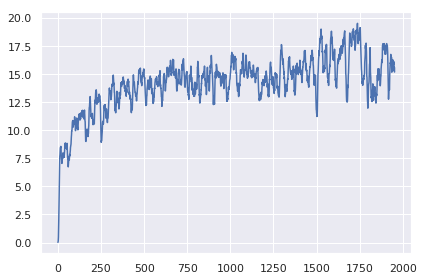

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./rnd_breakout_result.gif', writer='imagemagick', fps=30)

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg

Total Reward : 27.00


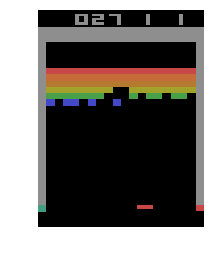

In [8]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
frames = []
done_counter = 0

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a, v, int_v, l = ppo.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./rnd_breakout_result.gif "segment")